# Read ALL Data:

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.callbacks import *
from keras.optimizers import Adam
from statistics import mean
import os

In [16]:
np.random.seed(7)
ford = pd.read_csv('/Users/aleenaalex/Documents/UCC projects/data/Ford 5 years.csv', header=0, index_col=0)
#ford_sales = pd.read_csv('/Users/aleenaalex/Documents/UCC projects/data/FordSales.csv', header=0, index_col=0)
ftse = pd.read_csv('/Users/aleenaalex/Documents/UCC projects/data/FTSE100.csv', header=0, index_col=0)
dow =  pd.read_csv('/Users/aleenaalex/Documents/UCC projects/data/Dow Jones US AUTO STOCK INDEX-5 Years.csv', header=0, index_col=0)

# Match Dates:

In [17]:
#Convert Date Format:
dow = pd.DataFrame(dow['Open'][3:1549])
Month_dict={'Jan':'01','Feb':'02','Mar':'03','Apr':'04','May':'05','Jun':'06',
       'Jul':'07','Aug':'08','Sep':'09','Oct':'10','Nov':'11','Dec':'12'}
dates = []
dates = list(dow.index)
dates = dates[0:len(dates)]
newDates = []
for idx in range(0,len(dates)): 
    date = dates[idx]
    #print(date)
    day,month,year = date[4:6],Month_dict[date[0:3]],date[7:11]
    newDates.append(year+'-'+month+'-'+day)
dow.insert(1, "FormatDate", newDates)
dow

Open  FormatDate
Date                           
May 14 2020  227.25  2020-05-14
May 13 2020  241.67  2020-05-13
May 12 2020  244.85  2020-05-12
May 11 2020  244.15  2020-05-11
May 08 2020  237.39  2020-05-08
...             ...         ...
May 21 2015  211.42  2015-05-21
May 20 2015  213.01  2015-05-20
May 19 2015  213.62  2015-05-19
May 18 2015  212.63  2015-05-18
May 15 2015  209.91  2015-05-15

[1546 rows x 2 columns]

In [18]:
ford

Open   High    Low  Close  Adj Close     Volume
Date                                                        
2015-05-15  15.27  15.49  15.27  15.48  11.977631   18937700
2015-05-18  15.47  15.64  15.45  15.58  12.055005   19491900
2015-05-19  15.59  15.63  15.45  15.50  11.993106   15145300
2015-05-20  15.54  15.56  15.26  15.30  11.838357   22391500
2015-05-21  15.28  15.55  15.26  15.51  12.000844   23962000
...           ...    ...    ...    ...        ...        ...
2020-05-08   4.96   5.25   4.95   5.24   5.240000  101333800
2020-05-11   5.18   5.19   5.05   5.12   5.120000   75593900
2020-05-12   5.15   5.22   4.97   4.98   4.980000   70965200
2020-05-13   5.00   5.01   4.66   4.72   4.720000  100192300
2020-05-14   4.64   4.92   4.52   4.89   4.890000  107931900

[1259 rows x 6 columns]

In [19]:
#merge values:
ford_dates = list(ford.index)
dow_dates = list(dow['FormatDate'])
mean_dow = mean(dow['Open'])
print(mean_dow,len(ford_dates))
ford["dow"] = mean_dow
for row_num in range(0,len(ford_dates)):
    date = ford_dates[row_num] 
    #print(date)
    if date in dow_dates:
        ford["dow"][row_num] = mean((dow['Open'][dow['FormatDate']==date]))
    
ford

198.285659767141 1259


/Users/aleenaalex/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


Open   High    Low  Close  Adj Close     Volume     dow
Date                                                                
2015-05-15  15.27  15.49  15.27  15.48  11.977631   18937700  209.91
2015-05-18  15.47  15.64  15.45  15.58  12.055005   19491900  212.63
2015-05-19  15.59  15.63  15.45  15.50  11.993106   15145300  213.62
2015-05-20  15.54  15.56  15.26  15.30  11.838357   22391500  213.01
2015-05-21  15.28  15.55  15.26  15.51  12.000844   23962000  211.42
...           ...    ...    ...    ...        ...        ...     ...
2020-05-08   4.96   5.25   4.95   5.24   5.240000  101333800  237.39
2020-05-11   5.18   5.19   5.05   5.12   5.120000   75593900  244.15
2020-05-12   5.15   5.22   4.97   4.98   4.980000   70965200  244.85
2020-05-13   5.00   5.01   4.66   4.72   4.720000  100192300  241.67
2020-05-14   4.64   4.92   4.52   4.89   4.890000  107931900  227.25

[1259 rows x 7 columns]

In [6]:
ftse['Open'][18:1283]

Date
May 14, 2020    5,904.10
May 13, 2020    5,994.80
May 12, 2020    5,939.70
May 11, 2020    5,936.00
May 07, 2020    5,853.80
                  ...   
May 21, 2015    7,007.30
May 20, 2015    6,995.10
May 19, 2015    6,968.90
May 18, 2015    6,960.50
May 15, 2015    6,973.00
Name: Open, Length: 1265, dtype: object

# Adding Dow Jones Index:
1. MLP Model

In [20]:
def normalize(data):
    
    scaler_open = MinMaxScaler()
    scaler_high = MinMaxScaler()
    scaler_low = MinMaxScaler()
    scaler_close = MinMaxScaler()
    scaler_adjclose = MinMaxScaler()
    scaler_volume = MinMaxScaler()
    scaler_dow = MinMaxScaler()
    
    #Open:
    fit = scaler_open.fit(np.array(data['Open']).reshape(-1, 1))
    data['Open'] =scaler_open.transform(np.array(dataframe_ford['Open']).reshape(-1, 1))
    
    #High:
    fit = scaler_high.fit(np.array(data['High']).reshape(-1, 1))
    data['High'] =scaler_high.transform(np.array(data['High']).reshape(-1, 1))
    
    #Low:
    fit = scaler_low.fit(np.array(data['Low']).reshape(-1, 1))
    data['Low'] =scaler_low.transform(np.array(data['Low']).reshape(-1, 1))
    
    #Close:
    fit = scaler_close.fit(np.array(data['Close']).reshape(-1, 1))
    data['Close'] =scaler_close.transform(np.array(data['Close']).reshape(-1, 1))
    
    #AdjClose:
    fit = scaler_adjclose.fit(np.array(data['Adj Close']).reshape(-1, 1))
    data['Adj Close'] =scaler_adjclose.transform(np.array(data['Adj Close']).reshape(-1, 1))
    
    #High:
    fit = scaler_volume.fit(np.array(data['Volume']).reshape(-1, 1))
    data['Volume'] =scaler_volume.transform(np.array(data['Volume']).reshape(-1, 1))
    
    #Dow:
    fit = scaler_dow.fit(np.array(data['dow']).reshape(-1, 1))
    data['dow'] =scaler_dow.transform(np.array(data['dow']).reshape(-1, 1))
    
    return data,scaler_high
    

In [21]:
df = ford
dataframe_ford = df
df,scaler = normalize(df)

In [22]:
#convert data: form X and y data:
#print(df.loc[['2015-05-15']])
Xarr = df.rename_axis('ID').values
Xarr = Xarr[0:1258]
Datearr = df.index.values

df1 = df[['High']]
yarr = df1.rename_axis('ID').values

print('Xarr:',Xarr[0:5])
print('yarr:',yarr[0:5])
print('Datearr:',Datearr[0:5])

yarr = np.delete(yarr, 0)
print('yarr:',yarr[0:5])
print('X shape:',Xarr.shape)
print('y shape:',yarr.shape)

Xarr: [[0.95986038 0.96935201 0.97416021 0.98286204 0.96620093 0.04988881
  0.43997648]
 [0.97731239 0.98248687 0.98966408 0.99143102 0.97558374 0.05236248
  0.45596708]
 [0.9877836  0.98161121 0.98966408 0.98457584 0.96807751 0.0329615
  0.46178718]
 [0.98342059 0.97548161 0.97329888 0.96743787 0.94931176 0.0653048
  0.45820106]
 [0.96073298 0.97460595 0.97329888 0.98543273 0.96901587 0.0723147
  0.44885362]]
yarr: [[0.96935201]
 [0.98248687]
 [0.98161121]
 [0.97548161]
 [0.97460595]]
Datearr: ['2015-05-15' '2015-05-18' '2015-05-19' '2015-05-20' '2015-05-21']
yarr: [0.98248687 0.98161121 0.97548161 0.97460595 0.97022767]
X shape: (1258, 7)
y shape: (1258,)


In [23]:
def build_data(start,pw,window_size=200):
    
    X_train,X_test = Xarr[start:start+window_size],Xarr[start+window_size:start+window_size+pw]
    y_train,y_test = yarr[start:start+window_size],yarr[start+window_size:start+window_size+pw]
    Date_train,Date_test = Datearr[start:start+window_size],Datearr[start+window_size:start+window_size+pw]
    return X_train,X_test,y_train,y_test,Date_train,Date_test

trn_size = len(Xarr)
X_train,X_test,y_train,y_test,Date_train,Date_test = build_data(0,pw=1,window_size = 200)
#print(X_train.shape[2])


In [13]:
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline
    
file_path = 'daily_mlp_model_weights.h5'
    
callback_checkpoint = ModelCheckpoint(filepath=file_path,
                                      monitor='val_loss',
                                      save_best_only=True,
                                      save_weights_only=True)
    
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0)
    
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3,
                              patience=5, min_lr=0.0009)
    
callbacks = [early_stopping, callback_checkpoint, reduce_lr]
    
tf.keras.backend.clear_session()
    
model_mlp = tf.keras.models.Sequential()
    
model_mlp.add(tf.keras.layers.Reshape((7,),input_shape=(7,)))
    
model_mlp.add(tf.keras.layers.Dense(200,activation='relu'))
    
model_mlp.add(tf.keras.layers.Dense(1,activation='linear'))
    
model_mlp.compile(optimizer='adam',loss='mse',metrics=['accuracy'])

In [14]:
import time
from itertools import chain
start_time = time.time()

predicted_high = []
actual_high = []
predicted_dates = []
window = 200
model_loss = []
model_val_loss =[]
val_loss = []

for sample in range(0,10):
    print('starting sample:',sample,'...')
    for trn in range(0,trn_size-window):
        X_train,X_test,y_train,y_test,Date_train,Date_test = build_data(trn,pw=1,window_size = window)
        #print(trn)
    
        history = model_mlp.fit(X_train, y_train,verbose = 0, epochs=200,
                        validation_data=(X_test, y_test), callbacks=callbacks, 
                        shuffle=False)
        yhat = model_mlp.predict(X_test, verbose=0)
        yhat = list(chain.from_iterable(yhat)) 
        if len(predicted_high) == 0:
            predicted_high = yhat
            predicted_dates = Date_test.tolist()
            actual_high = y_test.tolist()
            model_loss.append(history.history['loss'][-1])
            model_val_loss.append(history.history['val_loss'][-1])
        
        
        else:
            beg=len(predicted_high)-len(yhat)+1
            yhat_idx = 0
            for pred_idx in range(beg,len(predicted_high)):
                predicted_high[pred_idx]= (predicted_high[pred_idx] + yhat[yhat_idx])/2
                yhat_idx+=1
            predicted_high.append(yhat[-1])
            actual_high.append(y_test[-1])
            predicted_dates.append(Date_test.tolist()[-1])
            model_loss.append(history.history['loss'][-1])
            model_val_loss.append(history.history['val_loss'][-1])
    
    print('completed sample:',sample,'...')
    val_loss.append(round(mean(model_val_loss),8))
    
time_taken = time.time() - start_time
print("time taken for execution : %s seconds " % (time_taken))
print('Mean Validation loss=', round(mean(val_loss),8)) 



starting sample: 0 ...


/Users/aleenaalex/opt/anaconda3/lib/python3.7/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
/Users/aleenaalex/opt/anaconda3/lib/python3.7/site-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_loss available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)
/Users/aleenaalex/opt/anaconda3/lib/python3.7/site-packages/keras/callbacks/callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


KeyboardInterrupt: 

def evaluate_model(y_predicted,y_actual,dates):

    plt.figure(figsize=(20,10))
    plt.title('MLP: Plot of High Prices vs. Date with Dow Jones Auto index, Window Size =1',fontsize=20,fontweight='bold')
    plt.xlabel('Date',fontsize=15)
    plt.ylabel('High Prices',fontsize=15)
    plt.plot((y_actual.reshape(-1,1)), label="Actual")#,color='red')
    plt.plot(y_predicted.reshape(-1,1), label="Prediction", alpha=0.8)#,color ='black')
    index = np.arange((len(y_predicted)-1),step=90)
    plt.xticks(index,dates[index],fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize="xx-large")
    plt.savefig("LSTM.pdf")

 
#Rescaling the high values from range 0-1 to original values:
actual= scaler.inverse_transform(np.array(actual_high).reshape(-1,1))
predicted = scaler.inverse_transform(np.array(predicted_high).reshape(-1,1))
evaluate_model(predicted,actual,np.array(predicted_dates))

print("time taken for execution : %s seconds " % (time_taken))
print('Mean Validation loss=', round(mean(model_val_loss),8)) 
print('Mean Model loss=', round(mean(model_loss),8))


large_loss = []
large_loss_date = [] 
#print(f"{'index':10} {'val_loss':10} {'Date':12} {'Predicted High Value':10} {'Actual High Value':25}")     
for index in range(0,len(model_val_loss)):
    val_loss = model_val_loss[index]
    if val_loss>0.001:
        #print(f'{index:5} {val_loss:12f} {predicted_dates[index]:20} {predicted[index][0]:10f} {actual[index][0]:15f}')
        large_loss.append(val_loss)
        large_loss_date.append(predicted_dates[index])


plt.rcParams["font.weight"] = "bold"
plt.figure(figsize=(20,10))
plt.title('High MSE points after adding Dow Jones Auto Index',fontsize=20,fontweight='bold')
plt.ylabel('MSE',fontsize=15)
idx = np.arange(len(large_loss_date))
plt.xticks(idx,large_loss_date,rotation=90)
plt.bar(idx, large_loss, align='center', alpha=1)

2. CNN Model:

In [16]:
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
import matplotlib.pyplot as plt
%matplotlib inline

file_path = 'daily_mlp_model_weights.h5'
    
callback_checkpoint = ModelCheckpoint(filepath=file_path,
                                      monitor='val_loss',
                                      save_best_only=True,
                                      save_weights_only=True)
    
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0)
    
#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3,patience=5, min_lr=0.0009)
    
callbacks = [early_stopping, callback_checkpoint]#, reduce_lr]

Xarr = Xarr.reshape((Xarr.shape[0], Xarr.shape[1], 1))
# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(7, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [17]:
#CNN Model window size =1:
import time
from itertools import chain
start_time = time.time()

predicted_high = []
actual_high = []
predicted_dates = []
window = 200
model_loss = []
model_val_loss =[]
val_loss = []

for sample in range(0,10):
    print('starting sample:',sample,'...')

    for trn in range(0,trn_size-window):
        X_train,X_test,y_train,y_test,Date_train,Date_test = build_data(trn,pw=1,window_size = window)
        #print(trn)
    
        history = model.fit(X_train, y_train,verbose = 0, epochs=200,
                        validation_data=(X_test, y_test), callbacks=callbacks, 
                        shuffle=False)
        yhat = model.predict(X_test, verbose=0)
        yhat = list(chain.from_iterable(yhat)) 
        if len(predicted_high) == 0:
            predicted_high = yhat
            predicted_dates = Date_test.tolist()
            actual_high = y_test.tolist()
            model_loss.append(history.history['loss'][-1])
            model_val_loss.append(history.history['val_loss'][-1])
        
        
        else:
            beg=len(predicted_high)-len(yhat)+1
            yhat_idx = 0
            for pred_idx in range(beg,len(predicted_high)):
                predicted_high[pred_idx]= (predicted_high[pred_idx] + yhat[yhat_idx])/2
                yhat_idx+=1
            predicted_high.append(yhat[-1])
            actual_high.append(y_test[-1])
            predicted_dates.append(Date_test.tolist()[-1])
            model_loss.append(history.history['loss'][-1])
            model_val_loss.append(history.history['val_loss'][-1])
            
    print('completed sample:',sample,'...')
    val_loss.append(round(mean(model_val_loss),8))
    
time_taken = time.time() - start_time
print("time taken for execution : %s seconds " % (time_taken))
print('Mean Validation loss=', round(mean(val_loss),8)) 


starting sample: 0 ...
completed sample: 0 ...
starting sample: 1 ...
completed sample: 1 ...
starting sample: 2 ...
completed sample: 2 ...
starting sample: 3 ...
completed sample: 3 ...
starting sample: 4 ...
completed sample: 4 ...
starting sample: 5 ...
completed sample: 5 ...
starting sample: 6 ...
completed sample: 6 ...
starting sample: 7 ...
completed sample: 7 ...
starting sample: 8 ...
completed sample: 8 ...
starting sample: 9 ...
completed sample: 9 ...
time taken for execution : 1706.9874341487885 seconds 
Mean Validation loss= 0.0002587


def evaluate_model(y_predicted,y_actual,dates):

    plt.figure(figsize=(20,10))
    plt.title('CNN: Plot of High Prices vs. Date with Dow Jones Auto Index, Window Size =1',fontsize=20,fontweight='bold')
    plt.xlabel('Date',fontsize=15)
    plt.ylabel('High Prices',fontsize=15)
    plt.plot((y_actual.reshape(-1,1)), label="Actual")#,color='red')
    plt.plot(y_predicted.reshape(-1,1), label="Prediction", alpha=0.8)#,color ='black')
    index = np.arange((len(y_predicted)-1),step=90)
    plt.xticks(index,dates[index],fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize="xx-large")

 
#Rescaling the high values from range 0-1 to original values:
actual= scaler.inverse_transform(np.array(actual_high).reshape(-1,1))
predicted = scaler.inverse_transform(np.array(predicted_high).reshape(-1,1))
evaluate_model(predicted,actual,np.array(predicted_dates))

print("time taken for execution : %s seconds " % (time_taken))
print('Mean Validation loss=', round(mean(model_val_loss),8)) 
print('Mean Model loss=', round(mean(model_loss),8))


large_loss = []
large_loss_date = [] 
#print(f"{'index':10} {'val_loss':10} {'Date':12} {'Predicted High Value':10} {'Actual High Value':25}")     
for index in range(0,len(model_val_loss)):
    val_loss = model_val_loss[index]
    if val_loss>0.001:
        #print(f'{index:5} {val_loss:12f} {predicted_dates[index]:20} {predicted[index][0]:10f} {actual[index][0]:15f}')
        large_loss.append(val_loss)
        large_loss_date.append(predicted_dates[index])


plt.rcParams["font.weight"] = "bold"
plt.figure(figsize=(20,10))
plt.title('High MSE points',fontsize=20,fontweight='bold')
plt.ylabel('MSE',fontsize=15)
idx = np.arange(len(large_loss_date))
plt.xticks(idx,large_loss_date,rotation=90)
plt.bar(idx, large_loss, align='center', alpha=1)

3. LSTM

In [24]:
file_path = 'daily_mlp_model_weights.h5'
    
callback_checkpoint = ModelCheckpoint(filepath=file_path,
                                      monitor='val_loss',
                                      save_best_only=True,
                                      save_weights_only=True)
    
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0)
    
#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3,patience=5, min_lr=0.0009)
    
callbacks = [early_stopping, callback_checkpoint]#, reduce_lr]
adam = Adam(lr=0.003)
model = Sequential()
model.add(LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(16))
model.add(Dense(1))
model.compile(loss='mse', optimizer=adam)

IndexError: tuple index out of range

In [23]:
#window size =1:
import time
from itertools import chain
start_time = time.time()


val_loss = []
window = 200

for sample in range(0,5):
    print('starting sample:',sample,'...')
    predicted_high = []
    actual_high = []
    predicted_dates = []
    model_loss = []
    model_val_loss =[]

    for trn in range(0,trn_size-window):
        X_train,X_test,y_train,y_test,Date_train,Date_test = build_data(trn,pw=1,window_size = window)
        #print(trn)
    
        history = model.fit(X_train, y_train,verbose = 0, epochs=100,
                        validation_data=(X_test, y_test), callbacks=callbacks, 
                        shuffle=False)
        yhat = model.predict(X_test, verbose=0)
    
        predicted_high.append(yhat[0])
        predicted_dates.append(Date_test[0])
        actual_high.append(y_test[0])
        model_loss.append(history.history['loss'][-1])
        model_val_loss.append(history.history['val_loss'][-1])
    print('completed sample:',sample,'...')
    val_loss.append(round(mean(model_val_loss),8))
    
time_taken = time.time() - start_time
print("time taken for execution : %s seconds " % (time_taken))
print('Mean Validation loss=', round(mean(val_loss),8)) 
    

starting sample: 0 ...
completed sample: 0 ...
starting sample: 1 ...
completed sample: 1 ...
starting sample: 2 ...
completed sample: 2 ...
starting sample: 3 ...
completed sample: 3 ...
starting sample: 4 ...
completed sample: 4 ...
time taken for execution : 3407.0671529769897 seconds 
Mean Validation loss= 0.00051362


time taken for execution : 3258.084669828415 seconds 
Mean Validation loss= 0.00081641
Mean Model loss= 8.571e-05


<BarContainer object of 399 artists>

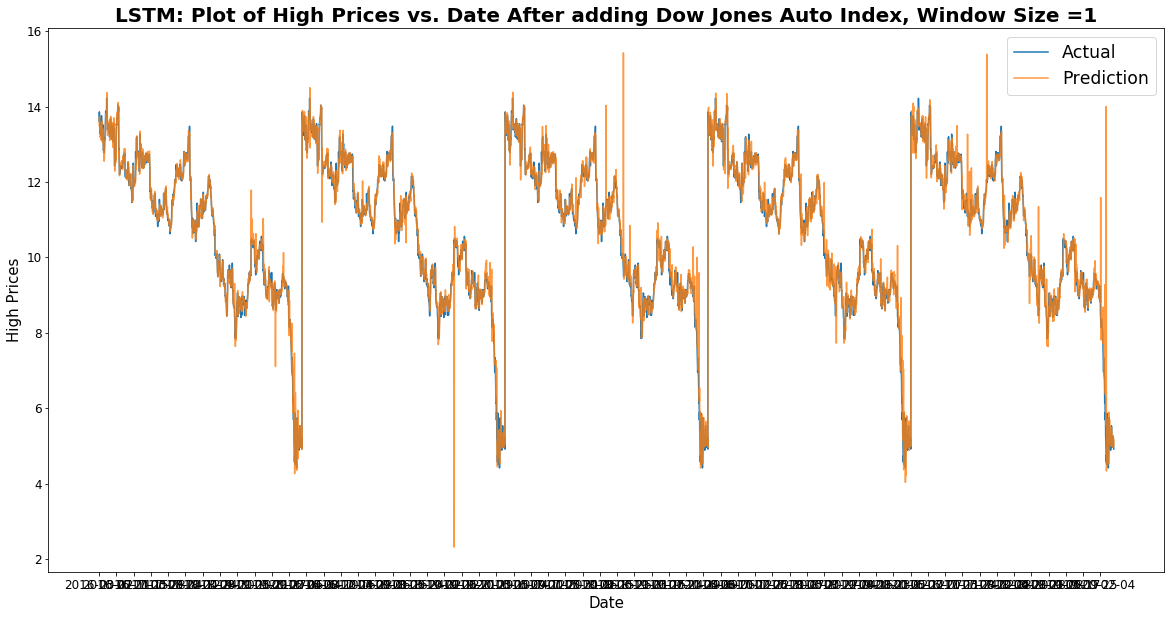

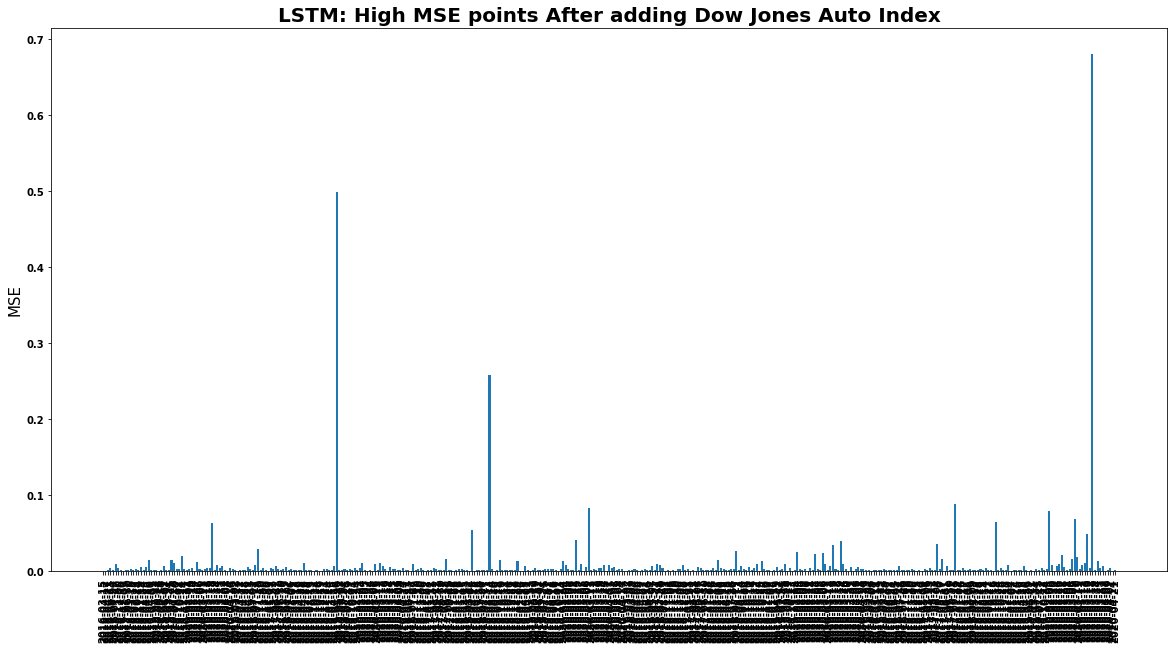

In [20]:
def evaluate_model(y_predicted,y_actual,dates):

    plt.figure(figsize=(20,10))
    plt.title('LSTM: Plot of High Prices vs. Date After adding Dow Jones Auto Index, Window Size =1',fontsize=20,fontweight='bold')
    plt.xlabel('Date',fontsize=15)
    plt.ylabel('High Prices',fontsize=15)
    plt.plot((y_actual.reshape(-1,1)), label="Actual")#,color='red')
    plt.plot(y_predicted.reshape(-1,1), label="Prediction", alpha=0.8)#,color ='black')
    index = np.arange((len(y_predicted)-1),step=90)
    plt.xticks(index,dates[index],fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize="xx-large")
    plt.savefig("LSTM.pdf")

 
#Rescaling the high values from range 0-1 to original values:
actual= scaler.inverse_transform(np.array(actual_high).reshape(-1,1))
predicted = scaler.inverse_transform(np.array(predicted_high).reshape(-1,1))
evaluate_model(predicted,actual,np.array(predicted_dates))

print("time taken for execution : %s seconds " % (time_taken))
print('Mean Validation loss=', round(mean(model_val_loss),8)) 
print('Mean Model loss=', round(mean(model_loss),8))


large_loss = []
large_loss_date = [] 
#print(f"{'index':10} {'val_loss':10} {'Date':12} {'Predicted High Value':10} {'Actual High Value':25}")     
for index in range(0,len(model_val_loss)):
    val_loss = model_val_loss[index]
    if val_loss>0.001:
        #print(f'{index:5} {val_loss:12f} {predicted_dates[index]:20} {predicted[index][0]:10f} {actual[index][0]:15f}')
        large_loss.append(val_loss)
        large_loss_date.append(predicted_dates[index])


plt.rcParams["font.weight"] = "bold"
plt.figure(figsize=(20,10))
plt.title('LSTM: High MSE points After adding Dow Jones Auto Index',fontsize=20,fontweight='bold')
plt.ylabel('MSE',fontsize=15)
idx = np.arange(len(large_loss_date))
plt.xticks(idx,large_loss_date,rotation=90)
plt.bar(idx, large_loss, align='center', alpha=1)

# Adding FTSE Opening Index:

In [40]:
ftse = pd.DataFrame(ftse['Open'][18:1283])
Month_dict={'Jan':'01','Feb':'02','Mar':'03','Apr':'04','May':'05','Jun':'06',
       'Jul':'07','Aug':'08','Sep':'09','Oct':'10','Nov':'11','Dec':'12'}
dates = []
dates = list(ftse.index)
dates = dates[0:len(dates)]
newDates = []
for idx in range(0,len(dates)): 
    date = dates[idx]
    #print(date)
    day,month,year = date[4:6],Month_dict[date[0:3]],date[8:12]
    #print(year+'-'+month+'-'+day)
    newDates.append(year+'-'+month+'-'+day)
ftse.insert(1, "FormatDate", newDates)
ftse

Open  FormatDate
Date                              
May 14, 2020  5,904.10  2020-05-14
May 13, 2020  5,994.80  2020-05-13
May 12, 2020  5,939.70  2020-05-12
May 11, 2020  5,936.00  2020-05-11
May 07, 2020  5,853.80  2020-05-07
...                ...         ...
May 21, 2015  7,007.30  2015-05-21
May 20, 2015  6,995.10  2015-05-20
May 19, 2015  6,968.90  2015-05-19
May 18, 2015  6,960.50  2015-05-18
May 15, 2015  6,973.00  2015-05-15

[1265 rows x 2 columns]

In [41]:
#merge values:
ford_dates = list(ford.index)
ftse_dates = list(ftse['FormatDate'])
ftse["newOpen"] = 0
for row_num in range(0,len(ftse['Open'])):
    ftse["newOpen"][row_num] = float((ftse['Open'][row_num].replace(",", "")).replace("-", "0")) 
mean_ftse = mean(ftse["newOpen"])
print(mean_ftse,len(ford_dates))
ford["ftse"] = mean_ftse
for row_num in range(0,len(ford_dates)):
    date = ford_dates[row_num] 
    #print(date)
    if date in ftse_dates:
        ford["ftse"][row_num] = mean((ftse['newOpen'][ftse['FormatDate']==date]))
    
ford

/Users/aleenaalex/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/aleenaalex/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


6982.075098814229 1259


Open   High    Low  Close  Adj Close     Volume         ftse
Date                                                                     
2015-05-15  15.27  15.49  15.27  15.48  11.977631   18937700  6973.000000
2015-05-18  15.47  15.64  15.45  15.58  12.055005   19491900  6960.000000
2015-05-19  15.59  15.63  15.45  15.50  11.993106   15145300  6968.000000
2015-05-20  15.54  15.56  15.26  15.30  11.838357   22391500  6995.000000
2015-05-21  15.28  15.55  15.26  15.51  12.000844   23962000  7007.000000
...           ...    ...    ...    ...        ...        ...          ...
2020-05-08   4.96   5.25   4.95   5.24   5.240000  101333800  6982.075099
2020-05-11   5.18   5.19   5.05   5.12   5.120000   75593900  5936.000000
2020-05-12   5.15   5.22   4.97   4.98   4.980000   70965200  5939.000000
2020-05-13   5.00   5.01   4.66   4.72   4.720000  100192300  5994.000000
2020-05-14   4.64   4.92   4.52   4.89   4.890000  107931900  5904.000000

[1259 rows x 7 columns]

In [42]:
def normalize(data):
    
    scaler_open = MinMaxScaler()
    scaler_high = MinMaxScaler()
    scaler_low = MinMaxScaler()
    scaler_close = MinMaxScaler()
    scaler_adjclose = MinMaxScaler()
    scaler_volume = MinMaxScaler()
    scaler_ftse = MinMaxScaler()
    
    #Open:
    fit = scaler_open.fit(np.array(data['Open']).reshape(-1, 1))
    data['Open'] =scaler_open.transform(np.array(dataframe_ford['Open']).reshape(-1, 1))
    
    #High:
    fit = scaler_high.fit(np.array(data['High']).reshape(-1, 1))
    data['High'] =scaler_high.transform(np.array(data['High']).reshape(-1, 1))
    
    #Low:
    fit = scaler_low.fit(np.array(data['Low']).reshape(-1, 1))
    data['Low'] =scaler_low.transform(np.array(data['Low']).reshape(-1, 1))
    
    #Close:
    fit = scaler_close.fit(np.array(data['Close']).reshape(-1, 1))
    data['Close'] =scaler_close.transform(np.array(data['Close']).reshape(-1, 1))
    
    #AdjClose:
    fit = scaler_adjclose.fit(np.array(data['Adj Close']).reshape(-1, 1))
    data['Adj Close'] =scaler_adjclose.transform(np.array(data['Adj Close']).reshape(-1, 1))
    
    #High:
    fit = scaler_volume.fit(np.array(data['Volume']).reshape(-1, 1))
    data['Volume'] =scaler_volume.transform(np.array(data['Volume']).reshape(-1, 1))
    
    #Dow:
    fit = scaler_ftse.fit(np.array(data['ftse']).reshape(-1, 1))
    data['ftse'] =scaler_ftse.transform(np.array(data['ftse']).reshape(-1, 1))
    
    return data,scaler_high
    

In [43]:
df = ford
dataframe_ford = df
df,scaler = normalize(df)

In [44]:
#convert data: form X and y data:
#print(df.loc[['2015-05-15']])
Xarr = df.rename_axis('ID').values
Xarr = Xarr[0:1258]
Datearr = df.index.values

df1 = df[['High']]
yarr = df1.rename_axis('ID').values

print('Xarr:',Xarr[0:5])
print('yarr:',yarr[0:5])
print('Datearr:',Datearr[0:5])

yarr = np.delete(yarr, 0)
print('yarr:',yarr[0:5])
print('X shape:',Xarr.shape)
print('y shape:',yarr.shape)

def build_data(start,pw,window_size=200):
    
    X_train,X_test = Xarr[start:start+window_size],Xarr[start+window_size:start+window_size+pw]
    y_train,y_test = yarr[start:start+window_size],yarr[start+window_size:start+window_size+pw]
    Date_train,Date_test = Datearr[start:start+window_size],Datearr[start+window_size:start+window_size+pw]
    return X_train,X_test,y_train,y_test,Date_train,Date_test

trn_size = len(Xarr)

Xarr: [[0.95986038 0.96935201 0.97416021 0.98286204 0.96620093 0.04988881
  0.8852355 ]
 [0.97731239 0.98248687 0.98966408 0.99143102 0.97558374 0.05236248
  0.88358512]
 [0.9877836  0.98161121 0.98966408 0.98457584 0.96807751 0.0329615
  0.88460074]
 [0.98342059 0.97548161 0.97329888 0.96743787 0.94931176 0.0653048
  0.88802844]
 [0.96073298 0.97460595 0.97329888 0.98543273 0.96901587 0.0723147
  0.88955186]]
yarr: [[0.96935201]
 [0.98248687]
 [0.98161121]
 [0.97548161]
 [0.97460595]]
Datearr: ['2015-05-15' '2015-05-18' '2015-05-19' '2015-05-20' '2015-05-21']
yarr: [0.98248687 0.98161121 0.97548161 0.97460595 0.97022767]
X shape: (1258, 7)
y shape: (1258,)


In [45]:
#MLP Model:

In [46]:
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline
    
file_path = 'daily_mlp_model_weights.h5'
    
callback_checkpoint = ModelCheckpoint(filepath=file_path,
                                      monitor='val_loss',
                                      save_best_only=True,
                                      save_weights_only=True)
    
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0)
    
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3,
                              patience=5, min_lr=0.0009)
    
callbacks = [early_stopping, callback_checkpoint, reduce_lr]
    
tf.keras.backend.clear_session()
    
model_mlp = tf.keras.models.Sequential()
    
model_mlp.add(tf.keras.layers.Reshape((7,),input_shape=(7,)))
    
model_mlp.add(tf.keras.layers.Dense(200,activation='relu'))
    
model_mlp.add(tf.keras.layers.Dense(1,activation='linear'))
    
model_mlp.compile(optimizer='adam',loss='mse',metrics=['accuracy'])

In [47]:
import time
from itertools import chain
start_time = time.time()

predicted_high = []
actual_high = []
predicted_dates = []
window = 200
model_loss = []
model_val_loss =[]
val_loss = []

for sample in range(0,10):
    print('starting sample:',sample,'...')
    for trn in range(0,trn_size-window):
        X_train,X_test,y_train,y_test,Date_train,Date_test = build_data(trn,pw=1,window_size = window)
        #print(trn)
    
        history = model_mlp.fit(X_train, y_train,verbose = 0, epochs=200,
                        validation_data=(X_test, y_test), callbacks=callbacks, 
                        shuffle=False)
        yhat = model_mlp.predict(X_test, verbose=0)
        yhat = list(chain.from_iterable(yhat)) 
        if len(predicted_high) == 0:
            predicted_high = yhat
            predicted_dates = Date_test.tolist()
            actual_high = y_test.tolist()
            model_loss.append(history.history['loss'][-1])
            model_val_loss.append(history.history['val_loss'][-1])
        
        
        else:
            beg=len(predicted_high)-len(yhat)+1
            yhat_idx = 0
            for pred_idx in range(beg,len(predicted_high)):
                predicted_high[pred_idx]= (predicted_high[pred_idx] + yhat[yhat_idx])/2
                yhat_idx+=1
            predicted_high.append(yhat[-1])
            actual_high.append(y_test[-1])
            predicted_dates.append(Date_test.tolist()[-1])
            model_loss.append(history.history['loss'][-1])
            model_val_loss.append(history.history['val_loss'][-1])
    
    print('completed sample:',sample,'...')
    val_loss.append(round(mean(model_val_loss),8))
    
time_taken = time.time() - start_time
print("time taken for execution : %s seconds " % (time_taken))
print('Mean Validation loss=', round(mean(val_loss),8)) 

starting sample: 0 ...
completed sample: 0 ...
starting sample: 1 ...
completed sample: 1 ...
starting sample: 2 ...
completed sample: 2 ...
starting sample: 3 ...
completed sample: 3 ...
starting sample: 4 ...
completed sample: 4 ...
starting sample: 5 ...
completed sample: 5 ...
starting sample: 6 ...
completed sample: 6 ...
starting sample: 7 ...
completed sample: 7 ...
starting sample: 8 ...
completed sample: 8 ...
starting sample: 9 ...
completed sample: 9 ...
time taken for execution : 3160.9805550575256 seconds 
Mean Validation loss= 0.00016697


In [ ]:
def evaluate_model(y_predicted,y_actual,dates):

    plt.figure(figsize=(20,10))
    plt.title('CNN: Plot of High Prices vs. Date with FTSE index, Window Size =1',fontsize=20,fontweight='bold')
    plt.xlabel('Date',fontsize=15)
    plt.ylabel('High Prices',fontsize=15)
    plt.plot((y_actual.reshape(-1,1)), label="Actual")#,color='red')
    plt.plot(y_predicted.reshape(-1,1), label="Prediction", alpha=0.8)#,color ='black')
    index = np.arange((len(y_predicted)-1),step=90)
    plt.xticks(index,dates[index],fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize="xx-large")
    plt.savefig("LSTM.pdf")

 
#Rescaling the high values from range 0-1 to original values:
actual= scaler.inverse_transform(np.array(actual_high).reshape(-1,1))
predicted = scaler.inverse_transform(np.array(predicted_high).reshape(-1,1))
evaluate_model(predicted,actual,np.array(predicted_dates))

print("time taken for execution : %s seconds " % (time_taken))
print('Mean Validation loss=', round(mean(model_val_loss),8)) 
print('Mean Model loss=', round(mean(model_loss),8))


large_loss = []
large_loss_date = [] 
#print(f"{'index':10} {'val_loss':10} {'Date':12} {'Predicted High Value':10} {'Actual High Value':25}")     
for index in range(0,len(model_val_loss)):
    val_loss = model_val_loss[index]
    if val_loss>0.001:
        #print(f'{index:5} {val_loss:12f} {predicted_dates[index]:20} {predicted[index][0]:10f} {actual[index][0]:15f}')
        large_loss.append(val_loss)
        large_loss_date.append(predicted_dates[index])


plt.rcParams["font.weight"] = "bold"
plt.figure(figsize=(20,10))
plt.title('High MSE points after adding FTSE',fontsize=20,fontweight='bold')
plt.ylabel('MSE',fontsize=15)
idx = np.arange(len(large_loss_date))
plt.xticks(idx,large_loss_date,rotation=90)
plt.bar(idx, large_loss, align='center', alpha=1)

# 2. CNN Model:

In [52]:
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
import matplotlib.pyplot as plt
%matplotlib inline

file_path = 'daily_mlp_model_weights.h5'
    
callback_checkpoint = ModelCheckpoint(filepath=file_path,
                                      monitor='val_loss',
                                      save_best_only=True,
                                      save_weights_only=True)
    
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0)
    
#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3,patience=5, min_lr=0.0009)
    
callbacks = [early_stopping, callback_checkpoint]#, reduce_lr]

Xarr = Xarr.reshape((Xarr.shape[0], Xarr.shape[1], 1))
# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(7, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [53]:
#CNN Model window size =1:
import time
from itertools import chain
start_time = time.time()

predicted_high = []
actual_high = []
predicted_dates = []
window = 200
model_loss = []
model_val_loss =[]
val_loss = []

for sample in range(0,10):
    print('starting sample:',sample,'...')

    for trn in range(0,trn_size-window):
        X_train,X_test,y_train,y_test,Date_train,Date_test = build_data(trn,pw=1,window_size = window)
        #print(trn)
    
        history = model.fit(X_train, y_train,verbose = 0, epochs=200,
                        validation_data=(X_test, y_test), callbacks=callbacks, 
                        shuffle=False)
        yhat = model.predict(X_test, verbose=0)
        yhat = list(chain.from_iterable(yhat)) 
        if len(predicted_high) == 0:
            predicted_high = yhat
            predicted_dates = Date_test.tolist()
            actual_high = y_test.tolist()
            model_loss.append(history.history['loss'][-1])
            model_val_loss.append(history.history['val_loss'][-1])
        
        
        else:
            beg=len(predicted_high)-len(yhat)+1
            yhat_idx = 0
            for pred_idx in range(beg,len(predicted_high)):
                predicted_high[pred_idx]= (predicted_high[pred_idx] + yhat[yhat_idx])/2
                yhat_idx+=1
            predicted_high.append(yhat[-1])
            actual_high.append(y_test[-1])
            predicted_dates.append(Date_test.tolist()[-1])
            model_loss.append(history.history['loss'][-1])
            model_val_loss.append(history.history['val_loss'][-1])
            
    print('completed sample:',sample,'...')
    val_loss.append(round(mean(model_val_loss),8))
    
time_taken = time.time() - start_time
print("time taken for execution : %s seconds " % (time_taken))
print('Mean Validation loss=', round(mean(val_loss),8)) 

starting sample: 0 ...
completed sample: 0 ...
starting sample: 1 ...
completed sample: 1 ...
starting sample: 2 ...
completed sample: 2 ...
starting sample: 3 ...
completed sample: 3 ...
starting sample: 4 ...
completed sample: 4 ...
starting sample: 5 ...
completed sample: 5 ...
starting sample: 6 ...
completed sample: 6 ...
starting sample: 7 ...
completed sample: 7 ...
starting sample: 8 ...
completed sample: 8 ...
starting sample: 9 ...
completed sample: 9 ...
time taken for execution : 1384.4834849834442 seconds 
Mean Validation loss= 0.00023281


time taken for execution : 130.79235792160034 seconds 
Mean Validation loss= 0.00023811
Mean Model loss= 0.00014511


<BarContainer object of 46 artists>

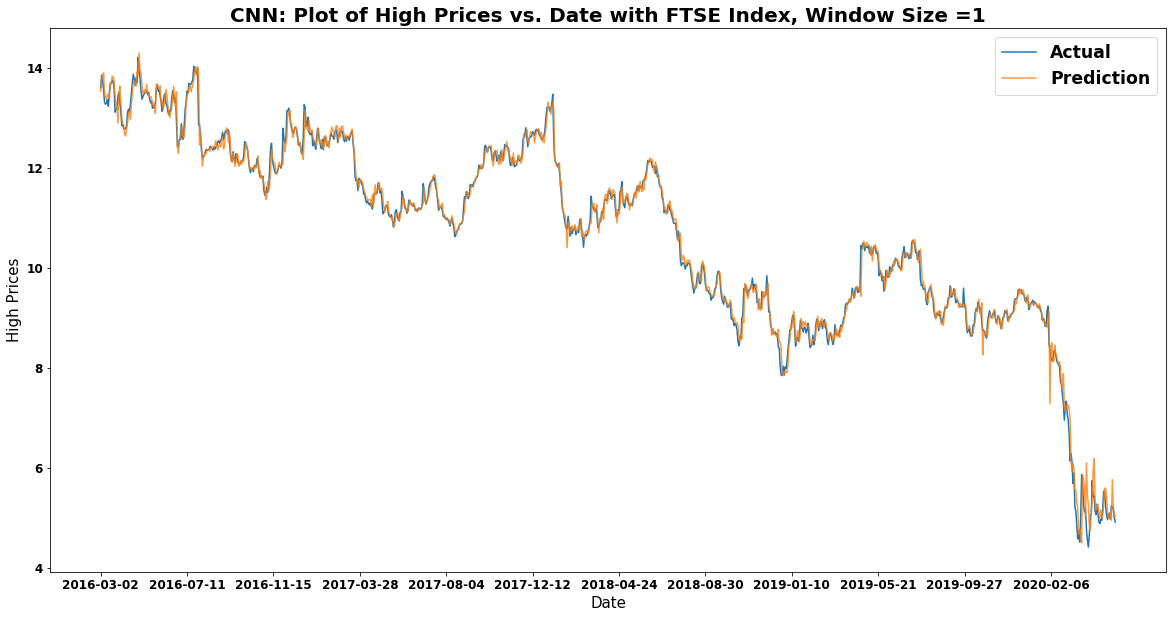

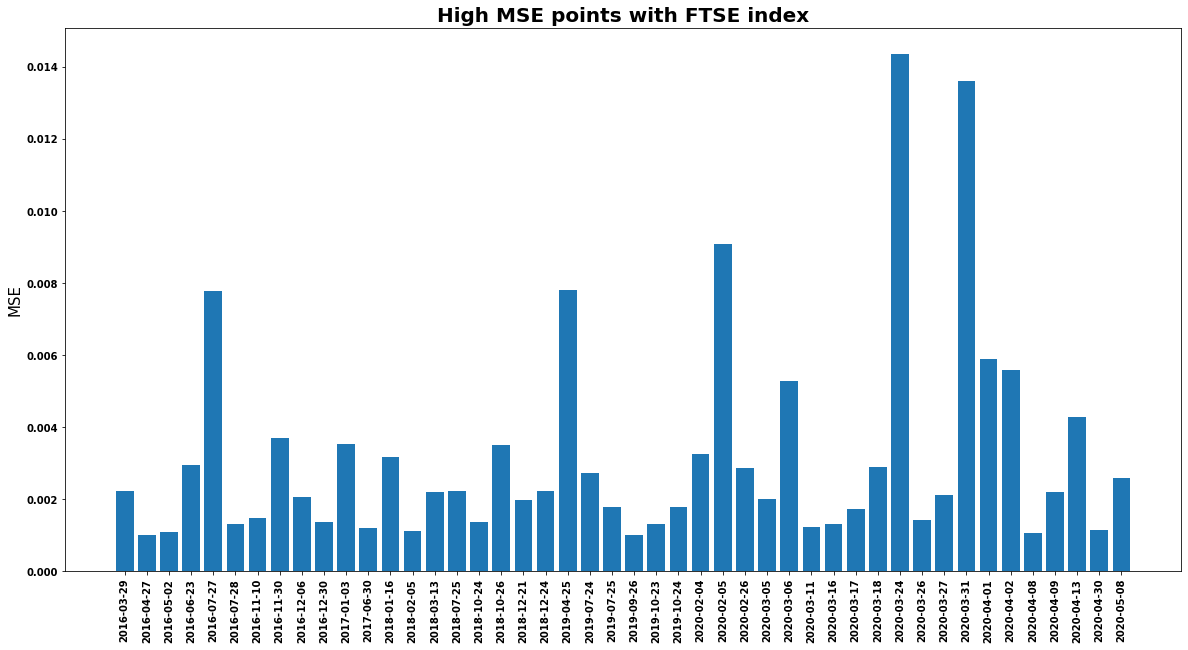

In [292]:
def evaluate_model(y_predicted,y_actual,dates):

    plt.figure(figsize=(20,10))
    plt.title('CNN: Plot of High Prices vs. Date with FTSE Index, Window Size =1',fontsize=20,fontweight='bold')
    plt.xlabel('Date',fontsize=15)
    plt.ylabel('High Prices',fontsize=15)
    plt.plot((y_actual.reshape(-1,1)), label="Actual")#,color='red')
    plt.plot(y_predicted.reshape(-1,1), label="Prediction", alpha=0.8)#,color ='black')
    index = np.arange((len(y_predicted)-1),step=90)
    plt.xticks(index,dates[index],fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize="xx-large")

 
#Rescaling the high values from range 0-1 to original values:
actual= scaler.inverse_transform(np.array(actual_high).reshape(-1,1))
predicted = scaler.inverse_transform(np.array(predicted_high).reshape(-1,1))
evaluate_model(predicted,actual,np.array(predicted_dates))

print("time taken for execution : %s seconds " % (time_taken))
print('Mean Validation loss=', round(mean(model_val_loss),8)) 
print('Mean Model loss=', round(mean(model_loss),8))


large_loss = []
large_loss_date = [] 
#print(f"{'index':10} {'val_loss':10} {'Date':12} {'Predicted High Value':10} {'Actual High Value':25}")     
for index in range(0,len(model_val_loss)):
    val_loss = model_val_loss[index]
    if val_loss>0.001:
        #print(f'{index:5} {val_loss:12f} {predicted_dates[index]:20} {predicted[index][0]:10f} {actual[index][0]:15f}')
        large_loss.append(val_loss)
        large_loss_date.append(predicted_dates[index])


plt.rcParams["font.weight"] = "bold"
plt.figure(figsize=(20,10))
plt.title('High MSE points with FTSE index',fontsize=20,fontweight='bold')
plt.ylabel('MSE',fontsize=15)
idx = np.arange(len(large_loss_date))
plt.xticks(idx,large_loss_date,rotation=90)
plt.bar(idx, large_loss, align='center', alpha=1)

# 3. LSTM:

In [57]:
file_path = 'daily_mlp_model_weights.h5'
    
callback_checkpoint = ModelCheckpoint(filepath=file_path,
                                      monitor='val_loss',
                                      save_best_only=True,
                                      save_weights_only=True)
    
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0)
    
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3,patience=5, min_lr=0.0009)
    
callbacks = [early_stopping, callback_checkpoint]#, reduce_lr]
adam = Adam(lr=0.003)
model = Sequential()
model.add(LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(16))
model.add(Dense(1))
model.compile(loss='mse', optimizer=adam)

In [ ]:
#window size =1:
import time
from itertools import chain
start_time = time.time()

predicted_high = []
actual_high = []
predicted_dates = []
window = 200
model_loss = []
model_val_loss =[]
val_loss = []

for sample in range(0,10):
    print('starting sample:',sample,'...')

    for trn in range(0,trn_size-window):
        X_train,X_test,y_train,y_test,Date_train,Date_test = build_data(trn,pw=1,window_size = window)
        #print(trn)
    
        history = model.fit(X_train, y_train,verbose = 0, epochs=200,
                        validation_data=(X_test, y_test), callbacks=callbacks, 
                        shuffle=False)
        yhat = model.predict(X_test, verbose=0)
        yhat = list(chain.from_iterable(yhat)) 
        if len(predicted_high) == 0:
            predicted_high = yhat
            predicted_dates = Date_test.tolist()
            actual_high = y_test.tolist()
            model_loss.append(history.history['loss'][-1])
            model_val_loss.append(history.history['val_loss'][-1])
        
        
        else:
            beg=len(predicted_high)-len(yhat)+1
            yhat_idx = 0
            for pred_idx in range(beg,len(predicted_high)):
                predicted_high[pred_idx]= (predicted_high[pred_idx] + yhat[yhat_idx])/2
                yhat_idx+=1
            predicted_high.append(yhat[-1])
            actual_high.append(y_test[-1])
            predicted_dates.append(Date_test.tolist()[-1])
            model_loss.append(history.history['loss'][-1])
            model_val_loss.append(history.history['val_loss'][-1])
            
    print('completed sample:',sample,'...')
    val_loss.append(round(mean(model_val_loss),8))
    
time_taken = time.time() - start_time
print("time taken for execution : %s seconds " % (time_taken))
print('Mean Validation loss=', round(mean(val_loss),8)) 
    

starting sample: 0 ...
completed sample: 0 ...
starting sample: 1 ...
completed sample: 1 ...
starting sample: 2 ...
completed sample: 2 ...
starting sample: 3 ...
completed sample: 3 ...
starting sample: 4 ...
completed sample: 4 ...
starting sample: 5 ...
completed sample: 5 ...
starting sample: 6 ...


time taken for execution : 6812.743005037308 seconds 
Mean Validation loss= 0.00077102
Mean Model loss= 7.573e-05


<BarContainer object of 960 artists>

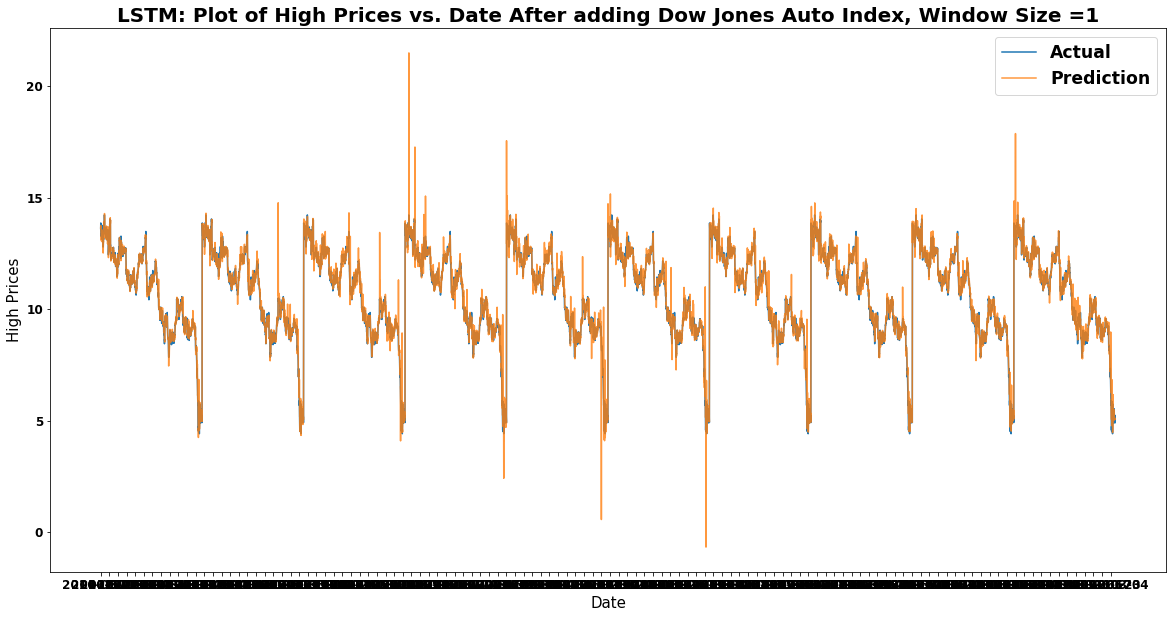

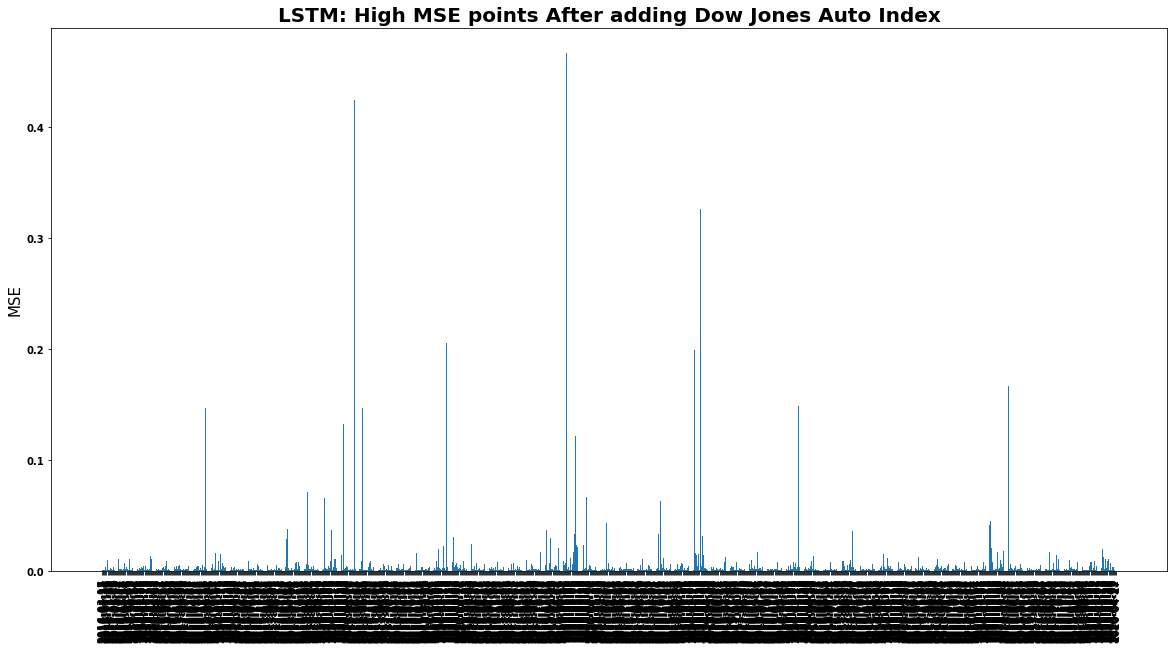

In [56]:
def evaluate_model(y_predicted,y_actual,dates):

    plt.figure(figsize=(20,10))
    plt.title('LSTM: Plot of High Prices vs. Date After adding Dow Jones Auto Index, Window Size =1',fontsize=20,fontweight='bold')
    plt.xlabel('Date',fontsize=15)
    plt.ylabel('High Prices',fontsize=15)
    plt.plot((y_actual.reshape(-1,1)), label="Actual")#,color='red')
    plt.plot(y_predicted.reshape(-1,1), label="Prediction", alpha=0.8)#,color ='black')
    index = np.arange((len(y_predicted)-1),step=90)
    plt.xticks(index,dates[index],fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize="xx-large")
    plt.savefig("LSTM.pdf")

 
#Rescaling the high values from range 0-1 to original values:
actual= scaler.inverse_transform(np.array(actual_high).reshape(-1,1))
predicted = scaler.inverse_transform(np.array(predicted_high).reshape(-1,1))
evaluate_model(predicted,actual,np.array(predicted_dates))

print("time taken for execution : %s seconds " % (time_taken))
print('Mean Validation loss=', round(mean(model_val_loss),8)) 
print('Mean Model loss=', round(mean(model_loss),8))


large_loss = []
large_loss_date = [] 
#print(f"{'index':10} {'val_loss':10} {'Date':12} {'Predicted High Value':10} {'Actual High Value':25}")     
for index in range(0,len(model_val_loss)):
    val_loss = model_val_loss[index]
    if val_loss>0.001:
        #print(f'{index:5} {val_loss:12f} {predicted_dates[index]:20} {predicted[index][0]:10f} {actual[index][0]:15f}')
        large_loss.append(val_loss)
        large_loss_date.append(predicted_dates[index])


plt.rcParams["font.weight"] = "bold"
plt.figure(figsize=(20,10))
plt.title('LSTM: High MSE points After adding Dow Jones Auto Index',fontsize=20,fontweight='bold')
plt.ylabel('MSE',fontsize=15)
idx = np.arange(len(large_loss_date))
plt.xticks(idx,large_loss_date,rotation=90)
plt.bar(idx, large_loss, align='center', alpha=1)

# Keeping both dow jones and ftse:

In [296]:
ford

Open      High       Low     Close  Adj Close    Volume  \
Date                                                                      
2015-05-15  0.959860  0.969352  0.974160  0.982862   0.966201  0.049889   
2015-05-18  0.977312  0.982487  0.989664  0.991431   0.975584  0.052362   
2015-05-19  0.987784  0.981611  0.989664  0.984576   0.968078  0.032961   
2015-05-20  0.983421  0.975482  0.973299  0.967438   0.949312  0.065305   
2015-05-21  0.960733  0.974606  0.973299  0.985433   0.969016  0.072315   
...              ...       ...       ...       ...        ...       ...   
2020-05-08  0.060209  0.072680  0.085271  0.105398   0.149157  0.417663   
2020-05-11  0.079407  0.067426  0.093885  0.095116   0.134605  0.302773   
2020-05-12  0.076789  0.070053  0.086994  0.083119   0.117628  0.282113   
2020-05-13  0.063700  0.051664  0.060293  0.060840   0.086099  0.412567   
2020-05-14  0.032286  0.043783  0.048234  0.075407   0.106714  0.447113   

                ftse  
Date                  
2015-05-15  0.885235  
2015-05-18  0.883585  
2015-05-19  0.884601  
2015-05-20  0.888028  
2015-05-21  0.889552  
...              ...  
2020-05-08  0.886446  
2020-05-11  0.753586  
2020-05-12  0.753967  
2020-05-13  0.760950  
2020-05-14  0.749524  

[1259 rows x 7 columns]

In [297]:
dow

Close  Change Change (%)    Open    High     Low        Volume
Date                                                                        
May 19 2020  245.30   -1.58     -0.64%  246.92  250.43  243.59  12,52,99,368
May 18 2020  246.88    9.86      4.16%  245.66  250.73  244.72  17,55,98,702
May 15 2020  237.02   -0.19     -0.08%  233.84  237.75  232.12  10,75,07,741
May 14 2020  237.21    5.13      2.21%  227.25  237.24  223.98  14,05,45,939
May 13 2020  232.08   -7.42     -3.10%  241.67  242.33  225.46  13,80,71,014
...             ...     ...        ...     ...     ...     ...           ...
Feb 06 2015  215.22   -0.63     -0.29%  215.85  217.28  214.87   1,10,32,819
Feb 05 2015  215.85    1.21      0.56%  214.84  217.52  214.81     98,36,035
Feb 04 2015  214.64    4.78      2.28%  209.86  216.23  209.80   1,82,13,835
Feb 03 2015  209.86    5.57      2.73%  204.29  210.65  204.29   1,56,52,082
Feb 02 2015  204.29    5.25      2.64%  199.04  204.56  198.73   1,21,94,649

[1643 rows x 7 columns]

In [298]:
#Convert Date Format:
dow = pd.DataFrame(dow['Open'][3:1549])
Month_dict={'Jan':'01','Feb':'02','Mar':'03','Apr':'04','May':'05','Jun':'06',
       'Jul':'07','Aug':'08','Sep':'09','Oct':'10','Nov':'11','Dec':'12'}
dates = []
dates = list(dow.index)
dates = dates[0:len(dates)]
newDates = []
for idx in range(0,len(dates)): 
    date = dates[idx]
    #print(date)
    day,month,year = date[4:6],Month_dict[date[0:3]],date[7:11]
    newDates.append(year+'-'+month+'-'+day)
dow.insert(1, "FormatDate", newDates)
dow

Open  FormatDate
Date                           
May 14 2020  227.25  2020-05-14
May 13 2020  241.67  2020-05-13
May 12 2020  244.85  2020-05-12
May 11 2020  244.15  2020-05-11
May 08 2020  237.39  2020-05-08
...             ...         ...
May 21 2015  211.42  2015-05-21
May 20 2015  213.01  2015-05-20
May 19 2015  213.62  2015-05-19
May 18 2015  212.63  2015-05-18
May 15 2015  209.91  2015-05-15

[1546 rows x 2 columns]

In [299]:
#merge values:
ford_dates = list(ford.index)
dow_dates = list(dow['FormatDate'])
mean_dow = mean(dow['Open'])
print(mean_dow,len(ford_dates))
ford["dow"] = mean_dow
for row_num in range(0,len(ford_dates)):
    date = ford_dates[row_num] 
    #print(date)
    if date in dow_dates:
        ford["dow"][row_num] = mean((dow['Open'][dow['FormatDate']==date]))
    
ford

198.285659767141 1259


Open      High       Low     Close  Adj Close    Volume  \
Date                                                                      
2015-05-15  0.959860  0.969352  0.974160  0.982862   0.966201  0.049889   
2015-05-18  0.977312  0.982487  0.989664  0.991431   0.975584  0.052362   
2015-05-19  0.987784  0.981611  0.989664  0.984576   0.968078  0.032961   
2015-05-20  0.983421  0.975482  0.973299  0.967438   0.949312  0.065305   
2015-05-21  0.960733  0.974606  0.973299  0.985433   0.969016  0.072315   
...              ...       ...       ...       ...        ...       ...   
2020-05-08  0.060209  0.072680  0.085271  0.105398   0.149157  0.417663   
2020-05-11  0.079407  0.067426  0.093885  0.095116   0.134605  0.302773   
2020-05-12  0.076789  0.070053  0.086994  0.083119   0.117628  0.282113   
2020-05-13  0.063700  0.051664  0.060293  0.060840   0.086099  0.412567   
2020-05-14  0.032286  0.043783  0.048234  0.075407   0.106714  0.447113   

                ftse     dow  
Date                          
2015-05-15  0.885235  209.91  
2015-05-18  0.883585  212.63  
2015-05-19  0.884601  213.62  
2015-05-20  0.888028  213.01  
2015-05-21  0.889552  211.42  
...              ...     ...  
2020-05-08  0.886446  237.39  
2020-05-11  0.753586  244.15  
2020-05-12  0.753967  244.85  
2020-05-13  0.760950  241.67  
2020-05-14  0.749524  227.25  

[1259 rows x 8 columns]

In [300]:
def normalize(data):
    
    scaler_open = MinMaxScaler()
    scaler_high = MinMaxScaler()
    scaler_low = MinMaxScaler()
    scaler_close = MinMaxScaler()
    scaler_adjclose = MinMaxScaler()
    scaler_volume = MinMaxScaler()
    scaler_dow = MinMaxScaler()
    scaler_ftse = MinMaxScaler()
    
    #Open:
    fit = scaler_open.fit(np.array(data['Open']).reshape(-1, 1))
    data['Open'] =scaler_open.transform(np.array(dataframe_ford['Open']).reshape(-1, 1))
    
    #High:
    fit = scaler_high.fit(np.array(data['High']).reshape(-1, 1))
    data['High'] =scaler_high.transform(np.array(data['High']).reshape(-1, 1))
    
    #Low:
    fit = scaler_low.fit(np.array(data['Low']).reshape(-1, 1))
    data['Low'] =scaler_low.transform(np.array(data['Low']).reshape(-1, 1))
    
    #Close:
    fit = scaler_close.fit(np.array(data['Close']).reshape(-1, 1))
    data['Close'] =scaler_close.transform(np.array(data['Close']).reshape(-1, 1))
    
    #AdjClose:
    fit = scaler_adjclose.fit(np.array(data['Adj Close']).reshape(-1, 1))
    data['Adj Close'] =scaler_adjclose.transform(np.array(data['Adj Close']).reshape(-1, 1))
    
    #High:
    fit = scaler_volume.fit(np.array(data['Volume']).reshape(-1, 1))
    data['Volume'] =scaler_volume.transform(np.array(data['Volume']).reshape(-1, 1))
    
    #Dow:
    fit = scaler_dow.fit(np.array(data['dow']).reshape(-1, 1))
    data['dow'] =scaler_dow.transform(np.array(data['dow']).reshape(-1, 1))
    
    #ftse:
    fit = scaler_ftse.fit(np.array(data['ftse']).reshape(-1, 1))
    data['ftse'] =scaler_ftse.transform(np.array(data['ftse']).reshape(-1, 1))
    
    return data,scaler_high
    

In [301]:
df = ford
dataframe_ford = df
df,scaler = normalize(df)

In [302]:
#convert data: form X and y data:
#print(df.loc[['2015-05-15']])
Xarr = df.rename_axis('ID').values
Xarr = Xarr[0:1258]
Datearr = df.index.values

df1 = df[['High']]
yarr = df1.rename_axis('ID').values

print('Xarr:',Xarr[0:5])
print('yarr:',yarr[0:5])
print('Datearr:',Datearr[0:5])

yarr = np.delete(yarr, 0)
print('yarr:',yarr[0:5])
print('X shape:',Xarr.shape)
print('y shape:',yarr.shape)

Xarr: [[0.95986038 0.96935201 0.97416021 0.98286204 0.96620093 0.04988881
  0.8852355  0.43997648]
 [0.97731239 0.98248687 0.98966408 0.99143102 0.97558374 0.05236248
  0.88358512 0.45596708]
 [0.9877836  0.98161121 0.98966408 0.98457584 0.96807751 0.0329615
  0.88460074 0.46178718]
 [0.98342059 0.97548161 0.97329888 0.96743787 0.94931176 0.0653048
  0.88802844 0.45820106]
 [0.96073298 0.97460595 0.97329888 0.98543273 0.96901587 0.0723147
  0.88955186 0.44885362]]
yarr: [[0.96935201]
 [0.98248687]
 [0.98161121]
 [0.97548161]
 [0.97460595]]
Datearr: ['2015-05-15' '2015-05-18' '2015-05-19' '2015-05-20' '2015-05-21']
yarr: [0.98248687 0.98161121 0.97548161 0.97460595 0.97022767]
X shape: (1258, 8)
y shape: (1258,)


In [303]:
def build_data(start,pw,window_size=200):
    
    X_train,X_test = Xarr[start:start+window_size],Xarr[start+window_size:start+window_size+pw]
    y_train,y_test = yarr[start:start+window_size],yarr[start+window_size:start+window_size+pw]
    Date_train,Date_test = Datearr[start:start+window_size],Datearr[start+window_size:start+window_size+pw]
    return X_train,X_test,y_train,y_test,Date_train,Date_test

trn_size = len(Xarr)

In [306]:
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline
    
file_path = 'daily_mlp_model_weights.h5'
    
callback_checkpoint = ModelCheckpoint(filepath=file_path,
                                      monitor='val_loss',
                                      save_best_only=True,
                                      save_weights_only=True)
    
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
    
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3,
                              patience=5, min_lr=0.0009)
    
callbacks = [early_stopping, callback_checkpoint, reduce_lr]
    
tf.keras.backend.clear_session()
    
model_mlp = tf.keras.models.Sequential()
    
model_mlp.add(tf.keras.layers.Reshape((8,),input_shape=(8,)))
    
model_mlp.add(tf.keras.layers.Dense(200,activation='relu'))
    
model_mlp.add(tf.keras.layers.Dense(1,activation='linear'))
    
model_mlp.compile(optimizer='adam',loss='mse',metrics=['accuracy'])

In [307]:
import time
from itertools import chain
start_time = time.time()

predicted_high = []
actual_high = []
predicted_dates = []
window = 200
model_loss = []
model_val_loss =[]

for trn in range(0,trn_size-window):
    X_train,X_test,y_train,y_test,Date_train,Date_test = build_data(trn,pw=1,window_size = window)
    print(trn)
    
    history = model_mlp.fit(X_train, y_train,verbose = 0, epochs=200,
                        validation_data=(X_test, y_test), callbacks=callbacks, 
                        shuffle=False)
    yhat = model_mlp.predict(X_test, verbose=0)
    yhat = list(chain.from_iterable(yhat)) 
    if len(predicted_high) == 0:
        predicted_high = yhat
        predicted_dates = Date_test.tolist()
        actual_high = y_test.tolist()
        model_loss.append(history.history['loss'][-1])
        model_val_loss.append(history.history['val_loss'][-1])
        
        
    else:
        beg=len(predicted_high)-len(yhat)+1
        yhat_idx = 0
        for pred_idx in range(beg,len(predicted_high)):
            predicted_high[pred_idx]= (predicted_high[pred_idx] + yhat[yhat_idx])/2
            yhat_idx+=1
        predicted_high.append(yhat[-1])
        actual_high.append(y_test[-1])
        predicted_dates.append(Date_test.tolist()[-1])
        model_loss.append(history.history['loss'][-1])
        model_val_loss.append(history.history['val_loss'][-1])
    
    
time_taken = time.time() - start_time
print(predicted_dates[0:5])
print(predicted_high[0:5])
print(actual_high[0:5])

0
Epoch 00021: early stopping
1
Epoch 00011: early stopping
2
Epoch 00013: early stopping
3
Epoch 00013: early stopping
4
5
6
Epoch 00011: early stopping
7
Epoch 00011: early stopping
8
Epoch 00011: early stopping
9
Epoch 00013: early stopping
10
Epoch 00012: early stopping
11
Epoch 00011: early stopping
12
Epoch 00082: early stopping
13
Epoch 00012: early stopping
14
Epoch 00011: early stopping
15
Epoch 00196: early stopping
16
Epoch 00017: early stopping
17
Epoch 00020: early stopping
18
Epoch 00014: early stopping
19
Epoch 00011: early stopping
20
Epoch 00019: early stopping
21
Epoch 00013: early stopping
22
Epoch 00012: early stopping
23
Epoch 00016: early stopping
24
Epoch 00035: early stopping
25
Epoch 00016: early stopping
26
Epoch 00022: early stopping
27
Epoch 00024: early stopping
28
Epoch 00011: early stopping
29
Epoch 00014: early stopping
30
Epoch 00013: early stopping
31
Epoch 00011: early stopping
32
Epoch 00011: early stopping
33
Epoch 00011: early stopping
34
Epoch 000

Epoch 00017: early stopping
263
Epoch 00014: early stopping
264
Epoch 00012: early stopping
265
Epoch 00012: early stopping
266
Epoch 00012: early stopping
267
Epoch 00015: early stopping
268
Epoch 00017: early stopping
269
Epoch 00018: early stopping
270
Epoch 00016: early stopping
271
Epoch 00011: early stopping
272
Epoch 00012: early stopping
273
Epoch 00011: early stopping
274
Epoch 00011: early stopping
275
Epoch 00051: early stopping
276
Epoch 00011: early stopping
277
Epoch 00032: early stopping
278
Epoch 00015: early stopping
279
Epoch 00037: early stopping
280
Epoch 00013: early stopping
281
Epoch 00021: early stopping
282
Epoch 00032: early stopping
283
Epoch 00011: early stopping
284
Epoch 00033: early stopping
285
Epoch 00032: early stopping
286
Epoch 00012: early stopping
287
Epoch 00017: early stopping
288
Epoch 00025: early stopping
289
Epoch 00012: early stopping
290
Epoch 00045: early stopping
291
Epoch 00015: early stopping
292
Epoch 00014: early stopping
293
Epoch 00

Epoch 00018: early stopping
520
Epoch 00021: early stopping
521
Epoch 00011: early stopping
522
Epoch 00018: early stopping
523
Epoch 00018: early stopping
524
Epoch 00019: early stopping
525
Epoch 00012: early stopping
526
Epoch 00018: early stopping
527
Epoch 00013: early stopping
528
Epoch 00017: early stopping
529
Epoch 00012: early stopping
530
Epoch 00017: early stopping
531
Epoch 00014: early stopping
532
Epoch 00011: early stopping
533
Epoch 00018: early stopping
534
Epoch 00024: early stopping
535
Epoch 00019: early stopping
536
Epoch 00013: early stopping
537
Epoch 00013: early stopping
538
Epoch 00018: early stopping
539
Epoch 00011: early stopping
540
Epoch 00011: early stopping
541
Epoch 00022: early stopping
542
Epoch 00023: early stopping
543
Epoch 00012: early stopping
544
Epoch 00017: early stopping
545
Epoch 00015: early stopping
546
Epoch 00012: early stopping
547
Epoch 00016: early stopping
548
Epoch 00016: early stopping
549
Epoch 00011: early stopping
550
Epoch 00

Epoch 00011: early stopping
778
Epoch 00013: early stopping
779
Epoch 00036: early stopping
780
Epoch 00014: early stopping
781
Epoch 00013: early stopping
782
Epoch 00013: early stopping
783
Epoch 00043: early stopping
784
Epoch 00014: early stopping
785
Epoch 00011: early stopping
786
Epoch 00014: early stopping
787
Epoch 00011: early stopping
788
Epoch 00014: early stopping
789
Epoch 00012: early stopping
790
Epoch 00015: early stopping
791
Epoch 00015: early stopping
792
Epoch 00015: early stopping
793
Epoch 00014: early stopping
794
Epoch 00072: early stopping
795
Epoch 00011: early stopping
796
Epoch 00023: early stopping
797
Epoch 00022: early stopping
798
Epoch 00012: early stopping
799
Epoch 00088: early stopping
800
Epoch 00013: early stopping
801
Epoch 00014: early stopping
802
Epoch 00012: early stopping
803
Epoch 00012: early stopping
804
Epoch 00012: early stopping
805
Epoch 00014: early stopping
806
Epoch 00014: early stopping
807
Epoch 00012: early stopping
808
Epoch 00

Epoch 00036: early stopping
1034
Epoch 00026: early stopping
1035
Epoch 00027: early stopping
1036
Epoch 00038: early stopping
1037
Epoch 00024: early stopping
1038
Epoch 00011: early stopping
1039
Epoch 00011: early stopping
1040
Epoch 00013: early stopping
1041
Epoch 00017: early stopping
1042
Epoch 00019: early stopping
1043
Epoch 00043: early stopping
1044
Epoch 00019: early stopping
1045
Epoch 00013: early stopping
1046
Epoch 00029: early stopping
1047
Epoch 00021: early stopping
1048
Epoch 00012: early stopping
1049
Epoch 00013: early stopping
1050
Epoch 00030: early stopping
1051
Epoch 00020: early stopping
1052
Epoch 00012: early stopping
1053
Epoch 00012: early stopping
1054
Epoch 00011: early stopping
1055
Epoch 00051: early stopping
1056
Epoch 00011: early stopping
1057
Epoch 00034: early stopping
['2016-03-02', '2016-03-03', '2016-03-04', '2016-03-07', '2016-03-08']
[0.78135604, 0.80119264, 0.81773007, 0.8190324, 0.80010235]
[0.8047285464098073, 0.8266199649737302, 0.816112

time taken for execution : 270.0640561580658 seconds 
Mean Validation loss= 0.00021398
Mean Model loss= 0.00014175


<BarContainer object of 37 artists>

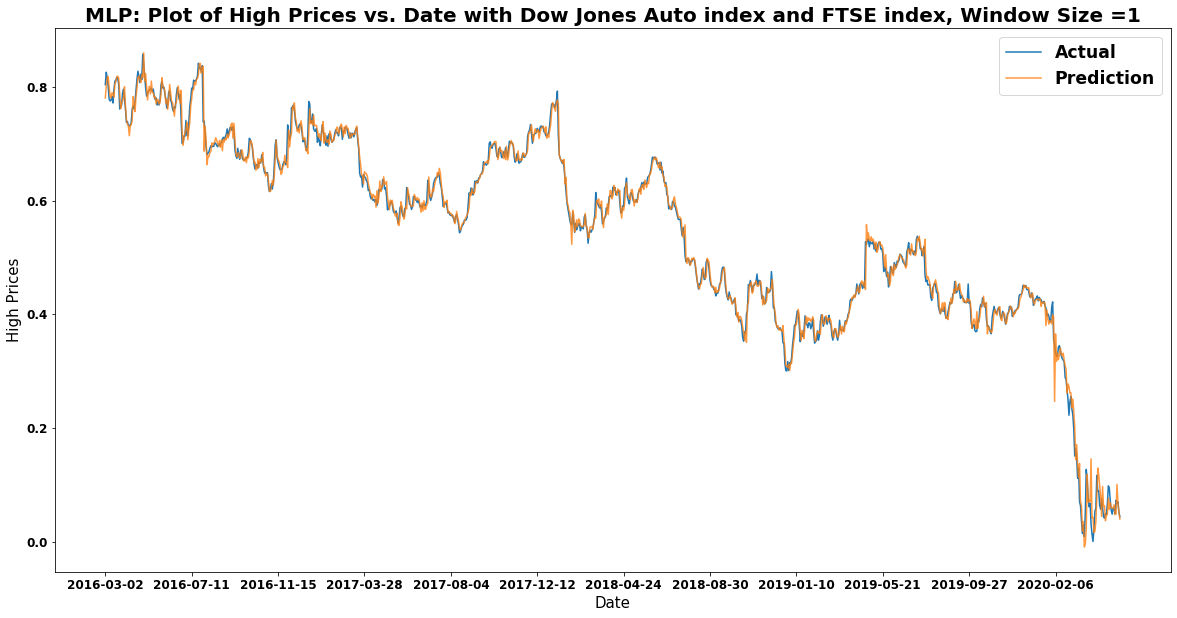

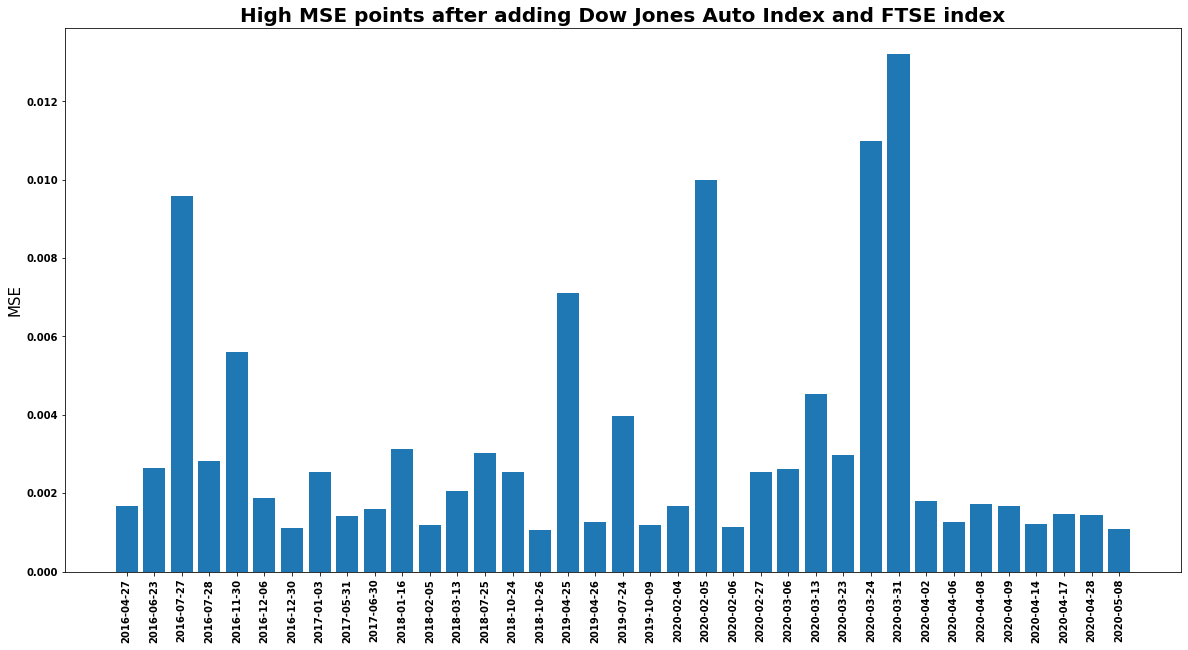

In [308]:
def evaluate_model(y_predicted,y_actual,dates):

    plt.figure(figsize=(20,10))
    plt.title('MLP: Plot of High Prices vs. Date with Dow Jones Auto index and FTSE index, Window Size =1',fontsize=20,fontweight='bold')
    plt.xlabel('Date',fontsize=15)
    plt.ylabel('High Prices',fontsize=15)
    plt.plot((y_actual.reshape(-1,1)), label="Actual")#,color='red')
    plt.plot(y_predicted.reshape(-1,1), label="Prediction", alpha=0.8)#,color ='black')
    index = np.arange((len(y_predicted)-1),step=90)
    plt.xticks(index,dates[index],fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize="xx-large")
    plt.savefig("LSTM.pdf")

 
#Rescaling the high values from range 0-1 to original values:
actual= scaler.inverse_transform(np.array(actual_high).reshape(-1,1))
predicted = scaler.inverse_transform(np.array(predicted_high).reshape(-1,1))
evaluate_model(predicted,actual,np.array(predicted_dates))

print("time taken for execution : %s seconds " % (time_taken))
print('Mean Validation loss=', round(mean(model_val_loss),8)) 
print('Mean Model loss=', round(mean(model_loss),8))


large_loss = []
large_loss_date = [] 
#print(f"{'index':10} {'val_loss':10} {'Date':12} {'Predicted High Value':10} {'Actual High Value':25}")     
for index in range(0,len(model_val_loss)):
    val_loss = model_val_loss[index]
    if val_loss>0.001:
        #print(f'{index:5} {val_loss:12f} {predicted_dates[index]:20} {predicted[index][0]:10f} {actual[index][0]:15f}')
        large_loss.append(val_loss)
        large_loss_date.append(predicted_dates[index])


plt.rcParams["font.weight"] = "bold"
plt.figure(figsize=(20,10))
plt.title('High MSE points after adding Dow Jones Auto Index and FTSE index',fontsize=20,fontweight='bold')
plt.ylabel('MSE',fontsize=15)
idx = np.arange(len(large_loss_date))
plt.xticks(idx,large_loss_date,rotation=90)
plt.bar(idx, large_loss, align='center', alpha=1)

# 2. CNN Model

In [310]:
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
import matplotlib.pyplot as plt
%matplotlib inline

file_path = 'daily_mlp_model_weights.h5'
    
callback_checkpoint = ModelCheckpoint(filepath=file_path,
                                      monitor='val_loss',
                                      save_best_only=True,
                                      save_weights_only=True)
    
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
    
#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3,patience=5, min_lr=0.0009)
    
callbacks = [early_stopping, callback_checkpoint]#, reduce_lr]

Xarr = Xarr.reshape((Xarr.shape[0], Xarr.shape[1], 1))
# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(8, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [311]:
#CNN Model window size =1:
import time
from itertools import chain
start_time = time.time()

predicted_high = []
actual_high = []
predicted_dates = []
window = 200
model_loss = []
model_val_loss =[]

for trn in range(0,trn_size-window):
    X_train,X_test,y_train,y_test,Date_train,Date_test = build_data(trn,pw=1,window_size = window)
    print(trn)
    
    history = model.fit(X_train, y_train,verbose = 0, epochs=200,
                        validation_data=(X_test, y_test), callbacks=callbacks, 
                        shuffle=False)
    yhat = model.predict(X_test, verbose=0)
    yhat = list(chain.from_iterable(yhat)) 
    if len(predicted_high) == 0:
        predicted_high = yhat
        predicted_dates = Date_test.tolist()
        actual_high = y_test.tolist()
        model_loss.append(history.history['loss'][-1])
        model_val_loss.append(history.history['val_loss'][-1])
        
        
    else:
        beg=len(predicted_high)-len(yhat)+1
        yhat_idx = 0
        for pred_idx in range(beg,len(predicted_high)):
            predicted_high[pred_idx]= (predicted_high[pred_idx] + yhat[yhat_idx])/2
            yhat_idx+=1
        predicted_high.append(yhat[-1])
        actual_high.append(y_test[-1])
        predicted_dates.append(Date_test.tolist()[-1])
        model_loss.append(history.history['loss'][-1])
        model_val_loss.append(history.history['val_loss'][-1])
    
    
time_taken = time.time() - start_time
print(predicted_dates[0:5])
print(predicted_high[0:5])
print(actual_high[0:5])

0
Epoch 00021: early stopping
1
2
Epoch 00012: early stopping
3
Epoch 00012: early stopping
4
Epoch 00011: early stopping
5
Epoch 00011: early stopping
6
Epoch 00011: early stopping
7
Epoch 00011: early stopping
8
Epoch 00011: early stopping
9
Epoch 00013: early stopping
10
Epoch 00012: early stopping
11
Epoch 00011: early stopping
12
Epoch 00014: early stopping
13
Epoch 00013: early stopping
14
Epoch 00012: early stopping
15
Epoch 00012: early stopping
16
Epoch 00021: early stopping
17
Epoch 00017: early stopping
18
Epoch 00016: early stopping
19
Epoch 00012: early stopping
20
Epoch 00017: early stopping
21
Epoch 00013: early stopping
22
Epoch 00013: early stopping
23
Epoch 00023: early stopping
24
Epoch 00022: early stopping
25
Epoch 00025: early stopping
26
Epoch 00015: early stopping
27
Epoch 00026: early stopping
28
Epoch 00039: early stopping
29
Epoch 00014: early stopping
30
Epoch 00011: early stopping
31
Epoch 00011: early stopping
32
Epoch 00015: early stopping
33
Epoch 00017:

Epoch 00022: early stopping
264
Epoch 00011: early stopping
265
Epoch 00018: early stopping
266
Epoch 00018: early stopping
267
Epoch 00012: early stopping
268
Epoch 00054: early stopping
269
Epoch 00016: early stopping
270
Epoch 00014: early stopping
271
Epoch 00011: early stopping
272
Epoch 00024: early stopping
273
Epoch 00012: early stopping
274
Epoch 00011: early stopping
275
Epoch 00011: early stopping
276
Epoch 00023: early stopping
277
Epoch 00022: early stopping
278
Epoch 00013: early stopping
279
Epoch 00021: early stopping
280
Epoch 00012: early stopping
281
Epoch 00012: early stopping
282
Epoch 00039: early stopping
283
Epoch 00015: early stopping
284
Epoch 00016: early stopping
285
Epoch 00011: early stopping
286
Epoch 00014: early stopping
287
Epoch 00012: early stopping
288
Epoch 00014: early stopping
289
Epoch 00014: early stopping
290
Epoch 00021: early stopping
291
Epoch 00011: early stopping
292
Epoch 00014: early stopping
293
Epoch 00011: early stopping
294
Epoch 00

Epoch 00015: early stopping
521
Epoch 00015: early stopping
522
Epoch 00049: early stopping
523
Epoch 00014: early stopping
524
Epoch 00013: early stopping
525
Epoch 00034: early stopping
526
Epoch 00014: early stopping
527
Epoch 00011: early stopping
528
Epoch 00037: early stopping
529
Epoch 00011: early stopping
530
Epoch 00014: early stopping
531
Epoch 00012: early stopping
532
Epoch 00011: early stopping
533
Epoch 00027: early stopping
534
Epoch 00016: early stopping
535
Epoch 00020: early stopping
536
Epoch 00032: early stopping
537
Epoch 00012: early stopping
538
Epoch 00011: early stopping
539
Epoch 00036: early stopping
540
Epoch 00013: early stopping
541
Epoch 00012: early stopping
542
Epoch 00011: early stopping
543
Epoch 00042: early stopping
544
Epoch 00019: early stopping
545
Epoch 00013: early stopping
546
Epoch 00012: early stopping
547
Epoch 00014: early stopping
548
Epoch 00014: early stopping
549
Epoch 00042: early stopping
550
Epoch 00011: early stopping
551
Epoch 00

Epoch 00014: early stopping
780
Epoch 00011: early stopping
781
Epoch 00013: early stopping
782
Epoch 00014: early stopping
783
Epoch 00048: early stopping
784
Epoch 00012: early stopping
785
Epoch 00015: early stopping
786
Epoch 00013: early stopping
787
Epoch 00039: early stopping
788
Epoch 00013: early stopping
789
Epoch 00011: early stopping
790
Epoch 00014: early stopping
791
Epoch 00014: early stopping
792
Epoch 00014: early stopping
793
Epoch 00029: early stopping
794
Epoch 00019: early stopping
795
Epoch 00012: early stopping
796
Epoch 00023: early stopping
797
Epoch 00017: early stopping
798
Epoch 00013: early stopping
799
Epoch 00095: early stopping
800
Epoch 00019: early stopping
801
Epoch 00014: early stopping
802
Epoch 00012: early stopping
803
Epoch 00016: early stopping
804
Epoch 00012: early stopping
805
Epoch 00014: early stopping
806
Epoch 00012: early stopping
807
Epoch 00012: early stopping
808
Epoch 00014: early stopping
809
Epoch 00015: early stopping
810
Epoch 00

Epoch 00012: early stopping
1037
Epoch 00060: early stopping
1038
Epoch 00014: early stopping
1039
Epoch 00017: early stopping
1040
Epoch 00018: early stopping
1041
Epoch 00016: early stopping
1042
Epoch 00018: early stopping
1043
Epoch 00012: early stopping
1044
Epoch 00012: early stopping
1045
Epoch 00015: early stopping
1046
Epoch 00011: early stopping
1047
Epoch 00012: early stopping
1048
Epoch 00012: early stopping
1049
Epoch 00012: early stopping
1050
Epoch 00013: early stopping
1051
Epoch 00017: early stopping
1052
Epoch 00019: early stopping
1053
Epoch 00024: early stopping
1054
Epoch 00050: early stopping
1055
Epoch 00011: early stopping
1056
Epoch 00014: early stopping
1057
Epoch 00024: early stopping
['2016-03-02', '2016-03-03', '2016-03-04', '2016-03-07', '2016-03-08']
[0.7919347, 0.8129007, 0.8217939, 0.8194934, 0.7942586]
[0.8047285464098073, 0.8266199649737302, 0.8161120840630474, 0.8021015761821366, 0.7793345008756569]


time taken for execution : 134.29374194145203 seconds 
Mean Validation loss= 0.00022035
Mean Model loss= 0.00014142


<BarContainer object of 39 artists>

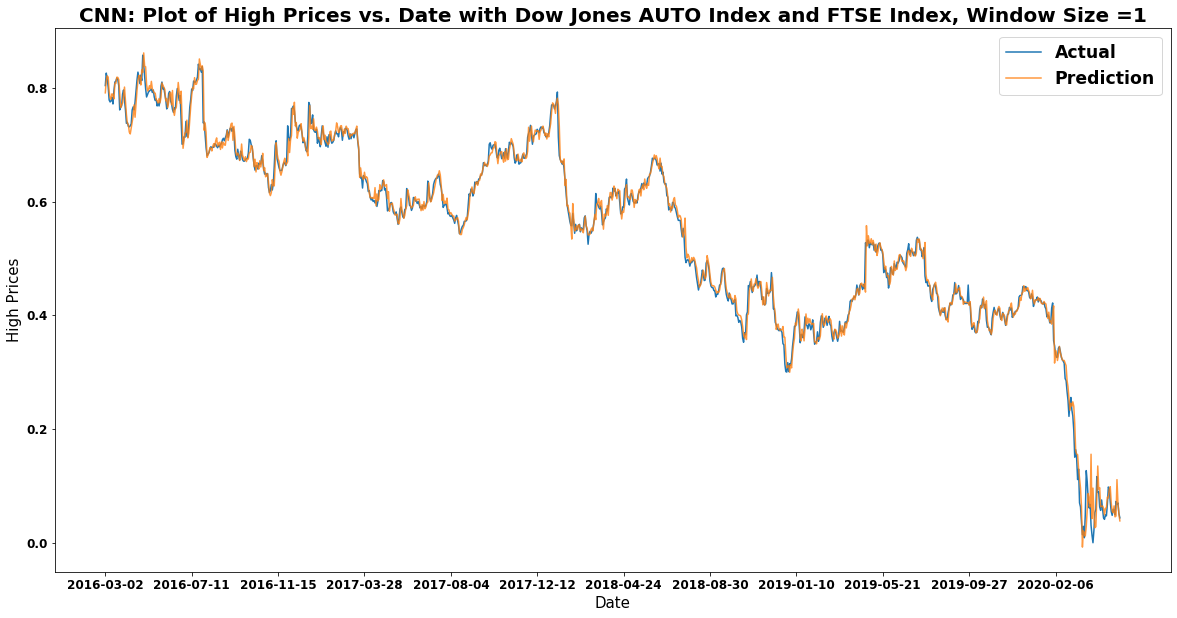

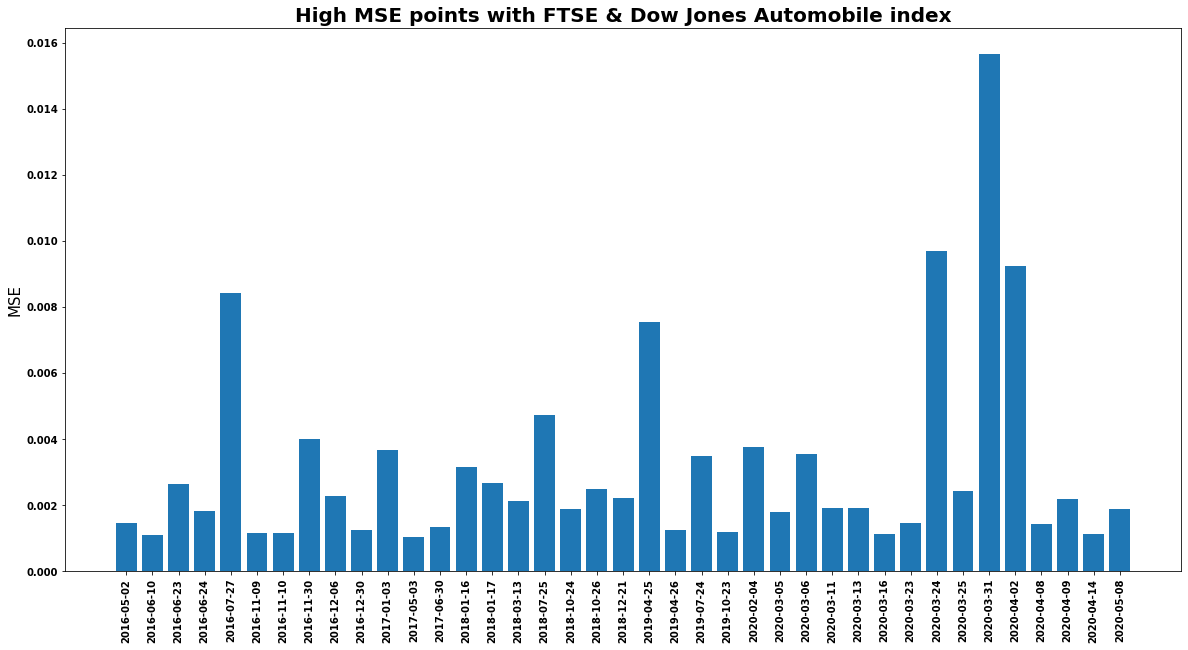

In [312]:
def evaluate_model(y_predicted,y_actual,dates):

    plt.figure(figsize=(20,10))
    plt.title('CNN: Plot of High Prices vs. Date with Dow Jones AUTO Index and FTSE Index, Window Size =1',fontsize=20,fontweight='bold')
    plt.xlabel('Date',fontsize=15)
    plt.ylabel('High Prices',fontsize=15)
    plt.plot((y_actual.reshape(-1,1)), label="Actual")#,color='red')
    plt.plot(y_predicted.reshape(-1,1), label="Prediction", alpha=0.8)#,color ='black')
    index = np.arange((len(y_predicted)-1),step=90)
    plt.xticks(index,dates[index],fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize="xx-large")

 
#Rescaling the high values from range 0-1 to original values:
actual= scaler.inverse_transform(np.array(actual_high).reshape(-1,1))
predicted = scaler.inverse_transform(np.array(predicted_high).reshape(-1,1))
evaluate_model(predicted,actual,np.array(predicted_dates))

print("time taken for execution : %s seconds " % (time_taken))
print('Mean Validation loss=', round(mean(model_val_loss),8)) 
print('Mean Model loss=', round(mean(model_loss),8))


large_loss = []
large_loss_date = [] 
#print(f"{'index':10} {'val_loss':10} {'Date':12} {'Predicted High Value':10} {'Actual High Value':25}")     
for index in range(0,len(model_val_loss)):
    val_loss = model_val_loss[index]
    if val_loss>0.001:
        #print(f'{index:5} {val_loss:12f} {predicted_dates[index]:20} {predicted[index][0]:10f} {actual[index][0]:15f}')
        large_loss.append(val_loss)
        large_loss_date.append(predicted_dates[index])


plt.rcParams["font.weight"] = "bold"
plt.figure(figsize=(20,10))
plt.title('High MSE points with FTSE & Dow Jones Automobile index',fontsize=20,fontweight='bold')
plt.ylabel('MSE',fontsize=15)
idx = np.arange(len(large_loss_date))
plt.xticks(idx,large_loss_date,rotation=90)
plt.bar(idx, large_loss, align='center', alpha=1)

# 3. LSTM

In [313]:
file_path = 'daily_mlp_model_weights.h5'
    
callback_checkpoint = ModelCheckpoint(filepath=file_path,
                                      monitor='val_loss',
                                      save_best_only=True,
                                      save_weights_only=True)
    
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
    
#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3,patience=5, min_lr=0.0009)
    
callbacks = [early_stopping, callback_checkpoint]#, reduce_lr]
adam = Adam(lr=0.003)
model = Sequential()
model.add(LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(16))
model.add(Dense(1))
model.compile(loss='mse', optimizer=adam)

In [314]:
#window size =1:
import time
from itertools import chain
start_time = time.time()

predicted_high = []
actual_high = []
predicted_dates = []
window = 200
model_loss = []
model_val_loss =[]

for trn in range(0,trn_size-window):
    X_train,X_test,y_train,y_test,Date_train,Date_test = build_data(trn,pw=1,window_size = window)
    print(trn)
    
    history = model.fit(X_train, y_train,verbose = 0, epochs=200,
                        validation_data=(X_test, y_test), callbacks=callbacks, 
                        shuffle=False)
    yhat = model.predict(X_test, verbose=0)
    yhat = list(chain.from_iterable(yhat)) 
    if len(predicted_high) == 0:
        predicted_high = yhat
        predicted_dates = Date_test.tolist()
        actual_high = y_test.tolist()
        model_loss.append(history.history['loss'][-1])
        model_val_loss.append(history.history['val_loss'][-1])
        
        
    else:
        beg=len(predicted_high)-len(yhat)+1
        yhat_idx = 0
        for pred_idx in range(beg,len(predicted_high)):
            predicted_high[pred_idx]= (predicted_high[pred_idx] + yhat[yhat_idx])/2
            yhat_idx+=1
        predicted_high.append(yhat[-1])
        actual_high.append(y_test[-1])
        predicted_dates.append(Date_test.tolist()[-1])
        model_loss.append(history.history['loss'][-1])
        model_val_loss.append(history.history['val_loss'][-1])
    

0
Epoch 00021: early stopping
1
Epoch 00012: early stopping
2
Epoch 00022: early stopping
3
Epoch 00013: early stopping
4
Epoch 00011: early stopping
5
Epoch 00011: early stopping
6
Epoch 00012: early stopping
7
Epoch 00011: early stopping
8
Epoch 00016: early stopping
9
Epoch 00022: early stopping
10
Epoch 00022: early stopping
11
Epoch 00029: early stopping
12
Epoch 00014: early stopping
13
Epoch 00018: early stopping
14
Epoch 00019: early stopping
15
Epoch 00019: early stopping
16
Epoch 00020: early stopping
17
Epoch 00011: early stopping
18
Epoch 00020: early stopping
19
Epoch 00013: early stopping
20
Epoch 00022: early stopping
21
Epoch 00012: early stopping
22
Epoch 00013: early stopping
23
Epoch 00018: early stopping
24
Epoch 00033: early stopping
25
Epoch 00020: early stopping
26
Epoch 00011: early stopping
27
Epoch 00011: early stopping
28
Epoch 00035: early stopping
29
Epoch 00012: early stopping
30
Epoch 00022: early stopping
31
Epoch 00050: early stopping
32
Epoch 00014: ea

Epoch 00036: early stopping
261
Epoch 00017: early stopping
262
Epoch 00040: early stopping
263
Epoch 00012: early stopping
264
Epoch 00015: early stopping
265
Epoch 00033: early stopping
266
Epoch 00015: early stopping
267
Epoch 00015: early stopping
268
Epoch 00051: early stopping
269
Epoch 00012: early stopping
270
Epoch 00035: early stopping
271
Epoch 00013: early stopping
272
Epoch 00020: early stopping
273
Epoch 00017: early stopping
274
Epoch 00040: early stopping
275
Epoch 00040: early stopping
276
Epoch 00017: early stopping
277
Epoch 00015: early stopping
278
Epoch 00027: early stopping
279
Epoch 00013: early stopping
280
Epoch 00033: early stopping
281
Epoch 00015: early stopping
282
Epoch 00037: early stopping
283
Epoch 00013: early stopping
284
Epoch 00037: early stopping
285
Epoch 00019: early stopping
286
Epoch 00013: early stopping
287
Epoch 00029: early stopping
288
Epoch 00018: early stopping
289
Epoch 00012: early stopping
290
Epoch 00013: early stopping
291
Epoch 00

Epoch 00016: early stopping
518
Epoch 00038: early stopping
519
Epoch 00011: early stopping
520
Epoch 00030: early stopping
521
Epoch 00013: early stopping
522
Epoch 00014: early stopping
523
Epoch 00011: early stopping
524
Epoch 00038: early stopping
525
Epoch 00016: early stopping
526
Epoch 00034: early stopping
527
Epoch 00011: early stopping
528
Epoch 00036: early stopping
529
Epoch 00039: early stopping
530
Epoch 00011: early stopping
531
Epoch 00015: early stopping
532
Epoch 00014: early stopping
533
Epoch 00012: early stopping
534
Epoch 00018: early stopping
535
Epoch 00023: early stopping
536
Epoch 00019: early stopping
537
Epoch 00026: early stopping
538
Epoch 00018: early stopping
539
Epoch 00032: early stopping
540
Epoch 00025: early stopping
541
Epoch 00013: early stopping
542
Epoch 00025: early stopping
543
Epoch 00025: early stopping
544
Epoch 00012: early stopping
545
Epoch 00018: early stopping
546
Epoch 00031: early stopping
547
Epoch 00011: early stopping
548
Epoch 00

Epoch 00022: early stopping
775
Epoch 00022: early stopping
776
Epoch 00019: early stopping
777
Epoch 00011: early stopping
778
Epoch 00012: early stopping
779
Epoch 00032: early stopping
780
Epoch 00024: early stopping
781
Epoch 00013: early stopping
782
Epoch 00024: early stopping
783
Epoch 00021: early stopping
784
Epoch 00022: early stopping
785
Epoch 00013: early stopping
786
Epoch 00030: early stopping
787
Epoch 00012: early stopping
788
Epoch 00028: early stopping
789
Epoch 00015: early stopping
790
Epoch 00037: early stopping
791
Epoch 00014: early stopping
792
Epoch 00019: early stopping
793
Epoch 00014: early stopping
794
Epoch 00013: early stopping
795
Epoch 00019: early stopping
796
Epoch 00016: early stopping
797
Epoch 00011: early stopping
798
Epoch 00013: early stopping
799
Epoch 00017: early stopping
800
Epoch 00018: early stopping
801
Epoch 00026: early stopping
802
Epoch 00019: early stopping
803
Epoch 00023: early stopping
804
Epoch 00021: early stopping
805
Epoch 00

Epoch 00014: early stopping
1031
Epoch 00011: early stopping
1032
Epoch 00022: early stopping
1033
Epoch 00016: early stopping
1034
Epoch 00041: early stopping
1035
Epoch 00011: early stopping
1036
Epoch 00012: early stopping
1037
Epoch 00054: early stopping
1038
Epoch 00011: early stopping
1039
Epoch 00013: early stopping
1040
Epoch 00012: early stopping
1041
Epoch 00012: early stopping
1042
Epoch 00012: early stopping
1043
Epoch 00020: early stopping
1044
Epoch 00011: early stopping
1045
Epoch 00030: early stopping
1046
Epoch 00038: early stopping
1047
Epoch 00011: early stopping
1048
Epoch 00016: early stopping
1049
Epoch 00012: early stopping
1050
Epoch 00011: early stopping
1051
Epoch 00016: early stopping
1052
Epoch 00044: early stopping
1053
Epoch 00019: early stopping
1054
Epoch 00012: early stopping
1055
Epoch 00012: early stopping
1056
Epoch 00031: early stopping
1057
Epoch 00026: early stopping


time taken for execution : 134.29374194145203 seconds 
Mean Validation loss= 0.00026282
Mean Model loss= 0.00015609


<BarContainer object of 58 artists>

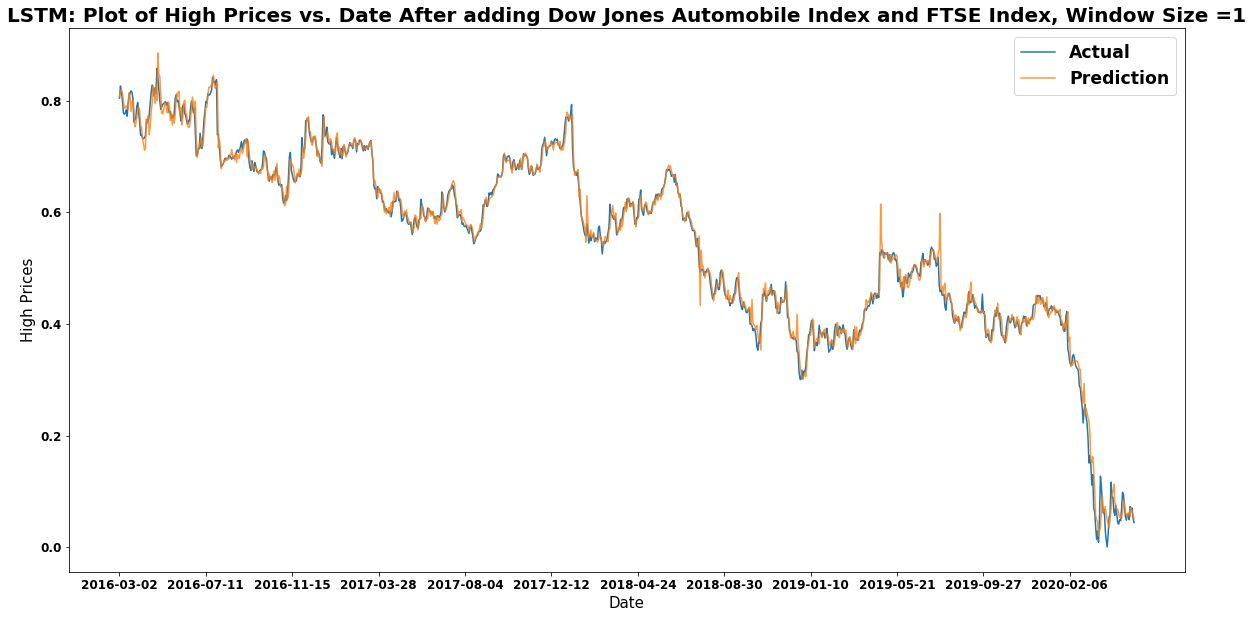

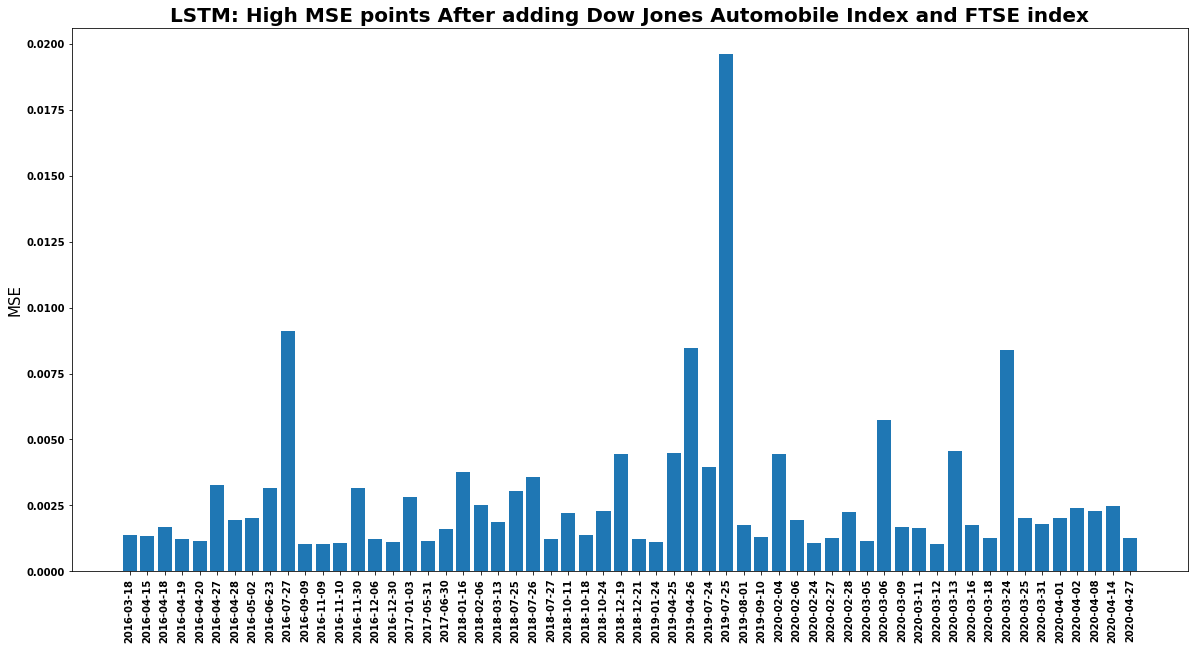

In [316]:
def evaluate_model(y_predicted,y_actual,dates):

    plt.figure(figsize=(20,10))
    plt.title('LSTM: Plot of High Prices vs. Date After adding Dow Jones Automobile Index and FTSE Index, Window Size =1',fontsize=20,fontweight='bold')
    plt.xlabel('Date',fontsize=15)
    plt.ylabel('High Prices',fontsize=15)
    plt.plot((y_actual.reshape(-1,1)), label="Actual")#,color='red')
    plt.plot(y_predicted.reshape(-1,1), label="Prediction", alpha=0.8)#,color ='black')
    index = np.arange((len(y_predicted)-1),step=90)
    plt.xticks(index,dates[index],fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize="xx-large")
    plt.savefig("LSTM.pdf")

 
#Rescaling the high values from range 0-1 to original values:
actual= scaler.inverse_transform(np.array(actual_high).reshape(-1,1))
predicted = scaler.inverse_transform(np.array(predicted_high).reshape(-1,1))
evaluate_model(predicted,actual,np.array(predicted_dates))

print("time taken for execution : %s seconds " % (time_taken))
print('Mean Validation loss=', round(mean(model_val_loss),8)) 
print('Mean Model loss=', round(mean(model_loss),8))


large_loss = []
large_loss_date = [] 
#print(f"{'index':10} {'val_loss':10} {'Date':12} {'Predicted High Value':10} {'Actual High Value':25}")     
for index in range(0,len(model_val_loss)):
    val_loss = model_val_loss[index]
    if val_loss>0.001:
        #print(f'{index:5} {val_loss:12f} {predicted_dates[index]:20} {predicted[index][0]:10f} {actual[index][0]:15f}')
        large_loss.append(val_loss)
        large_loss_date.append(predicted_dates[index])


plt.rcParams["font.weight"] = "bold"
plt.figure(figsize=(20,10))
plt.title('LSTM: High MSE points After adding Dow Jones Automobile Index and FTSE index',fontsize=20,fontweight='bold')
plt.ylabel('MSE',fontsize=15)
idx = np.arange(len(large_loss_date))
plt.xticks(idx,large_loss_date,rotation=90)
plt.bar(idx, large_loss, align='center', alpha=1)

# Sales Data:

In [116]:
ford_sales = pd.read_csv('/Users/aleenaalex/Documents/UCC projects/data/fordsales.csv', header=0, index_col=None)
#ford_sales = pd.DataFrame(ford_sales.index)[1:]
#ford_sales.set_index('Month',inplace=True)
#ford_sales['2020-04'] = 102447
#ford_sales.loc[59,'Sales']= 102447
#GM = 141,874
#ford_sales.loc[60,'Sales']= 145484
#GM = 190,125
ford_sales

Month   Sales
0   2015-05  250077
1   2015-06  224671
2   2015-07  222009
3   2015-08  233879
4   2015-09  221261
..      ...     ...
56  2020-01  167146
57  2020-02  216395
58  2020-03  131072
59  2020-04  102447
60  2020-05  145484

[61 rows x 2 columns]

#Convert Date Format:
Month_dict={'Jan':'01','Feb':'02','Mar':'03','Apr':'04','May':'05','Jun':'06',
       'Jul':'07','Aug':'08','Sep':'09','Oct':'10','Nov':'11','Dec':'12'}
fs = []
fs = list(ford_sales.index)
fs1 = pd.DataFrame()
newdt = []
newsls = []
for idx in range(0,2): 
    sale = fs[idx]
    dt,sls=sale.split(',"')
    newdt.append('20'+dt[4:6]+'-'+Month_dict[dt[0:3]])
    newsls.append(sls.strip('"').replace(',', ''))

for idx in range(2,4): 
    sale = fs[idx]
    dt,sls=sale.split(',')
    newdt.append('20'+dt[4:6]+'-'+Month_dict[dt[0:3]])
    newsls.append(sls)

for idx in range(4,len(fs)): 
    sale = fs[idx]
    dt,sls=sale.split(',"')
    newdt.append('20'+dt[4:6]+'-'+Month_dict[dt[0:3]])
    newsls.append(sls.strip('"').replace(',', ''))
  #day,month,year = date[4:6],Month_dict[date[0:3]],date[7:11]
   #newDates.append(year+'-'+month+'-'+day)
fs1.insert(0, "Month", newdt)
fs1.insert(1, "Sales", newsls)


ford_sales.to_csv('/Users/aleenaalex/Documents/UCC projects/data/fordsales.csv', encoding='utf-8',index=False)

In [165]:
#merge values:
ford_dates = list(ford.index)
sales_dates = list(ford_sales['Month'])
ford["sales"] = 0

for row_num in range(0,len(ford_dates)):
    date = ford_dates[row_num][0:7] 
    
    if date in sales_dates:
        ford["sales"][row_num] = ford_sales['Sales'][ford_sales['Month']==date]
        
print(ford)


/Users/aleenaalex/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


             Open   High    Low  Close  Adj Close     Volume   sales
Date                                                                
2015-05-15  15.27  15.49  15.27  15.48  11.977631   18937700  250077
2015-05-18  15.47  15.64  15.45  15.58  12.055005   19491900  250077
2015-05-19  15.59  15.63  15.45  15.50  11.993106   15145300  250077
2015-05-20  15.54  15.56  15.26  15.30  11.838357   22391500  250077
2015-05-21  15.28  15.55  15.26  15.51  12.000844   23962000  250077
...           ...    ...    ...    ...        ...        ...     ...
2020-05-08   4.96   5.25   4.95   5.24   5.240000  101333800  145484
2020-05-11   5.18   5.19   5.05   5.12   5.120000   75593900  145484
2020-05-12   5.15   5.22   4.97   4.98   4.980000   70965200  145484
2020-05-13   5.00   5.01   4.66   4.72   4.720000  100192300  145484
2020-05-14   4.64   4.92   4.52   4.89   4.890000  107931900  145484

[1259 rows x 7 columns]


In [166]:
def normalize(data):
    
    scaler_open = MinMaxScaler()
    scaler_high = MinMaxScaler()
    scaler_low = MinMaxScaler()
    scaler_close = MinMaxScaler()
    scaler_adjclose = MinMaxScaler()
    scaler_volume = MinMaxScaler()
    scaler_sales = MinMaxScaler()
    
    #Open:
    fit = scaler_open.fit(np.array(data['Open']).reshape(-1, 1))
    data['Open'] =scaler_open.transform(np.array(dataframe_ford['Open']).reshape(-1, 1))
    
    #High:
    fit = scaler_high.fit(np.array(data['High']).reshape(-1, 1))
    data['High'] =scaler_high.transform(np.array(data['High']).reshape(-1, 1))
    
    #Low:
    fit = scaler_low.fit(np.array(data['Low']).reshape(-1, 1))
    data['Low'] =scaler_low.transform(np.array(data['Low']).reshape(-1, 1))
    
    #Close:
    fit = scaler_close.fit(np.array(data['Close']).reshape(-1, 1))
    data['Close'] =scaler_close.transform(np.array(data['Close']).reshape(-1, 1))
    
    #AdjClose:
    fit = scaler_adjclose.fit(np.array(data['Adj Close']).reshape(-1, 1))
    data['Adj Close'] =scaler_adjclose.transform(np.array(data['Adj Close']).reshape(-1, 1))
    
    #High:
    fit = scaler_volume.fit(np.array(data['Volume']).reshape(-1, 1))
    data['Volume'] =scaler_volume.transform(np.array(data['Volume']).reshape(-1, 1))
    
    #Dow:
    fit = scaler_sales.fit(np.array(data['sales']).reshape(-1, 1))
    data['sales'] =scaler_sales.transform(np.array(data['sales']).reshape(-1, 1))
    
    return data,scaler_high

df = ford
dataframe_ford = df
df,scaler = normalize(df)

#convert data: form X and y data:
Xarr = df.rename_axis('ID').values
Xarr = Xarr[0:1258]
Datearr = df.index.values

df1 = df[['High']]
yarr = df1.rename_axis('ID').values

print('Xarr:',Xarr[0:5])
print('yarr:',yarr[0:5])
print('Datearr:',Datearr[0:5])

yarr = np.delete(yarr, 0)
print('yarr:',yarr[0:5])
print('X shape:',Xarr.shape)
print('y shape:',yarr.shape)

def build_data(start,pw,window_size=200):
    
    X_train,X_test = Xarr[start:start+window_size],Xarr[start+window_size:start+window_size+pw]
    y_train,y_test = yarr[start:start+window_size],yarr[start+window_size:start+window_size+pw]
    Date_train,Date_test = Datearr[start:start+window_size],Datearr[start+window_size:start+window_size+pw]
    return X_train,X_test,y_train,y_test,Date_train,Date_test

trn_size = len(Xarr)

from numpy import array
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline
    
file_path = 'daily_mlp_model_weights.h5'
    
callback_checkpoint = ModelCheckpoint(filepath=file_path,
                                      monitor='val_loss',
                                      save_best_only=True,
                                      save_weights_only=True)
    
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
    
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3,
                              patience=5, min_lr=0.0009)
    
callbacks = [early_stopping, callback_checkpoint, reduce_lr]
    
tf.keras.backend.clear_session()
    
model_mlp = tf.keras.models.Sequential()
    
model_mlp.add(tf.keras.layers.Reshape((7,),input_shape=(7,)))
    
model_mlp.add(tf.keras.layers.Dense(200,activation='relu'))
    
model_mlp.add(tf.keras.layers.Dense(1,activation='linear'))
    
model_mlp.compile(optimizer='adam',loss='mse',metrics=['accuracy'])
    

Xarr: [[0.95986038 0.96935201 0.97416021 0.98286204 0.96620093 0.04988881
  0.98016824]
 [0.97731239 0.98248687 0.98966408 0.99143102 0.97558374 0.05236248
  0.98016824]
 [0.9877836  0.98161121 0.98966408 0.98457584 0.96807751 0.0329615
  0.98016824]
 [0.98342059 0.97548161 0.97329888 0.96743787 0.94931176 0.0653048
  0.98016824]
 [0.96073298 0.97460595 0.97329888 0.98543273 0.96901587 0.0723147
  0.98016824]]
yarr: [[0.96935201]
 [0.98248687]
 [0.98161121]
 [0.97548161]
 [0.97460595]]
Datearr: ['2015-05-15' '2015-05-18' '2015-05-19' '2015-05-20' '2015-05-21']
yarr: [0.98248687 0.98161121 0.97548161 0.97460595 0.97022767]
X shape: (1258, 7)
y shape: (1258,)


In [167]:
import time
from itertools import chain
start_time = time.time()

predicted_high = []
actual_high = []
predicted_dates = []
window = 200
model_loss = []
model_val_loss =[]

for trn in range(0,trn_size-window):
    X_train,X_test,y_train,y_test,Date_train,Date_test = build_data(trn,pw=1,window_size = window)
    print(trn)
    
    history = model_mlp.fit(X_train, y_train,verbose = 0, epochs=200,
                        validation_data=(X_test, y_test), callbacks=callbacks, 
                        shuffle=False)
    yhat = model_mlp.predict(X_test, verbose=0)
    yhat = list(chain.from_iterable(yhat)) 
    if len(predicted_high) == 0:
        predicted_high = yhat
        predicted_dates = Date_test.tolist()
        actual_high = y_test.tolist()
        model_loss.append(history.history['loss'][-1])
        model_val_loss.append(history.history['val_loss'][-1])
        
        
    else:
        beg=len(predicted_high)-len(yhat)+1
        yhat_idx = 0
        for pred_idx in range(beg,len(predicted_high)):
            predicted_high[pred_idx]= (predicted_high[pred_idx] + yhat[yhat_idx])/2
            yhat_idx+=1
        predicted_high.append(yhat[-1])
        actual_high.append(y_test[-1])
        predicted_dates.append(Date_test.tolist()[-1])
        model_loss.append(history.history['loss'][-1])
        model_val_loss.append(history.history['val_loss'][-1])
    
    
time_taken = time.time() - start_time
print(predicted_dates[0:5])
print(predicted_high[0:5])
print(actual_high[0:5])

0
Epoch 00027: early stopping
1
Epoch 00011: early stopping
2
Epoch 00156: early stopping
3
Epoch 00013: early stopping
4
5
6
Epoch 00017: early stopping
7
Epoch 00015: early stopping
8
Epoch 00013: early stopping
9
Epoch 00023: early stopping
10
Epoch 00012: early stopping
11
Epoch 00029: early stopping
12
Epoch 00052: early stopping
13
Epoch 00011: early stopping
14
Epoch 00026: early stopping
15
Epoch 00036: early stopping
16
Epoch 00024: early stopping
17
Epoch 00021: early stopping
18
Epoch 00014: early stopping
19
Epoch 00014: early stopping
20
Epoch 00031: early stopping
21
Epoch 00014: early stopping
22
Epoch 00013: early stopping
23
Epoch 00014: early stopping
24
Epoch 00020: early stopping
25
Epoch 00012: early stopping
26
Epoch 00014: early stopping
27
Epoch 00023: early stopping
28
Epoch 00022: early stopping
29
Epoch 00028: early stopping
30
Epoch 00021: early stopping
31
Epoch 00012: early stopping
32
Epoch 00038: early stopping
33
Epoch 00015: early stopping
34
Epoch 000

Epoch 00022: early stopping
263
Epoch 00014: early stopping
264
Epoch 00013: early stopping
265
Epoch 00013: early stopping
266
Epoch 00013: early stopping
267
Epoch 00011: early stopping
268
Epoch 00011: early stopping
269
Epoch 00023: early stopping
270
Epoch 00024: early stopping
271
Epoch 00017: early stopping
272
Epoch 00017: early stopping
273
Epoch 00021: early stopping
274
Epoch 00011: early stopping
275
Epoch 00011: early stopping
276
Epoch 00011: early stopping
277
Epoch 00013: early stopping
278
Epoch 00012: early stopping
279
Epoch 00011: early stopping
280
Epoch 00013: early stopping
281
Epoch 00028: early stopping
282
Epoch 00016: early stopping
283
Epoch 00021: early stopping
284
Epoch 00021: early stopping
285
Epoch 00017: early stopping
286
Epoch 00020: early stopping
287
Epoch 00026: early stopping
288
Epoch 00012: early stopping
289
Epoch 00011: early stopping
290
Epoch 00018: early stopping
291
Epoch 00018: early stopping
292
Epoch 00017: early stopping
293
Epoch 00

Epoch 00022: early stopping
520
Epoch 00027: early stopping
521
Epoch 00031: early stopping
522
Epoch 00011: early stopping
523
Epoch 00069: early stopping
524
Epoch 00012: early stopping
525
Epoch 00062: early stopping
526
Epoch 00024: early stopping
527
Epoch 00014: early stopping
528
Epoch 00015: early stopping
529
Epoch 00012: early stopping
530
Epoch 00015: early stopping
531
Epoch 00012: early stopping
532
Epoch 00017: early stopping
533
Epoch 00016: early stopping
534
Epoch 00019: early stopping
535
Epoch 00012: early stopping
536
Epoch 00019: early stopping
537
Epoch 00013: early stopping
538
Epoch 00016: early stopping
539
Epoch 00016: early stopping
540
Epoch 00019: early stopping
541
Epoch 00042: early stopping
542
Epoch 00011: early stopping
543
Epoch 00033: early stopping
544
Epoch 00026: early stopping
545
Epoch 00034: early stopping
546
Epoch 00011: early stopping
547
Epoch 00042: early stopping
548
Epoch 00014: early stopping
549
Epoch 00016: early stopping
550
Epoch 00

Epoch 00018: early stopping
778
Epoch 00013: early stopping
779
Epoch 00019: early stopping
780
Epoch 00017: early stopping
781
Epoch 00017: early stopping
782
Epoch 00022: early stopping
783
Epoch 00017: early stopping
784
Epoch 00017: early stopping
785
Epoch 00017: early stopping
786
Epoch 00028: early stopping
787
Epoch 00011: early stopping
788
Epoch 00013: early stopping
789
Epoch 00011: early stopping
790
Epoch 00013: early stopping
791
Epoch 00013: early stopping
792
Epoch 00013: early stopping
793
Epoch 00012: early stopping
794
Epoch 00016: early stopping
795
Epoch 00011: early stopping
796
Epoch 00011: early stopping
797
Epoch 00013: early stopping
798
Epoch 00013: early stopping
799
Epoch 00017: early stopping
800
Epoch 00021: early stopping
801
Epoch 00014: early stopping
802
Epoch 00022: early stopping
803
Epoch 00012: early stopping
804
Epoch 00020: early stopping
805
Epoch 00014: early stopping
806
Epoch 00011: early stopping
807
Epoch 00013: early stopping
808
Epoch 00

Epoch 00022: early stopping
1033
Epoch 00097: early stopping
1034
Epoch 00021: early stopping
1035
Epoch 00033: early stopping
1036
Epoch 00018: early stopping
1037
Epoch 00065: early stopping
1038
Epoch 00011: early stopping
1039
Epoch 00039: early stopping
1040
Epoch 00015: early stopping
1041
Epoch 00051: early stopping
1042
Epoch 00014: early stopping
1043
Epoch 00014: early stopping
1044
Epoch 00043: early stopping
1045
Epoch 00013: early stopping
1046
Epoch 00028: early stopping
1047
Epoch 00029: early stopping
1048
Epoch 00025: early stopping
1049
Epoch 00012: early stopping
1050
Epoch 00012: early stopping
1051
Epoch 00028: early stopping
1052
Epoch 00012: early stopping
1053
Epoch 00020: early stopping
1054
Epoch 00011: early stopping
1055
Epoch 00017: early stopping
1056
Epoch 00022: early stopping
1057
Epoch 00023: early stopping
['2016-03-02', '2016-03-03', '2016-03-04', '2016-03-07', '2016-03-08']
[0.8015179, 0.8224591, 0.8256417, 0.8258118, 0.796567]
[0.8047285464098073, 

time taken for execution : 284.35544991493225 seconds 
Mean Validation loss= 0.0002271
Mean Model loss= 0.00013544


<BarContainer object of 43 artists>

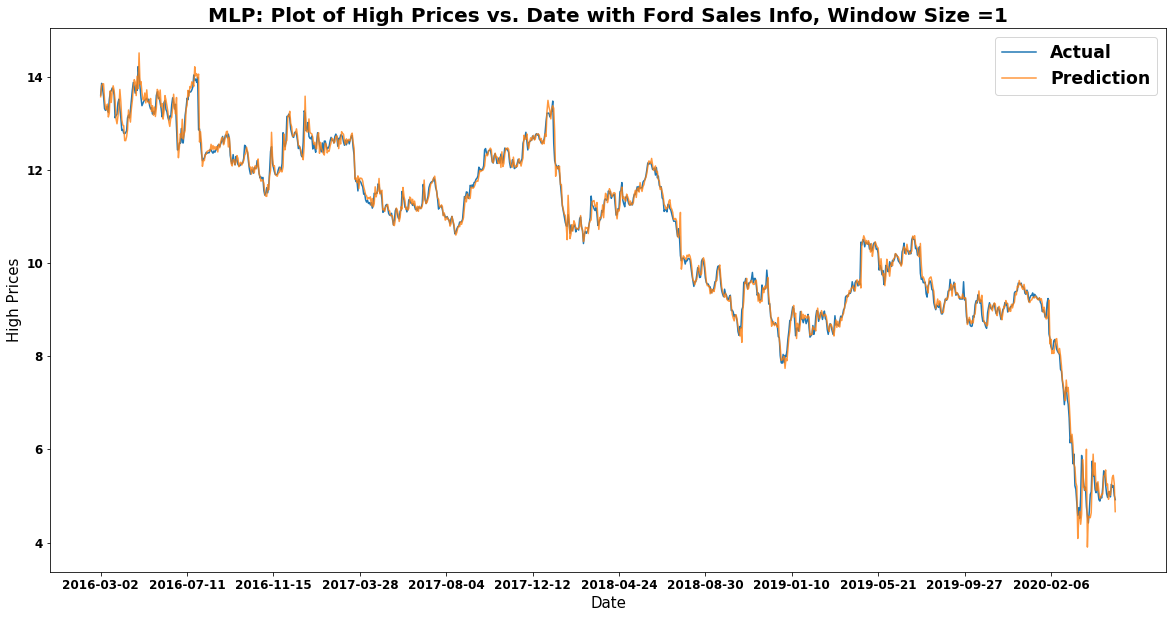

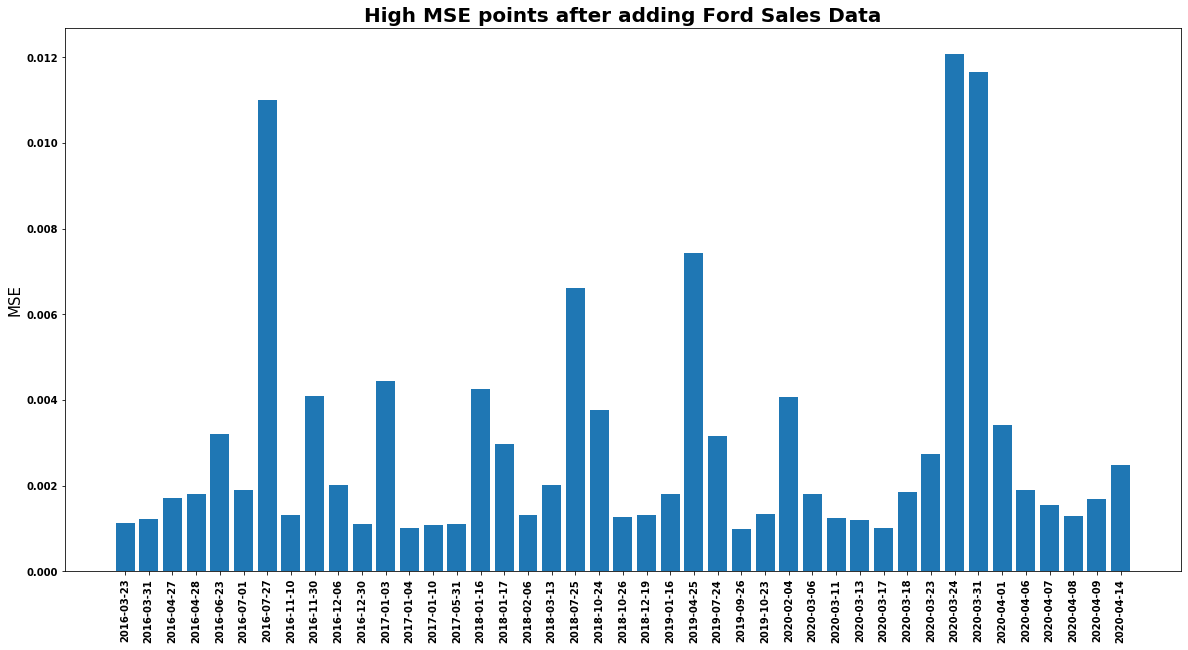

In [168]:
def evaluate_model(y_predicted,y_actual,dates):

    plt.figure(figsize=(20,10))
    plt.title('MLP: Plot of High Prices vs. Date with Ford Sales Info, Window Size =1',fontsize=20,fontweight='bold')
    plt.xlabel('Date',fontsize=15)
    plt.ylabel('High Prices',fontsize=15)
    plt.plot((y_actual.reshape(-1,1)), label="Actual")#,color='red')
    plt.plot(y_predicted.reshape(-1,1), label="Prediction", alpha=0.8)#,color ='black')
    index = np.arange((len(y_predicted)-1),step=90)
    plt.xticks(index,dates[index],fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize="xx-large")
    #plt.savefig("LSTM.pdf")

 
#Rescaling the high values from range 0-1 to original values:
actual= scaler.inverse_transform(np.array(actual_high).reshape(-1,1))
predicted = scaler.inverse_transform(np.array(predicted_high).reshape(-1,1))
evaluate_model(predicted,actual,np.array(predicted_dates))

print("time taken for execution : %s seconds " % (time_taken))
print('Mean Validation loss=', round(mean(model_val_loss),8)) 
print('Mean Model loss=', round(mean(model_loss),8))


large_loss = []
large_loss_date = [] 
#print(f"{'index':10} {'val_loss':10} {'Date':12} {'Predicted High Value':10} {'Actual High Value':25}")     
for index in range(0,len(model_val_loss)):
    val_loss = model_val_loss[index]
    if val_loss>0.001:
        #print(f'{index:5} {val_loss:12f} {predicted_dates[index]:20} {predicted[index][0]:10f} {actual[index][0]:15f}')
        large_loss.append(val_loss)
        large_loss_date.append(predicted_dates[index])


plt.rcParams["font.weight"] = "bold"
plt.figure(figsize=(20,10))
plt.title('High MSE points after adding Ford Sales Data',fontsize=20,fontweight='bold')
plt.ylabel('MSE',fontsize=15)
idx = np.arange(len(large_loss_date))
plt.xticks(idx,large_loss_date,rotation=90)
plt.bar(idx, large_loss, align='center', alpha=1)

# 2. CNN _ Ford Sales:

In [170]:
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
import matplotlib.pyplot as plt
%matplotlib inline

file_path = 'daily_mlp_model_weights.h5'
    
callback_checkpoint = ModelCheckpoint(filepath=file_path,
                                      monitor='val_loss',
                                      save_best_only=True,
                                      save_weights_only=True)
    
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
    
callbacks = [early_stopping, callback_checkpoint]#, reduce_lr]

Xarr = Xarr.reshape((Xarr.shape[0], Xarr.shape[1], 1))
# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(7, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

#CNN Model window size =1:
import time
from itertools import chain
start_time = time.time()

predicted_high = []
actual_high = []
predicted_dates = []
window = 200
model_loss = []
model_val_loss =[]

for trn in range(0,trn_size-window):
    X_train,X_test,y_train,y_test,Date_train,Date_test = build_data(trn,pw=1,window_size = window)
    print(trn)
    
    history = model.fit(X_train, y_train,verbose = 0, epochs=200,
                        validation_data=(X_test, y_test), callbacks=callbacks, 
                        shuffle=False)
    yhat = model.predict(X_test, verbose=0)
    yhat = list(chain.from_iterable(yhat)) 
    if len(predicted_high) == 0:
        predicted_high = yhat
        predicted_dates = Date_test.tolist()
        actual_high = y_test.tolist()
        model_loss.append(history.history['loss'][-1])
        model_val_loss.append(history.history['val_loss'][-1])
        
        
    else:
        beg=len(predicted_high)-len(yhat)+1
        yhat_idx = 0
        for pred_idx in range(beg,len(predicted_high)):
            predicted_high[pred_idx]= (predicted_high[pred_idx] + yhat[yhat_idx])/2
            yhat_idx+=1
        predicted_high.append(yhat[-1])
        actual_high.append(y_test[-1])
        predicted_dates.append(Date_test.tolist()[-1])
        model_loss.append(history.history['loss'][-1])
        model_val_loss.append(history.history['val_loss'][-1])
    
    
time_taken = time.time() - start_time
print(predicted_dates[0:5])
print(predicted_high[0:5])
print(actual_high[0:5])

0
Epoch 00014: early stopping
1
Epoch 00125: early stopping
2
Epoch 00168: early stopping
3
Epoch 00012: early stopping
4
Epoch 00101: early stopping
5
6
Epoch 00024: early stopping
7
Epoch 00012: early stopping
8
Epoch 00015: early stopping
9
Epoch 00014: early stopping
10
Epoch 00012: early stopping
11
Epoch 00012: early stopping
12
Epoch 00022: early stopping
13
Epoch 00012: early stopping
14
Epoch 00015: early stopping
15
Epoch 00012: early stopping
16
Epoch 00046: early stopping
17
Epoch 00013: early stopping
18
Epoch 00011: early stopping
19
Epoch 00011: early stopping
20
Epoch 00014: early stopping
21
Epoch 00011: early stopping
22
Epoch 00052: early stopping
23
Epoch 00015: early stopping
24
Epoch 00017: early stopping
25
Epoch 00014: early stopping
26
Epoch 00011: early stopping
27
Epoch 00012: early stopping
28
Epoch 00011: early stopping
29
Epoch 00015: early stopping
30
Epoch 00014: early stopping
31
Epoch 00015: early stopping
32
Epoch 00019: early stopping
33
Epoch 00059:

Epoch 00029: early stopping
262
Epoch 00028: early stopping
263
Epoch 00025: early stopping
264
Epoch 00016: early stopping
265
Epoch 00011: early stopping
266
Epoch 00052: early stopping
267
Epoch 00025: early stopping
268
Epoch 00015: early stopping
269
Epoch 00013: early stopping
270
Epoch 00013: early stopping
271
Epoch 00018: early stopping
272
Epoch 00061: early stopping
273
Epoch 00030: early stopping
274
Epoch 00030: early stopping
275
Epoch 00015: early stopping
276
Epoch 00016: early stopping
277
Epoch 00033: early stopping
278
Epoch 00020: early stopping
279
Epoch 00015: early stopping
280
Epoch 00019: early stopping
281
Epoch 00028: early stopping
282
Epoch 00030: early stopping
283
Epoch 00014: early stopping
284
Epoch 00014: early stopping
285
Epoch 00017: early stopping
286
Epoch 00016: early stopping
287
Epoch 00013: early stopping
288
Epoch 00018: early stopping
289
Epoch 00011: early stopping
290
Epoch 00011: early stopping
291
Epoch 00013: early stopping
292
Epoch 00

Epoch 00015: early stopping
521
Epoch 00011: early stopping
522
Epoch 00025: early stopping
523
Epoch 00013: early stopping
524
Epoch 00036: early stopping
525
Epoch 00016: early stopping
526
Epoch 00013: early stopping
527
Epoch 00040: early stopping
528
Epoch 00014: early stopping
529
Epoch 00011: early stopping
530
Epoch 00040: early stopping
531
Epoch 00017: early stopping
532
Epoch 00045: early stopping
533
Epoch 00014: early stopping
534
Epoch 00054: early stopping
535
Epoch 00020: early stopping
536
Epoch 00032: early stopping
537
Epoch 00012: early stopping
538
Epoch 00014: early stopping
539
Epoch 00027: early stopping
540
Epoch 00028: early stopping
541
Epoch 00012: early stopping
542
Epoch 00028: early stopping
543
Epoch 00027: early stopping
544
Epoch 00013: early stopping
545
Epoch 00013: early stopping
546
Epoch 00042: early stopping
547
Epoch 00015: early stopping
548
Epoch 00039: early stopping
549
Epoch 00011: early stopping
550
Epoch 00053: early stopping
551
Epoch 00

Epoch 00034: early stopping
778
Epoch 00011: early stopping
779
Epoch 00013: early stopping
780
Epoch 00016: early stopping
781
Epoch 00011: early stopping
782
Epoch 00021: early stopping
783
Epoch 00021: early stopping
784
Epoch 00018: early stopping
785
Epoch 00011: early stopping
786
Epoch 00013: early stopping
787
Epoch 00027: early stopping
788
Epoch 00011: early stopping
789
Epoch 00013: early stopping
790
Epoch 00012: early stopping
791
Epoch 00035: early stopping
792
Epoch 00015: early stopping
793
Epoch 00023: early stopping
794
Epoch 00015: early stopping
795
Epoch 00022: early stopping
796
Epoch 00022: early stopping
797
Epoch 00040: early stopping
798
Epoch 00022: early stopping
799
Epoch 00016: early stopping
800
Epoch 00012: early stopping
801
Epoch 00013: early stopping
802
Epoch 00059: early stopping
803
Epoch 00023: early stopping
804
Epoch 00028: early stopping
805
Epoch 00011: early stopping
806
Epoch 00011: early stopping
807
Epoch 00013: early stopping
808
Epoch 00

Epoch 00016: early stopping
1035
Epoch 00023: early stopping
1036
Epoch 00012: early stopping
1037
Epoch 00072: early stopping
1038
Epoch 00012: early stopping
1039
Epoch 00020: early stopping
1040
Epoch 00040: early stopping
1041
Epoch 00013: early stopping
1042
Epoch 00033: early stopping
1043
Epoch 00011: early stopping
1044
Epoch 00038: early stopping
1045
Epoch 00015: early stopping
1046
Epoch 00030: early stopping
1047
Epoch 00015: early stopping
1048
Epoch 00015: early stopping
1049
Epoch 00013: early stopping
1050
Epoch 00014: early stopping
1051
Epoch 00024: early stopping
1052
Epoch 00030: early stopping
1053
Epoch 00014: early stopping
1054
Epoch 00031: early stopping
1055
Epoch 00029: early stopping
1056
Epoch 00023: early stopping
1057
Epoch 00011: early stopping
['2016-03-02', '2016-03-03', '2016-03-04', '2016-03-07', '2016-03-08']
[0.85541826, 0.82445836, 0.82962185, 0.8279444, 0.8000044]
[0.8047285464098073, 0.8266199649737302, 0.8161120840630474, 0.8021015761821366, 0.

time taken for execution : 139.17335486412048 seconds 
Mean Validation loss= 0.0002393
Mean Model loss= 0.00013224


<BarContainer object of 44 artists>

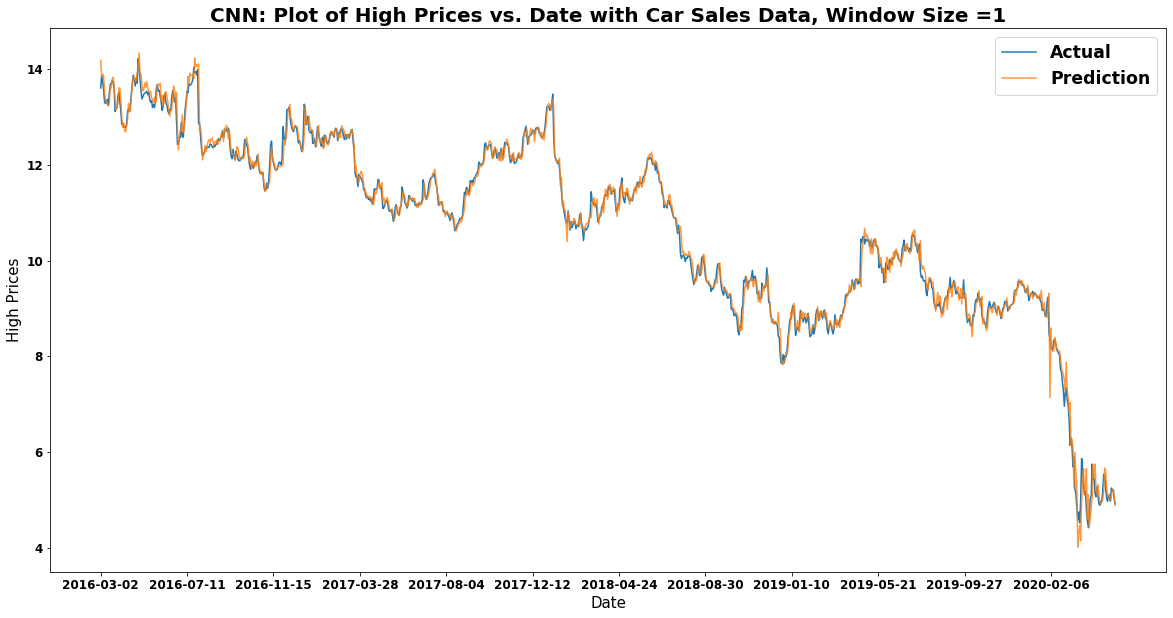

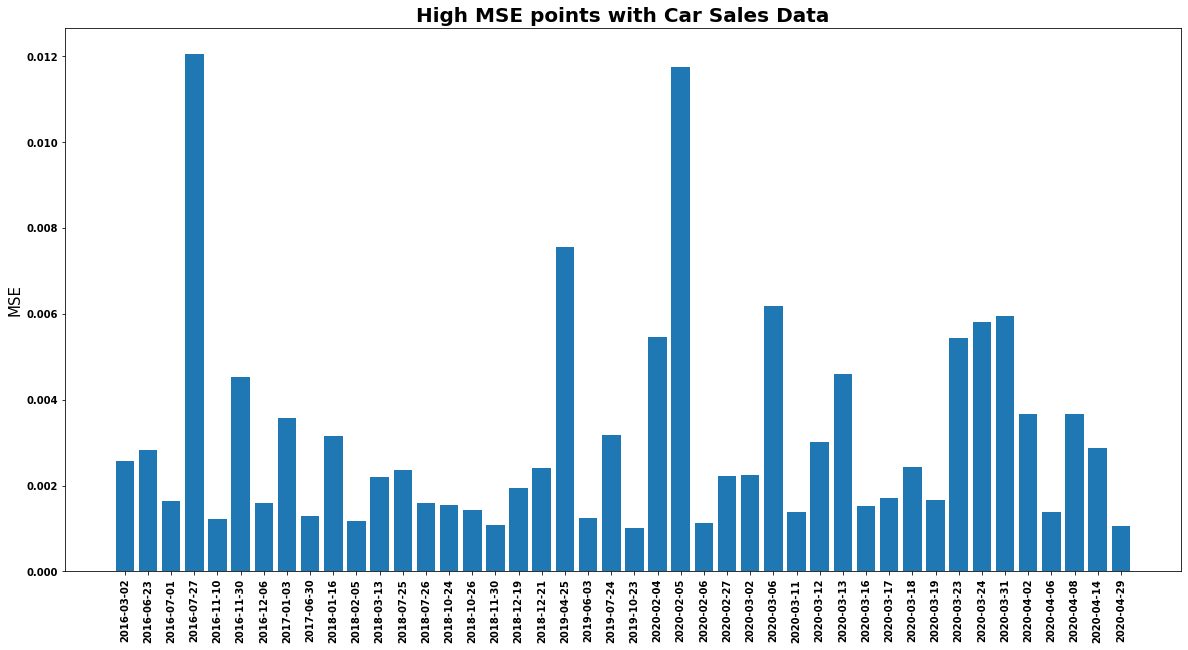

In [171]:
def evaluate_model(y_predicted,y_actual,dates):

    plt.figure(figsize=(20,10))
    plt.title('CNN: Plot of High Prices vs. Date with Car Sales Data, Window Size =1',fontsize=20,fontweight='bold')
    plt.xlabel('Date',fontsize=15)
    plt.ylabel('High Prices',fontsize=15)
    plt.plot((y_actual.reshape(-1,1)), label="Actual")#,color='red')
    plt.plot(y_predicted.reshape(-1,1), label="Prediction", alpha=0.8)#,color ='black')
    index = np.arange((len(y_predicted)-1),step=90)
    plt.xticks(index,dates[index],fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize="xx-large")

 
#Rescaling the high values from range 0-1 to original values:
actual= scaler.inverse_transform(np.array(actual_high).reshape(-1,1))
predicted = scaler.inverse_transform(np.array(predicted_high).reshape(-1,1))
evaluate_model(predicted,actual,np.array(predicted_dates))

print("time taken for execution : %s seconds " % (time_taken))
print('Mean Validation loss=', round(mean(model_val_loss),8)) 
print('Mean Model loss=', round(mean(model_loss),8))


large_loss = []
large_loss_date = [] 
#print(f"{'index':10} {'val_loss':10} {'Date':12} {'Predicted High Value':10} {'Actual High Value':25}")     
for index in range(0,len(model_val_loss)):
    val_loss = model_val_loss[index]
    if val_loss>0.001:
        #print(f'{index:5} {val_loss:12f} {predicted_dates[index]:20} {predicted[index][0]:10f} {actual[index][0]:15f}')
        large_loss.append(val_loss)
        large_loss_date.append(predicted_dates[index])


plt.rcParams["font.weight"] = "bold"
plt.figure(figsize=(20,10))
plt.title('High MSE points with Car Sales Data',fontsize=20,fontweight='bold')
plt.ylabel('MSE',fontsize=15)
idx = np.arange(len(large_loss_date))
plt.xticks(idx,large_loss_date,rotation=90)
plt.bar(idx, large_loss, align='center', alpha=1)

In [172]:
# 3. LSTM -Car Sales Data:

In [173]:
file_path = 'daily_mlp_model_weights.h5'
    
callback_checkpoint = ModelCheckpoint(filepath=file_path,
                                      monitor='val_loss',
                                      save_best_only=True,
                                      save_weights_only=True)
    
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
    
#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3,patience=5, min_lr=0.0009)
    
callbacks = [early_stopping, callback_checkpoint]#, reduce_lr]
adam = Adam(lr=0.003)
model = Sequential()
model.add(LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(16))
model.add(Dense(1))
model.compile(loss='mse', optimizer=adam)

#window size =1:
import time
from itertools import chain
start_time = time.time()

predicted_high = []
actual_high = []
predicted_dates = []
window = 200
model_loss = []
model_val_loss =[]

for trn in range(0,trn_size-window):
    X_train,X_test,y_train,y_test,Date_train,Date_test = build_data(trn,pw=1,window_size = window)
    print(trn)
    
    history = model.fit(X_train, y_train,verbose = 0, epochs=200,
                        validation_data=(X_test, y_test), callbacks=callbacks, 
                        shuffle=False)
    yhat = model.predict(X_test, verbose=0)
    yhat = list(chain.from_iterable(yhat)) 
    if len(predicted_high) == 0:
        predicted_high = yhat
        predicted_dates = Date_test.tolist()
        actual_high = y_test.tolist()
        model_loss.append(history.history['loss'][-1])
        model_val_loss.append(history.history['val_loss'][-1])
        
        
    else:
        beg=len(predicted_high)-len(yhat)+1
        yhat_idx = 0
        for pred_idx in range(beg,len(predicted_high)):
            predicted_high[pred_idx]= (predicted_high[pred_idx] + yhat[yhat_idx])/2
            yhat_idx+=1
        predicted_high.append(yhat[-1])
        actual_high.append(y_test[-1])
        predicted_dates.append(Date_test.tolist()[-1])
        model_loss.append(history.history['loss'][-1])
        model_val_loss.append(history.history['val_loss'][-1])
    

0
Epoch 00020: early stopping
1
Epoch 00032: early stopping
2
Epoch 00011: early stopping
3
Epoch 00104: early stopping
4
Epoch 00013: early stopping
5
Epoch 00013: early stopping
6
Epoch 00023: early stopping
7
Epoch 00012: early stopping
8
Epoch 00016: early stopping
9
Epoch 00020: early stopping
10
Epoch 00011: early stopping
11
Epoch 00013: early stopping
12
Epoch 00011: early stopping
13
Epoch 00031: early stopping
14
Epoch 00017: early stopping
15
Epoch 00011: early stopping
16
Epoch 00019: early stopping
17
Epoch 00018: early stopping
18
Epoch 00020: early stopping
19
Epoch 00011: early stopping
20
Epoch 00017: early stopping
21
Epoch 00013: early stopping
22
Epoch 00014: early stopping
23
Epoch 00021: early stopping
24
Epoch 00011: early stopping
25
Epoch 00012: early stopping
26
Epoch 00011: early stopping
27
Epoch 00018: early stopping
28
Epoch 00011: early stopping
29
Epoch 00012: early stopping
30
Epoch 00017: early stopping
31
Epoch 00012: early stopping
32
Epoch 00013: ea

Epoch 00023: early stopping
261
Epoch 00026: early stopping
262
Epoch 00024: early stopping
263
Epoch 00017: early stopping
264
Epoch 00016: early stopping
265
Epoch 00036: early stopping
266
Epoch 00016: early stopping
267
Epoch 00050: early stopping
268
Epoch 00016: early stopping
269
Epoch 00013: early stopping
270
Epoch 00013: early stopping
271
Epoch 00016: early stopping
272
Epoch 00068: early stopping
273
Epoch 00011: early stopping
274
Epoch 00012: early stopping
275
Epoch 00012: early stopping
276
Epoch 00057: early stopping
277
Epoch 00013: early stopping
278
Epoch 00011: early stopping
279
Epoch 00060: early stopping
280
Epoch 00012: early stopping
281
Epoch 00013: early stopping
282
Epoch 00031: early stopping
283
Epoch 00011: early stopping
284
Epoch 00036: early stopping
285
Epoch 00012: early stopping
286
Epoch 00034: early stopping
287
Epoch 00020: early stopping
288
Epoch 00019: early stopping
289
Epoch 00013: early stopping
290
Epoch 00028: early stopping
291
Epoch 00

Epoch 00018: early stopping
518
Epoch 00016: early stopping
519
Epoch 00030: early stopping
520
Epoch 00018: early stopping
521
Epoch 00019: early stopping
522
Epoch 00029: early stopping
523
Epoch 00011: early stopping
524
Epoch 00014: early stopping
525
Epoch 00016: early stopping
526
Epoch 00028: early stopping
527
Epoch 00011: early stopping
528
Epoch 00011: early stopping
529
Epoch 00019: early stopping
530
Epoch 00011: early stopping
531
Epoch 00012: early stopping
532
Epoch 00029: early stopping
533
Epoch 00018: early stopping
534
Epoch 00014: early stopping
535
Epoch 00015: early stopping
536
Epoch 00020: early stopping
537
Epoch 00016: early stopping
538
Epoch 00011: early stopping
539
Epoch 00019: early stopping
540
Epoch 00020: early stopping
541
Epoch 00012: early stopping
542
Epoch 00013: early stopping
543
Epoch 00022: early stopping
544
Epoch 00011: early stopping
545
Epoch 00022: early stopping
546
Epoch 00036: early stopping
547
Epoch 00011: early stopping
548
Epoch 00

Epoch 00019: early stopping
775
Epoch 00012: early stopping
776
Epoch 00022: early stopping
777
Epoch 00015: early stopping
778
Epoch 00036: early stopping
779
Epoch 00019: early stopping
780
Epoch 00043: early stopping
781
Epoch 00022: early stopping
782
Epoch 00015: early stopping
783
Epoch 00021: early stopping
784
Epoch 00015: early stopping
785
Epoch 00019: early stopping
786
Epoch 00021: early stopping
787
Epoch 00011: early stopping
788
Epoch 00015: early stopping
789
Epoch 00014: early stopping
790
Epoch 00013: early stopping
791
Epoch 00012: early stopping
792
Epoch 00026: early stopping
793
Epoch 00015: early stopping
794
Epoch 00027: early stopping
795
Epoch 00026: early stopping
796
Epoch 00021: early stopping
797
Epoch 00025: early stopping
798
Epoch 00035: early stopping
799
Epoch 00013: early stopping
800
Epoch 00020: early stopping
801
Epoch 00011: early stopping
802
Epoch 00011: early stopping
803
Epoch 00011: early stopping
804
Epoch 00012: early stopping
805
Epoch 00

Epoch 00013: early stopping
1031
Epoch 00017: early stopping
1032
Epoch 00018: early stopping
1033
Epoch 00020: early stopping
1034
Epoch 00021: early stopping
1035
Epoch 00017: early stopping
1036
Epoch 00022: early stopping
1037
Epoch 00014: early stopping
1038
Epoch 00024: early stopping
1039
Epoch 00011: early stopping
1040
Epoch 00027: early stopping
1041
Epoch 00024: early stopping
1042
Epoch 00011: early stopping
1043
Epoch 00018: early stopping
1044
Epoch 00024: early stopping
1045
Epoch 00024: early stopping
1046
Epoch 00024: early stopping
1047
Epoch 00012: early stopping
1048
Epoch 00032: early stopping
1049
Epoch 00011: early stopping
1050
Epoch 00015: early stopping
1051
Epoch 00014: early stopping
1052
Epoch 00011: early stopping
1053
Epoch 00013: early stopping
1054
Epoch 00013: early stopping
1055
Epoch 00011: early stopping
1056
Epoch 00059: early stopping
1057
Epoch 00013: early stopping


time taken for execution : 139.17335486412048 seconds 
Mean Validation loss= 0.0002864
Mean Model loss= 0.00014085


<BarContainer object of 51 artists>

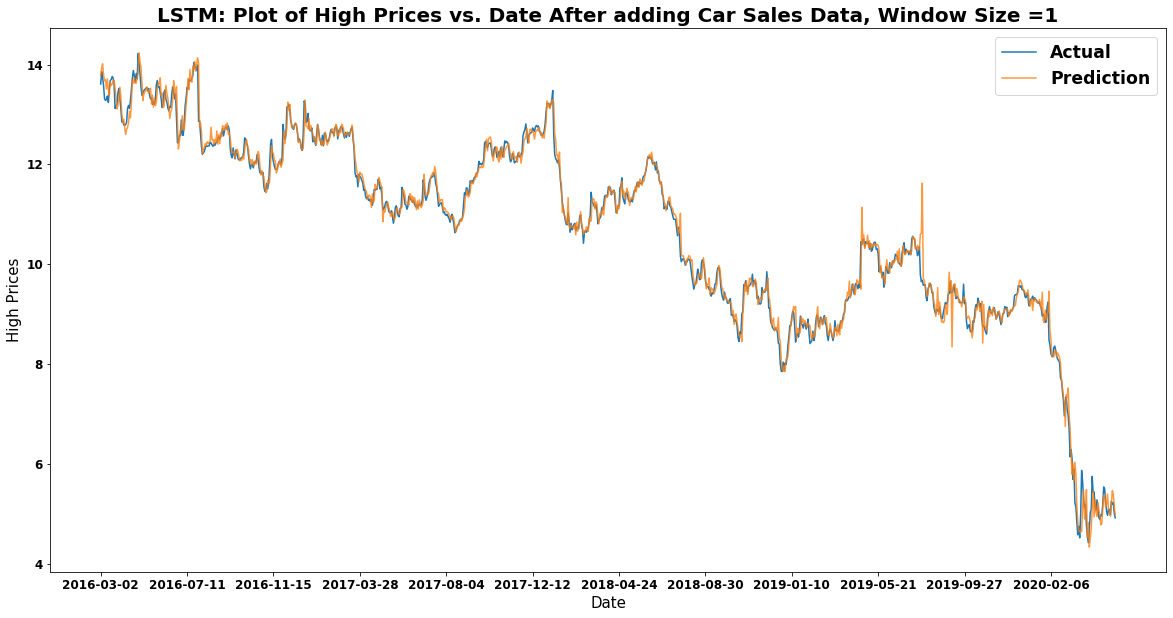

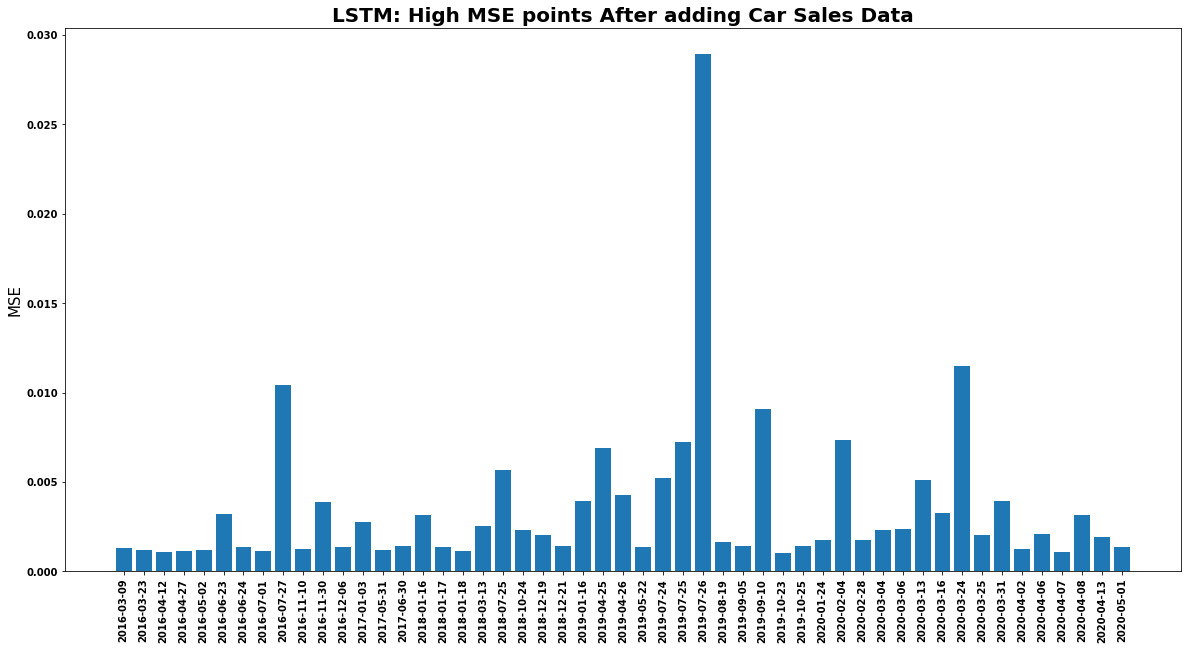

In [174]:
def evaluate_model(y_predicted,y_actual,dates):

    plt.figure(figsize=(20,10))
    plt.title('LSTM: Plot of High Prices vs. Date After adding Car Sales Data, Window Size =1',fontsize=20,fontweight='bold')
    plt.xlabel('Date',fontsize=15)
    plt.ylabel('High Prices',fontsize=15)
    plt.plot((y_actual.reshape(-1,1)), label="Actual")#,color='red')
    plt.plot(y_predicted.reshape(-1,1), label="Prediction", alpha=0.8)#,color ='black')
    index = np.arange((len(y_predicted)-1),step=90)
    plt.xticks(index,dates[index],fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize="xx-large")

 
#Rescaling the high values from range 0-1 to original values:
actual= scaler.inverse_transform(np.array(actual_high).reshape(-1,1))
predicted = scaler.inverse_transform(np.array(predicted_high).reshape(-1,1))
evaluate_model(predicted,actual,np.array(predicted_dates))

print("time taken for execution : %s seconds " % (time_taken))
print('Mean Validation loss=', round(mean(model_val_loss),8)) 
print('Mean Model loss=', round(mean(model_loss),8))


large_loss = []
large_loss_date = [] 
#print(f"{'index':10} {'val_loss':10} {'Date':12} {'Predicted High Value':10} {'Actual High Value':25}")     
for index in range(0,len(model_val_loss)):
    val_loss = model_val_loss[index]
    if val_loss>0.001:
        #print(f'{index:5} {val_loss:12f} {predicted_dates[index]:20} {predicted[index][0]:10f} {actual[index][0]:15f}')
        large_loss.append(val_loss)
        large_loss_date.append(predicted_dates[index])


plt.rcParams["font.weight"] = "bold"
plt.figure(figsize=(20,10))
plt.title('LSTM: High MSE points After adding Car Sales Data',fontsize=20,fontweight='bold')
plt.ylabel('MSE',fontsize=15)
idx = np.arange(len(large_loss_date))
plt.xticks(idx,large_loss_date,rotation=90)
plt.bar(idx, large_loss, align='center', alpha=1)

# 4. S&P Global Oil Index:

In [236]:
glb_oil = pd.read_csv('/Users/aleenaalex/Documents/UCC projects/data/S&P Global Oil Index 5Y.csv', 
                      header=0, index_col=0)
#df1 = df.ix[:, 'a':'b']
#glb_oil = glb_oil[['S&P Global Oil Index']]
#glb_oil =(glb_oil[1291:2592])
glb_oil 
#glb_oil.to_csv('/Users/aleenaalex/Documents/UCC projects/data/S&P Global Oil Index 5Y.csv', encoding='utf-8')#index=False)

S&P Global Oil Index
Effective date                       
15/05/15                      1956.93
18/05/15                      1948.25
19/05/15                      1917.52
20/05/15                      1916.57
21/05/15                      1936.78
...                               ...
08/05/20                      1082.50
11/05/20                      1071.49
12/05/20                      1062.24
13/05/20                      1022.17
14/05/20                      1017.11

[1301 rows x 1 columns]

In [237]:
# Date Conversion:
#Convert Date Format:yr-mnth-dt
dates = []
dates = list(glb_oil.index)
newDates = []
for idx in range(0,len(dates)): 
    date = dates[idx]
    day,month,year = date[0:2],date[3:5],'20'+date[6:8]
    newDates.append(year+'-'+month+'-'+day)
glb_oil.insert(1, "FormatDate", newDates)
glb_oil

S&P Global Oil Index  FormatDate
Effective date                                   
15/05/15                      1956.93  2015-05-15
18/05/15                      1948.25  2015-05-18
19/05/15                      1917.52  2015-05-19
20/05/15                      1916.57  2015-05-20
21/05/15                      1936.78  2015-05-21
...                               ...         ...
08/05/20                      1082.50  2020-05-08
11/05/20                      1071.49  2020-05-11
12/05/20                      1062.24  2020-05-12
13/05/20                      1022.17  2020-05-13
14/05/20                      1017.11  2020-05-14

[1301 rows x 2 columns]

In [244]:
#merge values:
ford_dates = list(ford.index)
oil_dates = list(glb_oil['FormatDate'])
mean_oil = mean(glb_oil['S&P Global Oil Index'])
#print(mean_oil,len(ford_dates))
ford["oil"] = mean_oil
for row_num in range(0,len(ford_dates)):
    date = ford_dates[row_num] 
    #print(date)
    if date in oil_dates:
        ford["oil"][row_num] = mean((glb_oil['S&P Global Oil Index'][glb_oil['FormatDate']==date]))
    
ford

/Users/aleenaalex/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


Open   High    Low  Close  Adj Close     Volume      oil
Date                                                                 
2015-05-15  15.27  15.49  15.27  15.48  11.977631   18937700  1956.93
2015-05-18  15.47  15.64  15.45  15.58  12.055005   19491900  1948.25
2015-05-19  15.59  15.63  15.45  15.50  11.993106   15145300  1917.52
2015-05-20  15.54  15.56  15.26  15.30  11.838357   22391500  1916.57
2015-05-21  15.28  15.55  15.26  15.51  12.000844   23962000  1936.78
...           ...    ...    ...    ...        ...        ...      ...
2020-05-08   4.96   5.25   4.95   5.24   5.240000  101333800  1082.50
2020-05-11   5.18   5.19   5.05   5.12   5.120000   75593900  1071.49
2020-05-12   5.15   5.22   4.97   4.98   4.980000   70965200  1062.24
2020-05-13   5.00   5.01   4.66   4.72   4.720000  100192300  1022.17
2020-05-14   4.64   4.92   4.52   4.89   4.890000  107931900  1017.11

[1259 rows x 7 columns]

In [246]:
def normalize(data):
    
    scaler_open = MinMaxScaler()
    scaler_high = MinMaxScaler()
    scaler_low = MinMaxScaler()
    scaler_close = MinMaxScaler()
    scaler_adjclose = MinMaxScaler()
    scaler_volume = MinMaxScaler()
    scaler_oil = MinMaxScaler()
    
    #Open:
    fit = scaler_open.fit(np.array(data['Open']).reshape(-1, 1))
    data['Open'] =scaler_open.transform(np.array(dataframe_ford['Open']).reshape(-1, 1))
    
    #High:
    fit = scaler_high.fit(np.array(data['High']).reshape(-1, 1))
    data['High'] =scaler_high.transform(np.array(data['High']).reshape(-1, 1))
    
    #Low:
    fit = scaler_low.fit(np.array(data['Low']).reshape(-1, 1))
    data['Low'] =scaler_low.transform(np.array(data['Low']).reshape(-1, 1))
    
    #Close:
    fit = scaler_close.fit(np.array(data['Close']).reshape(-1, 1))
    data['Close'] =scaler_close.transform(np.array(data['Close']).reshape(-1, 1))
    
    #AdjClose:
    fit = scaler_adjclose.fit(np.array(data['Adj Close']).reshape(-1, 1))
    data['Adj Close'] =scaler_adjclose.transform(np.array(data['Adj Close']).reshape(-1, 1))
    
    #High:
    fit = scaler_volume.fit(np.array(data['Volume']).reshape(-1, 1))
    data['Volume'] =scaler_volume.transform(np.array(data['Volume']).reshape(-1, 1))
    
    #Dow:
    fit = scaler_oil.fit(np.array(data['oil']).reshape(-1, 1))
    data['oil'] =scaler_oil.transform(np.array(data['oil']).reshape(-1, 1))
    
    return data,scaler_high

df = ford
dataframe_ford = df
df,scaler = normalize(df)

#convert data: form X and y data:
Xarr = df.rename_axis('ID').values
Xarr = Xarr[0:1258]
Datearr = df.index.values

df1 = df[['High']]
yarr = df1.rename_axis('ID').values

print('Xarr:',Xarr[0:5])
print('yarr:',yarr[0:5])
print('Datearr:',Datearr[0:5])

yarr = np.delete(yarr, 0)
print('yarr:',yarr[0:5])
print('X shape:',Xarr.shape)
print('y shape:',yarr.shape)

def build_data(start,pw,window_size=200):
    
    X_train,X_test = Xarr[start:start+window_size],Xarr[start+window_size:start+window_size+pw]
    y_train,y_test = yarr[start:start+window_size],yarr[start+window_size:start+window_size+pw]
    Date_train,Date_test = Datearr[start:start+window_size],Datearr[start+window_size:start+window_size+pw]
    return X_train,X_test,y_train,y_test,Date_train,Date_test

trn_size = len(Xarr)

from numpy import array
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline
    
file_path = 'daily_mlp_model_weights.h5'
    
callback_checkpoint = ModelCheckpoint(filepath=file_path,
                                      monitor='val_loss',
                                      save_best_only=True,
                                      save_weights_only=True)
    
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
    
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3,
                              patience=5, min_lr=0.0009)
    
callbacks = [early_stopping, callback_checkpoint, reduce_lr]
    
tf.keras.backend.clear_session()
    
model_mlp = tf.keras.models.Sequential()
    
model_mlp.add(tf.keras.layers.Reshape((7,),input_shape=(7,)))
    
model_mlp.add(tf.keras.layers.Dense(200,activation='relu'))
    
model_mlp.add(tf.keras.layers.Dense(1,activation='linear'))
    
model_mlp.compile(optimizer='adam',loss='mse',metrics=['accuracy'])
    

Xarr: [[0.95986038 0.96935201 0.97416021 0.98286204 0.96620093 0.04988881
  0.93603456]
 [0.97731239 0.98248687 0.98966408 0.99143102 0.97558374 0.05236248
  0.92952401]
 [0.9877836  0.98161121 0.98966408 0.98457584 0.96807751 0.0329615
  0.90647455]
 [0.98342059 0.97548161 0.97329888 0.96743787 0.94931176 0.0653048
  0.90576199]
 [0.96073298 0.97460595 0.97329888 0.98543273 0.96901587 0.0723147
  0.92092078]]
yarr: [[0.96935201]
 [0.98248687]
 [0.98161121]
 [0.97548161]
 [0.97460595]]
Datearr: ['2015-05-15' '2015-05-18' '2015-05-19' '2015-05-20' '2015-05-21']
yarr: [0.98248687 0.98161121 0.97548161 0.97460595 0.97022767]
X shape: (1258, 7)
y shape: (1258,)


In [247]:
import time
from itertools import chain
start_time = time.time()

predicted_high = []
actual_high = []
predicted_dates = []
window = 200
model_loss = []
model_val_loss =[]

for trn in range(0,trn_size-window):
    X_train,X_test,y_train,y_test,Date_train,Date_test = build_data(trn,pw=1,window_size = window)
    print(trn)
    
    history = model_mlp.fit(X_train, y_train,verbose = 0, epochs=200,
                        validation_data=(X_test, y_test), callbacks=callbacks, 
                        shuffle=False)
    yhat = model_mlp.predict(X_test, verbose=0)
    yhat = list(chain.from_iterable(yhat)) 
    if len(predicted_high) == 0:
        predicted_high = yhat
        predicted_dates = Date_test.tolist()
        actual_high = y_test.tolist()
        model_loss.append(history.history['loss'][-1])
        model_val_loss.append(history.history['val_loss'][-1])
        
        
    else:
        beg=len(predicted_high)-len(yhat)+1
        yhat_idx = 0
        for pred_idx in range(beg,len(predicted_high)):
            predicted_high[pred_idx]= (predicted_high[pred_idx] + yhat[yhat_idx])/2
            yhat_idx+=1
        predicted_high.append(yhat[-1])
        actual_high.append(y_test[-1])
        predicted_dates.append(Date_test.tolist()[-1])
        model_loss.append(history.history['loss'][-1])
        model_val_loss.append(history.history['val_loss'][-1])
    
    
time_taken = time.time() - start_time
print(predicted_dates[0:5])
print(predicted_high[0:5])
print(actual_high[0:5])

0
Epoch 00022: early stopping
1
Epoch 00011: early stopping
2
Epoch 00081: early stopping
3
Epoch 00011: early stopping
4
Epoch 00012: early stopping
5
Epoch 00012: early stopping
6
Epoch 00012: early stopping
7
Epoch 00012: early stopping
8
Epoch 00012: early stopping
9
Epoch 00013: early stopping
10
Epoch 00013: early stopping
11
12
Epoch 00012: early stopping
13
Epoch 00011: early stopping
14
15
Epoch 00012: early stopping
16
Epoch 00011: early stopping
17
Epoch 00013: early stopping
18
Epoch 00013: early stopping
19
Epoch 00011: early stopping
20
Epoch 00013: early stopping
21
Epoch 00012: early stopping
22
23
Epoch 00023: early stopping
24
Epoch 00018: early stopping
25
Epoch 00011: early stopping
26
Epoch 00012: early stopping
27
Epoch 00018: early stopping
28
Epoch 00022: early stopping
29
Epoch 00011: early stopping
30
Epoch 00011: early stopping
31
Epoch 00011: early stopping
32
Epoch 00021: early stopping
33
Epoch 00032: early stopping
34
Epoch 00011: early stopping
35
Epoch 

Epoch 00024: early stopping
264
Epoch 00020: early stopping
265
Epoch 00014: early stopping
266
Epoch 00015: early stopping
267
Epoch 00026: early stopping
268
Epoch 00016: early stopping
269
Epoch 00020: early stopping
270
Epoch 00017: early stopping
271
Epoch 00012: early stopping
272
Epoch 00020: early stopping
273
Epoch 00011: early stopping
274
Epoch 00013: early stopping
275
Epoch 00015: early stopping
276
Epoch 00030: early stopping
277
Epoch 00018: early stopping
278
Epoch 00019: early stopping
279
Epoch 00021: early stopping
280
Epoch 00015: early stopping
281
Epoch 00015: early stopping
282
Epoch 00011: early stopping
283
Epoch 00011: early stopping
284
Epoch 00025: early stopping
285
Epoch 00021: early stopping
286
Epoch 00011: early stopping
287
Epoch 00025: early stopping
288
Epoch 00027: early stopping
289
Epoch 00027: early stopping
290
Epoch 00026: early stopping
291
Epoch 00029: early stopping
292
Epoch 00014: early stopping
293
Epoch 00011: early stopping
294
Epoch 00

Epoch 00024: early stopping
521
Epoch 00011: early stopping
522
Epoch 00019: early stopping
523
Epoch 00039: early stopping
524
Epoch 00014: early stopping
525
Epoch 00016: early stopping
526
Epoch 00014: early stopping
527
Epoch 00062: early stopping
528
Epoch 00016: early stopping
529
Epoch 00076: early stopping
530
Epoch 00016: early stopping
531
Epoch 00011: early stopping
532
Epoch 00029: early stopping
533
Epoch 00011: early stopping
534
Epoch 00017: early stopping
535
Epoch 00016: early stopping
536
Epoch 00012: early stopping
537
Epoch 00012: early stopping
538
Epoch 00014: early stopping
539
Epoch 00018: early stopping
540
Epoch 00014: early stopping
541
Epoch 00012: early stopping
542
Epoch 00011: early stopping
543
Epoch 00012: early stopping
544
Epoch 00054: early stopping
545
Epoch 00013: early stopping
546
Epoch 00012: early stopping
547
Epoch 00062: early stopping
548
Epoch 00014: early stopping
549
Epoch 00011: early stopping
550
Epoch 00011: early stopping
551
Epoch 00

Epoch 00013: early stopping
779
Epoch 00011: early stopping
780
Epoch 00015: early stopping
781
Epoch 00011: early stopping
782
Epoch 00036: early stopping
783
Epoch 00013: early stopping
784
Epoch 00013: early stopping
785
Epoch 00011: early stopping
786
Epoch 00013: early stopping
787
Epoch 00016: early stopping
788
Epoch 00013: early stopping
789
Epoch 00016: early stopping
790
Epoch 00013: early stopping
791
Epoch 00013: early stopping
792
Epoch 00013: early stopping
793
Epoch 00013: early stopping
794
Epoch 00015: early stopping
795
Epoch 00012: early stopping
796
Epoch 00011: early stopping
797
Epoch 00021: early stopping
798
Epoch 00012: early stopping
799
Epoch 00104: early stopping
800
Epoch 00012: early stopping
801
Epoch 00025: early stopping
802
Epoch 00012: early stopping
803
Epoch 00012: early stopping
804
Epoch 00012: early stopping
805
Epoch 00024: early stopping
806
Epoch 00024: early stopping
807
Epoch 00012: early stopping
808
Epoch 00021: early stopping
809
Epoch 00

1036
Epoch 00012: early stopping
1037
1038
Epoch 00011: early stopping
1039
Epoch 00011: early stopping
1040
Epoch 00014: early stopping
1041
Epoch 00017: early stopping
1042
Epoch 00033: early stopping
1043
Epoch 00011: early stopping
1044
Epoch 00011: early stopping
1045
Epoch 00021: early stopping
1046
Epoch 00012: early stopping
1047
Epoch 00028: early stopping
1048
Epoch 00016: early stopping
1049
Epoch 00013: early stopping
1050
Epoch 00022: early stopping
1051
Epoch 00015: early stopping
1052
Epoch 00012: early stopping
1053
Epoch 00011: early stopping
1054
Epoch 00038: early stopping
1055
Epoch 00025: early stopping
1056
Epoch 00011: early stopping
1057
Epoch 00050: early stopping
['2016-03-02', '2016-03-03', '2016-03-04', '2016-03-07', '2016-03-08']
[0.7942833, 0.8159233, 0.8224544, 0.82386976, 0.79978824]
[0.8047285464098073, 0.8266199649737302, 0.8161120840630474, 0.8021015761821366, 0.7793345008756569]


time taken for execution : 271.10168170928955 seconds 
Mean Validation loss= 0.00020906
Mean Model loss= 0.00014107


<BarContainer object of 36 artists>

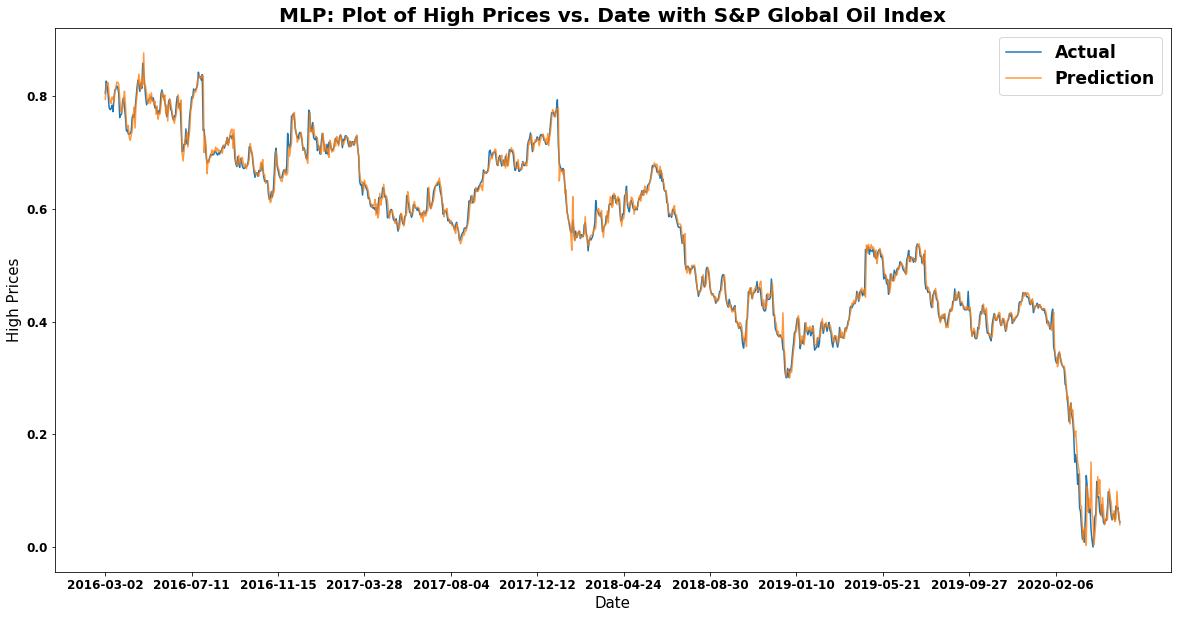

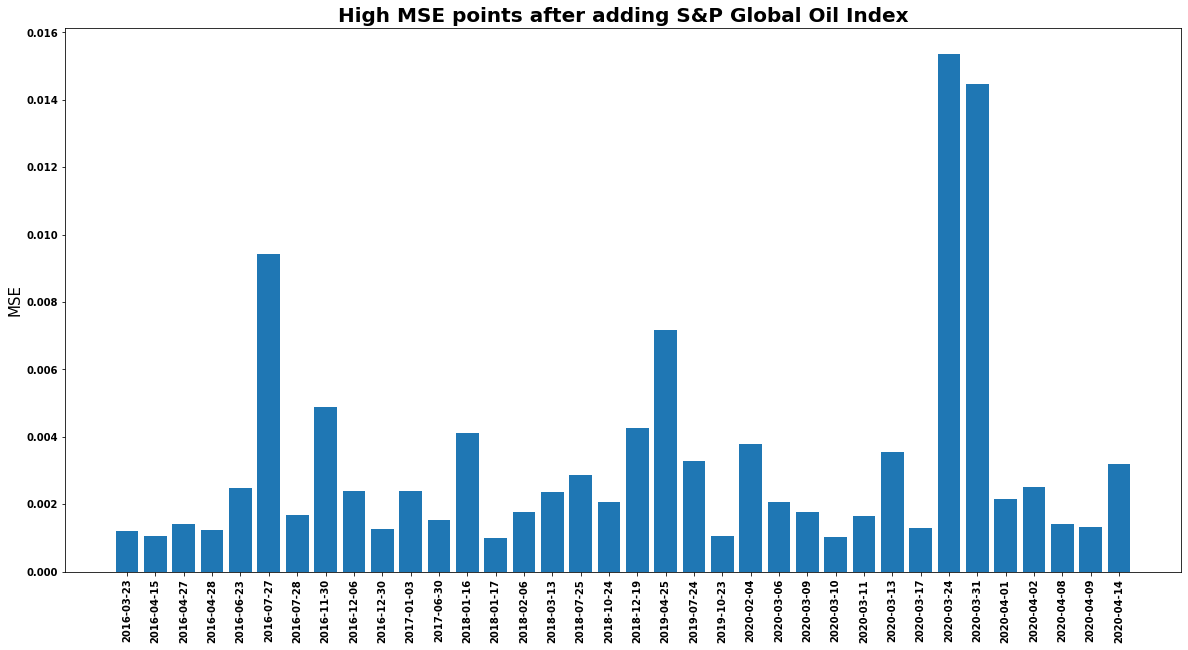

In [248]:
def evaluate_model(y_predicted,y_actual,dates):

    plt.figure(figsize=(20,10))
    plt.title('MLP: Plot of High Prices vs. Date with S&P Global Oil Index',fontsize=20,fontweight='bold')
    plt.xlabel('Date',fontsize=15)
    plt.ylabel('High Prices',fontsize=15)
    plt.plot((y_actual.reshape(-1,1)), label="Actual")#,color='red')
    plt.plot(y_predicted.reshape(-1,1), label="Prediction", alpha=0.8)#,color ='black')
    index = np.arange((len(y_predicted)-1),step=90)
    plt.xticks(index,dates[index],fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize="xx-large")
    #plt.savefig("LSTM.pdf")

 
#Rescaling the high values from range 0-1 to original values:
actual= scaler.inverse_transform(np.array(actual_high).reshape(-1,1))
predicted = scaler.inverse_transform(np.array(predicted_high).reshape(-1,1))
evaluate_model(predicted,actual,np.array(predicted_dates))

print("time taken for execution : %s seconds " % (time_taken))
print('Mean Validation loss=', round(mean(model_val_loss),8)) 
print('Mean Model loss=', round(mean(model_loss),8))


large_loss = []
large_loss_date = [] 
#print(f"{'index':10} {'val_loss':10} {'Date':12} {'Predicted High Value':10} {'Actual High Value':25}")     
for index in range(0,len(model_val_loss)):
    val_loss = model_val_loss[index]
    if val_loss>0.001:
        #print(f'{index:5} {val_loss:12f} {predicted_dates[index]:20} {predicted[index][0]:10f} {actual[index][0]:15f}')
        large_loss.append(val_loss)
        large_loss_date.append(predicted_dates[index])


plt.rcParams["font.weight"] = "bold"
plt.figure(figsize=(20,10))
plt.title('High MSE points after adding S&P Global Oil Index',fontsize=20,fontweight='bold')
plt.ylabel('MSE',fontsize=15)
idx = np.arange(len(large_loss_date))
plt.xticks(idx,large_loss_date,rotation=90)
plt.bar(idx, large_loss, align='center', alpha=1)

# CNN - S&P Global Oil Index:

In [250]:
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
import matplotlib.pyplot as plt
%matplotlib inline

file_path = 'daily_mlp_model_weights.h5'
    
callback_checkpoint = ModelCheckpoint(filepath=file_path,
                                      monitor='val_loss',
                                      save_best_only=True,
                                      save_weights_only=True)
    
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
    
callbacks = [early_stopping, callback_checkpoint]#, reduce_lr]

Xarr = Xarr.reshape((Xarr.shape[0], Xarr.shape[1], 1))
# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(7, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

#CNN Model window size =1:
import time
from itertools import chain
start_time = time.time()

predicted_high = []
actual_high = []
predicted_dates = []
window = 200
model_loss = []
model_val_loss =[]

for trn in range(0,trn_size-window):
    X_train,X_test,y_train,y_test,Date_train,Date_test = build_data(trn,pw=1,window_size = window)
    print(trn)
    
    history = model.fit(X_train, y_train,verbose = 0, epochs=200,
                        validation_data=(X_test, y_test), callbacks=callbacks, 
                        shuffle=False)
    yhat = model.predict(X_test, verbose=0)
    yhat = list(chain.from_iterable(yhat)) 
    if len(predicted_high) == 0:
        predicted_high = yhat
        predicted_dates = Date_test.tolist()
        actual_high = y_test.tolist()
        model_loss.append(history.history['loss'][-1])
        model_val_loss.append(history.history['val_loss'][-1])
        
        
    else:
        beg=len(predicted_high)-len(yhat)+1
        yhat_idx = 0
        for pred_idx in range(beg,len(predicted_high)):
            predicted_high[pred_idx]= (predicted_high[pred_idx] + yhat[yhat_idx])/2
            yhat_idx+=1
        predicted_high.append(yhat[-1])
        actual_high.append(y_test[-1])
        predicted_dates.append(Date_test.tolist()[-1])
        model_loss.append(history.history['loss'][-1])
        model_val_loss.append(history.history['val_loss'][-1])
    
    
time_taken = time.time() - start_time
print(predicted_dates[0:5])
print(predicted_high[0:5])
print(actual_high[0:5])

0
Epoch 00018: early stopping
1
2
Epoch 00012: early stopping
3
Epoch 00012: early stopping
4
Epoch 00011: early stopping
5
Epoch 00011: early stopping
6
Epoch 00011: early stopping
7
Epoch 00011: early stopping
8
Epoch 00011: early stopping
9
Epoch 00013: early stopping
10
Epoch 00011: early stopping
11
Epoch 00129: early stopping
12
Epoch 00016: early stopping
13
Epoch 00014: early stopping
14
Epoch 00013: early stopping
15
Epoch 00013: early stopping
16
Epoch 00013: early stopping
17
Epoch 00016: early stopping
18
Epoch 00015: early stopping
19
Epoch 00016: early stopping
20
Epoch 00011: early stopping
21
Epoch 00013: early stopping
22
Epoch 00015: early stopping
23
Epoch 00021: early stopping
24
Epoch 00020: early stopping
25
Epoch 00017: early stopping
26
Epoch 00019: early stopping
27
Epoch 00017: early stopping
28
Epoch 00030: early stopping
29
Epoch 00011: early stopping
30
Epoch 00011: early stopping
31
Epoch 00024: early stopping
32
Epoch 00031: early stopping
33
Epoch 00028:

Epoch 00018: early stopping
263
Epoch 00012: early stopping
264
Epoch 00019: early stopping
265
Epoch 00018: early stopping
266
Epoch 00024: early stopping
267
Epoch 00016: early stopping
268
Epoch 00015: early stopping
269
Epoch 00012: early stopping
270
Epoch 00012: early stopping
271
Epoch 00014: early stopping
272
Epoch 00013: early stopping
273
Epoch 00011: early stopping
274
Epoch 00013: early stopping
275
Epoch 00013: early stopping
276
Epoch 00042: early stopping
277
Epoch 00019: early stopping
278
Epoch 00015: early stopping
279
Epoch 00058: early stopping
280
Epoch 00012: early stopping
281
Epoch 00013: early stopping
282
Epoch 00015: early stopping
283
Epoch 00011: early stopping
284
Epoch 00062: early stopping
285
Epoch 00013: early stopping
286
Epoch 00011: early stopping
287
Epoch 00091: early stopping
288
Epoch 00024: early stopping
289
Epoch 00020: early stopping
290
Epoch 00011: early stopping
291
Epoch 00026: early stopping
292
Epoch 00015: early stopping
293
Epoch 00

Epoch 00012: early stopping
520
Epoch 00012: early stopping
521
Epoch 00011: early stopping
522
Epoch 00032: early stopping
523
Epoch 00013: early stopping
524
Epoch 00012: early stopping
525
Epoch 00020: early stopping
526
Epoch 00034: early stopping
527
Epoch 00015: early stopping
528
Epoch 00013: early stopping
529
Epoch 00044: early stopping
530
Epoch 00014: early stopping
531
Epoch 00017: early stopping
532
Epoch 00011: early stopping
533
Epoch 00045: early stopping
534
Epoch 00015: early stopping
535
Epoch 00024: early stopping
536
Epoch 00013: early stopping
537
Epoch 00012: early stopping
538
Epoch 00031: early stopping
539
Epoch 00029: early stopping
540
Epoch 00040: early stopping
541
Epoch 00011: early stopping
542
Epoch 00014: early stopping
543
Epoch 00011: early stopping
544
Epoch 00023: early stopping
545
Epoch 00017: early stopping
546
Epoch 00022: early stopping
547
Epoch 00031: early stopping
548
Epoch 00017: early stopping
549
Epoch 00060: early stopping
550
Epoch 00

Epoch 00029: early stopping
777
Epoch 00019: early stopping
778
Epoch 00011: early stopping
779
Epoch 00044: early stopping
780
Epoch 00013: early stopping
781
Epoch 00012: early stopping
782
Epoch 00072: early stopping
783
Epoch 00022: early stopping
784
Epoch 00025: early stopping
785
Epoch 00037: early stopping
786
Epoch 00012: early stopping
787
Epoch 00011: early stopping
788
Epoch 00012: early stopping
789
Epoch 00015: early stopping
790
Epoch 00016: early stopping
791
Epoch 00037: early stopping
792
Epoch 00013: early stopping
793
Epoch 00014: early stopping
794
Epoch 00018: early stopping
795
Epoch 00042: early stopping
796
Epoch 00013: early stopping
797
Epoch 00055: early stopping
798
Epoch 00023: early stopping
799
Epoch 00013: early stopping
800
Epoch 00027: early stopping
801
Epoch 00013: early stopping
802
Epoch 00011: early stopping
803
Epoch 00012: early stopping
804
Epoch 00011: early stopping
805
Epoch 00013: early stopping
806
Epoch 00054: early stopping
807
Epoch 00

Epoch 00027: early stopping
1033
Epoch 00015: early stopping
1034
Epoch 00013: early stopping
1035
Epoch 00013: early stopping
1036
Epoch 00011: early stopping
1037
Epoch 00075: early stopping
1038
Epoch 00019: early stopping
1039
Epoch 00027: early stopping
1040
Epoch 00035: early stopping
1041
Epoch 00013: early stopping
1042
Epoch 00014: early stopping
1043
Epoch 00027: early stopping
1044
Epoch 00013: early stopping
1045
Epoch 00025: early stopping
1046
Epoch 00017: early stopping
1047
Epoch 00013: early stopping
1048
Epoch 00013: early stopping
1049
Epoch 00013: early stopping
1050
Epoch 00022: early stopping
1051
Epoch 00063: early stopping
1052
Epoch 00017: early stopping
1053
Epoch 00013: early stopping
1054
Epoch 00018: early stopping
1055
Epoch 00012: early stopping
1056
Epoch 00017: early stopping
1057
Epoch 00021: early stopping
['2016-03-02', '2016-03-03', '2016-03-04', '2016-03-07', '2016-03-08']
[0.7819114, 0.8157715, 0.82541525, 0.8242078, 0.7982069]
[0.8047285464098073

time taken for execution : 133.383868932724 seconds 
Mean Validation loss= 0.00021915
Mean Model loss= 0.00014731


<BarContainer object of 43 artists>

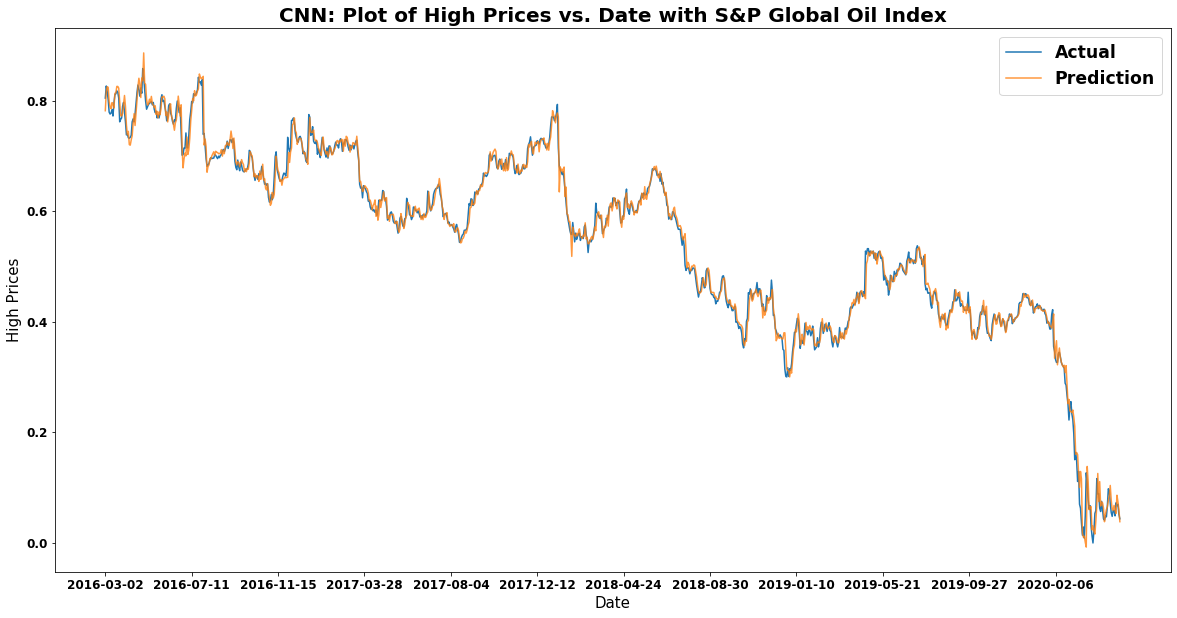

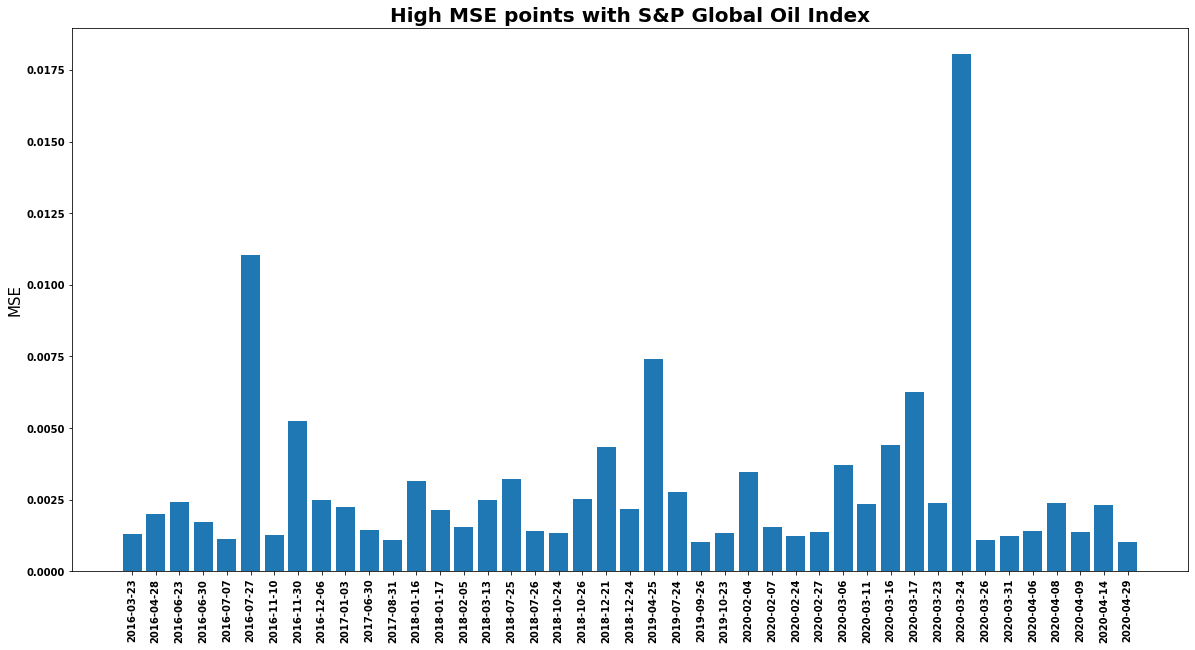

In [251]:
def evaluate_model(y_predicted,y_actual,dates):

    plt.figure(figsize=(20,10))
    plt.title('CNN: Plot of High Prices vs. Date with S&P Global Oil Index',fontsize=20,fontweight='bold')
    plt.xlabel('Date',fontsize=15)
    plt.ylabel('High Prices',fontsize=15)
    plt.plot((y_actual.reshape(-1,1)), label="Actual")#,color='red')
    plt.plot(y_predicted.reshape(-1,1), label="Prediction", alpha=0.8)#,color ='black')
    index = np.arange((len(y_predicted)-1),step=90)
    plt.xticks(index,dates[index],fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize="xx-large")

 
#Rescaling the high values from range 0-1 to original values:
actual= scaler.inverse_transform(np.array(actual_high).reshape(-1,1))
predicted = scaler.inverse_transform(np.array(predicted_high).reshape(-1,1))
evaluate_model(predicted,actual,np.array(predicted_dates))

print("time taken for execution : %s seconds " % (time_taken))
print('Mean Validation loss=', round(mean(model_val_loss),8)) 
print('Mean Model loss=', round(mean(model_loss),8))


large_loss = []
large_loss_date = [] 
#print(f"{'index':10} {'val_loss':10} {'Date':12} {'Predicted High Value':10} {'Actual High Value':25}")     
for index in range(0,len(model_val_loss)):
    val_loss = model_val_loss[index]
    if val_loss>0.001:
        #print(f'{index:5} {val_loss:12f} {predicted_dates[index]:20} {predicted[index][0]:10f} {actual[index][0]:15f}')
        large_loss.append(val_loss)
        large_loss_date.append(predicted_dates[index])


plt.rcParams["font.weight"] = "bold"
plt.figure(figsize=(20,10))
plt.title('High MSE points with S&P Global Oil Index',fontsize=20,fontweight='bold')
plt.ylabel('MSE',fontsize=15)
idx = np.arange(len(large_loss_date))
plt.xticks(idx,large_loss_date,rotation=90)
plt.bar(idx, large_loss, align='center', alpha=1)

# 4.3: LSTM -S&P Global Oil Index:

In [252]:
file_path = 'daily_mlp_model_weights.h5'
    
callback_checkpoint = ModelCheckpoint(filepath=file_path,
                                      monitor='val_loss',
                                      save_best_only=True,
                                      save_weights_only=True)
    
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
    
#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3,patience=5, min_lr=0.0009)
    
callbacks = [early_stopping, callback_checkpoint]#, reduce_lr]
adam = Adam(lr=0.003)
model = Sequential()
model.add(LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(16))
model.add(Dense(1))
model.compile(loss='mse', optimizer=adam)

#window size =1:
import time
from itertools import chain
start_time = time.time()

predicted_high = []
actual_high = []
predicted_dates = []
window = 200
model_loss = []
model_val_loss =[]

for trn in range(0,trn_size-window):
    X_train,X_test,y_train,y_test,Date_train,Date_test = build_data(trn,pw=1,window_size = window)
    print(trn)
    
    history = model.fit(X_train, y_train,verbose = 0, epochs=200,
                        validation_data=(X_test, y_test), callbacks=callbacks, 
                        shuffle=False)
    yhat = model.predict(X_test, verbose=0)
    yhat = list(chain.from_iterable(yhat)) 
    if len(predicted_high) == 0:
        predicted_high = yhat
        predicted_dates = Date_test.tolist()
        actual_high = y_test.tolist()
        model_loss.append(history.history['loss'][-1])
        model_val_loss.append(history.history['val_loss'][-1])
        
        
    else:
        beg=len(predicted_high)-len(yhat)+1
        yhat_idx = 0
        for pred_idx in range(beg,len(predicted_high)):
            predicted_high[pred_idx]= (predicted_high[pred_idx] + yhat[yhat_idx])/2
            yhat_idx+=1
        predicted_high.append(yhat[-1])
        actual_high.append(y_test[-1])
        predicted_dates.append(Date_test.tolist()[-1])
        model_loss.append(history.history['loss'][-1])
        model_val_loss.append(history.history['val_loss'][-1])
    

0
Epoch 00015: early stopping
1
Epoch 00011: early stopping
2
Epoch 00039: early stopping
3
Epoch 00012: early stopping
4
Epoch 00011: early stopping
5
Epoch 00011: early stopping
6
Epoch 00011: early stopping
7
Epoch 00011: early stopping
8
Epoch 00013: early stopping
9
Epoch 00016: early stopping
10
Epoch 00015: early stopping
11
Epoch 00016: early stopping
12
Epoch 00017: early stopping
13
Epoch 00017: early stopping
14
Epoch 00018: early stopping
15
Epoch 00054: early stopping
16
Epoch 00014: early stopping
17
Epoch 00029: early stopping
18
Epoch 00019: early stopping
19
Epoch 00017: early stopping
20
Epoch 00017: early stopping
21
Epoch 00013: early stopping
22
Epoch 00013: early stopping
23
Epoch 00014: early stopping
24
Epoch 00018: early stopping
25
Epoch 00013: early stopping
26
Epoch 00018: early stopping
27
Epoch 00034: early stopping
28
Epoch 00016: early stopping
29
Epoch 00015: early stopping
30
Epoch 00016: early stopping
31
Epoch 00011: early stopping
32
Epoch 00012: ea

Epoch 00019: early stopping
261
Epoch 00012: early stopping
262
Epoch 00011: early stopping
263
Epoch 00012: early stopping
264
Epoch 00011: early stopping
265
Epoch 00016: early stopping
266
Epoch 00016: early stopping
267
Epoch 00048: early stopping
268
Epoch 00011: early stopping
269
Epoch 00013: early stopping
270
Epoch 00014: early stopping
271
Epoch 00011: early stopping
272
Epoch 00070: early stopping
273
Epoch 00013: early stopping
274
Epoch 00012: early stopping
275
Epoch 00029: early stopping
276
Epoch 00023: early stopping
277
Epoch 00015: early stopping
278
Epoch 00012: early stopping
279
Epoch 00015: early stopping
280
Epoch 00041: early stopping
281
Epoch 00016: early stopping
282
Epoch 00030: early stopping
283
Epoch 00011: early stopping
284
Epoch 00022: early stopping
285
Epoch 00016: early stopping
286
Epoch 00013: early stopping
287
Epoch 00035: early stopping
288
Epoch 00031: early stopping
289
Epoch 00012: early stopping
290
Epoch 00044: early stopping
291
Epoch 00

Epoch 00015: early stopping
518
Epoch 00023: early stopping
519
Epoch 00015: early stopping
520
Epoch 00018: early stopping
521
Epoch 00029: early stopping
522
Epoch 00011: early stopping
523
Epoch 00012: early stopping
524
Epoch 00031: early stopping
525
Epoch 00011: early stopping
526
Epoch 00025: early stopping
527
Epoch 00019: early stopping
528
Epoch 00012: early stopping
529
Epoch 00014: early stopping
530
Epoch 00024: early stopping
531
Epoch 00039: early stopping
532
Epoch 00016: early stopping
533
Epoch 00019: early stopping
534
Epoch 00012: early stopping
535
Epoch 00016: early stopping
536
Epoch 00026: early stopping
537
Epoch 00017: early stopping
538
Epoch 00042: early stopping
539
Epoch 00024: early stopping
540
Epoch 00019: early stopping
541
Epoch 00036: early stopping
542
Epoch 00013: early stopping
543
Epoch 00033: early stopping
544
Epoch 00015: early stopping
545
Epoch 00016: early stopping
546
Epoch 00016: early stopping
547
Epoch 00039: early stopping
548
Epoch 00

Epoch 00026: early stopping
775
Epoch 00012: early stopping
776
Epoch 00012: early stopping
777
Epoch 00019: early stopping
778
Epoch 00012: early stopping
779
Epoch 00019: early stopping
780
Epoch 00012: early stopping
781
Epoch 00014: early stopping
782
Epoch 00038: early stopping
783
Epoch 00015: early stopping
784
Epoch 00027: early stopping
785
Epoch 00012: early stopping
786
Epoch 00011: early stopping
787
Epoch 00020: early stopping
788
Epoch 00013: early stopping
789
Epoch 00014: early stopping
790
Epoch 00015: early stopping
791
Epoch 00013: early stopping
792
Epoch 00021: early stopping
793
Epoch 00017: early stopping
794
Epoch 00012: early stopping
795
Epoch 00061: early stopping
796
Epoch 00027: early stopping
797
Epoch 00020: early stopping
798
Epoch 00017: early stopping
799
Epoch 00019: early stopping
800
Epoch 00017: early stopping
801
Epoch 00013: early stopping
802
Epoch 00017: early stopping
803
Epoch 00030: early stopping
804
Epoch 00014: early stopping
805
Epoch 00

Epoch 00013: early stopping
1031
Epoch 00014: early stopping
1032
Epoch 00015: early stopping
1033
Epoch 00026: early stopping
1034
Epoch 00015: early stopping
1035
Epoch 00024: early stopping
1036
Epoch 00020: early stopping
1037
Epoch 00040: early stopping
1038
Epoch 00016: early stopping
1039
Epoch 00014: early stopping
1040
Epoch 00022: early stopping
1041
Epoch 00015: early stopping
1042
Epoch 00035: early stopping
1043
Epoch 00012: early stopping
1044
Epoch 00020: early stopping
1045
Epoch 00036: early stopping
1046
Epoch 00011: early stopping
1047
Epoch 00022: early stopping
1048
Epoch 00017: early stopping
1049
Epoch 00014: early stopping
1050
Epoch 00013: early stopping
1051
Epoch 00012: early stopping
1052
Epoch 00014: early stopping
1053
Epoch 00030: early stopping
1054
Epoch 00014: early stopping
1055
Epoch 00011: early stopping
1056
Epoch 00027: early stopping
1057
Epoch 00016: early stopping


time taken for execution : 133.383868932724 seconds 
Mean Validation loss= 0.00028923
Mean Model loss= 0.00014485


<BarContainer object of 56 artists>

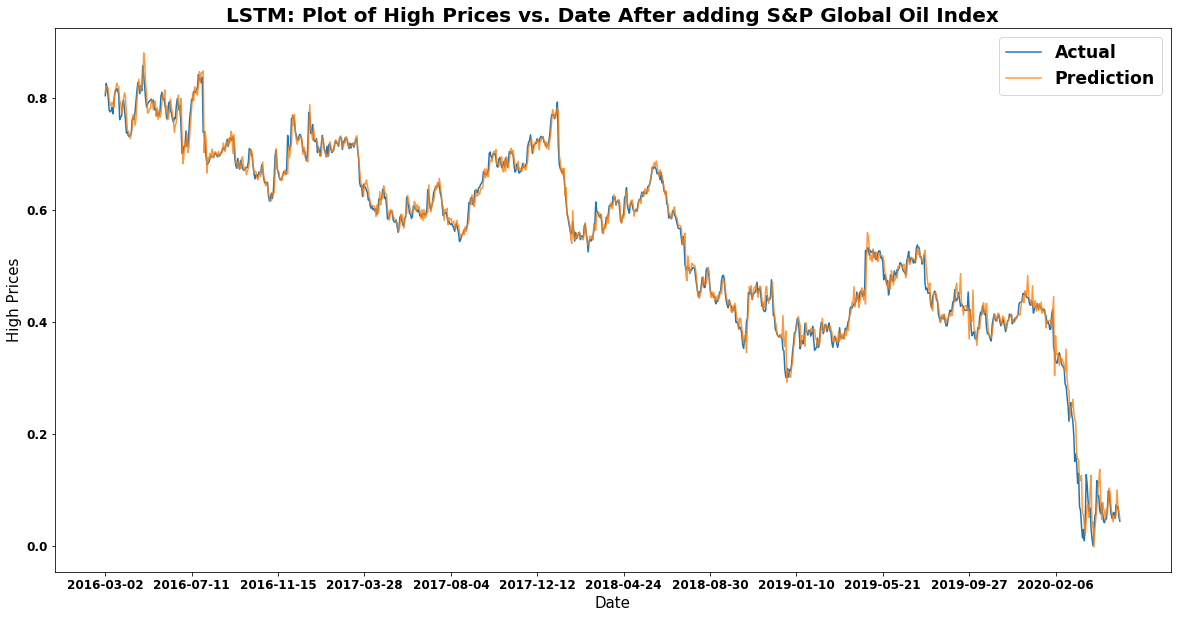

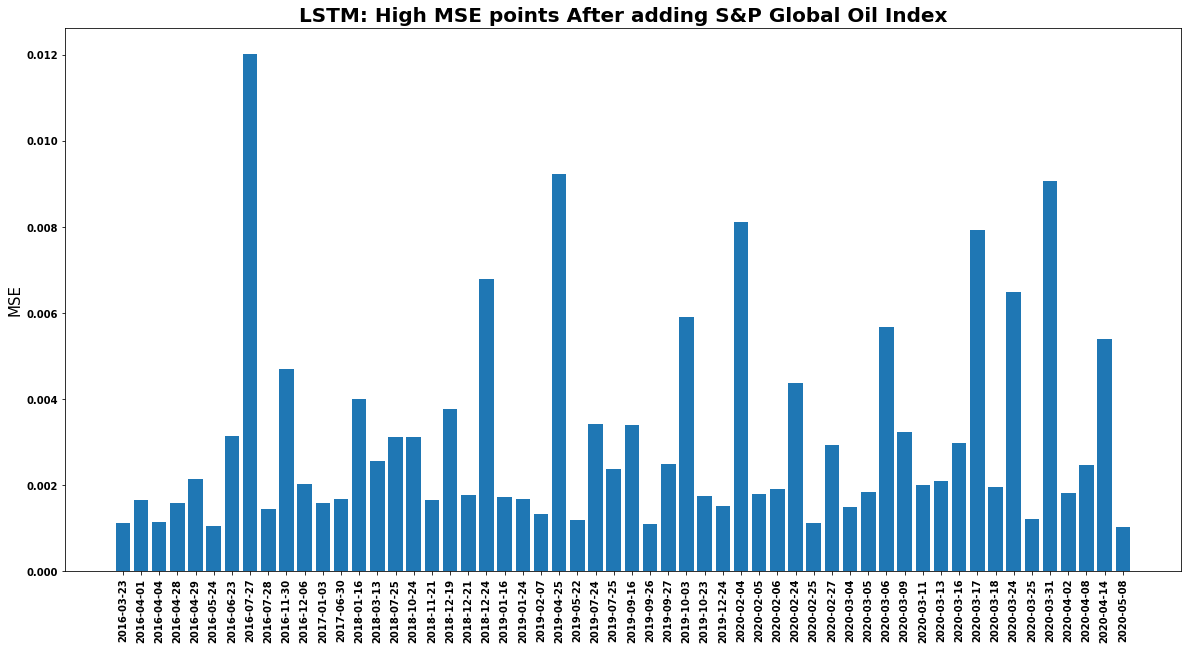

In [253]:
def evaluate_model(y_predicted,y_actual,dates):

    plt.figure(figsize=(20,10))
    plt.title('LSTM: Plot of High Prices vs. Date After adding S&P Global Oil Index',fontsize=20,fontweight='bold')
    plt.xlabel('Date',fontsize=15)
    plt.ylabel('High Prices',fontsize=15)
    plt.plot((y_actual.reshape(-1,1)), label="Actual")#,color='red')
    plt.plot(y_predicted.reshape(-1,1), label="Prediction", alpha=0.8)#,color ='black')
    index = np.arange((len(y_predicted)-1),step=90)
    plt.xticks(index,dates[index],fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize="xx-large")

 
#Rescaling the high values from range 0-1 to original values:
actual= scaler.inverse_transform(np.array(actual_high).reshape(-1,1))
predicted = scaler.inverse_transform(np.array(predicted_high).reshape(-1,1))
evaluate_model(predicted,actual,np.array(predicted_dates))

print("time taken for execution : %s seconds " % (time_taken))
print('Mean Validation loss=', round(mean(model_val_loss),8)) 
print('Mean Model loss=', round(mean(model_loss),8))


large_loss = []
large_loss_date = []  
for index in range(0,len(model_val_loss)):
    val_loss = model_val_loss[index]
    if val_loss>0.001:
        large_loss.append(val_loss)
        large_loss_date.append(predicted_dates[index])


plt.rcParams["font.weight"] = "bold"
plt.figure(figsize=(20,10))
plt.title('LSTM: High MSE points After adding S&P Global Oil Index',fontsize=20,fontweight='bold')
plt.ylabel('MSE',fontsize=15)
idx = np.arange(len(large_loss_date))
plt.xticks(idx,large_loss_date,rotation=90)
plt.bar(idx, large_loss, align='center', alpha=1)

# 5. S&P 1000:

In [49]:
 sp1000 = pd.read_csv('/Users/aleenaalex/Documents/UCC projects/data/S&P 1000.csv', 
                      header=0, index_col=0)
#df1 = df.ix[:, 'a':'b']
#sp1000 = sp1000[['S&P 1000']]
#sp1000 =(sp1000[1249:2508])
sp1000
#sp1000.to_csv('/Users/aleenaalex/Documents/UCC projects/data/S&P 1000.csv', encoding='utf-8')#index=False)

S&P 1000
Effective date           
15/05/15          8627.79
18/05/15          8701.63
19/05/15          8689.52
20/05/15          8692.93
21/05/15          8697.50
...                   ...
08/05/20          9409.29
11/05/20          9309.29
12/05/20          8976.31
13/05/20          8661.19
14/05/20          8736.09

[1259 rows x 1 columns]

In [50]:
#Convert Date Format:
sp = []
sp = list(sp1000.index)
newdt = []
newsp = []

for idx in range(0,len(sp)): 
    spindex = sp[idx]
    year,month,day = '20'+spindex[6:],spindex[3:5],spindex[0:2]
    newdt.append(year+'-'+month+'-'+day)

sp1000.insert(1, "FormatDate", newdt)
sp1000

S&P 1000  FormatDate
Effective date                       
15/05/15          8627.79  2015-05-15
18/05/15          8701.63  2015-05-18
19/05/15          8689.52  2015-05-19
20/05/15          8692.93  2015-05-20
21/05/15          8697.50  2015-05-21
...                   ...         ...
08/05/20          9409.29  2020-05-08
11/05/20          9309.29  2020-05-11
12/05/20          8976.31  2020-05-12
13/05/20          8661.19  2020-05-13
14/05/20          8736.09  2020-05-14

[1259 rows x 2 columns]

In [55]:
#merge values:
ford_dates = list(ford.index)
sp1000_dates = list(sp1000['FormatDate'])
mean_sp = mean(sp1000['S&P 1000'])
#print(mean_sp,len(ford_dates))
ford["S&P1000"] = mean_sp
for row_num in range(0,len(ford_dates)):
    date = ford_dates[row_num] 
    #print(date)
    if date in sp1000_dates:
        ford["S&P1000"][row_num] = mean((sp1000['S&P 1000'][sp1000['FormatDate']==date]))
    
ford

/Users/aleenaalex/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


Open   High    Low  Close  Adj Close     Volume  S&P1000
Date                                                                 
2015-05-15  15.27  15.49  15.27  15.48  11.977631   18937700  8627.79
2015-05-18  15.47  15.64  15.45  15.58  12.055005   19491900  8701.63
2015-05-19  15.59  15.63  15.45  15.50  11.993106   15145300  8689.52
2015-05-20  15.54  15.56  15.26  15.30  11.838357   22391500  8692.93
2015-05-21  15.28  15.55  15.26  15.51  12.000844   23962000  8697.50
...           ...    ...    ...    ...        ...        ...      ...
2020-05-08   4.96   5.25   4.95   5.24   5.240000  101333800  9409.29
2020-05-11   5.18   5.19   5.05   5.12   5.120000   75593900  9309.29
2020-05-12   5.15   5.22   4.97   4.98   4.980000   70965200  8976.31
2020-05-13   5.00   5.01   4.66   4.72   4.720000  100192300  8661.19
2020-05-14   4.64   4.92   4.52   4.89   4.890000  107931900  8736.09

[1259 rows x 7 columns]

In [56]:
def normalize(data):
    
    scaler_open = MinMaxScaler()
    scaler_high = MinMaxScaler()
    scaler_low = MinMaxScaler()
    scaler_close = MinMaxScaler()
    scaler_adjclose = MinMaxScaler()
    scaler_volume = MinMaxScaler()
    scaler_sp = MinMaxScaler()
    
    #Open:
    fit = scaler_open.fit(np.array(data['Open']).reshape(-1, 1))
    data['Open'] =scaler_open.transform(np.array(dataframe_ford['Open']).reshape(-1, 1))
    
    #High:
    fit = scaler_high.fit(np.array(data['High']).reshape(-1, 1))
    data['High'] =scaler_high.transform(np.array(data['High']).reshape(-1, 1))
    
    #Low:
    fit = scaler_low.fit(np.array(data['Low']).reshape(-1, 1))
    data['Low'] =scaler_low.transform(np.array(data['Low']).reshape(-1, 1))
    
    #Close:
    fit = scaler_close.fit(np.array(data['Close']).reshape(-1, 1))
    data['Close'] =scaler_close.transform(np.array(data['Close']).reshape(-1, 1))
    
    #AdjClose:
    fit = scaler_adjclose.fit(np.array(data['Adj Close']).reshape(-1, 1))
    data['Adj Close'] =scaler_adjclose.transform(np.array(data['Adj Close']).reshape(-1, 1))
    
    #High:
    fit = scaler_volume.fit(np.array(data['Volume']).reshape(-1, 1))
    data['Volume'] =scaler_volume.transform(np.array(data['Volume']).reshape(-1, 1))
    
    #Dow:
    fit = scaler_sp.fit(np.array(data['S&P1000']).reshape(-1, 1))
    data['S&P1000'] =scaler_sp.transform(np.array(data['S&P1000']).reshape(-1, 1))
    
    return data,scaler_high

df = ford
dataframe_ford = df
df,scaler = normalize(df)

#convert data: form X and y data:
Xarr = df.rename_axis('ID').values
Xarr = Xarr[0:1258]
Datearr = df.index.values

df1 = df[['High']]
yarr = df1.rename_axis('ID').values

print('Xarr:',Xarr[0:5])
print('yarr:',yarr[0:5])
print('Datearr:',Datearr[0:5])

yarr = np.delete(yarr, 0)
print('yarr:',yarr[0:5])
print('X shape:',Xarr.shape)
print('y shape:',yarr.shape)

def build_data(start,pw,window_size=200):
    
    X_train,X_test = Xarr[start:start+window_size],Xarr[start+window_size:start+window_size+pw]
    y_train,y_test = yarr[start:start+window_size],yarr[start+window_size:start+window_size+pw]
    Date_train,Date_test = Datearr[start:start+window_size],Datearr[start+window_size:start+window_size+pw]
    return X_train,X_test,y_train,y_test,Date_train,Date_test

trn_size = len(Xarr)

from numpy import array
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline
    
file_path = 'daily_mlp_model_weights.h5'
    
callback_checkpoint = ModelCheckpoint(filepath=file_path,
                                      monitor='val_loss',
                                      save_best_only=True,
                                      save_weights_only=True)
    
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
    
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3,
                              patience=5, min_lr=0.0009)
    
callbacks = [early_stopping, callback_checkpoint, reduce_lr]
    
tf.keras.backend.clear_session()
    
model_mlp = tf.keras.models.Sequential()
    
model_mlp.add(tf.keras.layers.Reshape((7,),input_shape=(7,)))
    
model_mlp.add(tf.keras.layers.Dense(200,activation='relu'))
    
model_mlp.add(tf.keras.layers.Dense(1,activation='linear'))
    
model_mlp.compile(optimizer='adam',loss='mse',metrics=['accuracy'])
    

Xarr: [[0.95986038 0.96935201 0.97416021 0.98286204 0.96620093 0.04988881
  0.32730689]
 [0.97731239 0.98248687 0.98966408 0.99143102 0.97558374 0.05236248
  0.34182067]
 [0.9877836  0.98161121 0.98966408 0.98457584 0.96807751 0.0329615
  0.33944036]
 [0.98342059 0.97548161 0.97329888 0.96743787 0.94931176 0.0653048
  0.34011062]
 [0.96073298 0.97460595 0.97329888 0.98543273 0.96901587 0.0723147
  0.34100889]]
yarr: [[0.96935201]
 [0.98248687]
 [0.98161121]
 [0.97548161]
 [0.97460595]]
Datearr: ['2015-05-15' '2015-05-18' '2015-05-19' '2015-05-20' '2015-05-21']
yarr: [0.98248687 0.98161121 0.97548161 0.97460595 0.97022767]
X shape: (1258, 7)
y shape: (1258,)


In [57]:
import time
from itertools import chain
start_time = time.time()

predicted_high = []
actual_high = []
predicted_dates = []
window = 200
model_loss = []
model_val_loss =[]

for trn in range(0,trn_size-window):
    X_train,X_test,y_train,y_test,Date_train,Date_test = build_data(trn,pw=1,window_size = window)
    print(trn)
    
    history = model_mlp.fit(X_train, y_train,verbose = 0, epochs=200,
                        validation_data=(X_test, y_test), callbacks=callbacks, 
                        shuffle=False)
    yhat = model_mlp.predict(X_test, verbose=0)
    yhat = list(chain.from_iterable(yhat)) 
    if len(predicted_high) == 0:
        predicted_high = yhat
        predicted_dates = Date_test.tolist()
        actual_high = y_test.tolist()
        model_loss.append(history.history['loss'][-1])
        model_val_loss.append(history.history['val_loss'][-1])
        
        
    else:
        beg=len(predicted_high)-len(yhat)+1
        yhat_idx = 0
        for pred_idx in range(beg,len(predicted_high)):
            predicted_high[pred_idx]= (predicted_high[pred_idx] + yhat[yhat_idx])/2
            yhat_idx+=1
        predicted_high.append(yhat[-1])
        actual_high.append(y_test[-1])
        predicted_dates.append(Date_test.tolist()[-1])
        model_loss.append(history.history['loss'][-1])
        model_val_loss.append(history.history['val_loss'][-1])
    
    
time_taken = time.time() - start_time
print(predicted_dates[0:5])
print(predicted_high[0:5])
print(actual_high[0:5])

0
Epoch 00023: early stopping
1
Epoch 00011: early stopping
2
Epoch 00168: early stopping
3
Epoch 00013: early stopping
4
Epoch 00012: early stopping
5
Epoch 00012: early stopping
6
Epoch 00012: early stopping
7
Epoch 00012: early stopping
8
9
Epoch 00012: early stopping
10
Epoch 00011: early stopping
11
12
Epoch 00014: early stopping
13
Epoch 00012: early stopping
14
Epoch 00011: early stopping
15
Epoch 00012: early stopping
16
Epoch 00011: early stopping
17
Epoch 00029: early stopping
18
Epoch 00013: early stopping
19
Epoch 00011: early stopping
20
Epoch 00013: early stopping
21
Epoch 00012: early stopping
22
Epoch 00116: early stopping
23
Epoch 00016: early stopping
24
Epoch 00018: early stopping
25
Epoch 00019: early stopping
26
Epoch 00018: early stopping
27
Epoch 00020: early stopping
28
Epoch 00028: early stopping
29
Epoch 00029: early stopping
30
Epoch 00018: early stopping
31
Epoch 00011: early stopping
32
Epoch 00014: early stopping
33
Epoch 00032: early stopping
34
Epoch 000

Epoch 00021: early stopping
263
Epoch 00021: early stopping
264
Epoch 00016: early stopping
265
Epoch 00027: early stopping
266
Epoch 00016: early stopping
267
Epoch 00036: early stopping
268
Epoch 00021: early stopping
269
Epoch 00014: early stopping
270
Epoch 00013: early stopping
271
Epoch 00035: early stopping
272
Epoch 00020: early stopping
273
Epoch 00081: early stopping
274
Epoch 00044: early stopping
275
Epoch 00015: early stopping
276
Epoch 00029: early stopping
277
Epoch 00028: early stopping
278
Epoch 00011: early stopping
279
Epoch 00013: early stopping
280
Epoch 00019: early stopping
281
Epoch 00014: early stopping
282
Epoch 00012: early stopping
283
Epoch 00016: early stopping
284
Epoch 00018: early stopping
285
Epoch 00013: early stopping
286
Epoch 00013: early stopping
287
Epoch 00037: early stopping
288
Epoch 00019: early stopping
289
Epoch 00039: early stopping
290
Epoch 00025: early stopping
291
Epoch 00041: early stopping
292
Epoch 00013: early stopping
293
Epoch 00

Epoch 00020: early stopping
521
Epoch 00021: early stopping
522
Epoch 00011: early stopping
523
Epoch 00013: early stopping
524
Epoch 00013: early stopping
525
Epoch 00019: early stopping
526
Epoch 00015: early stopping
527
Epoch 00011: early stopping
528
Epoch 00015: early stopping
529
Epoch 00011: early stopping
530
Epoch 00016: early stopping
531
Epoch 00012: early stopping
532
Epoch 00016: early stopping
533
Epoch 00014: early stopping
534
Epoch 00012: early stopping
535
Epoch 00014: early stopping
536
Epoch 00014: early stopping
537
Epoch 00041: early stopping
538
Epoch 00013: early stopping
539
Epoch 00013: early stopping
540
Epoch 00014: early stopping
541
Epoch 00038: early stopping
542
Epoch 00013: early stopping
543
Epoch 00014: early stopping
544
Epoch 00056: early stopping
545
Epoch 00015: early stopping
546
Epoch 00015: early stopping
547
Epoch 00013: early stopping
548
Epoch 00013: early stopping
549
Epoch 00011: early stopping
550
Epoch 00016: early stopping
551
Epoch 00

Epoch 00011: early stopping
778
Epoch 00013: early stopping
779
Epoch 00027: early stopping
780
Epoch 00015: early stopping
781
Epoch 00014: early stopping
782
Epoch 00014: early stopping
783
Epoch 00014: early stopping
784
Epoch 00014: early stopping
785
Epoch 00012: early stopping
786
Epoch 00021: early stopping
787
Epoch 00012: early stopping
788
Epoch 00013: early stopping
789
Epoch 00011: early stopping
790
Epoch 00013: early stopping
791
Epoch 00013: early stopping
792
Epoch 00013: early stopping
793
Epoch 00014: early stopping
794
Epoch 00013: early stopping
795
Epoch 00012: early stopping
796
Epoch 00052: early stopping
797
Epoch 00021: early stopping
798
Epoch 00016: early stopping
799
Epoch 00015: early stopping
800
Epoch 00018: early stopping
801
Epoch 00011: early stopping
802
Epoch 00012: early stopping
803
Epoch 00028: early stopping
804
Epoch 00016: early stopping
805
Epoch 00028: early stopping
806
Epoch 00025: early stopping
807
Epoch 00013: early stopping
808
Epoch 00

Epoch 00072: early stopping
1033
Epoch 00064: early stopping
1034
Epoch 00011: early stopping
1035
Epoch 00018: early stopping
1036
Epoch 00011: early stopping
1037
Epoch 00054: early stopping
1038
Epoch 00044: early stopping
1039
Epoch 00012: early stopping
1040
Epoch 00044: early stopping
1041
Epoch 00012: early stopping
1042
Epoch 00039: early stopping
1043
Epoch 00053: early stopping
1044
Epoch 00017: early stopping
1045
Epoch 00033: early stopping
1046
Epoch 00012: early stopping
1047
Epoch 00023: early stopping
1048
Epoch 00017: early stopping
1049
Epoch 00024: early stopping
1050
Epoch 00017: early stopping
1051
Epoch 00025: early stopping
1052
Epoch 00016: early stopping
1053
Epoch 00019: early stopping
1054
Epoch 00019: early stopping
1055
Epoch 00031: early stopping
1056
Epoch 00011: early stopping
1057
Epoch 00048: early stopping
['2016-03-02', '2016-03-03', '2016-03-04', '2016-03-07', '2016-03-08']
[0.7954879, 0.818826, 0.8240482, 0.82327056, 0.79864347]
[0.8047285464098073

time taken for execution : 262.400315284729 seconds 
Mean Validation loss= 0.00019874
Mean Model loss= 0.00014094


<BarContainer object of 35 artists>

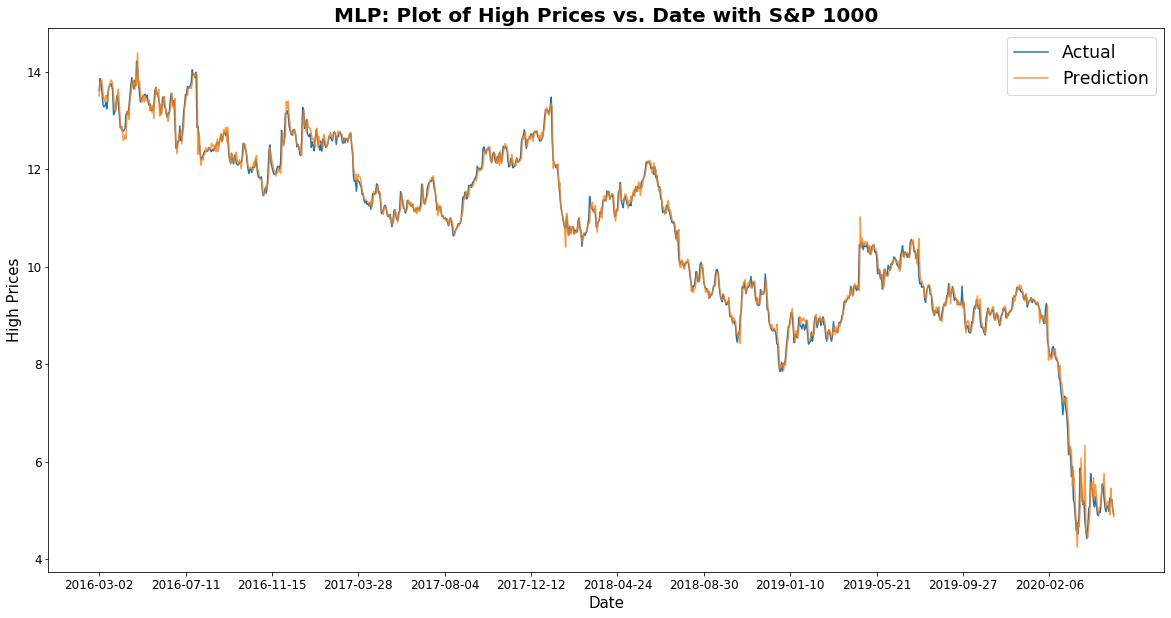

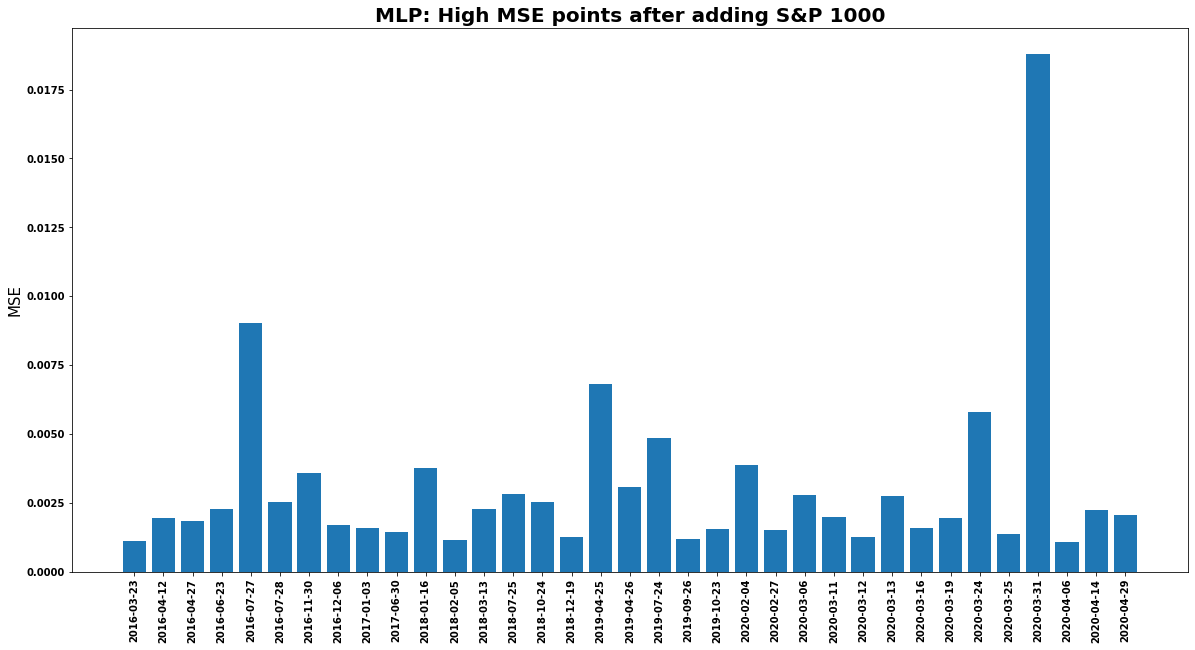

In [58]:
def evaluate_model(y_predicted,y_actual,dates):

    plt.figure(figsize=(20,10))
    plt.title('MLP: Plot of High Prices vs. Date with S&P 1000',fontsize=20,fontweight='bold')
    plt.xlabel('Date',fontsize=15)
    plt.ylabel('High Prices',fontsize=15)
    plt.plot((y_actual.reshape(-1,1)), label="Actual")#,color='red')
    plt.plot(y_predicted.reshape(-1,1), label="Prediction", alpha=0.8)#,color ='black')
    index = np.arange((len(y_predicted)-1),step=90)
    plt.xticks(index,dates[index],fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize="xx-large")
    #plt.savefig("LSTM.pdf")

 
#Rescaling the high values from range 0-1 to original values:
actual= scaler.inverse_transform(np.array(actual_high).reshape(-1,1))
predicted = scaler.inverse_transform(np.array(predicted_high).reshape(-1,1))
evaluate_model(predicted,actual,np.array(predicted_dates))

print("time taken for execution : %s seconds " % (time_taken))
print('Mean Validation loss=', round(mean(model_val_loss),8)) 
print('Mean Model loss=', round(mean(model_loss),8))


large_loss = []
large_loss_date = [] 
#print(f"{'index':10} {'val_loss':10} {'Date':12} {'Predicted High Value':10} {'Actual High Value':25}")     
for index in range(0,len(model_val_loss)):
    val_loss = model_val_loss[index]
    if val_loss>0.001:
        #print(f'{index:5} {val_loss:12f} {predicted_dates[index]:20} {predicted[index][0]:10f} {actual[index][0]:15f}')
        large_loss.append(val_loss)
        large_loss_date.append(predicted_dates[index])


plt.rcParams["font.weight"] = "bold"
plt.figure(figsize=(20,10))
plt.title('MLP: High MSE points after adding S&P 1000',fontsize=20,fontweight='bold')
plt.ylabel('MSE',fontsize=15)
idx = np.arange(len(large_loss_date))
plt.xticks(idx,large_loss_date,rotation=90)
plt.bar(idx, large_loss, align='center', alpha=1)

# 2. CNN -S&P 1000

In [59]:
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
import matplotlib.pyplot as plt
%matplotlib inline

file_path = 'daily_mlp_model_weights.h5'
    
callback_checkpoint = ModelCheckpoint(filepath=file_path,
                                      monitor='val_loss',
                                      save_best_only=True,
                                      save_weights_only=True)
    
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
    
callbacks = [early_stopping, callback_checkpoint]#, reduce_lr]

Xarr = Xarr.reshape((Xarr.shape[0], Xarr.shape[1], 1))
# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(7, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

#CNN Model window size =1:
import time
from itertools import chain
start_time = time.time()

predicted_high = []
actual_high = []
predicted_dates = []
window = 200
model_loss = []
model_val_loss =[]

for trn in range(0,trn_size-window):
    X_train,X_test,y_train,y_test,Date_train,Date_test = build_data(trn,pw=1,window_size = window)
    print(trn)
    
    history = model.fit(X_train, y_train,verbose = 0, epochs=200,
                        validation_data=(X_test, y_test), callbacks=callbacks, 
                        shuffle=False)
    yhat = model.predict(X_test, verbose=0)
    yhat = list(chain.from_iterable(yhat)) 
    if len(predicted_high) == 0:
        predicted_high = yhat
        predicted_dates = Date_test.tolist()
        actual_high = y_test.tolist()
        model_loss.append(history.history['loss'][-1])
        model_val_loss.append(history.history['val_loss'][-1])
        
        
    else:
        beg=len(predicted_high)-len(yhat)+1
        yhat_idx = 0
        for pred_idx in range(beg,len(predicted_high)):
            predicted_high[pred_idx]= (predicted_high[pred_idx] + yhat[yhat_idx])/2
            yhat_idx+=1
        predicted_high.append(yhat[-1])
        actual_high.append(y_test[-1])
        predicted_dates.append(Date_test.tolist()[-1])
        model_loss.append(history.history['loss'][-1])
        model_val_loss.append(history.history['val_loss'][-1])
    
    
time_taken = time.time() - start_time
print(predicted_dates[0:5])
print(predicted_high[0:5])
print(actual_high[0:5])

0
Epoch 00023: early stopping
1
Epoch 00011: early stopping
2
Epoch 00011: early stopping
3
Epoch 00011: early stopping
4
Epoch 00147: early stopping
5
Epoch 00014: early stopping
6
Epoch 00012: early stopping
7
Epoch 00110: early stopping
8
Epoch 00033: early stopping
9
Epoch 00022: early stopping
10
Epoch 00012: early stopping
11
Epoch 00020: early stopping
12
Epoch 00018: early stopping
13
Epoch 00028: early stopping
14
Epoch 00016: early stopping
15
Epoch 00011: early stopping
16
Epoch 00011: early stopping
17
Epoch 00093: early stopping
18
Epoch 00012: early stopping
19
Epoch 00011: early stopping
20
Epoch 00012: early stopping
21
Epoch 00011: early stopping
22
Epoch 00011: early stopping
23
Epoch 00021: early stopping
24
Epoch 00014: early stopping
25
Epoch 00014: early stopping
26
Epoch 00012: early stopping
27
Epoch 00012: early stopping
28
Epoch 00012: early stopping
29
Epoch 00020: early stopping
30
Epoch 00015: early stopping
31
Epoch 00024: early stopping
32
Epoch 00024: ea

Epoch 00024: early stopping
262
Epoch 00018: early stopping
263
Epoch 00032: early stopping
264
Epoch 00014: early stopping
265
Epoch 00013: early stopping
266
Epoch 00014: early stopping
267
Epoch 00059: early stopping
268
Epoch 00050: early stopping
269
Epoch 00012: early stopping
270
Epoch 00011: early stopping
271
Epoch 00014: early stopping
272
Epoch 00029: early stopping
273
Epoch 00018: early stopping
274
Epoch 00019: early stopping
275
Epoch 00011: early stopping
276
Epoch 00027: early stopping
277
Epoch 00014: early stopping
278
Epoch 00021: early stopping
279
Epoch 00013: early stopping
280
Epoch 00013: early stopping
281
Epoch 00046: early stopping
282
Epoch 00012: early stopping
283
Epoch 00012: early stopping
284
Epoch 00013: early stopping
285
Epoch 00027: early stopping
286
Epoch 00013: early stopping
287
Epoch 00013: early stopping
288
Epoch 00014: early stopping
289
Epoch 00012: early stopping
290
Epoch 00013: early stopping
291
Epoch 00011: early stopping
292
Epoch 00

Epoch 00029: early stopping
519
Epoch 00018: early stopping
520
Epoch 00028: early stopping
521
Epoch 00016: early stopping
522
Epoch 00011: early stopping
523
Epoch 00035: early stopping
524
Epoch 00013: early stopping
525
Epoch 00028: early stopping
526
Epoch 00029: early stopping
527
Epoch 00029: early stopping
528
Epoch 00014: early stopping
529
Epoch 00023: early stopping
530
Epoch 00014: early stopping
531
Epoch 00020: early stopping
532
Epoch 00019: early stopping
533
Epoch 00013: early stopping
534
Epoch 00030: early stopping
535
Epoch 00016: early stopping
536
Epoch 00012: early stopping
537
Epoch 00017: early stopping
538
Epoch 00025: early stopping
539
Epoch 00018: early stopping
540
Epoch 00015: early stopping
541
Epoch 00022: early stopping
542
Epoch 00016: early stopping
543
Epoch 00011: early stopping
544
Epoch 00017: early stopping
545
Epoch 00012: early stopping
546
Epoch 00016: early stopping
547
Epoch 00024: early stopping
548
Epoch 00014: early stopping
549
Epoch 00

Epoch 00013: early stopping
777
Epoch 00015: early stopping
778
Epoch 00017: early stopping
779
Epoch 00011: early stopping
780
Epoch 00012: early stopping
781
Epoch 00013: early stopping
782
Epoch 00025: early stopping
783
Epoch 00014: early stopping
784
Epoch 00025: early stopping
785
Epoch 00016: early stopping
786
Epoch 00014: early stopping
787
Epoch 00034: early stopping
788
Epoch 00027: early stopping
789
Epoch 00012: early stopping
790
Epoch 00019: early stopping
791
Epoch 00026: early stopping
792
Epoch 00013: early stopping
793
Epoch 00015: early stopping
794
Epoch 00019: early stopping
795
Epoch 00021: early stopping
796
Epoch 00082: early stopping
797
Epoch 00015: early stopping
798
Epoch 00016: early stopping
799
Epoch 00032: early stopping
800
Epoch 00018: early stopping
801
Epoch 00013: early stopping
802
Epoch 00011: early stopping
803
Epoch 00035: early stopping
804
Epoch 00012: early stopping
805
Epoch 00013: early stopping
806
Epoch 00024: early stopping
807
Epoch 00

Epoch 00035: early stopping
1034
Epoch 00012: early stopping
1035
Epoch 00015: early stopping
1036
Epoch 00011: early stopping
1037
Epoch 00038: early stopping
1038
Epoch 00013: early stopping
1039
Epoch 00011: early stopping
1040
Epoch 00012: early stopping
1041
Epoch 00012: early stopping
1042
Epoch 00027: early stopping
1043
Epoch 00018: early stopping
1044
Epoch 00011: early stopping
1045
Epoch 00030: early stopping
1046
Epoch 00011: early stopping
1047
Epoch 00025: early stopping
1048
Epoch 00034: early stopping
1049
Epoch 00012: early stopping
1050
Epoch 00011: early stopping
1051
Epoch 00030: early stopping
1052
Epoch 00064: early stopping
1053
Epoch 00011: early stopping
1054
Epoch 00085: early stopping
1055
Epoch 00011: early stopping
1056
Epoch 00011: early stopping
1057
Epoch 00011: early stopping
['2016-03-02', '2016-03-03', '2016-03-04', '2016-03-07', '2016-03-08']
[0.79406124, 0.81476575, 0.8251031, 0.826783, 0.79824454]
[0.8047285464098073, 0.8266199649737302, 0.81611208

time taken for execution : 138.76243686676025 seconds 
Mean Validation loss= 0.00022989
Mean Model loss= 0.00013698


<BarContainer object of 45 artists>

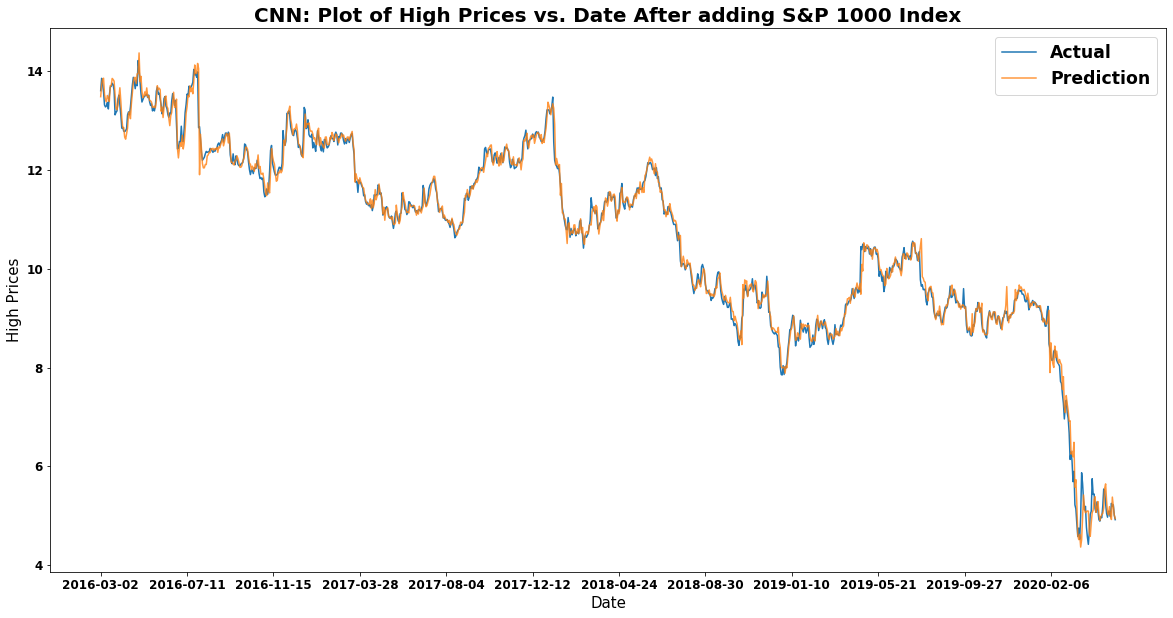

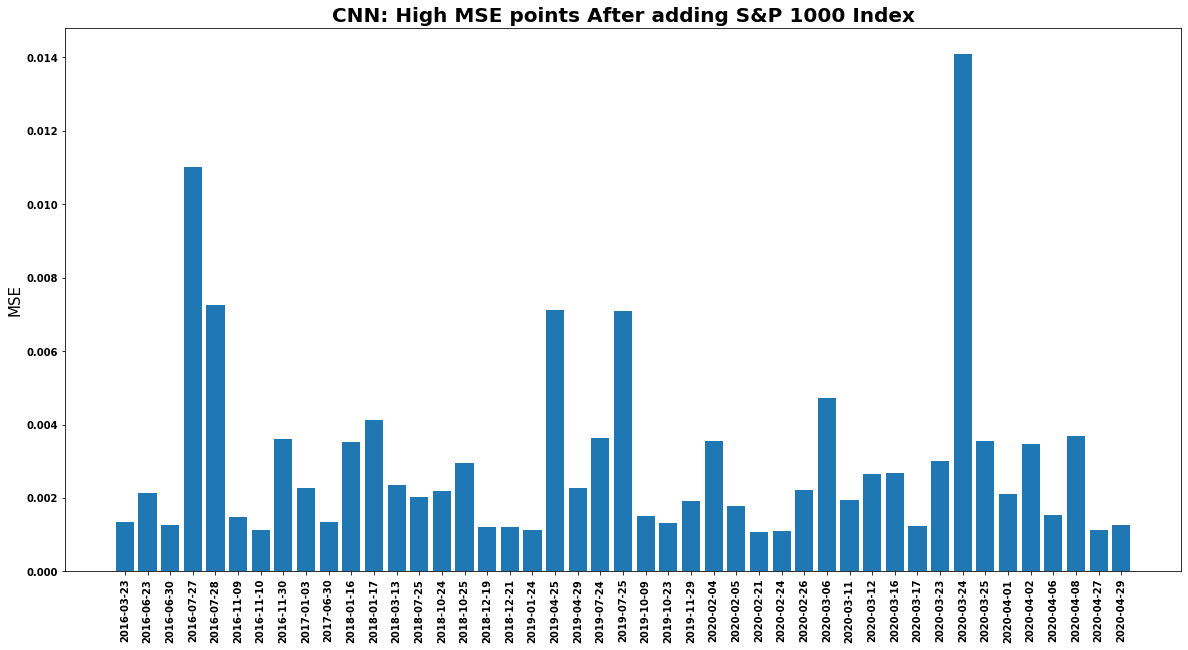

In [60]:
def evaluate_model(y_predicted,y_actual,dates):

    plt.figure(figsize=(20,10))
    plt.title('CNN: Plot of High Prices vs. Date After adding S&P 1000 Index',fontsize=20,fontweight='bold')
    plt.xlabel('Date',fontsize=15)
    plt.ylabel('High Prices',fontsize=15)
    plt.plot((y_actual.reshape(-1,1)), label="Actual")#,color='red')
    plt.plot(y_predicted.reshape(-1,1), label="Prediction", alpha=0.8)#,color ='black')
    index = np.arange((len(y_predicted)-1),step=90)
    plt.xticks(index,dates[index],fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize="xx-large")

 
#Rescaling the high values from range 0-1 to original values:
actual= scaler.inverse_transform(np.array(actual_high).reshape(-1,1))
predicted = scaler.inverse_transform(np.array(predicted_high).reshape(-1,1))
evaluate_model(predicted,actual,np.array(predicted_dates))

print("time taken for execution : %s seconds " % (time_taken))
print('Mean Validation loss=', round(mean(model_val_loss),8)) 
print('Mean Model loss=', round(mean(model_loss),8))


large_loss = []
large_loss_date = []  
for index in range(0,len(model_val_loss)):
    val_loss = model_val_loss[index]
    if val_loss>0.001:
        large_loss.append(val_loss)
        large_loss_date.append(predicted_dates[index])


plt.rcParams["font.weight"] = "bold"
plt.figure(figsize=(20,10))
plt.title('CNN: High MSE points After adding S&P 1000 Index',fontsize=20,fontweight='bold')
plt.ylabel('MSE',fontsize=15)
idx = np.arange(len(large_loss_date))
plt.xticks(idx,large_loss_date,rotation=90)
plt.bar(idx, large_loss, align='center', alpha=1)

# 3. LSTM : S&P 1000

In [61]:
file_path = 'daily_mlp_model_weights.h5'
    
callback_checkpoint = ModelCheckpoint(filepath=file_path,
                                      monitor='val_loss',
                                      save_best_only=True,
                                      save_weights_only=True)
    
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
    
#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3,patience=5, min_lr=0.0009)
    
callbacks = [early_stopping, callback_checkpoint]#, reduce_lr]
adam = Adam(lr=0.003)
model = Sequential()
model.add(LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(16))
model.add(Dense(1))
model.compile(loss='mse', optimizer=adam)

#window size =1:
import time
from itertools import chain
start_time = time.time()

predicted_high = []
actual_high = []
predicted_dates = []
window = 200
model_loss = []
model_val_loss =[]

for trn in range(0,trn_size-window):
    X_train,X_test,y_train,y_test,Date_train,Date_test = build_data(trn,pw=1,window_size = window)
    print(trn)
    
    history = model.fit(X_train, y_train,verbose = 0, epochs=200,
                        validation_data=(X_test, y_test), callbacks=callbacks, 
                        shuffle=False)
    yhat = model.predict(X_test, verbose=0)
    yhat = list(chain.from_iterable(yhat)) 
    if len(predicted_high) == 0:
        predicted_high = yhat
        predicted_dates = Date_test.tolist()
        actual_high = y_test.tolist()
        model_loss.append(history.history['loss'][-1])
        model_val_loss.append(history.history['val_loss'][-1])
        
        
    else:
        beg=len(predicted_high)-len(yhat)+1
        yhat_idx = 0
        for pred_idx in range(beg,len(predicted_high)):
            predicted_high[pred_idx]= (predicted_high[pred_idx] + yhat[yhat_idx])/2
            yhat_idx+=1
        predicted_high.append(yhat[-1])
        actual_high.append(y_test[-1])
        predicted_dates.append(Date_test.tolist()[-1])
        model_loss.append(history.history['loss'][-1])
        model_val_loss.append(history.history['val_loss'][-1])
    

0
Epoch 00023: early stopping
1
Epoch 00011: early stopping
2
Epoch 00080: early stopping
3
Epoch 00025: early stopping
4
Epoch 00012: early stopping
5
Epoch 00017: early stopping
6
Epoch 00011: early stopping
7
Epoch 00017: early stopping
8
Epoch 00018: early stopping
9
Epoch 00022: early stopping
10
Epoch 00011: early stopping
11
Epoch 00011: early stopping
12
Epoch 00024: early stopping
13
Epoch 00011: early stopping
14
Epoch 00022: early stopping
15
Epoch 00019: early stopping
16
Epoch 00022: early stopping
17
Epoch 00011: early stopping
18
Epoch 00029: early stopping
19
Epoch 00018: early stopping
20
Epoch 00038: early stopping
21
Epoch 00013: early stopping
22
Epoch 00013: early stopping
23
Epoch 00031: early stopping
24
Epoch 00019: early stopping
25
Epoch 00034: early stopping
26
Epoch 00017: early stopping
27
Epoch 00033: early stopping
28
Epoch 00011: early stopping
29
Epoch 00020: early stopping
30
Epoch 00031: early stopping
31
Epoch 00011: early stopping
32
Epoch 00024: ea

Epoch 00022: early stopping
261
Epoch 00012: early stopping
262
Epoch 00016: early stopping
263
Epoch 00017: early stopping
264
Epoch 00016: early stopping
265
Epoch 00026: early stopping
266
Epoch 00015: early stopping
267
Epoch 00058: early stopping
268
Epoch 00049: early stopping
269
Epoch 00014: early stopping
270
Epoch 00013: early stopping
271
Epoch 00049: early stopping
272
Epoch 00011: early stopping
273
Epoch 00060: early stopping
274
Epoch 00016: early stopping
275
Epoch 00016: early stopping
276
Epoch 00023: early stopping
277
Epoch 00012: early stopping
278
Epoch 00015: early stopping
279
Epoch 00020: early stopping
280
Epoch 00012: early stopping
281
Epoch 00037: early stopping
282
Epoch 00016: early stopping
283
Epoch 00015: early stopping
284
Epoch 00035: early stopping
285
Epoch 00013: early stopping
286
Epoch 00015: early stopping
287
Epoch 00031: early stopping
288
Epoch 00015: early stopping
289
Epoch 00046: early stopping
290
Epoch 00015: early stopping
291
Epoch 00

Epoch 00012: early stopping
518
Epoch 00035: early stopping
519
Epoch 00011: early stopping
520
Epoch 00024: early stopping
521
Epoch 00011: early stopping
522
Epoch 00014: early stopping
523
Epoch 00028: early stopping
524
Epoch 00011: early stopping
525
Epoch 00013: early stopping
526
Epoch 00033: early stopping
527
Epoch 00041: early stopping
528
Epoch 00041: early stopping
529
Epoch 00013: early stopping
530
Epoch 00025: early stopping
531
Epoch 00014: early stopping
532
Epoch 00012: early stopping
533
Epoch 00028: early stopping
534
Epoch 00015: early stopping
535
Epoch 00018: early stopping
536
Epoch 00036: early stopping
537
Epoch 00020: early stopping
538
Epoch 00015: early stopping
539
Epoch 00027: early stopping
540
Epoch 00023: early stopping
541
Epoch 00016: early stopping
542
Epoch 00014: early stopping
543
Epoch 00035: early stopping
544
Epoch 00018: early stopping
545
Epoch 00019: early stopping
546
Epoch 00013: early stopping
547
Epoch 00011: early stopping
548
Epoch 00

Epoch 00016: early stopping
775
Epoch 00020: early stopping
776
Epoch 00012: early stopping
777
Epoch 00020: early stopping
778
Epoch 00017: early stopping
779
Epoch 00022: early stopping
780
Epoch 00054: early stopping
781
Epoch 00036: early stopping
782
Epoch 00013: early stopping
783
Epoch 00012: early stopping
784
Epoch 00012: early stopping
785
Epoch 00038: early stopping
786
Epoch 00013: early stopping
787
Epoch 00019: early stopping
788
Epoch 00023: early stopping
789
Epoch 00051: early stopping
790
Epoch 00012: early stopping
791
Epoch 00012: early stopping
792
Epoch 00028: early stopping
793
Epoch 00018: early stopping
794
Epoch 00025: early stopping
795
Epoch 00014: early stopping
796
Epoch 00014: early stopping
797
Epoch 00023: early stopping
798
Epoch 00030: early stopping
799
Epoch 00017: early stopping
800
Epoch 00017: early stopping
801
Epoch 00019: early stopping
802
Epoch 00016: early stopping
803
Epoch 00019: early stopping
804
Epoch 00029: early stopping
805
Epoch 00

Epoch 00015: early stopping
1031
Epoch 00013: early stopping
1032
Epoch 00025: early stopping
1033
Epoch 00021: early stopping
1034
Epoch 00023: early stopping
1035
Epoch 00011: early stopping
1036
Epoch 00013: early stopping
1037
Epoch 00012: early stopping
1038
Epoch 00011: early stopping
1039
Epoch 00015: early stopping
1040
Epoch 00012: early stopping
1041
Epoch 00024: early stopping
1042
Epoch 00013: early stopping
1043
Epoch 00017: early stopping
1044
Epoch 00023: early stopping
1045
Epoch 00012: early stopping
1046
Epoch 00016: early stopping
1047
Epoch 00019: early stopping
1048
Epoch 00022: early stopping
1049
Epoch 00012: early stopping
1050
Epoch 00012: early stopping
1051
Epoch 00012: early stopping
1052
Epoch 00022: early stopping
1053
Epoch 00011: early stopping
1054
Epoch 00019: early stopping
1055
Epoch 00013: early stopping
1056
Epoch 00013: early stopping
1057
Epoch 00016: early stopping


time taken for execution : 138.76243686676025 seconds 
Mean Validation loss= 0.00032024
Mean Model loss= 0.00014381


<BarContainer object of 58 artists>

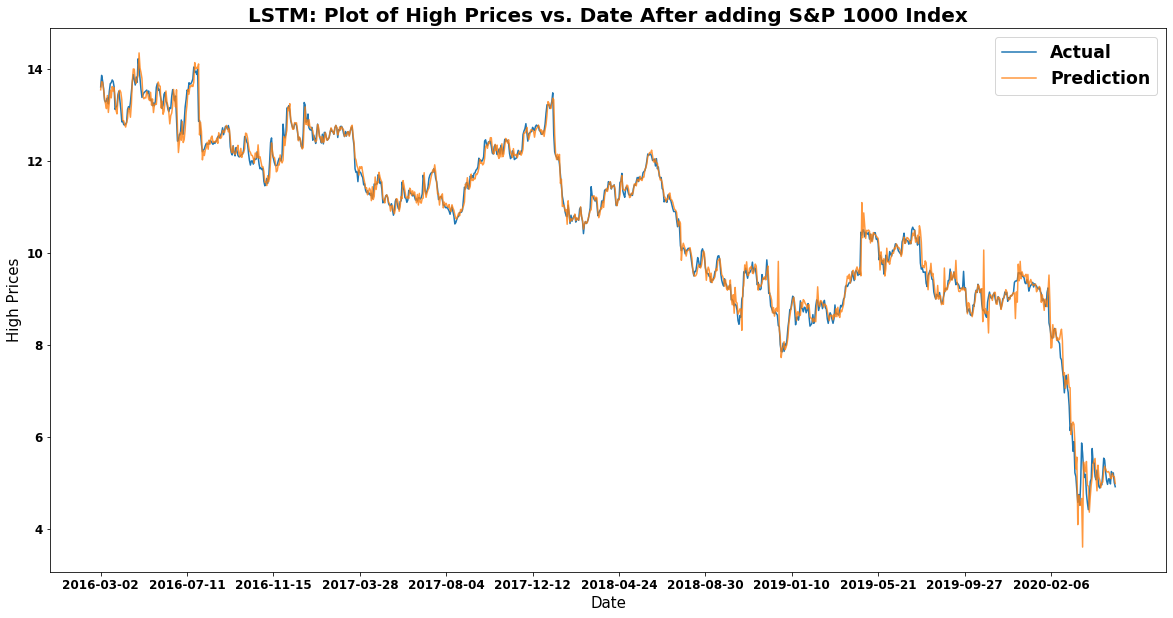

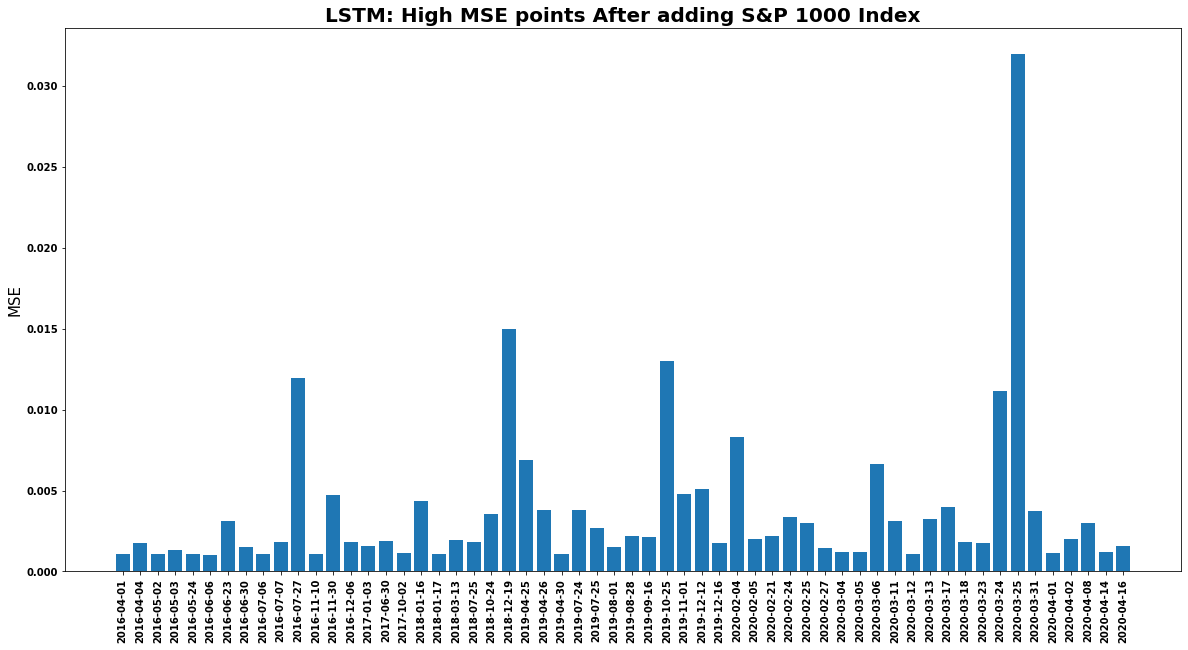

In [62]:
def evaluate_model(y_predicted,y_actual,dates):

    plt.figure(figsize=(20,10))
    plt.title('LSTM: Plot of High Prices vs. Date After adding S&P 1000 Index',fontsize=20,fontweight='bold')
    plt.xlabel('Date',fontsize=15)
    plt.ylabel('High Prices',fontsize=15)
    plt.plot((y_actual.reshape(-1,1)), label="Actual")#,color='red')
    plt.plot(y_predicted.reshape(-1,1), label="Prediction", alpha=0.8)#,color ='black')
    index = np.arange((len(y_predicted)-1),step=90)
    plt.xticks(index,dates[index],fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize="xx-large")

 
#Rescaling the high values from range 0-1 to original values:
actual= scaler.inverse_transform(np.array(actual_high).reshape(-1,1))
predicted = scaler.inverse_transform(np.array(predicted_high).reshape(-1,1))
evaluate_model(predicted,actual,np.array(predicted_dates))

print("time taken for execution : %s seconds " % (time_taken))
print('Mean Validation loss=', round(mean(model_val_loss),8)) 
print('Mean Model loss=', round(mean(model_loss),8))


large_loss = []
large_loss_date = []  
for index in range(0,len(model_val_loss)):
    val_loss = model_val_loss[index]
    if val_loss>0.001:
        large_loss.append(val_loss)
        large_loss_date.append(predicted_dates[index])


plt.rcParams["font.weight"] = "bold"
plt.figure(figsize=(20,10))
plt.title('LSTM: High MSE points After adding S&P 1000 Index',fontsize=20,fontweight='bold')
plt.ylabel('MSE',fontsize=15)
idx = np.arange(len(large_loss_date))
plt.xticks(idx,large_loss_date,rotation=90)
plt.bar(idx, large_loss, align='center', alpha=1)

# 8. Adding Crude Oil Prices:

In [27]:
crude_oil = pd.read_csv('/Users/aleenaalex/Documents/UCC projects/data/CrudeOilPrices.csv', 
                      header=0, index_col=0)
#df1 = df.ix[:, 'a':'b']
#glb_oil = glb_oil[['Price']]
#glb_oil =(glb_oil[36:1355])
crude_oil 
#glb_oil.to_csv('/Users/aleenaalex/Documents/UCC projects/data/CrudeOilPrices.csv', encoding='utf-8')#index=False)

Price
Date                
May 14, 2020   27.56
May 13, 2020   25.29
May 12, 2020   25.78
May 11, 2020   24.14
May 08, 2020   24.74
...              ...
May 21, 2015   60.72
May 20, 2015   58.98
May 19, 2015   57.26
May 18, 2015   59.43
May 15, 2015   59.69

[1319 rows x 1 columns]

In [35]:
#Convert Date Format:
Month_dict={'Jan':'01','Feb':'02','Mar':'03','Apr':'04','May':'05','Jun':'06',
       'Jul':'07','Aug':'08','Sep':'09','Oct':'10','Nov':'11','Dec':'12'}
cr_oil = []
cr_oil = list(crude_oil.index)
co1 = pd.DataFrame()
newdt = []
newoil = []
for idx in range(0,len(cr_oil)): 
    date = cr_oil[idx]
    day,month,year = date[4:6],Month_dict[date[0:3]],date[8:12]
    newdt.append(year+'-'+month+'-'+day)

crude_oil.insert(0, "FormatDate", newdt)
crude_oil


FormatDate  Price
Date                            
May 14, 2020   2020-05-14  27.56
May 13, 2020   2020-05-13  25.29
May 12, 2020   2020-05-12  25.78
May 11, 2020   2020-05-11  24.14
May 08, 2020   2020-05-08  24.74
...                   ...    ...
May 21, 2015   2015-05-21  60.72
May 20, 2015   2015-05-20  58.98
May 19, 2015   2015-05-19  57.26
May 18, 2015   2015-05-18  59.43
May 15, 2015   2015-05-15  59.69

[1319 rows x 2 columns]

In [38]:
#merge values:
ford_dates = list(ford.index)
cr_oil_dates = list(crude_oil['FormatDate'])
mean_cop = mean(crude_oil['Price'])
print(mean_cop,len(ford_dates))
ford["CrudeOil"] = mean_cop
for row_num in range(0,len(ford_dates)):
    date = ford_dates[row_num] 
    #print(date)
    if date in cr_oil_dates:
        ford["CrudeOil"][row_num] = mean((crude_oil['Price'][crude_oil['FormatDate']==date]))
    
ford

52.015504169825626 1259


/Users/aleenaalex/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


Open   High    Low  Close  Adj Close     Volume  CrudeOil
Date                                                                  
2015-05-15  15.27  15.49  15.27  15.48  11.977631   18937700     59.69
2015-05-18  15.47  15.64  15.45  15.58  12.055005   19491900     59.43
2015-05-19  15.59  15.63  15.45  15.50  11.993106   15145300     57.26
2015-05-20  15.54  15.56  15.26  15.30  11.838357   22391500     58.98
2015-05-21  15.28  15.55  15.26  15.51  12.000844   23962000     60.72
...           ...    ...    ...    ...        ...        ...       ...
2020-05-08   4.96   5.25   4.95   5.24   5.240000  101333800     24.74
2020-05-11   5.18   5.19   5.05   5.12   5.120000   75593900     24.14
2020-05-12   5.15   5.22   4.97   4.98   4.980000   70965200     25.78
2020-05-13   5.00   5.01   4.66   4.72   4.720000  100192300     25.29
2020-05-14   4.64   4.92   4.52   4.89   4.890000  107931900     27.56

[1259 rows x 7 columns]

# 8.1. Crude Oil - MLP

In [39]:
def normalize(data):
    
    scaler_open = MinMaxScaler()
    scaler_high = MinMaxScaler()
    scaler_low = MinMaxScaler()
    scaler_close = MinMaxScaler()
    scaler_adjclose = MinMaxScaler()
    scaler_volume = MinMaxScaler()
    scaler_oil = MinMaxScaler()
    
    #Open:
    fit = scaler_open.fit(np.array(data['Open']).reshape(-1, 1))
    data['Open'] =scaler_open.transform(np.array(dataframe_ford['Open']).reshape(-1, 1))
    
    #High:
    fit = scaler_high.fit(np.array(data['High']).reshape(-1, 1))
    data['High'] =scaler_high.transform(np.array(data['High']).reshape(-1, 1))
    
    #Low:
    fit = scaler_low.fit(np.array(data['Low']).reshape(-1, 1))
    data['Low'] =scaler_low.transform(np.array(data['Low']).reshape(-1, 1))
    
    #Close:
    fit = scaler_close.fit(np.array(data['Close']).reshape(-1, 1))
    data['Close'] =scaler_close.transform(np.array(data['Close']).reshape(-1, 1))
    
    #AdjClose:
    fit = scaler_adjclose.fit(np.array(data['Adj Close']).reshape(-1, 1))
    data['Adj Close'] =scaler_adjclose.transform(np.array(data['Adj Close']).reshape(-1, 1))
    
    #High:
    fit = scaler_volume.fit(np.array(data['Volume']).reshape(-1, 1))
    data['Volume'] =scaler_volume.transform(np.array(data['Volume']).reshape(-1, 1))
    
    #Dow:
    fit = scaler_oil.fit(np.array(data['CrudeOil']).reshape(-1, 1))
    data['CrudeOil'] =scaler_oil.transform(np.array(data['CrudeOil']).reshape(-1, 1))
    
    return data,scaler_high

df = ford
dataframe_ford = df
df,scaler = normalize(df)

#convert data: form X and y data:
Xarr = df.rename_axis('ID').values
Xarr = Xarr[0:1258]
Datearr = df.index.values

df1 = df[['High']]
yarr = df1.rename_axis('ID').values

print('Xarr:',Xarr[0:5])
print('yarr:',yarr[0:5])
print('Datearr:',Datearr[0:5])

yarr = np.delete(yarr, 0)
print('yarr:',yarr[0:5])
print('X shape:',Xarr.shape)
print('y shape:',yarr.shape)

def build_data(start,pw,window_size=200):
    
    X_train,X_test = Xarr[start:start+window_size],Xarr[start+window_size:start+window_size+pw]
    y_train,y_test = yarr[start:start+window_size],yarr[start+window_size:start+window_size+pw]
    Date_train,Date_test = Datearr[start:start+window_size],Datearr[start+window_size:start+window_size+pw]
    return X_train,X_test,y_train,y_test,Date_train,Date_test

trn_size = len(Xarr)

from numpy import array
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline
    
file_path = 'daily_mlp_model_weights.h5'
    
callback_checkpoint = ModelCheckpoint(filepath=file_path,
                                      monitor='val_loss',
                                      save_best_only=True,
                                      save_weights_only=True)
    
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
    
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3,
                              patience=5, min_lr=0.0009)
    
callbacks = [early_stopping, callback_checkpoint, reduce_lr]
    
tf.keras.backend.clear_session()
    
model_mlp = tf.keras.models.Sequential()
    
model_mlp.add(tf.keras.layers.Reshape((7,),input_shape=(7,)))
    
model_mlp.add(tf.keras.layers.Dense(200,activation='relu'))
    
model_mlp.add(tf.keras.layers.Dense(1,activation='linear'))
    
model_mlp.compile(optimizer='adam',loss='mse',metrics=['accuracy'])
    

Xarr: [[0.95986038 0.96935201 0.97416021 0.98286204 0.96620093 0.04988881
  0.85338478]
 [0.97731239 0.98248687 0.98966408 0.99143102 0.97558374 0.05236248
  0.85110488]
 [0.9877836  0.98161121 0.98966408 0.98457584 0.96807751 0.0329615
  0.83207646]
 [0.98342059 0.97548161 0.97329888 0.96743787 0.94931176 0.0653048
  0.84715889]
 [0.96073298 0.97460595 0.97329888 0.98543273 0.96901587 0.0723147
  0.8624167 ]]
yarr: [[0.96935201]
 [0.98248687]
 [0.98161121]
 [0.97548161]
 [0.97460595]]
Datearr: ['2015-05-15' '2015-05-18' '2015-05-19' '2015-05-20' '2015-05-21']
yarr: [0.98248687 0.98161121 0.97548161 0.97460595 0.97022767]
X shape: (1258, 7)
y shape: (1258,)


In [40]:
import time
from itertools import chain
start_time = time.time()

predicted_high = []
actual_high = []
predicted_dates = []
window = 200
model_loss = []
model_val_loss =[]

for trn in range(0,trn_size-window):
    X_train,X_test,y_train,y_test,Date_train,Date_test = build_data(trn,pw=1,window_size = window)
    print(trn)
    
    history = model_mlp.fit(X_train, y_train,verbose = 0, epochs=200,
                        validation_data=(X_test, y_test), callbacks=callbacks, 
                        shuffle=False)
    yhat = model_mlp.predict(X_test, verbose=0)
    yhat = list(chain.from_iterable(yhat)) 
    if len(predicted_high) == 0:
        predicted_high = yhat
        predicted_dates = Date_test.tolist()
        actual_high = y_test.tolist()
        model_loss.append(history.history['loss'][-1])
        model_val_loss.append(history.history['val_loss'][-1])
        
        
    else:
        beg=len(predicted_high)-len(yhat)+1
        yhat_idx = 0
        for pred_idx in range(beg,len(predicted_high)):
            predicted_high[pred_idx]= (predicted_high[pred_idx] + yhat[yhat_idx])/2
            yhat_idx+=1
        predicted_high.append(yhat[-1])
        actual_high.append(y_test[-1])
        predicted_dates.append(Date_test.tolist()[-1])
        model_loss.append(history.history['loss'][-1])
        model_val_loss.append(history.history['val_loss'][-1])
    
    
time_taken = time.time() - start_time

0
Epoch 00018: early stopping
1
Epoch 00011: early stopping
2
Epoch 00011: early stopping
3
Epoch 00011: early stopping
4
Epoch 00012: early stopping
5
Epoch 00103: early stopping
6
Epoch 00011: early stopping
7
Epoch 00011: early stopping
8
Epoch 00011: early stopping
9
Epoch 00012: early stopping
10
Epoch 00030: early stopping
11
Epoch 00012: early stopping
12
Epoch 00012: early stopping
13
Epoch 00011: early stopping
14
Epoch 00011: early stopping
15
Epoch 00011: early stopping
16
Epoch 00011: early stopping
17
Epoch 00077: early stopping
18
Epoch 00012: early stopping
19
Epoch 00015: early stopping
20
Epoch 00012: early stopping
21
Epoch 00011: early stopping
22
Epoch 00011: early stopping
23
Epoch 00011: early stopping
24
Epoch 00014: early stopping
25
Epoch 00017: early stopping
26
Epoch 00012: early stopping
27
28
Epoch 00015: early stopping
29
Epoch 00015: early stopping
30
Epoch 00015: early stopping
31
Epoch 00011: early stopping
32
Epoch 00012: early stopping
33
Epoch 00011:

Epoch 00027: early stopping
262
Epoch 00021: early stopping
263
Epoch 00011: early stopping
264
Epoch 00011: early stopping
265
Epoch 00013: early stopping
266
Epoch 00015: early stopping
267
Epoch 00016: early stopping
268
Epoch 00033: early stopping
269
Epoch 00027: early stopping
270
Epoch 00022: early stopping
271
Epoch 00011: early stopping
272
Epoch 00035: early stopping
273
Epoch 00017: early stopping
274
Epoch 00013: early stopping
275
Epoch 00011: early stopping
276
Epoch 00041: early stopping
277
Epoch 00025: early stopping
278
Epoch 00015: early stopping
279
Epoch 00015: early stopping
280
Epoch 00022: early stopping
281
Epoch 00016: early stopping
282
Epoch 00015: early stopping
283
Epoch 00017: early stopping
284
Epoch 00022: early stopping
285
Epoch 00030: early stopping
286
Epoch 00020: early stopping
287
Epoch 00024: early stopping
288
Epoch 00015: early stopping
289
Epoch 00029: early stopping
290
Epoch 00026: early stopping
291
Epoch 00012: early stopping
292
Epoch 00

Epoch 00017: early stopping
519
Epoch 00015: early stopping
520
Epoch 00022: early stopping
521
Epoch 00025: early stopping
522
Epoch 00013: early stopping
523
Epoch 00021: early stopping
524
Epoch 00032: early stopping
525
Epoch 00012: early stopping
526
Epoch 00014: early stopping
527
Epoch 00011: early stopping
528
Epoch 00020: early stopping
529
Epoch 00017: early stopping
530
Epoch 00014: early stopping
531
Epoch 00021: early stopping
532
Epoch 00014: early stopping
533
Epoch 00013: early stopping
534
Epoch 00021: early stopping
535
Epoch 00026: early stopping
536
Epoch 00013: early stopping
537
Epoch 00017: early stopping
538
Epoch 00013: early stopping
539
Epoch 00022: early stopping
540
Epoch 00034: early stopping
541
Epoch 00015: early stopping
542
Epoch 00020: early stopping
543
Epoch 00030: early stopping
544
Epoch 00018: early stopping
545
Epoch 00014: early stopping
546
Epoch 00031: early stopping
547
Epoch 00013: early stopping
548
Epoch 00013: early stopping
549
Epoch 00

Epoch 00014: early stopping
777
Epoch 00039: early stopping
778
Epoch 00013: early stopping
779
Epoch 00037: early stopping
780
Epoch 00014: early stopping
781
Epoch 00015: early stopping
782
Epoch 00014: early stopping
783
Epoch 00036: early stopping
784
Epoch 00014: early stopping
785
Epoch 00044: early stopping
786
Epoch 00015: early stopping
787
Epoch 00017: early stopping
788
Epoch 00029: early stopping
789
Epoch 00013: early stopping
790
Epoch 00016: early stopping
791
Epoch 00038: early stopping
792
Epoch 00011: early stopping
793
Epoch 00013: early stopping
794
Epoch 00047: early stopping
795
Epoch 00016: early stopping
796
Epoch 00023: early stopping
797
Epoch 00012: early stopping
798
Epoch 00022: early stopping
799
Epoch 00028: early stopping
800
Epoch 00016: early stopping
801
Epoch 00015: early stopping
802
Epoch 00056: early stopping
803
Epoch 00020: early stopping
804
Epoch 00016: early stopping
805
Epoch 00014: early stopping
806
Epoch 00015: early stopping
807
Epoch 00

Epoch 00012: early stopping
1033
Epoch 00048: early stopping
1034
Epoch 00011: early stopping
1035
Epoch 00018: early stopping
1036
Epoch 00011: early stopping
1037
Epoch 00069: early stopping
1038
Epoch 00011: early stopping
1039
Epoch 00011: early stopping
1040
Epoch 00011: early stopping
1041
Epoch 00046: early stopping
1042
Epoch 00040: early stopping
1043
Epoch 00015: early stopping
1044
Epoch 00011: early stopping
1045
Epoch 00028: early stopping
1046
Epoch 00015: early stopping
1047
Epoch 00019: early stopping
1048
Epoch 00012: early stopping
1049
Epoch 00024: early stopping
1050
Epoch 00029: early stopping
1051
Epoch 00012: early stopping
1052
Epoch 00036: early stopping
1053
Epoch 00011: early stopping
1054
Epoch 00027: early stopping
1055
Epoch 00019: early stopping
1056
Epoch 00012: early stopping
1057
Epoch 00042: early stopping


time taken for execution : 136.69256496429443 seconds 
Mean Validation loss= 0.00022003
Mean Model loss= 0.00014005


<BarContainer object of 45 artists>

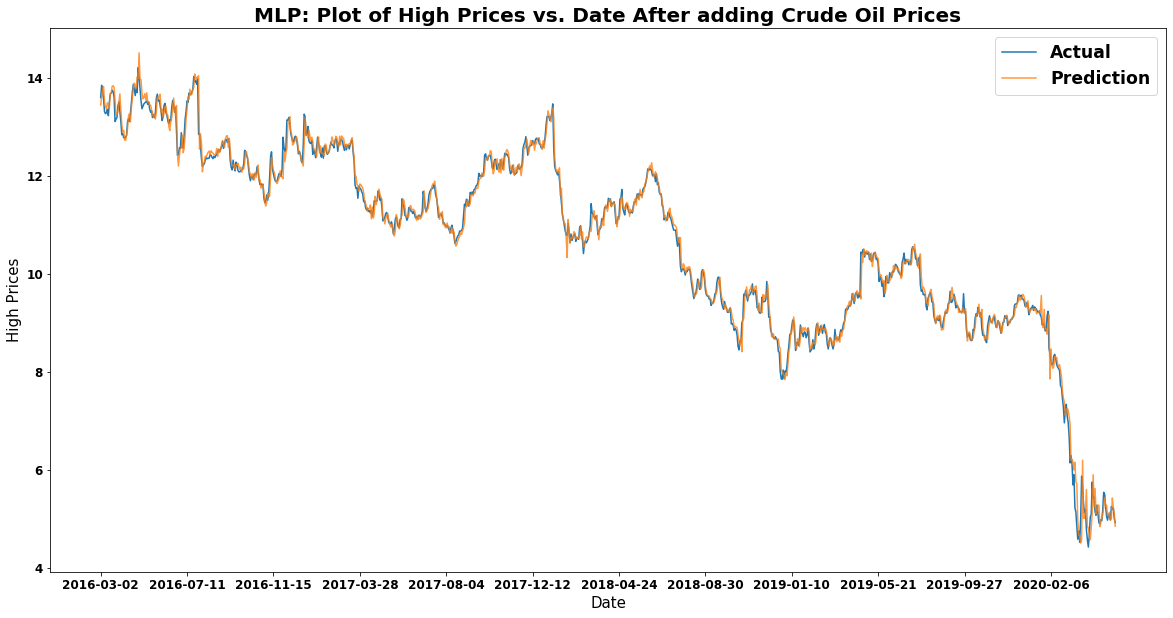

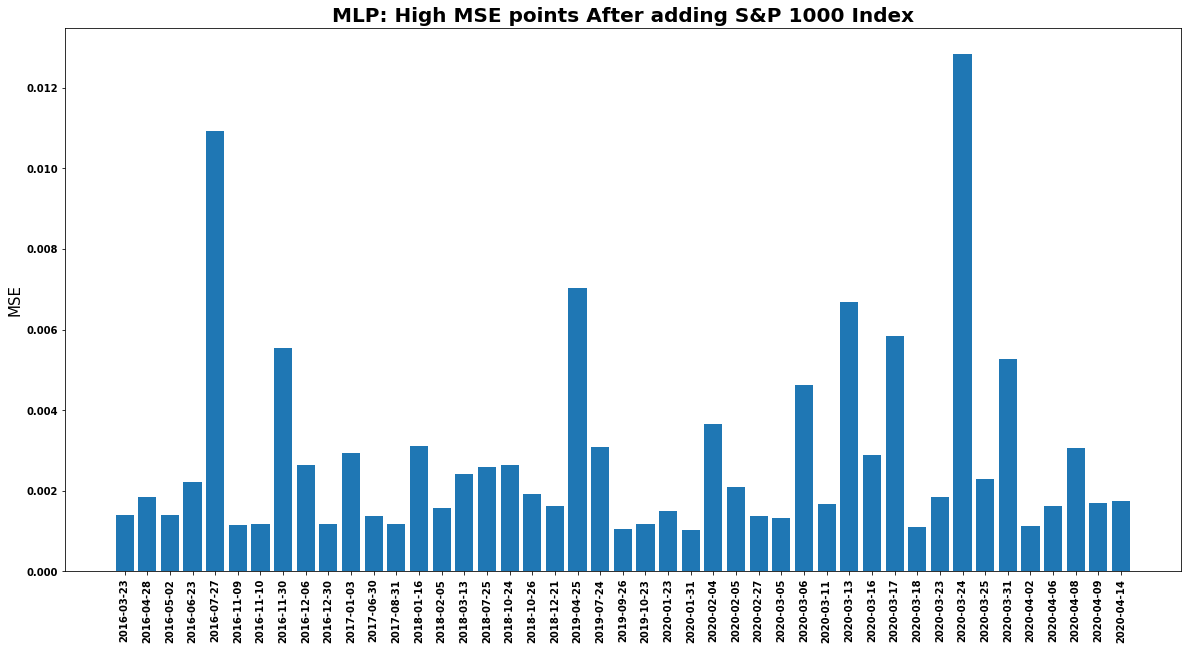

In [44]:
def evaluate_model(y_predicted,y_actual,dates):

    plt.figure(figsize=(20,10))
    plt.title('MLP: Plot of High Prices vs. Date After adding Crude Oil Prices',fontsize=20,fontweight='bold')
    plt.xlabel('Date',fontsize=15)
    plt.ylabel('High Prices',fontsize=15)
    plt.plot((y_actual.reshape(-1,1)), label="Actual")#,color='red')
    plt.plot(y_predicted.reshape(-1,1), label="Prediction", alpha=0.8)#,color ='black')
    index = np.arange((len(y_predicted)-1),step=90)
    plt.xticks(index,dates[index],fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize="xx-large")

 
#Rescaling the high values from range 0-1 to original values:
actual= scaler.inverse_transform(np.array(actual_high).reshape(-1,1))
predicted = scaler.inverse_transform(np.array(predicted_high).reshape(-1,1))
evaluate_model(predicted,actual,np.array(predicted_dates))

print("time taken for execution : %s seconds " % (time_taken))
print('Mean Validation loss=', round(mean(model_val_loss),8)) 
print('Mean Model loss=', round(mean(model_loss),8))


large_loss = []
large_loss_date = []  
for index in range(0,len(model_val_loss)):
    val_loss = model_val_loss[index]
    if val_loss>0.001:
        large_loss.append(val_loss)
        large_loss_date.append(predicted_dates[index])


plt.rcParams["font.weight"] = "bold"
plt.figure(figsize=(20,10))
plt.title('MLP: High MSE points After adding S&P 1000 Index',fontsize=20,fontweight='bold')
plt.ylabel('MSE',fontsize=15)
idx = np.arange(len(large_loss_date))
plt.xticks(idx,large_loss_date,rotation=90)
plt.bar(idx, large_loss, align='center', alpha=1)

# 8.2. Crude Oil - CNN:

In [42]:
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
import matplotlib.pyplot as plt
%matplotlib inline

file_path = 'daily_mlp_model_weights.h5'
    
callback_checkpoint = ModelCheckpoint(filepath=file_path,
                                      monitor='val_loss',
                                      save_best_only=True,
                                      save_weights_only=True)
    
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
    
callbacks = [early_stopping, callback_checkpoint]#, reduce_lr]

Xarr = Xarr.reshape((Xarr.shape[0], Xarr.shape[1], 1))
# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(7, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

#CNN Model window size =1:
import time
from itertools import chain
start_time = time.time()

predicted_high = []
actual_high = []
predicted_dates = []
window = 200
model_loss = []
model_val_loss =[]

for trn in range(0,trn_size-window):
    X_train,X_test,y_train,y_test,Date_train,Date_test = build_data(trn,pw=1,window_size = window)
    print(trn)
    
    history = model.fit(X_train, y_train,verbose = 0, epochs=200,
                        validation_data=(X_test, y_test), callbacks=callbacks, 
                        shuffle=False)
    yhat = model.predict(X_test, verbose=0)
    yhat = list(chain.from_iterable(yhat)) 
    if len(predicted_high) == 0:
        predicted_high = yhat
        predicted_dates = Date_test.tolist()
        actual_high = y_test.tolist()
        model_loss.append(history.history['loss'][-1])
        model_val_loss.append(history.history['val_loss'][-1])
        
        
    else:
        beg=len(predicted_high)-len(yhat)+1
        yhat_idx = 0
        for pred_idx in range(beg,len(predicted_high)):
            predicted_high[pred_idx]= (predicted_high[pred_idx] + yhat[yhat_idx])/2
            yhat_idx+=1
        predicted_high.append(yhat[-1])
        actual_high.append(y_test[-1])
        predicted_dates.append(Date_test.tolist()[-1])
        model_loss.append(history.history['loss'][-1])
        model_val_loss.append(history.history['val_loss'][-1])
    
    
time_taken = time.time() - start_time
print(predicted_dates[0:5])
print(predicted_high[0:5])
print(actual_high[0:5])

0
Epoch 00022: early stopping
1
Epoch 00012: early stopping
2
Epoch 00011: early stopping
3
Epoch 00011: early stopping
4
5
Epoch 00117: early stopping
6
Epoch 00011: early stopping
7
Epoch 00011: early stopping
8
Epoch 00011: early stopping
9
Epoch 00012: early stopping
10
Epoch 00020: early stopping
11
Epoch 00012: early stopping
12
Epoch 00012: early stopping
13
Epoch 00012: early stopping
14
Epoch 00011: early stopping
15
Epoch 00011: early stopping
16
Epoch 00011: early stopping
17
Epoch 00172: early stopping
18
Epoch 00013: early stopping
19
Epoch 00016: early stopping
20
Epoch 00013: early stopping
21
Epoch 00012: early stopping
22
Epoch 00012: early stopping
23
Epoch 00011: early stopping
24
Epoch 00014: early stopping
25
Epoch 00014: early stopping
26
Epoch 00012: early stopping
27
Epoch 00181: early stopping
28
Epoch 00015: early stopping
29
Epoch 00015: early stopping
30
Epoch 00015: early stopping
31
Epoch 00011: early stopping
32
Epoch 00011: early stopping
33
Epoch 00011:

Epoch 00017: early stopping
263
Epoch 00013: early stopping
264
Epoch 00012: early stopping
265
Epoch 00012: early stopping
266
Epoch 00011: early stopping
267
Epoch 00046: early stopping
268
Epoch 00017: early stopping
269
Epoch 00016: early stopping
270
Epoch 00015: early stopping
271
Epoch 00012: early stopping
272
Epoch 00022: early stopping
273
Epoch 00045: early stopping
274
Epoch 00011: early stopping
275
Epoch 00029: early stopping
276
Epoch 00058: early stopping
277
Epoch 00027: early stopping
278
Epoch 00011: early stopping
279
Epoch 00014: early stopping
280
Epoch 00016: early stopping
281
Epoch 00012: early stopping
282
Epoch 00014: early stopping
283
Epoch 00013: early stopping
284
Epoch 00014: early stopping
285
Epoch 00013: early stopping
286
Epoch 00015: early stopping
287
Epoch 00017: early stopping
288
Epoch 00030: early stopping
289
Epoch 00014: early stopping
290
Epoch 00015: early stopping
291
Epoch 00017: early stopping
292
Epoch 00014: early stopping
293
Epoch 00

Epoch 00035: early stopping
521
Epoch 00041: early stopping
522
Epoch 00016: early stopping
523
Epoch 00013: early stopping
524
Epoch 00024: early stopping
525
Epoch 00016: early stopping
526
Epoch 00017: early stopping
527
Epoch 00011: early stopping
528
Epoch 00012: early stopping
529
Epoch 00036: early stopping
530
Epoch 00018: early stopping
531
Epoch 00013: early stopping
532
Epoch 00028: early stopping
533
Epoch 00012: early stopping
534
Epoch 00013: early stopping
535
Epoch 00023: early stopping
536
Epoch 00025: early stopping
537
Epoch 00015: early stopping
538
Epoch 00013: early stopping
539
Epoch 00026: early stopping
540
Epoch 00016: early stopping
541
Epoch 00015: early stopping
542
Epoch 00026: early stopping
543
Epoch 00014: early stopping
544
Epoch 00013: early stopping
545
Epoch 00013: early stopping
546
Epoch 00015: early stopping
547
Epoch 00018: early stopping
548
Epoch 00012: early stopping
549
Epoch 00020: early stopping
550
Epoch 00015: early stopping
551
Epoch 00

Epoch 00011: early stopping
780
Epoch 00011: early stopping
781
Epoch 00012: early stopping
782
Epoch 00013: early stopping
783
Epoch 00013: early stopping
784
Epoch 00017: early stopping
785
Epoch 00020: early stopping
786
Epoch 00013: early stopping
787
Epoch 00015: early stopping
788
Epoch 00021: early stopping
789
Epoch 00035: early stopping
790
Epoch 00012: early stopping
791
Epoch 00013: early stopping
792
Epoch 00012: early stopping
793
Epoch 00026: early stopping
794
Epoch 00014: early stopping
795
Epoch 00103: early stopping
796
Epoch 00024: early stopping
797
Epoch 00018: early stopping
798
Epoch 00012: early stopping
799
Epoch 00016: early stopping
800
Epoch 00021: early stopping
801
Epoch 00013: early stopping
802
Epoch 00012: early stopping
803
Epoch 00012: early stopping
804
Epoch 00011: early stopping
805
Epoch 00013: early stopping
806
Epoch 00024: early stopping
807
Epoch 00012: early stopping
808
Epoch 00012: early stopping
809
Epoch 00018: early stopping
810
Epoch 00

Epoch 00015: early stopping
1036
Epoch 00011: early stopping
1037
Epoch 00052: early stopping
1038
Epoch 00018: early stopping
1039
Epoch 00011: early stopping
1040
Epoch 00029: early stopping
1041
Epoch 00011: early stopping
1042
Epoch 00018: early stopping
1043
Epoch 00011: early stopping
1044
Epoch 00022: early stopping
1045
Epoch 00015: early stopping
1046
Epoch 00013: early stopping
1047
Epoch 00016: early stopping
1048
Epoch 00023: early stopping
1049
Epoch 00041: early stopping
1050
Epoch 00014: early stopping
1051
Epoch 00029: early stopping
1052
Epoch 00033: early stopping
1053
Epoch 00014: early stopping
1054
Epoch 00011: early stopping
1055
Epoch 00021: early stopping
1056
Epoch 00014: early stopping
1057
Epoch 00011: early stopping
['2016-03-02', '2016-03-03', '2016-03-04', '2016-03-07', '2016-03-08']
[0.79137576, 0.8064017, 0.81963086, 0.8244081, 0.7968909]
[0.8047285464098073, 0.8266199649737302, 0.8161120840630474, 0.8021015761821366, 0.7793345008756569]


time taken for execution : 136.69256496429443 seconds 
Mean Validation loss= 0.00022003
Mean Model loss= 0.00014005


<BarContainer object of 45 artists>

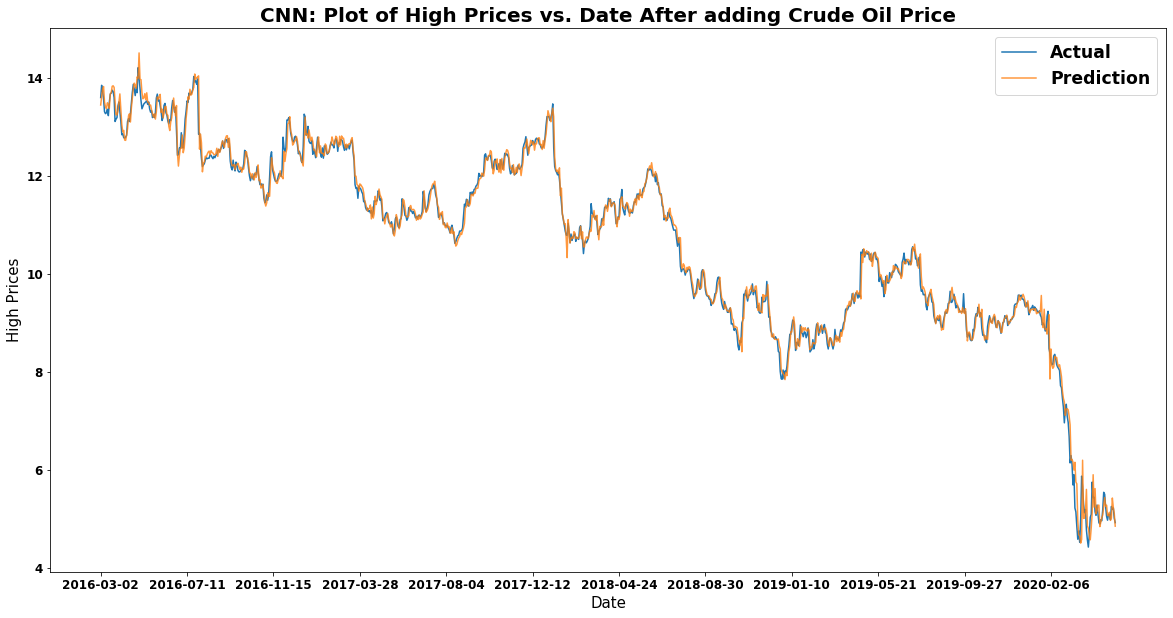

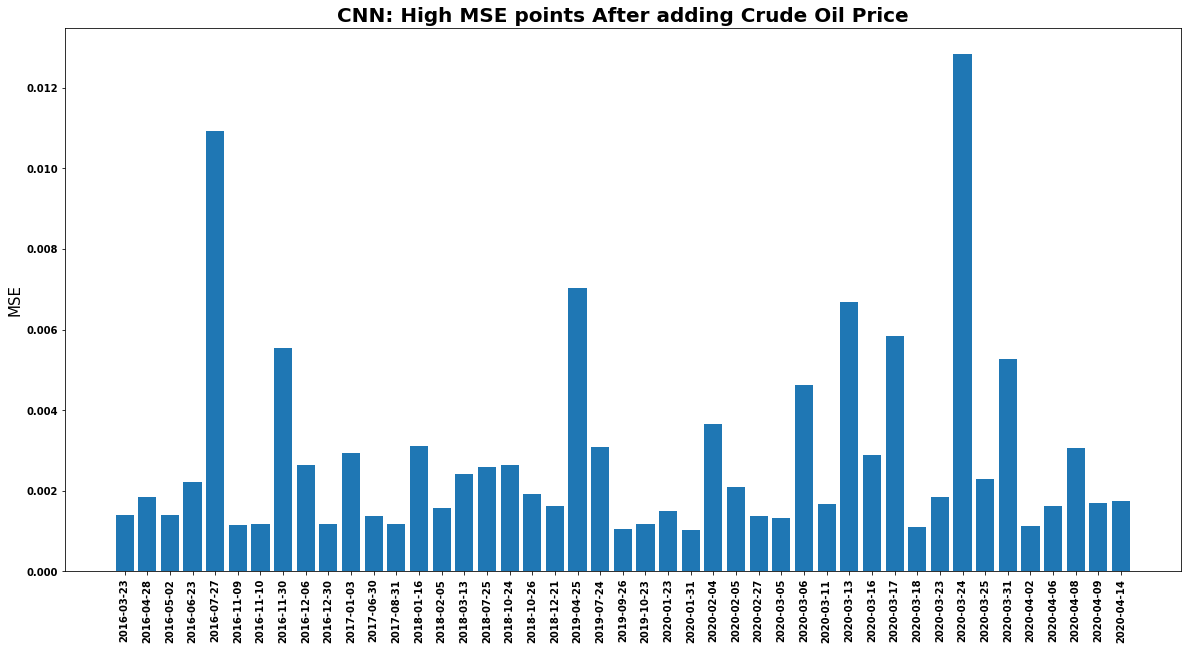

In [43]:
def evaluate_model(y_predicted,y_actual,dates):

    plt.figure(figsize=(20,10))
    plt.title('CNN: Plot of High Prices vs. Date After adding Crude Oil Price',fontsize=20,fontweight='bold')
    plt.xlabel('Date',fontsize=15)
    plt.ylabel('High Prices',fontsize=15)
    plt.plot((y_actual.reshape(-1,1)), label="Actual")#,color='red')
    plt.plot(y_predicted.reshape(-1,1), label="Prediction", alpha=0.8)#,color ='black')
    index = np.arange((len(y_predicted)-1),step=90)
    plt.xticks(index,dates[index],fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize="xx-large")

 
#Rescaling the high values from range 0-1 to original values:
actual= scaler.inverse_transform(np.array(actual_high).reshape(-1,1))
predicted = scaler.inverse_transform(np.array(predicted_high).reshape(-1,1))
evaluate_model(predicted,actual,np.array(predicted_dates))

print("time taken for execution : %s seconds " % (time_taken))
print('Mean Validation loss=', round(mean(model_val_loss),8)) 
print('Mean Model loss=', round(mean(model_loss),8))


large_loss = []
large_loss_date = []  
for index in range(0,len(model_val_loss)):
    val_loss = model_val_loss[index]
    if val_loss>0.001:
        large_loss.append(val_loss)
        large_loss_date.append(predicted_dates[index])


plt.rcParams["font.weight"] = "bold"
plt.figure(figsize=(20,10))
plt.title('CNN: High MSE points After adding Crude Oil Price',fontsize=20,fontweight='bold')
plt.ylabel('MSE',fontsize=15)
idx = np.arange(len(large_loss_date))
plt.xticks(idx,large_loss_date,rotation=90)
plt.bar(idx, large_loss, align='center', alpha=1)

# 8.3. LSTM - Crude Oil Price:

In [45]:
file_path = 'daily_mlp_model_weights.h5'
    
callback_checkpoint = ModelCheckpoint(filepath=file_path,
                                      monitor='val_loss',
                                      save_best_only=True,
                                      save_weights_only=True)
    
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
    
#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3,patience=5, min_lr=0.0009)
    
callbacks = [early_stopping, callback_checkpoint]#, reduce_lr]
adam = Adam(lr=0.003)
model = Sequential()
model.add(LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(16))
model.add(Dense(1))
model.compile(loss='mse', optimizer=adam)

#window size =1:
import time
from itertools import chain
start_time = time.time()

predicted_high = []
actual_high = []
predicted_dates = []
window = 200
model_loss = []
model_val_loss =[]

for trn in range(0,trn_size-window):
    X_train,X_test,y_train,y_test,Date_train,Date_test = build_data(trn,pw=1,window_size = window)
    print(trn)
    
    history = model.fit(X_train, y_train,verbose = 0, epochs=200,
                        validation_data=(X_test, y_test), callbacks=callbacks, 
                        shuffle=False)
    yhat = model.predict(X_test, verbose=0)
    yhat = list(chain.from_iterable(yhat)) 
    if len(predicted_high) == 0:
        predicted_high = yhat
        predicted_dates = Date_test.tolist()
        actual_high = y_test.tolist()
        model_loss.append(history.history['loss'][-1])
        model_val_loss.append(history.history['val_loss'][-1])
        
        
    else:
        beg=len(predicted_high)-len(yhat)+1
        yhat_idx = 0
        for pred_idx in range(beg,len(predicted_high)):
            predicted_high[pred_idx]= (predicted_high[pred_idx] + yhat[yhat_idx])/2
            yhat_idx+=1
        predicted_high.append(yhat[-1])
        actual_high.append(y_test[-1])
        predicted_dates.append(Date_test.tolist()[-1])
        model_loss.append(history.history['loss'][-1])
        model_val_loss.append(history.history['val_loss'][-1])
    

0
Epoch 00028: early stopping
1
Epoch 00011: early stopping
2
Epoch 00087: early stopping
3
Epoch 00015: early stopping
4
Epoch 00028: early stopping
5
Epoch 00017: early stopping
6
Epoch 00011: early stopping
7
Epoch 00017: early stopping
8
Epoch 00033: early stopping
9
Epoch 00038: early stopping
10
Epoch 00020: early stopping
11
Epoch 00035: early stopping
12
Epoch 00014: early stopping
13
Epoch 00019: early stopping
14
Epoch 00011: early stopping
15
Epoch 00012: early stopping
16
Epoch 00023: early stopping
17
Epoch 00011: early stopping
18
Epoch 00030: early stopping
19
Epoch 00014: early stopping
20
Epoch 00034: early stopping
21
Epoch 00014: early stopping
22
Epoch 00013: early stopping
23
Epoch 00012: early stopping
24
Epoch 00021: early stopping
25
Epoch 00030: early stopping
26
Epoch 00013: early stopping
27
Epoch 00024: early stopping
28
Epoch 00018: early stopping
29
Epoch 00028: early stopping
30
Epoch 00019: early stopping
31
Epoch 00014: early stopping
32
Epoch 00025: ea

Epoch 00015: early stopping
261
Epoch 00014: early stopping
262
Epoch 00025: early stopping
263
Epoch 00039: early stopping
264
Epoch 00024: early stopping
265
Epoch 00013: early stopping
266
Epoch 00023: early stopping
267
Epoch 00054: early stopping
268
Epoch 00013: early stopping
269
Epoch 00015: early stopping
270
Epoch 00015: early stopping
271
Epoch 00012: early stopping
272
Epoch 00013: early stopping
273
Epoch 00132: early stopping
274
Epoch 00013: early stopping
275
Epoch 00012: early stopping
276
Epoch 00016: early stopping
277
Epoch 00015: early stopping
278
Epoch 00015: early stopping
279
Epoch 00015: early stopping
280
Epoch 00012: early stopping
281
Epoch 00014: early stopping
282
Epoch 00028: early stopping
283
Epoch 00029: early stopping
284
Epoch 00016: early stopping
285
Epoch 00018: early stopping
286
Epoch 00015: early stopping
287
Epoch 00014: early stopping
288
Epoch 00015: early stopping
289
Epoch 00015: early stopping
290
Epoch 00015: early stopping
291
Epoch 00

Epoch 00012: early stopping
518
Epoch 00020: early stopping
519
Epoch 00025: early stopping
520
Epoch 00021: early stopping
521
Epoch 00040: early stopping
522
Epoch 00026: early stopping
523
Epoch 00012: early stopping
524
Epoch 00021: early stopping
525
Epoch 00033: early stopping
526
Epoch 00013: early stopping
527
Epoch 00018: early stopping
528
Epoch 00018: early stopping
529
Epoch 00023: early stopping
530
Epoch 00015: early stopping
531
Epoch 00012: early stopping
532
Epoch 00017: early stopping
533
Epoch 00022: early stopping
534
Epoch 00018: early stopping
535
Epoch 00030: early stopping
536
Epoch 00011: early stopping
537
Epoch 00017: early stopping
538
Epoch 00015: early stopping
539
Epoch 00038: early stopping
540
Epoch 00022: early stopping
541
Epoch 00013: early stopping
542
Epoch 00030: early stopping
543
Epoch 00019: early stopping
544
Epoch 00011: early stopping
545
Epoch 00015: early stopping
546
Epoch 00037: early stopping
547
Epoch 00022: early stopping
548
Epoch 00

Epoch 00018: early stopping
775
Epoch 00014: early stopping
776
Epoch 00030: early stopping
777
Epoch 00013: early stopping
778
Epoch 00012: early stopping
779
Epoch 00034: early stopping
780
Epoch 00016: early stopping
781
Epoch 00013: early stopping
782
Epoch 00019: early stopping
783
Epoch 00013: early stopping
784
Epoch 00014: early stopping
785
Epoch 00024: early stopping
786
Epoch 00015: early stopping
787
Epoch 00011: early stopping
788
Epoch 00030: early stopping
789
Epoch 00029: early stopping
790
Epoch 00012: early stopping
791
Epoch 00014: early stopping
792
Epoch 00017: early stopping
793
Epoch 00059: early stopping
794
Epoch 00012: early stopping
795
Epoch 00015: early stopping
796
Epoch 00024: early stopping
797
Epoch 00013: early stopping
798
Epoch 00011: early stopping
799
Epoch 00011: early stopping
800
Epoch 00020: early stopping
801
Epoch 00020: early stopping
802
Epoch 00011: early stopping
803
Epoch 00012: early stopping
804
Epoch 00013: early stopping
805
Epoch 00

Epoch 00013: early stopping
1031
Epoch 00024: early stopping
1032
Epoch 00012: early stopping
1033
Epoch 00034: early stopping
1034
Epoch 00011: early stopping
1035
Epoch 00040: early stopping
1036
Epoch 00012: early stopping
1037
Epoch 00013: early stopping
1038
Epoch 00011: early stopping
1039
Epoch 00036: early stopping
1040
Epoch 00023: early stopping
1041
Epoch 00018: early stopping
1042
Epoch 00025: early stopping
1043
Epoch 00012: early stopping
1044
Epoch 00011: early stopping
1045
Epoch 00021: early stopping
1046
Epoch 00022: early stopping
1047
Epoch 00014: early stopping
1048
Epoch 00019: early stopping
1049
Epoch 00021: early stopping
1050
Epoch 00012: early stopping
1051
Epoch 00027: early stopping
1052
Epoch 00030: early stopping
1053
Epoch 00031: early stopping
1054
Epoch 00012: early stopping
1055
Epoch 00015: early stopping
1056
Epoch 00012: early stopping
1057
Epoch 00016: early stopping


time taken for execution : 136.69256496429443 seconds 
Mean Validation loss= 0.00064544
Mean Model loss= 0.0001417


<BarContainer object of 56 artists>

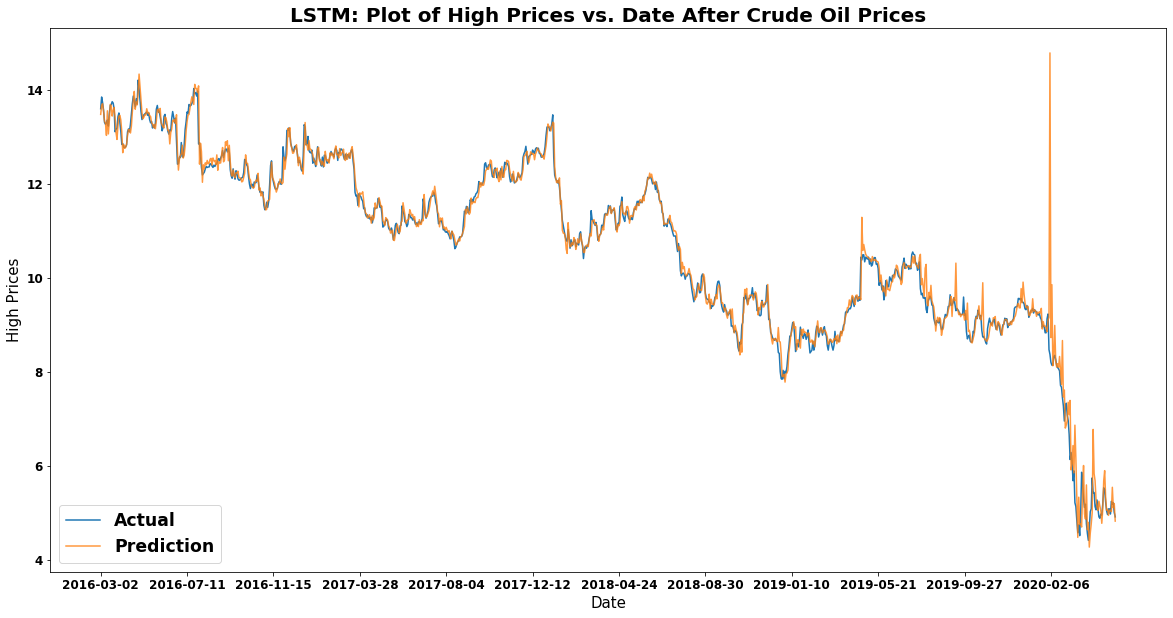

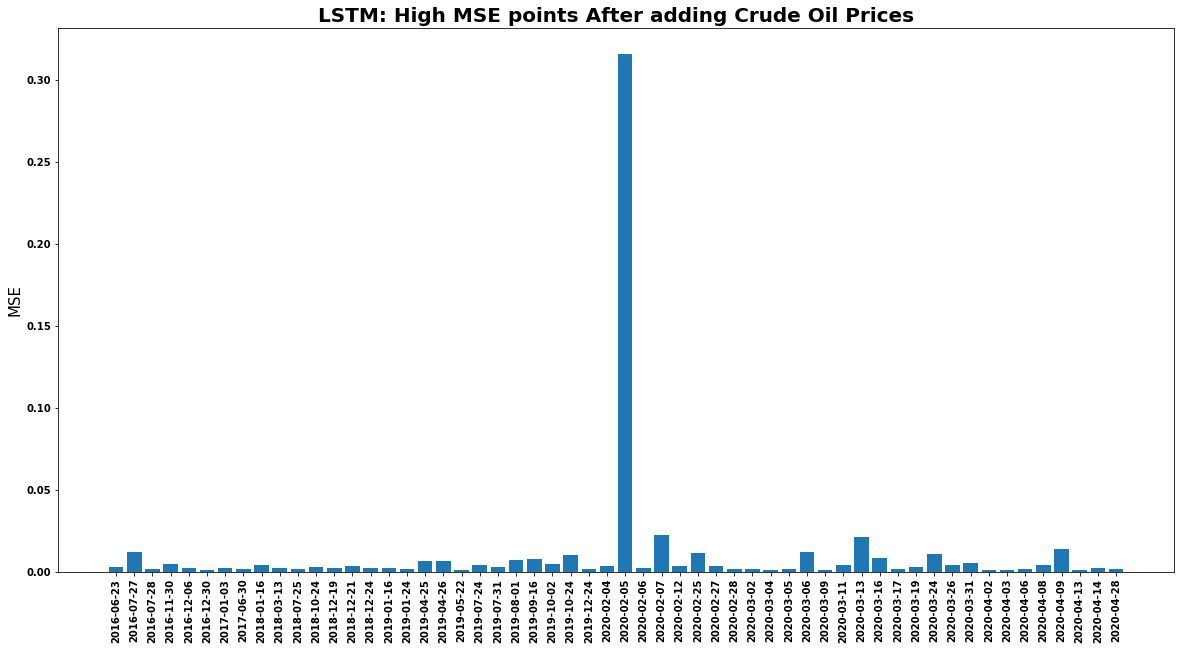

In [46]:
def evaluate_model(y_predicted,y_actual,dates):

    plt.figure(figsize=(20,10))
    plt.title('LSTM: Plot of High Prices vs. Date After Crude Oil Prices',fontsize=20,fontweight='bold')
    plt.xlabel('Date',fontsize=15)
    plt.ylabel('High Prices',fontsize=15)
    plt.plot((y_actual.reshape(-1,1)), label="Actual")#,color='red')
    plt.plot(y_predicted.reshape(-1,1), label="Prediction", alpha=0.8)#,color ='black')
    index = np.arange((len(y_predicted)-1),step=90)
    plt.xticks(index,dates[index],fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize="xx-large")

 
#Rescaling the high values from range 0-1 to original values:
actual= scaler.inverse_transform(np.array(actual_high).reshape(-1,1))
predicted = scaler.inverse_transform(np.array(predicted_high).reshape(-1,1))
evaluate_model(predicted,actual,np.array(predicted_dates))

print("time taken for execution : %s seconds " % (time_taken))
print('Mean Validation loss=', round(mean(model_val_loss),8)) 
print('Mean Model loss=', round(mean(model_loss),8))


large_loss = []
large_loss_date = []  
for index in range(0,len(model_val_loss)):
    val_loss = model_val_loss[index]
    if val_loss>0.001:
        large_loss.append(val_loss)
        large_loss_date.append(predicted_dates[index])


plt.rcParams["font.weight"] = "bold"
plt.figure(figsize=(20,10))
plt.title('LSTM: High MSE points After adding Crude Oil Prices',fontsize=20,fontweight='bold')
plt.ylabel('MSE',fontsize=15)
idx = np.arange(len(large_loss_date))
plt.xticks(idx,large_loss_date,rotation=90)
plt.bar(idx, large_loss, align='center', alpha=1)

# 9. Dow Jones Oil & Gas Supersector Titans Index

In [99]:
titans_oil = pd.read_csv('/Users/aleenaalex/Documents/UCC projects/data/DJ Oil & Gas Supersector Titans Index.csv', 
                      header=0, index_col=0)
#df1 = df.ix[:, 'a':'b']
#titans_oil = titans_oil[['Dow Jones Oil & Gas Supersector Titans Index (USD)']]
#titans_oil =(titans_oil[1586:2881])
titans_oil 
#titans_oil.to_csv('/Users/aleenaalex/Documents/UCC projects/data/DJ Oil & Gas Supersector Titans Index.csv', encoding='utf-8')#index=False)

Dow Jones Oil & Gas Supersector Titans Index (USD)
Effective date                                                     
15/05/15                                                    445.40 
18/05/15                                                    443.20 
19/05/15                                                    437.01 
20/05/15                                                    437.22 
21/05/15                                                    441.62 
...                                                            ... 
08/05/20                                                    267.26 
11/05/20                                                    265.18 
12/05/20                                                    262.17 
13/05/20                                                    252.43 
14/05/20                                                    250.29 

[1295 rows x 1 columns]

In [100]:
#Convert Date Format:
titan_oil = []
titan_oil = list(titans_oil.index)
newdt = []
for idx in range(0,len(titans_oil)): 
    date = titan_oil[idx]
    day,month,year = date[0:2],date[3:5],'20'+date[6:8]
    newdt.append(year+'-'+month+'-'+day)

titans_oil.insert(0, "FormatDate", newdt)
titans_oil


FormatDate  \
Effective date                
15/05/15         2015-05-15   
18/05/15         2015-05-18   
19/05/15         2015-05-19   
20/05/15         2015-05-20   
21/05/15         2015-05-21   
...                     ...   
08/05/20         2020-05-08   
11/05/20         2020-05-11   
12/05/20         2020-05-12   
13/05/20         2020-05-13   
14/05/20         2020-05-14   

                 Dow Jones Oil & Gas Supersector Titans Index (USD)  
Effective date                                                       
15/05/15                                                    445.40   
18/05/15                                                    443.20   
19/05/15                                                    437.01   
20/05/15                                                    437.22   
21/05/15                                                    441.62   
...                                                            ...   
08/05/20                                                    267.26   
11/05/20                                                    265.18   
12/05/20                                                    262.17   
13/05/20                                                    252.43   
14/05/20                                                    250.29   

[1295 rows x 2 columns]

In [108]:
#merge values:
ford_dates = list(ford.index)
titan_oil_dates = list(titans_oil['FormatDate'])
mean_top = mean(titans_oil['Dow Jones Oil & Gas Supersector Titans Index (USD)'])
print(mean_top,len(ford_dates))
ford["TitanOil"] = mean_top
for row_num in range(0,len(ford_dates)):
    date = ford_dates[row_num] 
    #print(date)
    if date in titan_oil_dates:
        ford["TitanOil"][row_num] = mean((titans_oil['Dow Jones Oil & Gas Supersector Titans Index (USD)'][titans_oil['FormatDate']==date]))
    
ford

394.1362162162162 1259


/Users/aleenaalex/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


Open   High    Low  Close  Adj Close     Volume  TitanOil
Date                                                                  
2015-05-15  15.27  15.49  15.27  15.48  11.977631   18937700    445.40
2015-05-18  15.47  15.64  15.45  15.58  12.055005   19491900    443.20
2015-05-19  15.59  15.63  15.45  15.50  11.993106   15145300    437.01
2015-05-20  15.54  15.56  15.26  15.30  11.838357   22391500    437.22
2015-05-21  15.28  15.55  15.26  15.51  12.000844   23962000    441.62
...           ...    ...    ...    ...        ...        ...       ...
2020-05-08   4.96   5.25   4.95   5.24   5.240000  101333800    267.26
2020-05-11   5.18   5.19   5.05   5.12   5.120000   75593900    265.18
2020-05-12   5.15   5.22   4.97   4.98   4.980000   70965200    262.17
2020-05-13   5.00   5.01   4.66   4.72   4.720000  100192300    252.43
2020-05-14   4.64   4.92   4.52   4.89   4.890000  107931900    250.29

[1259 rows x 7 columns]

In [109]:
def normalize(data):
    
    scaler_open = MinMaxScaler()
    scaler_high = MinMaxScaler()
    scaler_low = MinMaxScaler()
    scaler_close = MinMaxScaler()
    scaler_adjclose = MinMaxScaler()
    scaler_volume = MinMaxScaler()
    scaler_oil = MinMaxScaler()
    
    #Open:
    fit = scaler_open.fit(np.array(data['Open']).reshape(-1, 1))
    data['Open'] =scaler_open.transform(np.array(dataframe_ford['Open']).reshape(-1, 1))
    
    #High:
    fit = scaler_high.fit(np.array(data['High']).reshape(-1, 1))
    data['High'] =scaler_high.transform(np.array(data['High']).reshape(-1, 1))
    
    #Low:
    fit = scaler_low.fit(np.array(data['Low']).reshape(-1, 1))
    data['Low'] =scaler_low.transform(np.array(data['Low']).reshape(-1, 1))
    
    #Close:
    fit = scaler_close.fit(np.array(data['Close']).reshape(-1, 1))
    data['Close'] =scaler_close.transform(np.array(data['Close']).reshape(-1, 1))
    
    #AdjClose:
    fit = scaler_adjclose.fit(np.array(data['Adj Close']).reshape(-1, 1))
    data['Adj Close'] =scaler_adjclose.transform(np.array(data['Adj Close']).reshape(-1, 1))
    
    #High:
    fit = scaler_volume.fit(np.array(data['Volume']).reshape(-1, 1))
    data['Volume'] =scaler_volume.transform(np.array(data['Volume']).reshape(-1, 1))
    
    #Dow:
    fit = scaler_oil.fit(np.array(data['TitanOil']).reshape(-1, 1))
    data['TitanOil'] =scaler_oil.transform(np.array(data['TitanOil']).reshape(-1, 1))
    
    return data,scaler_high

df = ford
dataframe_ford = df
df,scaler = normalize(df)

#convert data: form X and y data:
Xarr = df.rename_axis('ID').values
Xarr = Xarr[0:1258]
Datearr = df.index.values

df1 = df[['High']]
yarr = df1.rename_axis('ID').values

print('Xarr:',Xarr[0:5])
print('yarr:',yarr[0:5])
print('Datearr:',Datearr[0:5])

yarr = np.delete(yarr, 0)
print('yarr:',yarr[0:5])
print('X shape:',Xarr.shape)
print('y shape:',yarr.shape)

def build_data(start,pw,window_size=200):
    
    X_train,X_test = Xarr[start:start+window_size],Xarr[start+window_size:start+window_size+pw]
    y_train,y_test = yarr[start:start+window_size],yarr[start+window_size:start+window_size+pw]
    Date_train,Date_test = Datearr[start:start+window_size],Datearr[start+window_size:start+window_size+pw]
    return X_train,X_test,y_train,y_test,Date_train,Date_test

trn_size = len(Xarr)

from numpy import array
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline
    
file_path = 'daily_mlp_model_weights.h5'
    
callback_checkpoint = ModelCheckpoint(filepath=file_path,
                                      monitor='val_loss',
                                      save_best_only=True,
                                      save_weights_only=True)
    
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
    
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3,
                              patience=5, min_lr=0.0009)
    
callbacks = [early_stopping, callback_checkpoint, reduce_lr]
    
tf.keras.backend.clear_session()
    
model_mlp = tf.keras.models.Sequential()
    
model_mlp.add(tf.keras.layers.Reshape((7,),input_shape=(7,)))
    
model_mlp.add(tf.keras.layers.Dense(200,activation='relu'))
    
model_mlp.add(tf.keras.layers.Dense(1,activation='linear'))
    
model_mlp.compile(optimizer='adam',loss='mse',metrics=['accuracy'])
    

Xarr: [[0.95986038 0.96935201 0.97416021 0.98286204 0.96620093 0.04988881
  0.875345  ]
 [0.97731239 0.98248687 0.98966408 0.99143102 0.97558374 0.05236248
  0.86820145]
 [0.9877836  0.98161121 0.98966408 0.98457584 0.96807751 0.0329615
  0.84810209]
 [0.98342059 0.97548161 0.97329888 0.96743787 0.94931176 0.0653048
  0.84878397]
 [0.96073298 0.97460595 0.97329888 0.98543273 0.96901587 0.0723147
  0.86307108]]
yarr: [[0.96935201]
 [0.98248687]
 [0.98161121]
 [0.97548161]
 [0.97460595]]
Datearr: ['2015-05-15' '2015-05-18' '2015-05-19' '2015-05-20' '2015-05-21']
yarr: [0.98248687 0.98161121 0.97548161 0.97460595 0.97022767]
X shape: (1258, 7)
y shape: (1258,)


In [110]:
import time
from itertools import chain
start_time = time.time()

predicted_high = []
actual_high = []
predicted_dates = []
window = 200
model_loss = []
model_val_loss =[]

for trn in range(0,trn_size-window):
    X_train,X_test,y_train,y_test,Date_train,Date_test = build_data(trn,pw=1,window_size = window)
    print(trn)
    
    history = model_mlp.fit(X_train, y_train,verbose = 0, epochs=200,
                        validation_data=(X_test, y_test), callbacks=callbacks, 
                        shuffle=False)
    yhat = model_mlp.predict(X_test, verbose=0)
    yhat = list(chain.from_iterable(yhat)) 
    if len(predicted_high) == 0:
        predicted_high = yhat
        predicted_dates = Date_test.tolist()
        actual_high = y_test.tolist()
        model_loss.append(history.history['loss'][-1])
        model_val_loss.append(history.history['val_loss'][-1])
        
        
    else:
        beg=len(predicted_high)-len(yhat)+1
        yhat_idx = 0
        for pred_idx in range(beg,len(predicted_high)):
            predicted_high[pred_idx]= (predicted_high[pred_idx] + yhat[yhat_idx])/2
            yhat_idx+=1
        predicted_high.append(yhat[-1])
        actual_high.append(y_test[-1])
        predicted_dates.append(Date_test.tolist()[-1])
        model_loss.append(history.history['loss'][-1])
        model_val_loss.append(history.history['val_loss'][-1])
    
    
time_taken = time.time() - start_time

0
Epoch 00021: early stopping
1
Epoch 00011: early stopping
2
Epoch 00011: early stopping
3
Epoch 00011: early stopping
4
Epoch 00011: early stopping
5
6
Epoch 00011: early stopping
7
Epoch 00011: early stopping
8
Epoch 00011: early stopping
9
Epoch 00012: early stopping
10
Epoch 00197: early stopping
11
Epoch 00013: early stopping
12
Epoch 00013: early stopping
13
Epoch 00012: early stopping
14
Epoch 00012: early stopping
15
Epoch 00012: early stopping
16
Epoch 00011: early stopping
17
Epoch 00028: early stopping
18
Epoch 00013: early stopping
19
Epoch 00011: early stopping
20
Epoch 00013: early stopping
21
Epoch 00012: early stopping
22
Epoch 00011: early stopping
23
Epoch 00102: early stopping
24
Epoch 00019: early stopping
25
Epoch 00020: early stopping
26
Epoch 00016: early stopping
27
Epoch 00016: early stopping
28
Epoch 00012: early stopping
29
Epoch 00016: early stopping
30
Epoch 00017: early stopping
31
Epoch 00011: early stopping
32
Epoch 00013: early stopping
33
Epoch 00013:

Epoch 00018: early stopping
263
Epoch 00025: early stopping
264
Epoch 00011: early stopping
265
Epoch 00012: early stopping
266
Epoch 00014: early stopping
267
Epoch 00014: early stopping
268
Epoch 00020: early stopping
269
Epoch 00015: early stopping
270
Epoch 00015: early stopping
271
Epoch 00011: early stopping
272
Epoch 00011: early stopping
273
Epoch 00011: early stopping
274
Epoch 00012: early stopping
275
Epoch 00011: early stopping
276
Epoch 00055: early stopping
277
Epoch 00016: early stopping
278
Epoch 00020: early stopping
279
Epoch 00017: early stopping
280
Epoch 00013: early stopping
281
Epoch 00021: early stopping
282
Epoch 00014: early stopping
283
Epoch 00019: early stopping
284
Epoch 00021: early stopping
285
Epoch 00015: early stopping
286
Epoch 00022: early stopping
287
Epoch 00024: early stopping
288
Epoch 00015: early stopping
289
Epoch 00020: early stopping
290
Epoch 00024: early stopping
291
Epoch 00013: early stopping
292
Epoch 00014: early stopping
293
Epoch 00

Epoch 00014: early stopping
520
Epoch 00015: early stopping
521
Epoch 00033: early stopping
522
Epoch 00053: early stopping
523
Epoch 00030: early stopping
524
Epoch 00020: early stopping
525
Epoch 00013: early stopping
526
Epoch 00020: early stopping
527
Epoch 00012: early stopping
528
Epoch 00015: early stopping
529
Epoch 00035: early stopping
530
Epoch 00017: early stopping
531
Epoch 00020: early stopping
532
Epoch 00012: early stopping
533
Epoch 00038: early stopping
534
Epoch 00026: early stopping
535
Epoch 00011: early stopping
536
Epoch 00015: early stopping
537
Epoch 00011: early stopping
538
Epoch 00015: early stopping
539
Epoch 00011: early stopping
540
Epoch 00165: early stopping
541
Epoch 00011: early stopping
542
Epoch 00016: early stopping
543
Epoch 00014: early stopping
544
Epoch 00016: early stopping
545
Epoch 00015: early stopping
546
Epoch 00011: early stopping
547
Epoch 00016: early stopping
548
Epoch 00015: early stopping
549
Epoch 00011: early stopping
550
Epoch 00

Epoch 00011: early stopping
778
Epoch 00014: early stopping
779
Epoch 00015: early stopping
780
Epoch 00015: early stopping
781
Epoch 00014: early stopping
782
Epoch 00016: early stopping
783
Epoch 00013: early stopping
784
Epoch 00014: early stopping
785
Epoch 00018: early stopping
786
Epoch 00015: early stopping
787
Epoch 00019: early stopping
788
Epoch 00013: early stopping
789
Epoch 00039: early stopping
790
Epoch 00026: early stopping
791
Epoch 00015: early stopping
792
Epoch 00015: early stopping
793
Epoch 00015: early stopping
794
Epoch 00012: early stopping
795
Epoch 00013: early stopping
796
Epoch 00011: early stopping
797
Epoch 00011: early stopping
798
Epoch 00012: early stopping
799
Epoch 00071: early stopping
800
Epoch 00012: early stopping
801
Epoch 00046: early stopping
802
Epoch 00012: early stopping
803
Epoch 00013: early stopping
804
Epoch 00012: early stopping
805
Epoch 00021: early stopping
806
Epoch 00041: early stopping
807
Epoch 00013: early stopping
808
Epoch 00

Epoch 00014: early stopping
1033
Epoch 00020: early stopping
1034
Epoch 00017: early stopping
1035
Epoch 00027: early stopping
1036
Epoch 00011: early stopping
1037
Epoch 00069: early stopping
1038
Epoch 00011: early stopping
1039
Epoch 00011: early stopping
1040
Epoch 00016: early stopping
1041
Epoch 00046: early stopping
1042
Epoch 00011: early stopping
1043
Epoch 00011: early stopping
1044
Epoch 00011: early stopping
1045
Epoch 00016: early stopping
1046
Epoch 00013: early stopping
1047
Epoch 00013: early stopping
1048
Epoch 00018: early stopping
1049
Epoch 00030: early stopping
1050
Epoch 00025: early stopping
1051
Epoch 00023: early stopping
1052
Epoch 00032: early stopping
1053
Epoch 00017: early stopping
1054
Epoch 00019: early stopping
1055
Epoch 00062: early stopping
1056
Epoch 00012: early stopping
1057
Epoch 00013: early stopping


time taken for execution : 265.5596227645874 seconds 
Mean Validation loss= 0.00021619
Mean Model loss= 0.0001431


<BarContainer object of 41 artists>

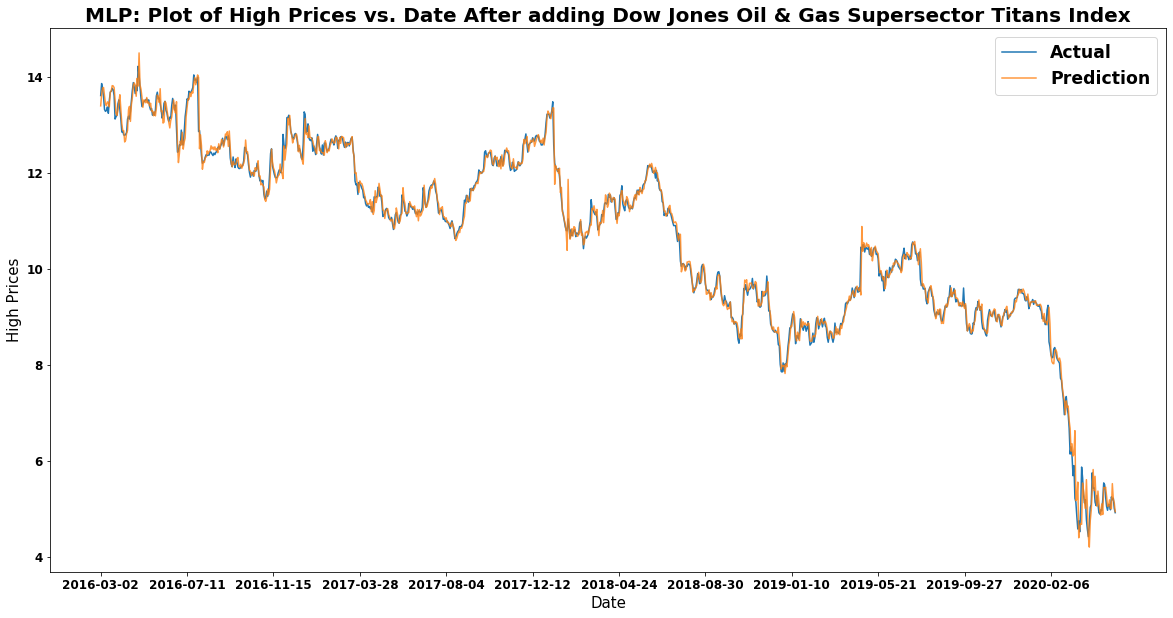

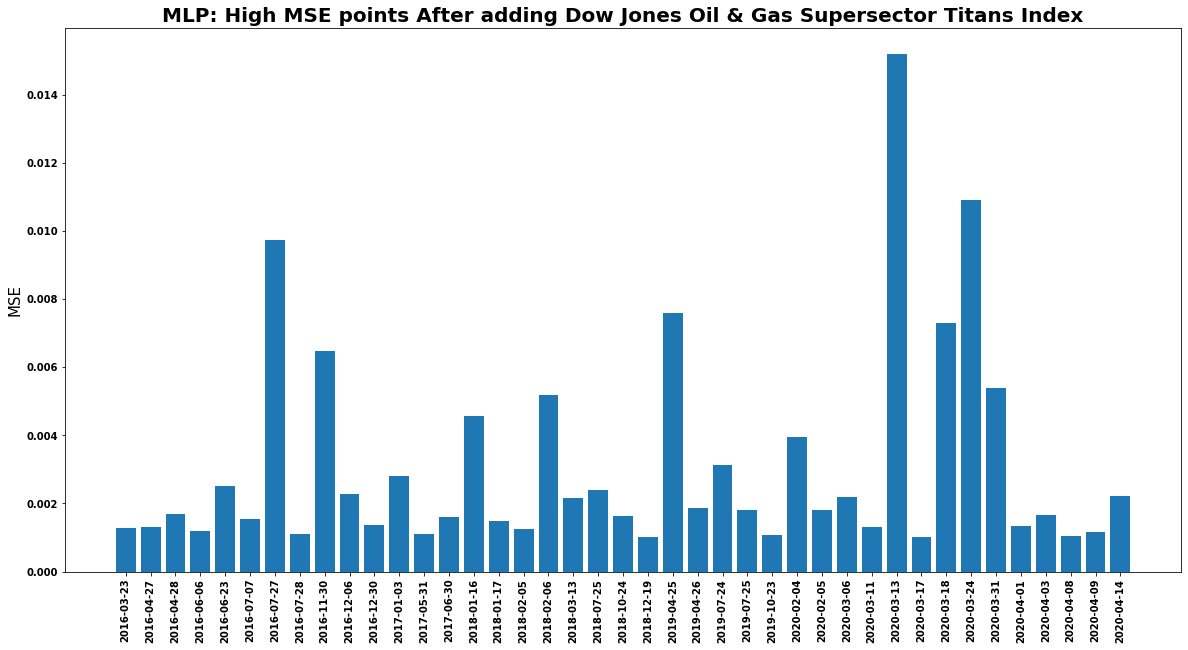

In [111]:
def evaluate_model(y_predicted,y_actual,dates):

    plt.figure(figsize=(20,10))
    plt.title('MLP: Plot of High Prices vs. Date After adding Dow Jones Oil & Gas Supersector Titans Index',fontsize=20,fontweight='bold')
    plt.xlabel('Date',fontsize=15)
    plt.ylabel('High Prices',fontsize=15)
    plt.plot((y_actual.reshape(-1,1)), label="Actual")#,color='red')
    plt.plot(y_predicted.reshape(-1,1), label="Prediction", alpha=0.8)#,color ='black')
    index = np.arange((len(y_predicted)-1),step=90)
    plt.xticks(index,dates[index],fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize="xx-large")

 
#Rescaling the high values from range 0-1 to original values:
actual= scaler.inverse_transform(np.array(actual_high).reshape(-1,1))
predicted = scaler.inverse_transform(np.array(predicted_high).reshape(-1,1))
evaluate_model(predicted,actual,np.array(predicted_dates))

print("time taken for execution : %s seconds " % (time_taken))
print('Mean Validation loss=', round(mean(model_val_loss),8)) 
print('Mean Model loss=', round(mean(model_loss),8))


large_loss = []
large_loss_date = []  
for index in range(0,len(model_val_loss)):
    val_loss = model_val_loss[index]
    if val_loss>0.001:
        large_loss.append(val_loss)
        large_loss_date.append(predicted_dates[index])


plt.rcParams["font.weight"] = "bold"
plt.figure(figsize=(20,10))
plt.title('MLP: High MSE points After adding Dow Jones Oil & Gas Supersector Titans Index',fontsize=20,fontweight='bold')
plt.ylabel('MSE',fontsize=15)
idx = np.arange(len(large_loss_date))
plt.xticks(idx,large_loss_date,rotation=90)
plt.bar(idx, large_loss, align='center', alpha=1)

In [112]:
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
import matplotlib.pyplot as plt
%matplotlib inline

file_path = 'daily_mlp_model_weights.h5'
    
callback_checkpoint = ModelCheckpoint(filepath=file_path,
                                      monitor='val_loss',
                                      save_best_only=True,
                                      save_weights_only=True)
    
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
    
callbacks = [early_stopping, callback_checkpoint]#, reduce_lr]

Xarr = Xarr.reshape((Xarr.shape[0], Xarr.shape[1], 1))
# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(7, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

#CNN Model window size =1:
import time
from itertools import chain
start_time = time.time()

predicted_high = []
actual_high = []
predicted_dates = []
window = 200
model_loss = []
model_val_loss =[]

for trn in range(0,trn_size-window):
    X_train,X_test,y_train,y_test,Date_train,Date_test = build_data(trn,pw=1,window_size = window)
    print(trn)
    
    history = model.fit(X_train, y_train,verbose = 0, epochs=200,
                        validation_data=(X_test, y_test), callbacks=callbacks, 
                        shuffle=False)
    yhat = model.predict(X_test, verbose=0)
    yhat = list(chain.from_iterable(yhat)) 
    if len(predicted_high) == 0:
        predicted_high = yhat
        predicted_dates = Date_test.tolist()
        actual_high = y_test.tolist()
        model_loss.append(history.history['loss'][-1])
        model_val_loss.append(history.history['val_loss'][-1])
        
        
    else:
        beg=len(predicted_high)-len(yhat)+1
        yhat_idx = 0
        for pred_idx in range(beg,len(predicted_high)):
            predicted_high[pred_idx]= (predicted_high[pred_idx] + yhat[yhat_idx])/2
            yhat_idx+=1
        predicted_high.append(yhat[-1])
        actual_high.append(y_test[-1])
        predicted_dates.append(Date_test.tolist()[-1])
        model_loss.append(history.history['loss'][-1])
        model_val_loss.append(history.history['val_loss'][-1])
    
    
time_taken = time.time() - start_time
print(predicted_dates[0:5])
print(predicted_high[0:5])
print(actual_high[0:5])

0
Epoch 00014: early stopping
1
Epoch 00012: early stopping
2
Epoch 00011: early stopping
3
Epoch 00011: early stopping
4
Epoch 00012: early stopping
5
Epoch 00012: early stopping
6
Epoch 00012: early stopping
7
8
Epoch 00011: early stopping
9
Epoch 00013: early stopping
10
Epoch 00011: early stopping
11
Epoch 00166: early stopping
12
Epoch 00018: early stopping
13
Epoch 00016: early stopping
14
Epoch 00014: early stopping
15
Epoch 00013: early stopping
16
Epoch 00013: early stopping
17
Epoch 00014: early stopping
18
Epoch 00014: early stopping
19
Epoch 00013: early stopping
20
Epoch 00013: early stopping
21
Epoch 00013: early stopping
22
Epoch 00016: early stopping
23
Epoch 00018: early stopping
24
Epoch 00021: early stopping
25
Epoch 00021: early stopping
26
Epoch 00019: early stopping
27
Epoch 00017: early stopping
28
Epoch 00011: early stopping
29
Epoch 00014: early stopping
30
Epoch 00015: early stopping
31
Epoch 00013: early stopping
32
Epoch 00012: early stopping
33
Epoch 00012:

Epoch 00013: early stopping
263
Epoch 00014: early stopping
264
Epoch 00019: early stopping
265
Epoch 00011: early stopping
266
Epoch 00021: early stopping
267
Epoch 00025: early stopping
268
Epoch 00019: early stopping
269
Epoch 00012: early stopping
270
Epoch 00012: early stopping
271
Epoch 00019: early stopping
272
Epoch 00044: early stopping
273
Epoch 00011: early stopping
274
Epoch 00037: early stopping
275
Epoch 00011: early stopping
276
Epoch 00014: early stopping
277
Epoch 00012: early stopping
278
Epoch 00013: early stopping
279
Epoch 00016: early stopping
280
Epoch 00012: early stopping
281
Epoch 00019: early stopping
282
Epoch 00030: early stopping
283
Epoch 00011: early stopping
284
Epoch 00011: early stopping
285
Epoch 00047: early stopping
286
Epoch 00016: early stopping
287
Epoch 00015: early stopping
288
Epoch 00011: early stopping
289
Epoch 00018: early stopping
290
Epoch 00022: early stopping
291
Epoch 00020: early stopping
292
Epoch 00022: early stopping
293
Epoch 00

Epoch 00015: early stopping
521
Epoch 00019: early stopping
522
Epoch 00020: early stopping
523
Epoch 00011: early stopping
524
Epoch 00048: early stopping
525
Epoch 00013: early stopping
526
Epoch 00039: early stopping
527
Epoch 00018: early stopping
528
Epoch 00044: early stopping
529
Epoch 00023: early stopping
530
Epoch 00013: early stopping
531
Epoch 00013: early stopping
532
Epoch 00026: early stopping
533
Epoch 00034: early stopping
534
Epoch 00024: early stopping
535
Epoch 00014: early stopping
536
Epoch 00018: early stopping
537
Epoch 00022: early stopping
538
Epoch 00013: early stopping
539
Epoch 00012: early stopping
540
Epoch 00075: early stopping
541
Epoch 00015: early stopping
542
Epoch 00014: early stopping
543
Epoch 00059: early stopping
544
Epoch 00013: early stopping
545
Epoch 00016: early stopping
546
Epoch 00032: early stopping
547
Epoch 00012: early stopping
548
Epoch 00012: early stopping
549
Epoch 00027: early stopping
550
Epoch 00014: early stopping
551
Epoch 00

Epoch 00027: early stopping
780
Epoch 00012: early stopping
781
Epoch 00024: early stopping
782
Epoch 00011: early stopping
783
Epoch 00013: early stopping
784
Epoch 00013: early stopping
785
Epoch 00027: early stopping
786
Epoch 00015: early stopping
787
Epoch 00042: early stopping
788
Epoch 00024: early stopping
789
Epoch 00012: early stopping
790
Epoch 00035: early stopping
791
Epoch 00014: early stopping
792
Epoch 00011: early stopping
793
Epoch 00016: early stopping
794
Epoch 00022: early stopping
795
Epoch 00020: early stopping
796
Epoch 00019: early stopping
797
Epoch 00014: early stopping
798
Epoch 00016: early stopping
799
Epoch 00038: early stopping
800
Epoch 00024: early stopping
801
Epoch 00013: early stopping
802
Epoch 00015: early stopping
803
Epoch 00015: early stopping
804
Epoch 00016: early stopping
805
Epoch 00011: early stopping
806
Epoch 00015: early stopping
807
Epoch 00023: early stopping
808
Epoch 00020: early stopping
809
Epoch 00019: early stopping
810
Epoch 00

Epoch 00012: early stopping
1037
Epoch 00017: early stopping
1038
Epoch 00013: early stopping
1039
Epoch 00034: early stopping
1040
Epoch 00018: early stopping
1041
Epoch 00012: early stopping
1042
Epoch 00013: early stopping
1043
Epoch 00014: early stopping
1044
Epoch 00015: early stopping
1045
Epoch 00014: early stopping
1046
Epoch 00014: early stopping
1047
Epoch 00013: early stopping
1048
Epoch 00012: early stopping
1049
Epoch 00018: early stopping
1050
Epoch 00011: early stopping
1051
Epoch 00015: early stopping
1052
Epoch 00011: early stopping
1053
Epoch 00026: early stopping
1054
Epoch 00015: early stopping
1055
Epoch 00011: early stopping
1056
Epoch 00048: early stopping
1057
Epoch 00011: early stopping
['2016-03-02', '2016-03-03', '2016-03-04', '2016-03-07', '2016-03-08']
[0.78309524, 0.8087046, 0.82323575, 0.82605046, 0.7991672]
[0.8047285464098073, 0.8266199649737302, 0.8161120840630474, 0.8021015761821366, 0.7793345008756569]


time taken for execution : 131.9894061088562 seconds 
Mean Validation loss= 0.00022829
Mean Model loss= 0.00014183


<BarContainer object of 41 artists>

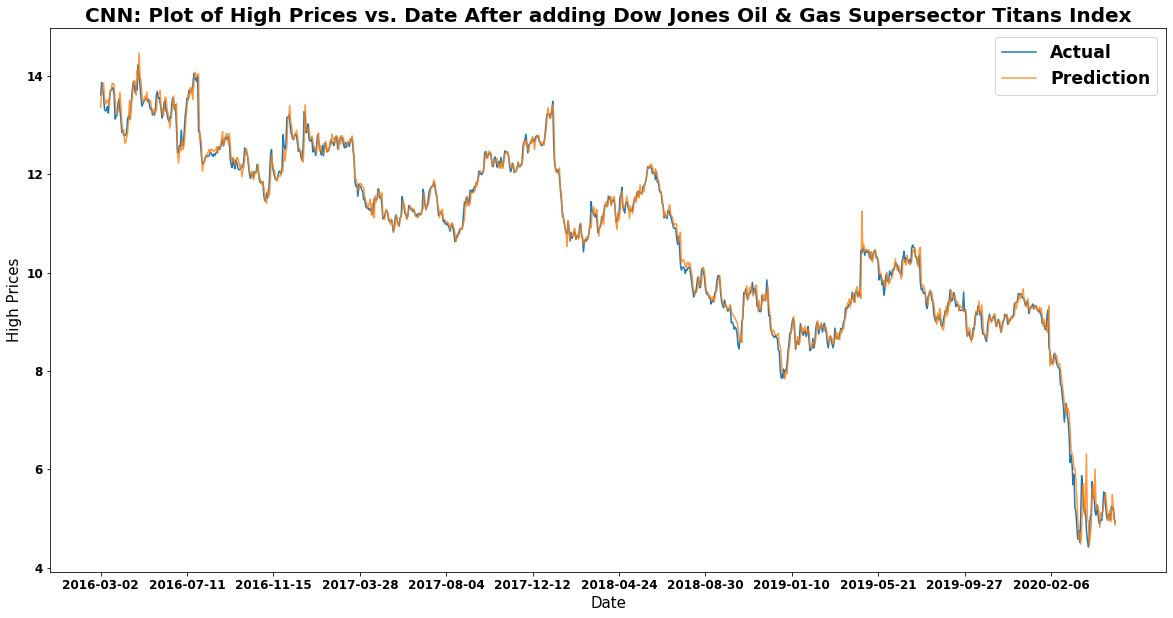

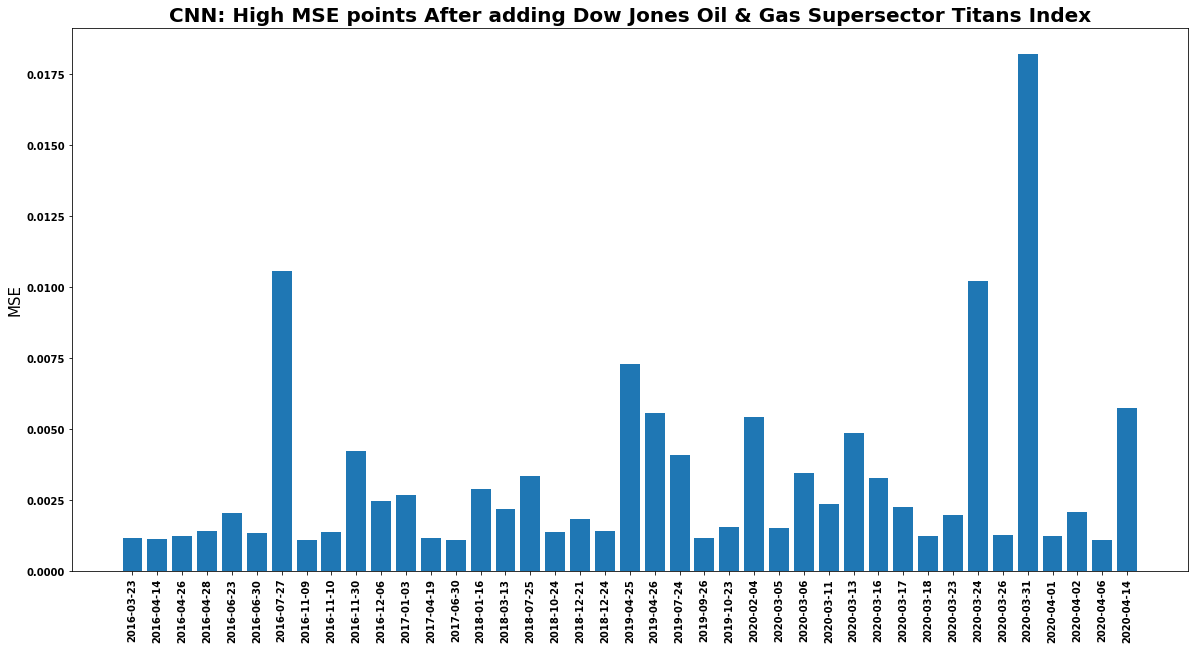

In [113]:
def evaluate_model(y_predicted,y_actual,dates):

    plt.figure(figsize=(20,10))
    plt.title('CNN: Plot of High Prices vs. Date After adding Dow Jones Oil & Gas Supersector Titans Index',fontsize=20,fontweight='bold')
    plt.xlabel('Date',fontsize=15)
    plt.ylabel('High Prices',fontsize=15)
    plt.plot((y_actual.reshape(-1,1)), label="Actual")#,color='red')
    plt.plot(y_predicted.reshape(-1,1), label="Prediction", alpha=0.8)#,color ='black')
    index = np.arange((len(y_predicted)-1),step=90)
    plt.xticks(index,dates[index],fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize="xx-large")

 
#Rescaling the high values from range 0-1 to original values:
actual= scaler.inverse_transform(np.array(actual_high).reshape(-1,1))
predicted = scaler.inverse_transform(np.array(predicted_high).reshape(-1,1))
evaluate_model(predicted,actual,np.array(predicted_dates))

print("time taken for execution : %s seconds " % (time_taken))
print('Mean Validation loss=', round(mean(model_val_loss),8)) 
print('Mean Model loss=', round(mean(model_loss),8))


large_loss = []
large_loss_date = []  
for index in range(0,len(model_val_loss)):
    val_loss = model_val_loss[index]
    if val_loss>0.001:
        large_loss.append(val_loss)
        large_loss_date.append(predicted_dates[index])


plt.rcParams["font.weight"] = "bold"
plt.figure(figsize=(20,10))
plt.title('CNN: High MSE points After adding Dow Jones Oil & Gas Supersector Titans Index',fontsize=20,fontweight='bold')
plt.ylabel('MSE',fontsize=15)
idx = np.arange(len(large_loss_date))
plt.xticks(idx,large_loss_date,rotation=90)
plt.bar(idx, large_loss, align='center', alpha=1)

In [115]:
# 9.3 LSTM - Dow Jones Oil & Gas Supersector Titans Index:

In [114]:
file_path = 'daily_mlp_model_weights.h5'
    
callback_checkpoint = ModelCheckpoint(filepath=file_path,
                                      monitor='val_loss',
                                      save_best_only=True,
                                      save_weights_only=True)
    
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
    
#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3,patience=5, min_lr=0.0009)
    
callbacks = [early_stopping, callback_checkpoint]#, reduce_lr]
adam = Adam(lr=0.003)
model = Sequential()
model.add(LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(16))
model.add(Dense(1))
model.compile(loss='mse', optimizer=adam)

#window size =1:
import time
from itertools import chain
start_time = time.time()

predicted_high = []
actual_high = []
predicted_dates = []
window = 200
model_loss = []
model_val_loss =[]

for trn in range(0,trn_size-window):
    X_train,X_test,y_train,y_test,Date_train,Date_test = build_data(trn,pw=1,window_size = window)
    print(trn)
    
    history = model.fit(X_train, y_train,verbose = 0, epochs=200,
                        validation_data=(X_test, y_test), callbacks=callbacks, 
                        shuffle=False)
    yhat = model.predict(X_test, verbose=0)
    yhat = list(chain.from_iterable(yhat)) 
    if len(predicted_high) == 0:
        predicted_high = yhat
        predicted_dates = Date_test.tolist()
        actual_high = y_test.tolist()
        model_loss.append(history.history['loss'][-1])
        model_val_loss.append(history.history['val_loss'][-1])
        
        
    else:
        beg=len(predicted_high)-len(yhat)+1
        yhat_idx = 0
        for pred_idx in range(beg,len(predicted_high)):
            predicted_high[pred_idx]= (predicted_high[pred_idx] + yhat[yhat_idx])/2
            yhat_idx+=1
        predicted_high.append(yhat[-1])
        actual_high.append(y_test[-1])
        predicted_dates.append(Date_test.tolist()[-1])
        model_loss.append(history.history['loss'][-1])
        model_val_loss.append(history.history['val_loss'][-1])
    

0
Epoch 00034: early stopping
1
Epoch 00011: early stopping
2
Epoch 00146: early stopping
3
Epoch 00014: early stopping
4
Epoch 00046: early stopping
5
Epoch 00015: early stopping
6
Epoch 00028: early stopping
7
Epoch 00019: early stopping
8
Epoch 00016: early stopping
9
Epoch 00020: early stopping
10
Epoch 00020: early stopping
11
Epoch 00018: early stopping
12
Epoch 00020: early stopping
13
Epoch 00018: early stopping
14
Epoch 00024: early stopping
15
Epoch 00028: early stopping
16
Epoch 00019: early stopping
17
Epoch 00021: early stopping
18
Epoch 00017: early stopping
19
Epoch 00021: early stopping
20
Epoch 00019: early stopping
21
Epoch 00013: early stopping
22
Epoch 00013: early stopping
23
Epoch 00015: early stopping
24
Epoch 00019: early stopping
25
Epoch 00014: early stopping
26
Epoch 00015: early stopping
27
Epoch 00025: early stopping
28
Epoch 00019: early stopping
29
Epoch 00014: early stopping
30
Epoch 00016: early stopping
31
Epoch 00012: early stopping
32
Epoch 00012: ea

Epoch 00013: early stopping
261
Epoch 00011: early stopping
262
Epoch 00011: early stopping
263
Epoch 00035: early stopping
264
Epoch 00018: early stopping
265
Epoch 00011: early stopping
266
Epoch 00023: early stopping
267
Epoch 00065: early stopping
268
Epoch 00012: early stopping
269
Epoch 00015: early stopping
270
Epoch 00015: early stopping
271
Epoch 00049: early stopping
272
Epoch 00046: early stopping
273
Epoch 00055: early stopping
274
Epoch 00058: early stopping
275
Epoch 00011: early stopping
276
Epoch 00016: early stopping
277
Epoch 00017: early stopping
278
Epoch 00024: early stopping
279
Epoch 00013: early stopping
280
Epoch 00012: early stopping
281
Epoch 00030: early stopping
282
Epoch 00014: early stopping
283
Epoch 00014: early stopping
284
Epoch 00015: early stopping
285
Epoch 00047: early stopping
286
Epoch 00014: early stopping
287
Epoch 00043: early stopping
288
Epoch 00023: early stopping
289
Epoch 00023: early stopping
290
Epoch 00013: early stopping
291
Epoch 00

Epoch 00012: early stopping
518
Epoch 00031: early stopping
519
Epoch 00016: early stopping
520
Epoch 00015: early stopping
521
Epoch 00012: early stopping
522
Epoch 00036: early stopping
523
Epoch 00016: early stopping
524
Epoch 00037: early stopping
525
Epoch 00014: early stopping
526
Epoch 00025: early stopping
527
Epoch 00016: early stopping
528
Epoch 00023: early stopping
529
Epoch 00011: early stopping
530
Epoch 00016: early stopping
531
Epoch 00012: early stopping
532
Epoch 00013: early stopping
533
Epoch 00013: early stopping
534
Epoch 00027: early stopping
535
Epoch 00012: early stopping
536
Epoch 00021: early stopping
537
Epoch 00011: early stopping
538
Epoch 00016: early stopping
539
Epoch 00014: early stopping
540
Epoch 00043: early stopping
541
Epoch 00014: early stopping
542
Epoch 00014: early stopping
543
Epoch 00021: early stopping
544
Epoch 00023: early stopping
545
Epoch 00037: early stopping
546
Epoch 00017: early stopping
547
Epoch 00012: early stopping
548
Epoch 00

Epoch 00013: early stopping
775
Epoch 00023: early stopping
776
Epoch 00020: early stopping
777
Epoch 00016: early stopping
778
Epoch 00034: early stopping
779
Epoch 00014: early stopping
780
Epoch 00018: early stopping
781
Epoch 00013: early stopping
782
Epoch 00026: early stopping
783
Epoch 00021: early stopping
784
Epoch 00016: early stopping
785
Epoch 00012: early stopping
786
Epoch 00014: early stopping
787
Epoch 00014: early stopping
788
Epoch 00011: early stopping
789
Epoch 00030: early stopping
790
Epoch 00011: early stopping
791
Epoch 00028: early stopping
792
Epoch 00013: early stopping
793
Epoch 00051: early stopping
794
Epoch 00014: early stopping
795
Epoch 00031: early stopping
796
Epoch 00029: early stopping
797
Epoch 00024: early stopping
798
Epoch 00011: early stopping
799
Epoch 00018: early stopping
800
Epoch 00028: early stopping
801
Epoch 00019: early stopping
802
Epoch 00027: early stopping
803
Epoch 00029: early stopping
804
Epoch 00040: early stopping
805
Epoch 00

Epoch 00012: early stopping
1031
Epoch 00016: early stopping
1032
Epoch 00041: early stopping
1033
Epoch 00017: early stopping
1034
Epoch 00011: early stopping
1035
Epoch 00022: early stopping
1036
Epoch 00022: early stopping
1037
Epoch 00025: early stopping
1038
Epoch 00014: early stopping
1039
Epoch 00015: early stopping
1040
Epoch 00012: early stopping
1041
Epoch 00016: early stopping
1042
Epoch 00024: early stopping
1043
Epoch 00018: early stopping
1044
Epoch 00035: early stopping
1045
Epoch 00016: early stopping
1046
Epoch 00011: early stopping
1047
Epoch 00012: early stopping
1048
Epoch 00024: early stopping
1049
Epoch 00040: early stopping
1050
Epoch 00014: early stopping
1051
Epoch 00021: early stopping
1052
Epoch 00031: early stopping
1053
Epoch 00013: early stopping
1054
Epoch 00015: early stopping
1055
Epoch 00012: early stopping
1056
Epoch 00013: early stopping
1057
Epoch 00013: early stopping


time taken for execution : 131.9894061088562 seconds 
Mean Validation loss= 0.00046286
Mean Model loss= 0.00014419


<BarContainer object of 58 artists>

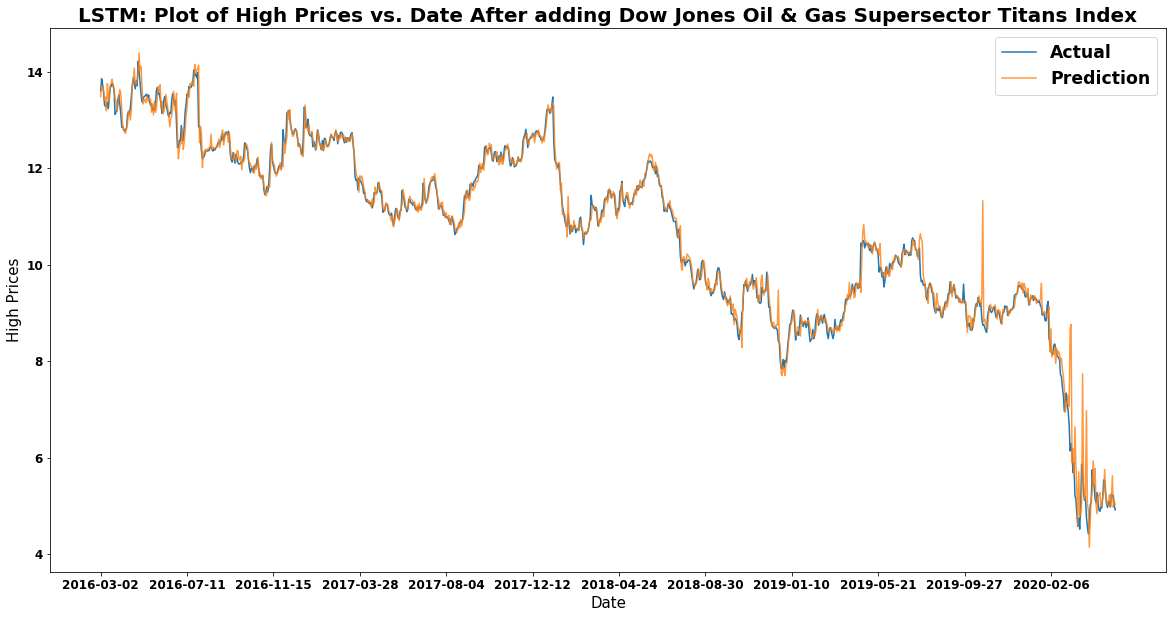

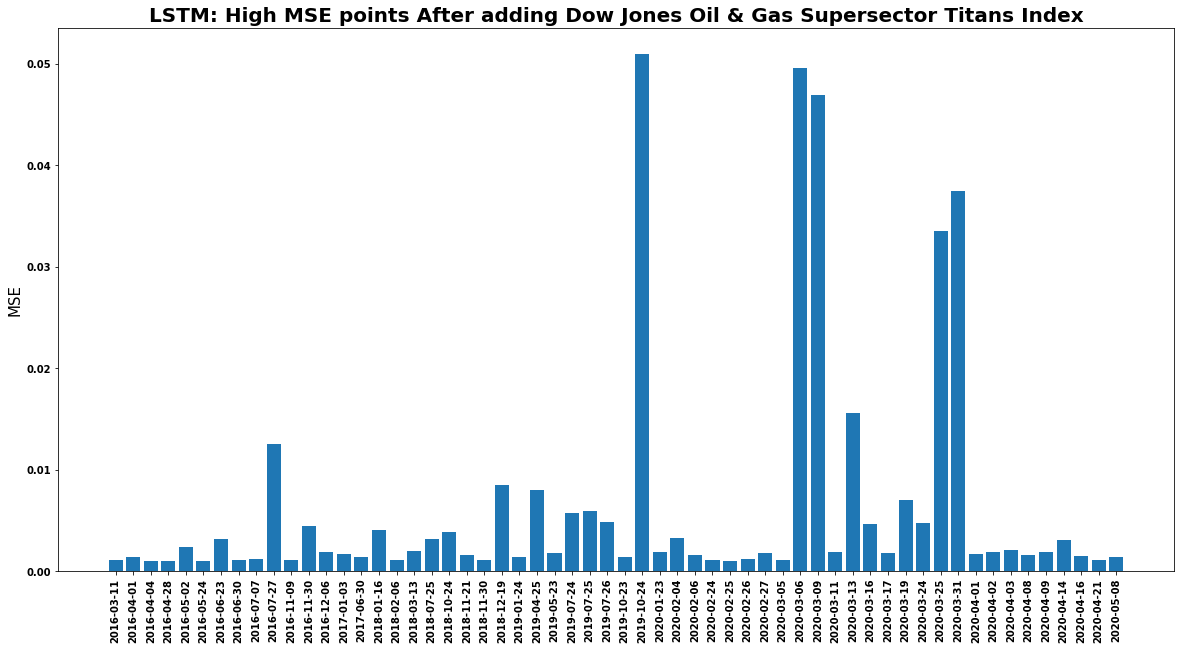

In [118]:
def evaluate_model(y_predicted,y_actual,dates):

    plt.figure(figsize=(20,10))
    plt.title('LSTM: Plot of High Prices vs. Date After adding Dow Jones Oil & Gas Supersector Titans Index',fontsize=20,fontweight='bold')
    plt.xlabel('Date',fontsize=15)
    plt.ylabel('High Prices',fontsize=15)
    plt.plot((y_actual.reshape(-1,1)), label="Actual")#,color='red')
    plt.plot(y_predicted.reshape(-1,1), label="Prediction", alpha=0.8)#,color ='black')
    index = np.arange((len(y_predicted)-1),step=90)
    plt.xticks(index,dates[index],fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize="xx-large")

 
#Rescaling the high values from range 0-1 to original values:
actual= scaler.inverse_transform(np.array(actual_high).reshape(-1,1))
predicted = scaler.inverse_transform(np.array(predicted_high).reshape(-1,1))
evaluate_model(predicted,actual,np.array(predicted_dates))

print("time taken for execution : %s seconds " % (time_taken))
print('Mean Validation loss=', round(mean(model_val_loss),8)) 
print('Mean Model loss=', round(mean(model_loss),8))


large_loss = []
large_loss_date = []  
for index in range(0,len(model_val_loss)):
    val_loss = model_val_loss[index]
    if val_loss>0.001:
        large_loss.append(val_loss)
        large_loss_date.append(predicted_dates[index])


plt.rcParams["font.weight"] = "bold"
plt.figure(figsize=(20,10))
plt.title('LSTM: High MSE points After adding Dow Jones Oil & Gas Supersector Titans Index',fontsize=20,fontweight='bold')
plt.ylabel('MSE',fontsize=15)
idx = np.arange(len(large_loss_date))
plt.xticks(idx,large_loss_date,rotation=90)
plt.bar(idx, large_loss, align='center', alpha=1)

# Model After Variable Selection:

Adding : 
1. S&P Global Oil Index
2. Monthly Car Sales Data
3. S&P 1000
4. Crude Oil Prices

In [154]:
glb_oil = pd.read_csv('/Users/aleenaalex/Documents/UCC projects/data/S&P Global Oil Index 5Y.csv', 
                      header=0, index_col=0)
# Date Conversion:
#Convert Date Format:yr-mnth-dt
dates = []
dates = list(glb_oil.index)
newDates = []
for idx in range(0,len(dates)): 
    date = dates[idx]
    day,month,year = date[0:2],date[3:5],'20'+date[6:8]
    newDates.append(year+'-'+month+'-'+day)
glb_oil.insert(1, "FormatDate", newDates)
glb_oil

S&P Global Oil Index  FormatDate
Effective date                                   
15/05/15                      1956.93  2015-05-15
18/05/15                      1948.25  2015-05-18
19/05/15                      1917.52  2015-05-19
20/05/15                      1916.57  2015-05-20
21/05/15                      1936.78  2015-05-21
...                               ...         ...
08/05/20                      1082.50  2020-05-08
11/05/20                      1071.49  2020-05-11
12/05/20                      1062.24  2020-05-12
13/05/20                      1022.17  2020-05-13
14/05/20                      1017.11  2020-05-14

[1301 rows x 2 columns]

In [155]:
ford_sales = pd.read_csv('/Users/aleenaalex/Documents/UCC projects/data/fordsales.csv', header=0, index_col=None)
ford_sales

Month   Sales
0   2015-05  250077
1   2015-06  224671
2   2015-07  222009
3   2015-08  233879
4   2015-09  221261
..      ...     ...
56  2020-01  167146
57  2020-02  216395
58  2020-03  131072
59  2020-04  102447
60  2020-05  145484

[61 rows x 2 columns]

In [156]:
sp1000 = pd.read_csv('/Users/aleenaalex/Documents/UCC projects/data/S&P 1000.csv', 
                      header=0, index_col=0)
#Convert Date Format:
sp = []
sp = list(sp1000.index)
newdt = []
newsp = []

for idx in range(0,len(sp)): 
    spindex = sp[idx]
    year,month,day = '20'+spindex[6:],spindex[3:5],spindex[0:2]
    newdt.append(year+'-'+month+'-'+day)

sp1000.insert(1, "FormatDate", newdt)
sp1000

S&P 1000  FormatDate
Effective date                       
15/05/15          8627.79  2015-05-15
18/05/15          8701.63  2015-05-18
19/05/15          8689.52  2015-05-19
20/05/15          8692.93  2015-05-20
21/05/15          8697.50  2015-05-21
...                   ...         ...
08/05/20          9409.29  2020-05-08
11/05/20          9309.29  2020-05-11
12/05/20          8976.31  2020-05-12
13/05/20          8661.19  2020-05-13
14/05/20          8736.09  2020-05-14

[1259 rows x 2 columns]

In [165]:
#merge values:
ford_dates = list(ford.index)
sales_dates = list(ford_sales['Month'])
sp1000_dates = list(sp1000['FormatDate'])
oil_dates = list(glb_oil['FormatDate'])


ford["sales"] = 0
mean_sp = mean(sp1000['S&P 1000'])
ford["S&P1000"] = mean_sp
mean_oil = mean(glb_oil['S&P Global Oil Index'])
ford["oil"] = mean_oil


for row_num in range(0,len(ford_dates)):
    partial_date = ford_dates[row_num][0:7] 
    date = ford_dates[row_num] 
    
    if partial_date in sales_dates:
        ford["sales"][row_num] = ford_sales['Sales'][ford_sales['Month']==partial_date]
        
    if date in sp1000_dates:
        ford["S&P1000"][row_num] = mean((sp1000['S&P 1000'][sp1000['FormatDate']==date]))
        
    if date in oil_dates:
        ford["oil"][row_num] = mean((glb_oil['S&P Global Oil Index'][glb_oil['FormatDate']==date]))
                                    
print(ford)

/Users/aleenaalex/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/aleenaalex/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/aleenaalex/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


                Open      High       Low     Close  Adj Close    Volume  \
Date                                                                      
2015-05-15  0.959860  0.969352  0.974160  0.982862   0.966201  0.049889   
2015-05-18  0.977312  0.982487  0.989664  0.991431   0.975584  0.052362   
2015-05-19  0.987784  0.981611  0.989664  0.984576   0.968078  0.032961   
2015-05-20  0.983421  0.975482  0.973299  0.967438   0.949312  0.065305   
2015-05-21  0.960733  0.974606  0.973299  0.985433   0.969016  0.072315   
...              ...       ...       ...       ...        ...       ...   
2020-05-08  0.060209  0.072680  0.085271  0.105398   0.149157  0.417663   
2020-05-11  0.079407  0.067426  0.093885  0.095116   0.134605  0.302773   
2020-05-12  0.076789  0.070053  0.086994  0.083119   0.117628  0.282113   
2020-05-13  0.063700  0.051664  0.060293  0.060840   0.086099  0.412567   
2020-05-14  0.032286  0.043783  0.048234  0.075407   0.106714  0.447113   

             sales  S&P1

In [168]:
def normalize(data):
    
    scaler_open = MinMaxScaler()
    scaler_high = MinMaxScaler()
    scaler_low = MinMaxScaler()
    scaler_close = MinMaxScaler()
    scaler_adjclose = MinMaxScaler()
    scaler_volume = MinMaxScaler()
    scaler_oil = MinMaxScaler()
    scaler_sls = MinMaxScaler()
    scaler_sp = MinMaxScaler()

    #Open:
    fit = scaler_open.fit(np.array(data['Open']).reshape(-1, 1))
    data['Open'] =scaler_open.transform(np.array(dataframe_ford['Open']).reshape(-1, 1))
    
    #High:
    fit = scaler_high.fit(np.array(data['High']).reshape(-1, 1))
    data['High'] =scaler_high.transform(np.array(data['High']).reshape(-1, 1))
    
    #Low:
    fit = scaler_low.fit(np.array(data['Low']).reshape(-1, 1))
    data['Low'] =scaler_low.transform(np.array(data['Low']).reshape(-1, 1))
    
    #Close:
    fit = scaler_close.fit(np.array(data['Close']).reshape(-1, 1))
    data['Close'] =scaler_close.transform(np.array(data['Close']).reshape(-1, 1))
    
    #AdjClose:
    fit = scaler_adjclose.fit(np.array(data['Adj Close']).reshape(-1, 1))
    data['Adj Close'] =scaler_adjclose.transform(np.array(data['Adj Close']).reshape(-1, 1))
    
    #High:
    fit = scaler_volume.fit(np.array(data['Volume']).reshape(-1, 1))
    data['Volume'] =scaler_volume.transform(np.array(data['Volume']).reshape(-1, 1))
    
    #Sales:
    fit = scaler_sls.fit(np.array(data['sales']).reshape(-1, 1))
    data['sales'] =scaler_sls.transform(np.array(data['sales']).reshape(-1, 1))
    
    #S&P1000:
    fit = scaler_sp.fit(np.array(data['S&P1000']).reshape(-1, 1))
    data['S&P1000'] =scaler_sp.transform(np.array(data['S&P1000']).reshape(-1, 1))
    
    #Global Oil :
    fit = scaler_oil.fit(np.array(data['oil']).reshape(-1, 1))
    data['oil'] =scaler_oil.transform(np.array(data['oil']).reshape(-1, 1))
    
    return data,scaler_high
    

df = ford
dataframe_ford = df
df,scaler = normalize(ford)

#convert data: form X and y data:
Xarr = df.rename_axis('ID').values
Xarr = Xarr[0:1258]
Datearr = df.index.values

df1 = df[['High']]
yarr = df1.rename_axis('ID').values

print('Xarr:',Xarr[0:5])
print('yarr:',yarr[0:5])
print('Datearr:',Datearr[0:5])

yarr = np.delete(yarr, 0)
print('yarr:',yarr[0:5])
print('X shape:',Xarr.shape)
print('y shape:',yarr.shape)

def build_data(start,pw,window_size=200):
    
    X_train,X_test = Xarr[start:start+window_size],Xarr[start+window_size:start+window_size+pw]
    y_train,y_test = yarr[start:start+window_size],yarr[start+window_size:start+window_size+pw]
    Date_train,Date_test = Datearr[start:start+window_size],Datearr[start+window_size:start+window_size+pw]
    return X_train,X_test,y_train,y_test,Date_train,Date_test

trn_size = len(Xarr)

from numpy import array
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline
    
file_path = 'daily_mlp_model_weights.h5'
    
callback_checkpoint = ModelCheckpoint(filepath=file_path,
                                      monitor='val_loss',
                                      save_best_only=True,
                                      save_weights_only=True)
    
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
    
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3,
                              patience=5, min_lr=0.0009)
    
callbacks = [early_stopping, callback_checkpoint, reduce_lr]
    
tf.keras.backend.clear_session()
    
model_mlp = tf.keras.models.Sequential()
    
model_mlp.add(tf.keras.layers.Reshape((9,),input_shape=(9,)))
    
model_mlp.add(tf.keras.layers.Dense(200,activation='relu'))
    
model_mlp.add(tf.keras.layers.Dense(1,activation='linear'))
    
model_mlp.compile(optimizer='adam',loss='mse',metrics=['accuracy'])
    

Xarr: [[0.95986038 0.96935201 0.97416021 0.98286204 0.96620093 0.04988881
  0.98016824 0.32730689 0.93603456]
 [0.97731239 0.98248687 0.98966408 0.99143102 0.97558374 0.05236248
  0.98016824 0.34182067 0.92952401]
 [0.9877836  0.98161121 0.98966408 0.98457584 0.96807751 0.0329615
  0.98016824 0.33944036 0.90647455]
 [0.98342059 0.97548161 0.97329888 0.96743787 0.94931176 0.0653048
  0.98016824 0.34011062 0.90576199]
 [0.96073298 0.97460595 0.97329888 0.98543273 0.96901587 0.0723147
  0.98016824 0.34100889 0.92092078]]
yarr: [[0.96935201]
 [0.98248687]
 [0.98161121]
 [0.97548161]
 [0.97460595]]
Datearr: ['2015-05-15' '2015-05-18' '2015-05-19' '2015-05-20' '2015-05-21']
yarr: [0.98248687 0.98161121 0.97548161 0.97460595 0.97022767]
X shape: (1258, 9)
y shape: (1258,)


In [169]:
import time
from itertools import chain
start_time = time.time()

predicted_high = []
actual_high = []
predicted_dates = []
window = 200
model_loss = []
model_val_loss =[]

for trn in range(0,trn_size-window):
    X_train,X_test,y_train,y_test,Date_train,Date_test = build_data(trn,pw=1,window_size = window)
    print(trn)
    
    history = model_mlp.fit(X_train, y_train,verbose = 0, epochs=200,
                        validation_data=(X_test, y_test), callbacks=callbacks, 
                        shuffle=False)
    yhat = model_mlp.predict(X_test, verbose=0)
    yhat = list(chain.from_iterable(yhat)) 
    if len(predicted_high) == 0:
        predicted_high = yhat
        predicted_dates = Date_test.tolist()
        actual_high = y_test.tolist()
        model_loss.append(history.history['loss'][-1])
        model_val_loss.append(history.history['val_loss'][-1])
        
        
    else:
        beg=len(predicted_high)-len(yhat)+1
        yhat_idx = 0
        for pred_idx in range(beg,len(predicted_high)):
            predicted_high[pred_idx]= (predicted_high[pred_idx] + yhat[yhat_idx])/2
            yhat_idx+=1
        predicted_high.append(yhat[-1])
        actual_high.append(y_test[-1])
        predicted_dates.append(Date_test.tolist()[-1])
        model_loss.append(history.history['loss'][-1])
        model_val_loss.append(history.history['val_loss'][-1])
    
    
time_taken = time.time() - start_time

0
Epoch 00021: early stopping
1
Epoch 00012: early stopping
2
Epoch 00176: early stopping
3
Epoch 00013: early stopping
4
Epoch 00122: early stopping
5
Epoch 00159: early stopping
6
Epoch 00017: early stopping
7
8
Epoch 00012: early stopping
9
Epoch 00030: early stopping
10
Epoch 00054: early stopping
11
Epoch 00012: early stopping
12
Epoch 00024: early stopping
13
Epoch 00026: early stopping
14
Epoch 00052: early stopping
15
Epoch 00057: early stopping
16
Epoch 00035: early stopping
17
Epoch 00025: early stopping
18
Epoch 00026: early stopping
19
Epoch 00021: early stopping
20
Epoch 00017: early stopping
21
Epoch 00014: early stopping
22
Epoch 00035: early stopping
23
Epoch 00014: early stopping
24
Epoch 00014: early stopping
25
Epoch 00011: early stopping
26
Epoch 00029: early stopping
27
Epoch 00021: early stopping
28
Epoch 00016: early stopping
29
Epoch 00013: early stopping
30
Epoch 00024: early stopping
31
Epoch 00012: early stopping
32
Epoch 00031: early stopping
33
Epoch 00043:

Epoch 00018: early stopping
262
Epoch 00011: early stopping
263
Epoch 00011: early stopping
264
Epoch 00019: early stopping
265
Epoch 00033: early stopping
266
Epoch 00060: early stopping
267
Epoch 00012: early stopping
268
Epoch 00011: early stopping
269
Epoch 00011: early stopping
270
Epoch 00011: early stopping
271
Epoch 00031: early stopping
272
Epoch 00012: early stopping
273
Epoch 00043: early stopping
274
Epoch 00011: early stopping
275
Epoch 00051: early stopping
276
Epoch 00014: early stopping
277
Epoch 00042: early stopping
278
Epoch 00043: early stopping
279
Epoch 00019: early stopping
280
Epoch 00074: early stopping
281
Epoch 00014: early stopping
282
Epoch 00018: early stopping
283
Epoch 00012: early stopping
284
Epoch 00027: early stopping
285
Epoch 00020: early stopping
286
Epoch 00013: early stopping
287
Epoch 00047: early stopping
288
Epoch 00013: early stopping
289
Epoch 00031: early stopping
290
Epoch 00022: early stopping
291
Epoch 00020: early stopping
292
Epoch 00

Epoch 00023: early stopping
519
Epoch 00014: early stopping
520
Epoch 00016: early stopping
521
Epoch 00012: early stopping
522
Epoch 00013: early stopping
523
Epoch 00013: early stopping
524
Epoch 00015: early stopping
525
Epoch 00025: early stopping
526
Epoch 00014: early stopping
527
Epoch 00015: early stopping
528
Epoch 00015: early stopping
529
Epoch 00025: early stopping
530
Epoch 00015: early stopping
531
Epoch 00013: early stopping
532
Epoch 00017: early stopping
533
Epoch 00014: early stopping
534
Epoch 00012: early stopping
535
Epoch 00045: early stopping
536
Epoch 00016: early stopping
537
Epoch 00020: early stopping
538
Epoch 00014: early stopping
539
Epoch 00018: early stopping
540
Epoch 00026: early stopping
541
Epoch 00025: early stopping
542
Epoch 00021: early stopping
543
Epoch 00021: early stopping
544
Epoch 00015: early stopping
545
Epoch 00013: early stopping
546
Epoch 00032: early stopping
547
Epoch 00015: early stopping
548
Epoch 00045: early stopping
549
Epoch 00

Epoch 00012: early stopping
776
Epoch 00060: early stopping
777
Epoch 00011: early stopping
778
Epoch 00014: early stopping
779
Epoch 00011: early stopping
780
Epoch 00011: early stopping
781
Epoch 00011: early stopping
782
Epoch 00058: early stopping
783
Epoch 00013: early stopping
784
Epoch 00013: early stopping
785
Epoch 00011: early stopping
786
Epoch 00013: early stopping
787
Epoch 00024: early stopping
788
Epoch 00013: early stopping
789
Epoch 00025: early stopping
790
Epoch 00013: early stopping
791
Epoch 00011: early stopping
792
Epoch 00013: early stopping
793
Epoch 00013: early stopping
794
Epoch 00012: early stopping
795
Epoch 00011: early stopping
796
Epoch 00011: early stopping
797
Epoch 00011: early stopping
798
Epoch 00012: early stopping
799
Epoch 00068: early stopping
800
Epoch 00012: early stopping
801
Epoch 00016: early stopping
802
Epoch 00012: early stopping
803
Epoch 00012: early stopping
804
Epoch 00012: early stopping
805
Epoch 00014: early stopping
806
Epoch 00

Epoch 00013: early stopping
1032
Epoch 00017: early stopping
1033
Epoch 00048: early stopping
1034
Epoch 00011: early stopping
1035
Epoch 00011: early stopping
1036
Epoch 00012: early stopping
1037
Epoch 00072: early stopping
1038
Epoch 00011: early stopping
1039
Epoch 00030: early stopping
1040
Epoch 00017: early stopping
1041
Epoch 00044: early stopping
1042
Epoch 00014: early stopping
1043
Epoch 00015: early stopping
1044
Epoch 00011: early stopping
1045
Epoch 00017: early stopping
1046
Epoch 00022: early stopping
1047
Epoch 00033: early stopping
1048
Epoch 00019: early stopping
1049
Epoch 00032: early stopping
1050
Epoch 00013: early stopping
1051
Epoch 00022: early stopping
1052
Epoch 00035: early stopping
1053
Epoch 00018: early stopping
1054
Epoch 00015: early stopping
1055
Epoch 00019: early stopping
1056
Epoch 00012: early stopping
1057
Epoch 00015: early stopping


time taken for execution : 358.2516872882843 seconds 
Mean Validation loss= 0.00022852
Mean Model loss= 0.00013711


<BarContainer object of 44 artists>

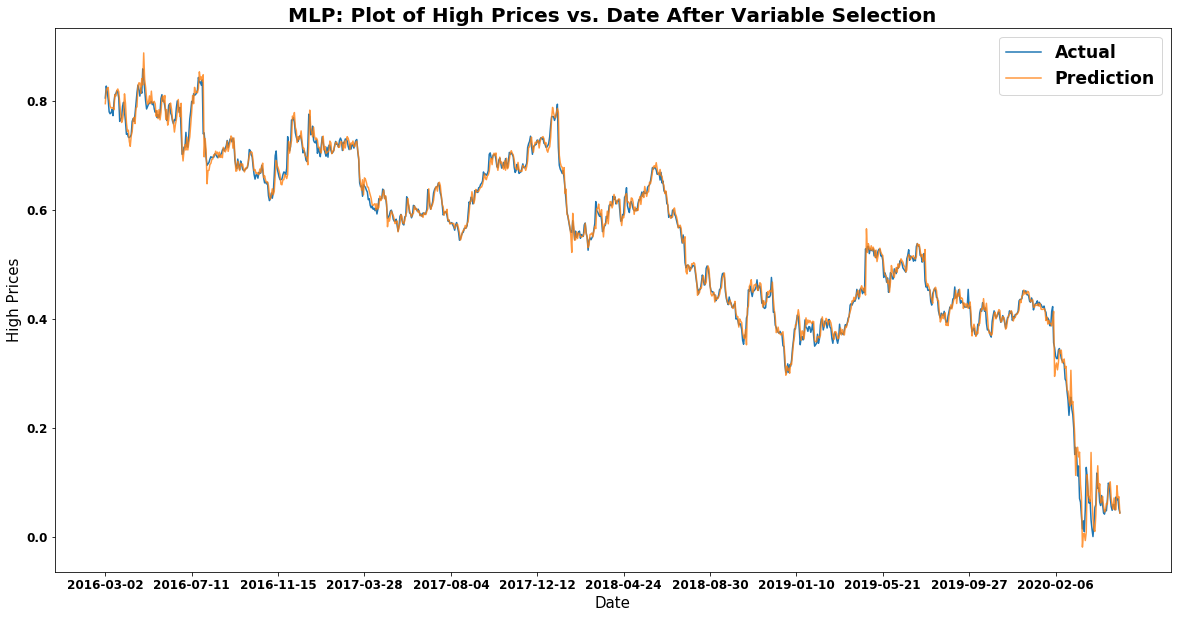

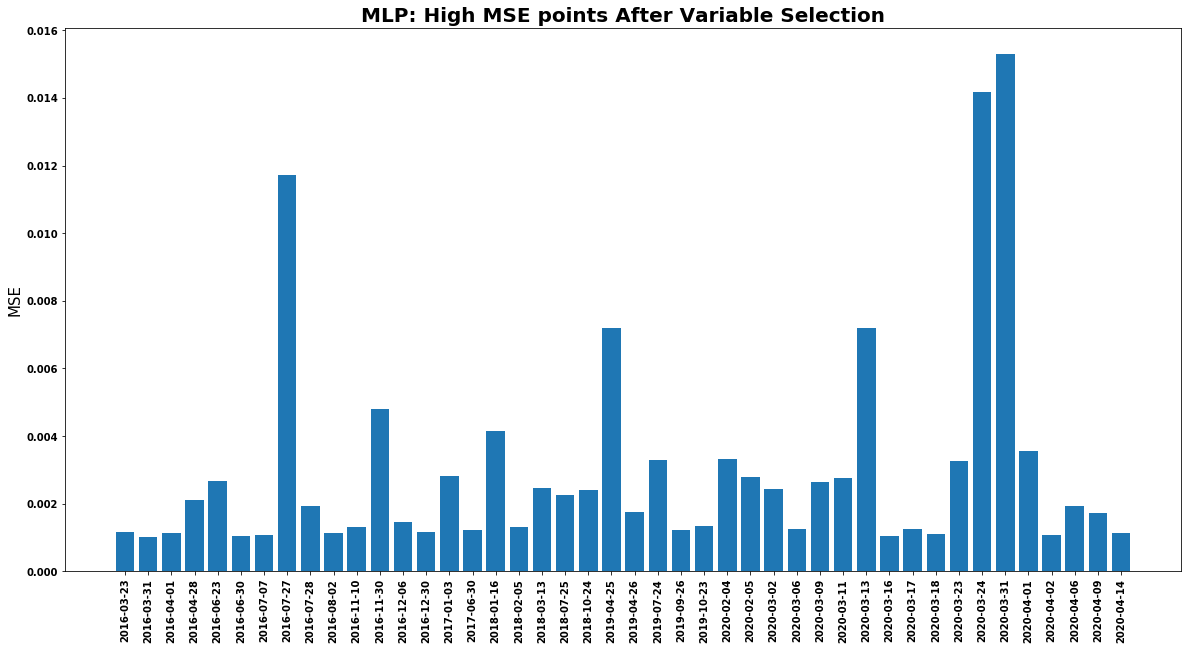

In [170]:
def evaluate_model(y_predicted,y_actual,dates):

    plt.figure(figsize=(20,10))
    plt.title('MLP: Plot of High Prices vs. Date After Variable Selection',fontsize=20,fontweight='bold')
    plt.xlabel('Date',fontsize=15)
    plt.ylabel('High Prices',fontsize=15)
    plt.plot((y_actual.reshape(-1,1)), label="Actual")#,color='red')
    plt.plot(y_predicted.reshape(-1,1), label="Prediction", alpha=0.8)#,color ='black')
    index = np.arange((len(y_predicted)-1),step=90)
    plt.xticks(index,dates[index],fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize="xx-large")

 
#Rescaling the high values from range 0-1 to original values:
actual= scaler.inverse_transform(np.array(actual_high).reshape(-1,1))
predicted = scaler.inverse_transform(np.array(predicted_high).reshape(-1,1))
evaluate_model(predicted,actual,np.array(predicted_dates))

print("time taken for execution : %s seconds " % (time_taken))
print('Mean Validation loss=', round(mean(model_val_loss),8)) 
print('Mean Model loss=', round(mean(model_loss),8))


large_loss = []
large_loss_date = []  
for index in range(0,len(model_val_loss)):
    val_loss = model_val_loss[index]
    if val_loss>0.001:
        large_loss.append(val_loss)
        large_loss_date.append(predicted_dates[index])


plt.rcParams["font.weight"] = "bold"
plt.figure(figsize=(20,10))
plt.title('MLP: High MSE points After Variable Selection',fontsize=20,fontweight='bold')
plt.ylabel('MSE',fontsize=15)
idx = np.arange(len(large_loss_date))
plt.xticks(idx,large_loss_date,rotation=90)
plt.bar(idx, large_loss, align='center', alpha=1)

# Final Model - CNN

In [149]:
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
import matplotlib.pyplot as plt
%matplotlib inline

file_path = 'daily_mlp_model_weights.h5'
    
callback_checkpoint = ModelCheckpoint(filepath=file_path,
                                      monitor='val_loss',
                                      save_best_only=True,
                                      save_weights_only=True)
    
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
    
callbacks = [early_stopping, callback_checkpoint]#, reduce_lr]

Xarr = Xarr.reshape((Xarr.shape[0], Xarr.shape[1], 1))
# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(9, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

#CNN Model window size =1:
import time
from itertools import chain
start_time = time.time()

predicted_high = []
actual_high = []
predicted_dates = []
window = 200
model_loss = []
model_val_loss =[]

for trn in range(0,trn_size-window):
    X_train,X_test,y_train,y_test,Date_train,Date_test = build_data(trn,pw=1,window_size = window)
    print(trn)
    
    history = model.fit(X_train, y_train,verbose = 0, epochs=200,
                        validation_data=(X_test, y_test), callbacks=callbacks, 
                        shuffle=False)
    yhat = model.predict(X_test, verbose=0)
    yhat = list(chain.from_iterable(yhat)) 
    if len(predicted_high) == 0:
        predicted_high = yhat
        predicted_dates = Date_test.tolist()
        actual_high = y_test.tolist()
        model_loss.append(history.history['loss'][-1])
        model_val_loss.append(history.history['val_loss'][-1])
        
        
    else:
        beg=len(predicted_high)-len(yhat)+1
        yhat_idx = 0
        for pred_idx in range(beg,len(predicted_high)):
            predicted_high[pred_idx]= (predicted_high[pred_idx] + yhat[yhat_idx])/2
            yhat_idx+=1
        predicted_high.append(yhat[-1])
        actual_high.append(y_test[-1])
        predicted_dates.append(Date_test.tolist()[-1])
        model_loss.append(history.history['loss'][-1])
        model_val_loss.append(history.history['val_loss'][-1])
    
    
time_taken = time.time() - start_time
print(predicted_dates[0:5])
print(predicted_high[0:5])
print(actual_high[0:5])

0
Epoch 00016: early stopping
1
Epoch 00074: early stopping
2
Epoch 00061: early stopping
3
Epoch 00013: early stopping
4
Epoch 00041: early stopping
5
Epoch 00056: early stopping
6
Epoch 00133: early stopping
7
Epoch 00029: early stopping
8
Epoch 00128: early stopping
9
Epoch 00017: early stopping
10
Epoch 00011: early stopping
11
Epoch 00021: early stopping
12
Epoch 00071: early stopping
13
Epoch 00019: early stopping
14
Epoch 00091: early stopping
15
Epoch 00016: early stopping
16
Epoch 00029: early stopping
17
Epoch 00017: early stopping
18
Epoch 00013: early stopping
19
Epoch 00019: early stopping
20
Epoch 00048: early stopping
21
Epoch 00017: early stopping
22
Epoch 00062: early stopping
23
Epoch 00022: early stopping
24
Epoch 00011: early stopping
25
Epoch 00014: early stopping
26
Epoch 00012: early stopping
27
Epoch 00013: early stopping
28
Epoch 00014: early stopping
29
Epoch 00020: early stopping
30
Epoch 00012: early stopping
31
Epoch 00013: early stopping
32
Epoch 00019: ea

Epoch 00028: early stopping
261
Epoch 00016: early stopping
262
Epoch 00019: early stopping
263
Epoch 00012: early stopping
264
Epoch 00013: early stopping
265
Epoch 00022: early stopping
266
Epoch 00025: early stopping
267
Epoch 00018: early stopping
268
Epoch 00027: early stopping
269
Epoch 00011: early stopping
270
Epoch 00018: early stopping
271
Epoch 00018: early stopping
272
Epoch 00015: early stopping
273
Epoch 00034: early stopping
274
Epoch 00012: early stopping
275
Epoch 00021: early stopping
276
Epoch 00036: early stopping
277
Epoch 00013: early stopping
278
Epoch 00014: early stopping
279
Epoch 00011: early stopping
280
Epoch 00054: early stopping
281
Epoch 00018: early stopping
282
Epoch 00012: early stopping
283
Epoch 00032: early stopping
284
Epoch 00012: early stopping
285
Epoch 00018: early stopping
286
Epoch 00027: early stopping
287
Epoch 00011: early stopping
288
Epoch 00016: early stopping
289
Epoch 00013: early stopping
290
Epoch 00024: early stopping
291
Epoch 00

Epoch 00024: early stopping
518
Epoch 00014: early stopping
519
Epoch 00035: early stopping
520
Epoch 00015: early stopping
521
Epoch 00043: early stopping
522
Epoch 00012: early stopping
523
Epoch 00012: early stopping
524
Epoch 00026: early stopping
525
Epoch 00014: early stopping
526
Epoch 00013: early stopping
527
Epoch 00013: early stopping
528
Epoch 00012: early stopping
529
Epoch 00041: early stopping
530
Epoch 00013: early stopping
531
Epoch 00028: early stopping
532
Epoch 00014: early stopping
533
Epoch 00014: early stopping
534
Epoch 00020: early stopping
535
Epoch 00014: early stopping
536
Epoch 00013: early stopping
537
Epoch 00016: early stopping
538
Epoch 00013: early stopping
539
Epoch 00017: early stopping
540
Epoch 00025: early stopping
541
Epoch 00016: early stopping
542
Epoch 00023: early stopping
543
Epoch 00012: early stopping
544
Epoch 00049: early stopping
545
Epoch 00011: early stopping
546
Epoch 00051: early stopping
547
Epoch 00017: early stopping
548
Epoch 00

Epoch 00013: early stopping
777
Epoch 00012: early stopping
778
Epoch 00012: early stopping
779
Epoch 00037: early stopping
780
Epoch 00012: early stopping
781
Epoch 00018: early stopping
782
Epoch 00025: early stopping
783
Epoch 00017: early stopping
784
Epoch 00030: early stopping
785
Epoch 00056: early stopping
786
Epoch 00011: early stopping
787
Epoch 00032: early stopping
788
Epoch 00019: early stopping
789
Epoch 00019: early stopping
790
Epoch 00016: early stopping
791
Epoch 00013: early stopping
792
Epoch 00011: early stopping
793
Epoch 00015: early stopping
794
Epoch 00017: early stopping
795
Epoch 00011: early stopping
796
Epoch 00013: early stopping
797
Epoch 00020: early stopping
798
Epoch 00012: early stopping
799
Epoch 00027: early stopping
800
Epoch 00023: early stopping
801
Epoch 00013: early stopping
802
Epoch 00030: early stopping
803
Epoch 00013: early stopping
804
Epoch 00027: early stopping
805
Epoch 00018: early stopping
806
Epoch 00012: early stopping
807
Epoch 00

Epoch 00084: early stopping
1033
Epoch 00098: early stopping
1034
Epoch 00025: early stopping
1035
Epoch 00013: early stopping
1036
Epoch 00050: early stopping
1037
Epoch 00032: early stopping
1038
Epoch 00019: early stopping
1039
Epoch 00011: early stopping
1040
Epoch 00015: early stopping
1041
Epoch 00036: early stopping
1042
Epoch 00012: early stopping
1043
Epoch 00019: early stopping
1044
Epoch 00011: early stopping
1045
Epoch 00044: early stopping
1046
Epoch 00011: early stopping
1047
Epoch 00017: early stopping
1048
Epoch 00064: early stopping
1049
Epoch 00064: early stopping
1050
Epoch 00015: early stopping
1051
Epoch 00032: early stopping
1052
Epoch 00015: early stopping
1053
Epoch 00044: early stopping
1054
Epoch 00035: early stopping
1055
Epoch 00026: early stopping
1056
Epoch 00026: early stopping
1057
Epoch 00012: early stopping
['2016-03-02', '2016-03-03', '2016-03-04', '2016-03-07', '2016-03-08']
[0.84754866, 0.82427603, 0.83234626, 0.8327693, 0.80677444]
[0.8047285464098

time taken for execution : 140.69245195388794 seconds 
Mean Validation loss= 0.00026599
Mean Model loss= 0.0001306


<BarContainer object of 53 artists>

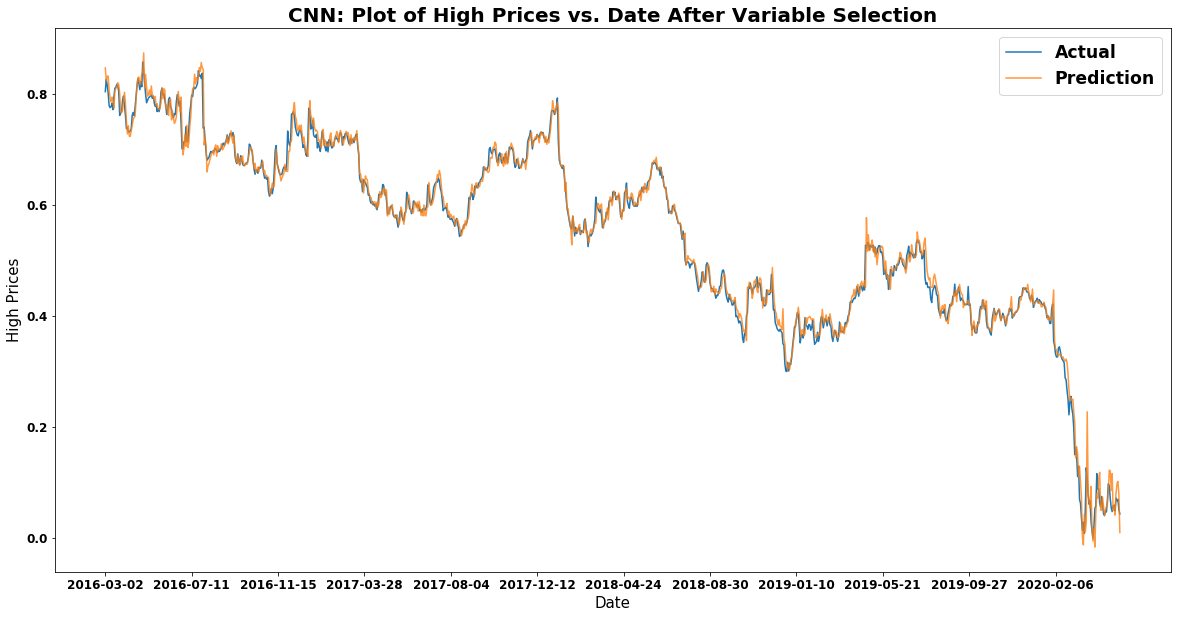

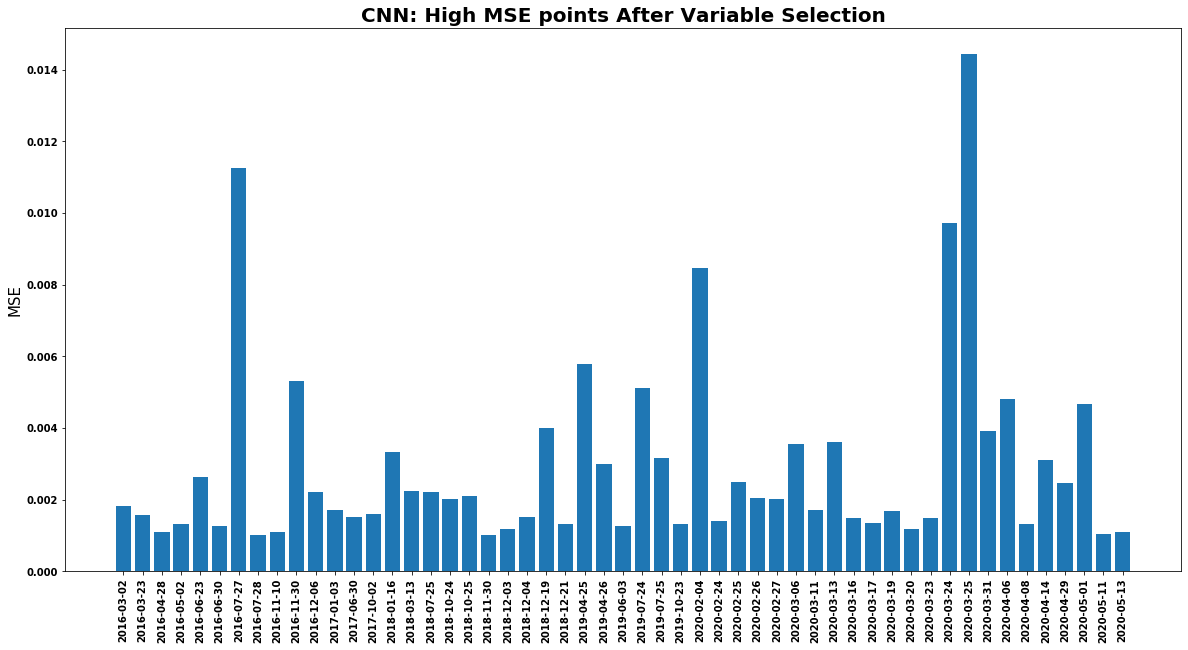

In [150]:
def evaluate_model(y_predicted,y_actual,dates):

    plt.figure(figsize=(20,10))
    plt.title('CNN: Plot of High Prices vs. Date After Variable Selection',fontsize=20,fontweight='bold')
    plt.xlabel('Date',fontsize=15)
    plt.ylabel('High Prices',fontsize=15)
    plt.plot((y_actual.reshape(-1,1)), label="Actual")#,color='red')
    plt.plot(y_predicted.reshape(-1,1), label="Prediction", alpha=0.8)#,color ='black')
    index = np.arange((len(y_predicted)-1),step=90)
    plt.xticks(index,dates[index],fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize="xx-large")

 
#Rescaling the high values from range 0-1 to original values:
actual= scaler.inverse_transform(np.array(actual_high).reshape(-1,1))
predicted = scaler.inverse_transform(np.array(predicted_high).reshape(-1,1))
evaluate_model(predicted,actual,np.array(predicted_dates))

print("time taken for execution : %s seconds " % (time_taken))
print('Mean Validation loss=', round(mean(model_val_loss),8)) 
print('Mean Model loss=', round(mean(model_loss),8))


large_loss = []
large_loss_date = []  
for index in range(0,len(model_val_loss)):
    val_loss = model_val_loss[index]
    if val_loss>0.001:
        large_loss.append(val_loss)
        large_loss_date.append(predicted_dates[index])


plt.rcParams["font.weight"] = "bold"
plt.figure(figsize=(20,10))
plt.title('CNN: High MSE points After Variable Selection',fontsize=20,fontweight='bold')
plt.ylabel('MSE',fontsize=15)
idx = np.arange(len(large_loss_date))
plt.xticks(idx,large_loss_date,rotation=90)
plt.bar(idx, large_loss, align='center', alpha=1)

# Final Model - LSTM

In [151]:
file_path = 'daily_mlp_model_weights.h5'
    
callback_checkpoint = ModelCheckpoint(filepath=file_path,
                                      monitor='val_loss',
                                      save_best_only=True,
                                      save_weights_only=True)
    
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
    
#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3,patience=5, min_lr=0.0009)
    
callbacks = [early_stopping, callback_checkpoint]#, reduce_lr]
adam = Adam(lr=0.003)
model = Sequential()
model.add(LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(16))
model.add(Dense(1))
model.compile(loss='mse', optimizer=adam)

#window size =1:
import time
from itertools import chain
start_time = time.time()

predicted_high = []
actual_high = []
predicted_dates = []
window = 200
model_loss = []
model_val_loss =[]

for trn in range(0,trn_size-window):
    X_train,X_test,y_train,y_test,Date_train,Date_test = build_data(trn,pw=1,window_size = window)
    print(trn)
    
    history = model.fit(X_train, y_train,verbose = 0, epochs=200,
                        validation_data=(X_test, y_test), callbacks=callbacks, 
                        shuffle=False)
    yhat = model.predict(X_test, verbose=0)
    yhat = list(chain.from_iterable(yhat)) 
    if len(predicted_high) == 0:
        predicted_high = yhat
        predicted_dates = Date_test.tolist()
        actual_high = y_test.tolist()
        model_loss.append(history.history['loss'][-1])
        model_val_loss.append(history.history['val_loss'][-1])
        
        
    else:
        beg=len(predicted_high)-len(yhat)+1
        yhat_idx = 0
        for pred_idx in range(beg,len(predicted_high)):
            predicted_high[pred_idx]= (predicted_high[pred_idx] + yhat[yhat_idx])/2
            yhat_idx+=1
        predicted_high.append(yhat[-1])
        actual_high.append(y_test[-1])
        predicted_dates.append(Date_test.tolist()[-1])
        model_loss.append(history.history['loss'][-1])
        model_val_loss.append(history.history['val_loss'][-1])
    

0
Epoch 00017: early stopping
1
Epoch 00011: early stopping
2
Epoch 00011: early stopping
3
Epoch 00011: early stopping
4
Epoch 00011: early stopping
5
Epoch 00011: early stopping
6
Epoch 00011: early stopping
7
Epoch 00011: early stopping
8
Epoch 00198: early stopping
9
Epoch 00019: early stopping
10
Epoch 00017: early stopping
11
Epoch 00026: early stopping
12
Epoch 00012: early stopping
13
Epoch 00018: early stopping
14
Epoch 00056: early stopping
15
Epoch 00027: early stopping
16
Epoch 00017: early stopping
17
Epoch 00012: early stopping
18
Epoch 00030: early stopping
19
Epoch 00029: early stopping
20
Epoch 00017: early stopping
21
Epoch 00019: early stopping
22
Epoch 00019: early stopping
23
Epoch 00033: early stopping
24
Epoch 00016: early stopping
25
Epoch 00015: early stopping
26
Epoch 00015: early stopping
27
Epoch 00021: early stopping
28
Epoch 00025: early stopping
29
Epoch 00024: early stopping
30
Epoch 00031: early stopping
31
Epoch 00014: early stopping
32
Epoch 00023: ea

Epoch 00012: early stopping
261
Epoch 00011: early stopping
262
Epoch 00024: early stopping
263
Epoch 00016: early stopping
264
Epoch 00018: early stopping
265
Epoch 00027: early stopping
266
Epoch 00016: early stopping
267
Epoch 00026: early stopping
268
Epoch 00019: early stopping
269
Epoch 00018: early stopping
270
Epoch 00012: early stopping
271
Epoch 00030: early stopping
272
Epoch 00017: early stopping
273
Epoch 00027: early stopping
274
Epoch 00027: early stopping
275
Epoch 00012: early stopping
276
Epoch 00017: early stopping
277
Epoch 00018: early stopping
278
Epoch 00012: early stopping
279
Epoch 00036: early stopping
280
Epoch 00020: early stopping
281
Epoch 00014: early stopping
282
Epoch 00013: early stopping
283
Epoch 00021: early stopping
284
Epoch 00011: early stopping
285
Epoch 00019: early stopping
286
Epoch 00017: early stopping
287
Epoch 00017: early stopping
288
Epoch 00029: early stopping
289
Epoch 00012: early stopping
290
Epoch 00012: early stopping
291
Epoch 00

Epoch 00024: early stopping
518
Epoch 00021: early stopping
519
Epoch 00022: early stopping
520
Epoch 00029: early stopping
521
Epoch 00028: early stopping
522
Epoch 00011: early stopping
523
Epoch 00012: early stopping
524
Epoch 00018: early stopping
525
Epoch 00036: early stopping
526
Epoch 00026: early stopping
527
Epoch 00016: early stopping
528
Epoch 00032: early stopping
529
Epoch 00036: early stopping
530
Epoch 00013: early stopping
531
Epoch 00011: early stopping
532
Epoch 00033: early stopping
533
Epoch 00015: early stopping
534
Epoch 00017: early stopping
535
Epoch 00029: early stopping
536
Epoch 00013: early stopping
537
Epoch 00027: early stopping
538
Epoch 00022: early stopping
539
Epoch 00035: early stopping
540
Epoch 00027: early stopping
541
Epoch 00039: early stopping
542
Epoch 00011: early stopping
543
Epoch 00014: early stopping
544
Epoch 00015: early stopping
545
Epoch 00027: early stopping
546
Epoch 00012: early stopping
547
Epoch 00016: early stopping
548
Epoch 00

Epoch 00040: early stopping
775
Epoch 00015: early stopping
776
Epoch 00040: early stopping
777
Epoch 00012: early stopping
778
Epoch 00019: early stopping
779
Epoch 00013: early stopping
780
Epoch 00027: early stopping
781
Epoch 00019: early stopping
782
Epoch 00014: early stopping
783
Epoch 00026: early stopping
784
Epoch 00032: early stopping
785
Epoch 00019: early stopping
786
Epoch 00018: early stopping
787
Epoch 00012: early stopping
788
Epoch 00011: early stopping
789
Epoch 00029: early stopping
790
Epoch 00012: early stopping
791
Epoch 00013: early stopping
792
Epoch 00011: early stopping
793
Epoch 00035: early stopping
794
Epoch 00022: early stopping
795
Epoch 00029: early stopping
796
Epoch 00011: early stopping
797
Epoch 00011: early stopping
798
Epoch 00014: early stopping
799
Epoch 00084: early stopping
800
Epoch 00023: early stopping
801
Epoch 00040: early stopping
802
Epoch 00021: early stopping
803
Epoch 00022: early stopping
804
Epoch 00017: early stopping
805
Epoch 00

Epoch 00024: early stopping
1031
Epoch 00015: early stopping
1032
Epoch 00012: early stopping
1033
Epoch 00020: early stopping
1034
Epoch 00011: early stopping
1035
Epoch 00021: early stopping
1036
Epoch 00020: early stopping
1037
Epoch 00027: early stopping
1038
Epoch 00018: early stopping
1039
Epoch 00016: early stopping
1040
Epoch 00015: early stopping
1041
Epoch 00015: early stopping
1042
Epoch 00024: early stopping
1043
Epoch 00018: early stopping
1044
Epoch 00015: early stopping
1045
Epoch 00014: early stopping
1046
Epoch 00076: early stopping
1047
Epoch 00011: early stopping
1048
Epoch 00012: early stopping
1049
Epoch 00014: early stopping
1050
Epoch 00014: early stopping
1051
Epoch 00012: early stopping
1052
Epoch 00024: early stopping
1053
Epoch 00025: early stopping
1054
Epoch 00023: early stopping
1055
Epoch 00013: early stopping
1056
Epoch 00028: early stopping
1057
Epoch 00012: early stopping


time taken for execution : 140.69245195388794 seconds 
Mean Validation loss= 0.0004087
Mean Model loss= 0.00012934


<BarContainer object of 88 artists>

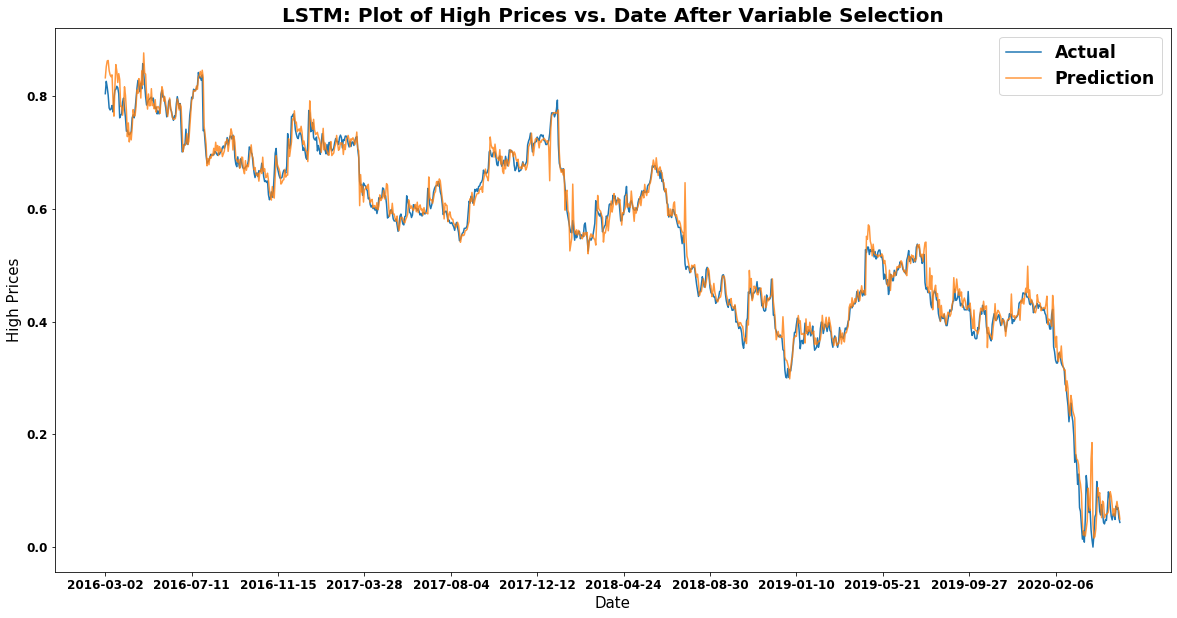

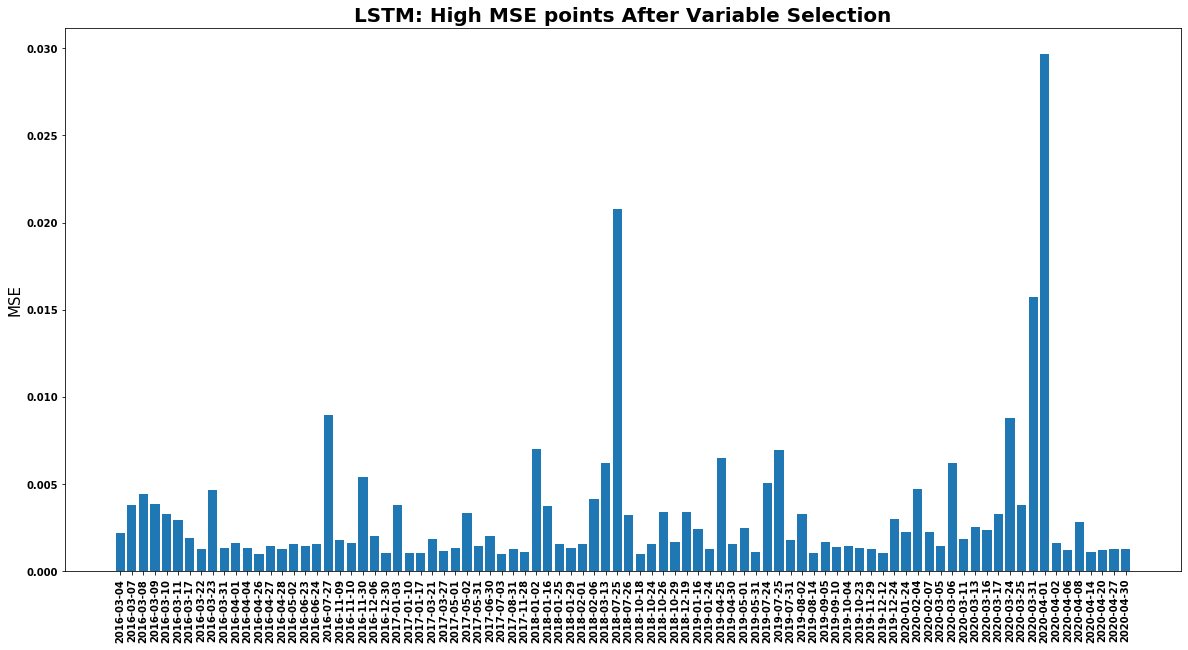

In [152]:
def evaluate_model(y_predicted,y_actual,dates):

    plt.figure(figsize=(20,10))
    plt.title('LSTM: Plot of High Prices vs. Date After Variable Selection',fontsize=20,fontweight='bold')
    plt.xlabel('Date',fontsize=15)
    plt.ylabel('High Prices',fontsize=15)
    plt.plot((y_actual.reshape(-1,1)), label="Actual")#,color='red')
    plt.plot(y_predicted.reshape(-1,1), label="Prediction", alpha=0.8)#,color ='black')
    index = np.arange((len(y_predicted)-1),step=90)
    plt.xticks(index,dates[index],fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize="xx-large")

 
#Rescaling the high values from range 0-1 to original values:
actual= scaler.inverse_transform(np.array(actual_high).reshape(-1,1))
predicted = scaler.inverse_transform(np.array(predicted_high).reshape(-1,1))
evaluate_model(predicted,actual,np.array(predicted_dates))

print("time taken for execution : %s seconds " % (time_taken))
print('Mean Validation loss=', round(mean(model_val_loss),8)) 
print('Mean Model loss=', round(mean(model_loss),8))


large_loss = []
large_loss_date = []  
for index in range(0,len(model_val_loss)):
    val_loss = model_val_loss[index]
    if val_loss>0.001:
        large_loss.append(val_loss)
        large_loss_date.append(predicted_dates[index])


plt.rcParams["font.weight"] = "bold"
plt.figure(figsize=(20,10))
plt.title('LSTM: High MSE points After Variable Selection',fontsize=20,fontweight='bold')
plt.ylabel('MSE',fontsize=15)
idx = np.arange(len(large_loss_date))
plt.xticks(idx,large_loss_date,rotation=90)
plt.bar(idx, large_loss, align='center', alpha=1)